In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests8 as vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [3]:
nsims= 700
trials =1000
skip_boot=False
skip_shi=False
refinement_test=True
linspace=40
smoothing =5
adapt_c= True

In [4]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    col_labels = ['Param','Vuong 1 Step','Vuong 2 Step', 'Refinement Test','Shi (2015)', 'Naive Bootstrap','Bootstrap TIC','Bootstrap ND']



    np_results = np.concatenate((params.reshape(params.shape[0],1),results2[:,:,0]),axis=1)
    df_results = pd.DataFrame(data=np_results,columns=col_labels)
    df_results.to_csv("paper_figs5/"+name[:-4]+".csv")
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 Step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 Step')
    
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Bootstrap ND')
        
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')

    plt.legend()
    plt.savefig('paper_figs6/'+name,dpi=300)
    plt.show()



In [5]:
#c1 corresponds to bn
#c2 corresponds to cn

def mc_run_size(nobs,c1,c2):
    betas = np.linspace(0,3,linspace)
    results = []

    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
        gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
        print(beta,boot3)

    name = 'size_nobs%s_c1%s_c2%s_nobs%s_trials%s.png'%(nobs,c1,c2,nobs,trials)
    create_fig(betas,results,name=name)

In [6]:
def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs



def mc_run_power(nobs,c1,c2):
    betas = np.linspace(0,3,linspace)
    results = []
    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
        gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

    name = 'power_nobs%s_c1%s_c2%s_nobs%s_trials%s.png'%(nobs,c1,c2,nobs,trials)
    create_fig(betas,results,name=name)

# sequence 1

Quantiles: 1th: 0.61, 5th: 1.73, 10th: 2.99, 30th: 8.72, 50th: 15.52, 70th: 23.98, 90th: 38.86, 95th: 46.49, 99th: 60.98
bonus term 0.4085490605084894 // variance stats 56.65464176939687 //part1 23.22791048043381 //part2 56.85464176939686 56.65464176939687
-1.5235273186302924 1.0202930942973614 2.4462350358490292
-2.340625439647271 1.0202930942973614 1.6291369148320503
---
Quantiles: 1th: 0.62, 5th: 1.59, 10th: 2.86, 30th: 8.43, 50th: 14.72, 70th: 22.72, 90th: 36.17, 95th: 43.50, 99th: 57.84
bonus term 1.6466046665397143 // variance stats 13.906549648766939 //part1 23.22791048043381 //part2 14.10654964876694 13.906549648766939
-0.3598531293959461 -0.45599394301709495 3.468414731344838
-3.6530624624753743 -0.45599394301709495 0.17520539826540998
---
Quantiles: 1th: 0.67, 5th: 1.77, 10th: 2.80, 30th: 8.18, 50th: 14.03, 70th: 21.31, 90th: 33.57, 95th: 40.21, 99th: 52.15
bonus term 0.782944830506473 // variance stats 29.467365535076194 //part1 23.22791048043381 //part2 29.667365535076193 2

Quantiles: 1th: 0.78, 5th: 1.81, 10th: 2.96, 30th: 8.82, 50th: 15.47, 70th: 23.89, 90th: 36.84, 95th: 44.44, 99th: 57.44
bonus term 0.5350522593997684 // variance stats 43.212414530295256 //part1 23.22791048043381 //part2 43.41241453029525 43.212414530295256
-1.6292739650467167 0.7055386852600862 2.4421760401700907
-2.699378483846254 0.7055386852600862 1.372071521370554
---
Quantiles: 1th: 0.62, 5th: 1.60, 10th: 2.70, 30th: 8.04, 50th: 14.46, 70th: 21.98, 90th: 34.90, 95th: 41.97, 99th: 56.01
bonus term 3.8950362598948343 // variance stats 5.763464504708092 //part1 23.22791048043381 //part2 5.963464504708092 5.763464504708092
2.1609275264579395 -1.6958640034772212 5.794800978357526
-5.629144993331729 -1.6958640034772212 -1.9952715414321425
---
Quantiles: 1th: 0.70, 5th: 1.83, 10th: 3.12, 30th: 8.87, 50th: 15.47, 70th: 23.75, 90th: 37.26, 95th: 44.50, 99th: 59.19
bonus term 0.849641685825489 // variance stats 27.138477934808712 //part1 23.22791048043381 //part2 27.33847793480871 27.1384

Quantiles: 1th: 0.58, 5th: 1.47, 10th: 2.66, 30th: 8.71, 50th: 15.17, 70th: 23.06, 90th: 36.51, 95th: 44.11, 99th: 58.32
bonus term 8.114200515577341 // variance stats 2.662624658565157 //part1 23.22791048043381 //part2 2.8626246585651574 2.662624658565157
6.235806182616521 -3.827064903185995 9.851743236166033
-9.992594848538161 -3.827064903185995 -6.376657794988648
---
Quantiles: 1th: 0.75, 5th: 1.95, 10th: 3.49, 30th: 9.94, 50th: 17.19, 70th: 26.29, 90th: 41.45, 95th: 49.16, 99th: 65.09
bonus term 4.633462440837857 // variance stats 4.813078400228398 //part1 23.22791048043381 //part2 5.013078400228398 4.813078400228398
2.6674485013321743 -2.468747945772213 6.4704488916700855
-6.599476380343539 -2.468747945772213 -2.7964759900056277
---
Quantiles: 1th: 0.89, 5th: 2.04, 10th: 3.41, 30th: 9.58, 50th: 16.66, 70th: 25.29, 90th: 40.65, 95th: 47.93, 99th: 64.38
bonus term 1.9157995248528785 // variance stats 11.924395156751888 //part1 23.22791048043381 //part2 12.124395156751888 11.92439515

Quantiles: 1th: 0.85, 5th: 2.25, 10th: 3.89, 30th: 11.03, 50th: 19.04, 70th: 29.98, 90th: 48.16, 95th: 58.10, 99th: 76.08
bonus term 0.6002936570781244 // variance stats 38.4942460686551 //part1 23.22791048043381 //part2 38.6942460686551 38.4942460686551
-1.3321827584423602 0.23787100637613326 2.571125682538419
-2.532770072598609 0.23787100637613326 1.3705383683821701
---
Quantiles: 1th: 0.86, 5th: 2.12, 10th: 3.38, 30th: 9.07, 50th: 15.94, 70th: 24.17, 90th: 38.30, 95th: 45.89, 99th: 61.75
bonus term 1.8800881180230178 // variance stats 12.154692451787215 //part1 23.22791048043381 //part2 12.354692451787216 12.154692451787215
-0.1359856266589404 -0.717822484785409 3.745923233803643
-3.896161862704976 -0.717822484785409 -0.014253002242392433
---
Quantiles: 1th: 0.78, 5th: 1.90, 10th: 3.45, 30th: 10.58, 50th: 18.49, 70th: 28.27, 90th: 44.62, 95th: 53.01, 99th: 71.76
bonus term 0.7635453199933112 // variance stats 30.22112874274089 //part1 23.22791048043381 //part2 30.42112874274089 30.2

Quantiles: 1th: 0.81, 5th: 2.09, 10th: 3.56, 30th: 10.18, 50th: 18.33, 70th: 28.06, 90th: 44.61, 95th: 52.77, 99th: 69.15
bonus term 1.0724277146819383 // variance stats 21.459185194894708 //part1 23.22791048043381 //part2 21.65918519489471 21.459185194894708
-1.0064352776910777 -0.47084506876682464 3.1015868050939908
-3.151290707054954 -0.47084506876682464 0.9567313757301141
---
Quantiles: 1th: 0.76, 5th: 1.96, 10th: 3.37, 30th: 10.30, 50th: 17.58, 70th: 27.71, 90th: 44.31, 95th: 52.98, 99th: 69.94
bonus term 0.49837728887522204 // variance stats 46.40708061728982 //part1 23.22791048043381 //part2 46.60708061728982 46.40708061728982
-1.4130405877295273 0.5299104214488314 2.585141677896306
-2.4097951654799714 0.5299104214488314 1.5883871001458618
---
Quantiles: 1th: 0.72, 5th: 1.87, 10th: 3.08, 30th: 9.52, 50th: 16.96, 70th: 25.85, 90th: 40.14, 95th: 47.66, 99th: 62.33
bonus term 3.499606843556061 // variance stats 6.437291421236106 //part1 23.22791048043381 //part2 6.637291421236106 6

Quantiles: 1th: 0.68, 5th: 1.65, 10th: 2.77, 30th: 8.04, 50th: 14.34, 70th: 21.97, 90th: 34.81, 95th: 41.26, 99th: 54.50
bonus term 0.5057209524577448 // variance stats 45.730290939200515 //part1 23.22791048043381 //part2 45.93029093920051 45.730290939200515
-1.3034813411323314 0.8427007245987959 2.4537017007344963
-2.314923246047821 0.8427007245987959 1.4422597958190067
---
Quantiles: 1th: 0.68, 5th: 1.78, 10th: 3.18, 30th: 9.46, 50th: 16.89, 70th: 25.46, 90th: 41.57, 95th: 48.59, 99th: 63.33
bonus term 1.3155108923267536 // variance stats 17.456950326994583 //part1 23.22791048043381 //part2 17.656950326994586 17.456950326994583
-0.6382963997660874 -0.7758810420752531 3.4123455613878377
-3.2693181844195944 -0.7758810420752531 0.7813237767343305
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.60, 5th: 1.72, 10th: 3.18, 30th: 9.15, 50th: 15.47, 70th: 24.14, 90th: 38.43, 95th: 45.34, 99th: 62.12
bonus term 1.1059132857544203 // variance stats 20.803374115890506 //part1 23.2279104804

Quantiles: 1th: 0.57, 5th: 1.64, 10th: 3.01, 30th: 8.85, 50th: 15.11, 70th: 23.13, 90th: 36.14, 95th: 43.28, 99th: 56.51
bonus term 0.4866511460645691 // variance stats 47.53010537070003 //part1 23.22791048043381 //part2 47.73010537070002 47.53010537070003
-1.457953116066889 0.7791704968584668 2.4674018341023434
-2.431255408196027 0.7791704968584668 1.494099541973205
---
Quantiles: 1th: 0.83, 5th: 2.13, 10th: 3.83, 30th: 11.17, 50th: 19.15, 70th: 29.50, 90th: 46.87, 95th: 55.24, 99th: 74.10
bonus term 0.820116420107483 // variance stats 28.122698961922502 //part1 23.22791048043381 //part2 28.322698961922505 28.122698961922502
-1.0434403753170298 -0.4246602166061742 2.7739532142411423
-2.683673215531996 -0.4246602166061742 1.133720374026176
---
Quantiles: 1th: 0.75, 5th: 1.90, 10th: 3.25, 30th: 10.39, 50th: 18.49, 70th: 28.66, 90th: 45.49, 95th: 54.01, 99th: 71.39
bonus term 1.3193406875665037 // variance stats 17.405695556374603 //part1 23.22791048043381 //part2 17.605695556374602 17.4

Quantiles: 1th: 0.71, 5th: 1.71, 10th: 3.01, 30th: 8.57, 50th: 15.11, 70th: 22.74, 90th: 35.93, 95th: 42.34, 99th: 55.12
bonus term 2.3615119699393836 // variance stats 9.636033344785474 //part1 23.22791048043381 //part2 9.836033344785474 9.636033344785474
0.4995306113252511 -1.7003838906986162 4.173195908761354
-4.223493328553516 -1.7003838906986162 -0.5498280311174134
---
Quantiles: 1th: 0.63, 5th: 1.79, 10th: 3.22, 30th: 9.00, 50th: 16.08, 70th: 23.97, 90th: 38.23, 95th: 45.78, 99th: 61.79
bonus term 0.7682950111971056 // variance stats 30.033061704047302 //part1 23.22791048043381 //part2 30.2330617040473 30.033061704047302
-1.2037583648995782 -0.14077425720187672 2.765041541716587
-2.7403483872937895 -0.14077425720187672 1.2284515193223753
---
Quantiles: 1th: 0.54, 5th: 1.55, 10th: 2.92, 30th: 8.72, 50th: 15.47, 70th: 23.94, 90th: 37.79, 95th: 45.12, 99th: 59.10
bonus term 3.1223453886841472 // variance stats 7.239250815946011 //part1 23.22791048043381 //part2 7.439250815946012 7.2

Quantiles: 1th: 0.69, 5th: 1.88, 10th: 3.32, 30th: 9.98, 50th: 17.90, 70th: 27.70, 90th: 43.00, 95th: 51.88, 99th: 66.81
bonus term 0.6675557764347708 // variance stats 34.59546024526609 //part1 23.22791048043381 //part2 34.79546024526609 34.59546024526609
-1.5060853541219064 0.02146460379700916 2.7984804984226974
-2.841196906991448 0.02146460379700916 1.463368945553156
---
Quantiles: 1th: 0.68, 5th: 1.81, 10th: 3.00, 30th: 8.62, 50th: 14.68, 70th: 22.78, 90th: 36.08, 95th: 42.85, 99th: 56.22
bonus term 0.8964243543545687 // variance stats 25.71173518166857 //part1 23.22791048043381 //part2 25.91173518166857 25.71173518166857
-0.9552202224124571 -0.33460171655404364 2.8868370248116384
-2.7480689311215944 -0.33460171655404364 1.093988316102501
---
Quantiles: 1th: 0.89, 5th: 2.15, 10th: 3.73, 30th: 10.92, 50th: 18.69, 70th: 28.79, 90th: 45.76, 95th: 54.57, 99th: 73.67
bonus term 0.6737380945900617 // variance stats 34.27617207182995 //part1 23.22791048043381 //part2 34.47617207182994 34.

Quantiles: 1th: 0.63, 5th: 1.70, 10th: 2.85, 30th: 8.21, 50th: 14.29, 70th: 21.95, 90th: 34.85, 95th: 41.31, 99th: 54.33
bonus term 1.1189479286437347 // variance stats 20.558705464148023 //part1 23.22791048043381 //part2 20.758705464148022 20.558705464148023
-0.8246717394309387 -1.2548675162256928 2.9097371976548096
-3.062567596718408 -1.2548675162256928 0.6718413403673402
---
Quantiles: 1th: 0.84, 5th: 2.21, 10th: 3.96, 30th: 11.34, 50th: 20.08, 70th: 29.92, 90th: 47.18, 95th: 56.82, 99th: 74.72
bonus term 0.4767592353147646 // variance stats 48.52042062299716 //part1 23.22791048043381 //part2 48.72042062299715 48.52042062299716
-1.493090707065055 0.19633335844780378 2.5782760894475825
-2.4466091776945844 0.19633335844780378 1.6247576188180535
---
Quantiles: 1th: 0.67, 5th: 1.66, 10th: 2.64, 30th: 7.43, 50th: 13.20, 70th: 19.97, 90th: 31.68, 95th: 38.52, 99th: 49.87
bonus term 0.63655405378672 // variance stats 36.29008335153327 //part1 23.22791048043381 //part2 36.49008335153327 36.

Quantiles: 1th: 0.78, 5th: 2.32, 10th: 4.10, 30th: 12.90, 50th: 22.19, 70th: 34.05, 90th: 54.64, 95th: 64.58, 99th: 85.19
bonus term 1.0223778626896909 // variance stats 22.519496702838797 //part1 23.22791048043381 //part2 22.719496702838796 22.519496702838797
-1.0982247512635013 -0.7584835992125657 2.9893364828587248
-3.142980476642883 -0.7584835992125657 0.9445807574793432
---
Quantiles: 1th: 0.73, 5th: 1.79, 10th: 3.01, 30th: 9.14, 50th: 15.80, 70th: 24.13, 90th: 37.54, 95th: 45.00, 99th: 58.11
bonus term 1.2946355951219737 // variance stats 17.741659079940096 //part1 23.22791048043381 //part2 17.941659079940095 17.741659079940096
-0.6723049539205632 -1.6837109088386382 3.173508876071927
-3.261576144164511 -1.6837109088386382 0.5842376858279799
---
Quantiles: 1th: 0.59, 5th: 1.60, 10th: 2.73, 30th: 8.25, 50th: 14.13, 70th: 21.45, 90th: 34.33, 95th: 41.97, 99th: 53.08
bonus term 1.1836133700068268 // variance stats 19.42457595447729 //part1 23.22791048043381 //part2 19.62457595447729

Quantiles: 1th: 0.80, 5th: 2.13, 10th: 3.66, 30th: 10.88, 50th: 18.90, 70th: 29.28, 90th: 46.35, 95th: 54.79, 99th: 72.52
bonus term 0.9944801347151351 // variance stats 23.15683707456595 //part1 23.22791048043381 //part2 23.356837074565952 23.15683707456595
-1.0614635647923842 -0.9751339543881334 2.8879458431678184
-3.050423834222654 -0.9751339543881334 0.8989855737375486
---
Quantiles: 1th: 0.55, 5th: 1.65, 10th: 2.92, 30th: 8.52, 50th: 14.92, 70th: 22.97, 90th: 35.98, 95th: 42.97, 99th: 57.13
bonus term 0.5324461231380736 // variance stats 43.424903010910576 //part1 23.22791048043381 //part2 43.62490301091057 43.424903010910576
-1.3258731420579248 0.09202675292877532 2.6017602138592717
-2.390765388334072 0.09202675292877532 1.536867967583124
---
Quantiles: 1th: 0.59, 5th: 1.54, 10th: 2.54, 30th: 7.48, 50th: 13.23, 70th: 20.42, 90th: 32.13, 95th: 38.26, 99th: 48.79
bonus term 0.6070843520142978 // variance stats 38.0614218326727 //part1 23.22791048043381 //part2 38.261421832672696 38

Quantiles: 1th: 0.57, 5th: 1.54, 10th: 2.50, 30th: 6.67, 50th: 11.73, 70th: 18.05, 90th: 28.33, 95th: 33.80, 99th: 43.80
bonus term 0.8156701027482975 // variance stats 28.277089453408056 //part1 23.22791048043381 //part2 28.477089453408055 28.277089453408056
-1.1543898718163959 -0.5230987709309869 2.64270566716167
-2.7857300773129907 -0.5230987709309869 1.0113654616650751
---
Quantiles: 1th: 0.68, 5th: 1.74, 10th: 3.33, 30th: 10.06, 50th: 17.06, 70th: 26.25, 90th: 41.54, 95th: 48.86, 99th: 64.10
bonus term 0.4480447493479877 // variance stats 51.6428360431318 //part1 23.22791048043381 //part2 51.8428360431318 51.6428360431318
-1.4710123693658388 0.17565428773176067 2.443700133525034
-2.367101868061814 0.17565428773176067 1.5476106348290581
---
Quantiles: 1th: 0.91, 5th: 2.38, 10th: 4.04, 30th: 11.48, 50th: 20.40, 70th: 31.58, 90th: 50.26, 95th: 59.86, 99th: 80.22
bonus term 0.6113633276186923 // variance stats 37.793627407957764 //part1 23.22791048043381 //part2 37.99362740795776 37.7

Quantiles: 1th: 0.98, 5th: 2.57, 10th: 4.48, 30th: 12.53, 50th: 21.39, 70th: 32.66, 90th: 52.05, 95th: 61.03, 99th: 78.82
bonus term 0.5162297067695474 // variance stats 44.79529991365471 //part1 23.22791048043381 //part2 44.995299913654705 44.79529991365471
-1.469800619894391 -0.17475106151414338 2.444392004591496
-2.502260033433486 -0.17475106151414338 1.4119325910524012
---
Quantiles: 1th: 0.71, 5th: 1.80, 10th: 3.11, 30th: 9.36, 50th: 16.80, 70th: 25.51, 90th: 39.89, 95th: 47.72, 99th: 61.22
bonus term 0.39255558711947863 // variance stats 58.971009769284315 //part1 23.22791048043381 //part2 59.17100976928431 58.971009769284315
-1.4997071368459192 0.46008651682599455 2.5357419920584077
-2.2848183110848765 0.46008651682599455 1.7506308178194507
---
Quantiles: 1th: 0.84, 5th: 2.09, 10th: 3.52, 30th: 10.21, 50th: 17.77, 70th: 27.33, 90th: 44.01, 95th: 52.71, 99th: 68.12
bonus term 0.3722822282827161 // variance stats 62.19328314859613 //part1 23.22791048043381 //part2 62.3932831485961

0.7692307692307693 [0.95857143 0.         0.04142857]
Quantiles: 1th: 0.73, 5th: 2.05, 10th: 3.58, 30th: 11.21, 50th: 19.42, 70th: 29.07, 90th: 46.07, 95th: 55.23, 99th: 71.89
bonus term 0.3698399932918186 // variance stats 62.605296619465534 //part1 23.22791048043381 //part2 62.80529661946553 62.605296619465534
-1.510479308791406 0.5021554036945592 2.3842501104902953
-2.2501592953750427 0.5021554036945592 1.6445701239066584
---
Quantiles: 1th: 0.79, 5th: 2.09, 10th: 3.53, 30th: 9.85, 50th: 17.41, 70th: 26.51, 90th: 41.95, 95th: 50.61, 99th: 66.03
bonus term 0.490795302831985 // variance stats 47.12708391136634 //part1 23.22791048043381 //part2 47.32708391136634 47.12708391136634
-1.6467557314493046 -0.21598940929091004 2.266095067787742
-2.628346337113275 -0.21598940929091004 1.284504462123772
---
Quantiles: 1th: 0.85, 5th: 2.10, 10th: 3.37, 30th: 9.00, 50th: 15.63, 70th: 23.63, 90th: 38.09, 95th: 44.96, 99th: 60.21
bonus term 0.3270149280105108 // variance stats 70.8301227584547 //pa

Quantiles: 1th: 0.70, 5th: 1.75, 10th: 3.16, 30th: 9.58, 50th: 16.16, 70th: 24.70, 90th: 39.61, 95th: 46.59, 99th: 60.77
bonus term 0.4339102024105209 // variance stats 53.33160711915681 //part1 23.22791048043381 //part2 53.5316071191568 53.33160711915681
-1.285659805461425 0.048521055947774734 2.386349708592704
-2.153480210282467 0.048521055947774734 1.518529303771662
---
Quantiles: 1th: 0.85, 5th: 2.09, 10th: 3.87, 30th: 11.40, 50th: 19.66, 70th: 30.69, 90th: 48.77, 95th: 57.73, 99th: 74.70
bonus term 0.2746184880499793 // variance stats 84.38247165138583 //part1 23.22791048043381 //part2 84.58247165138582 84.38247165138583
-1.6177654130661527 0.8693382395864521 2.2938686963624386
-2.1670023891661114 0.8693382395864521 1.74463172026248
---
Quantiles: 1th: 0.84, 5th: 1.91, 10th: 3.45, 30th: 10.43, 50th: 18.73, 70th: 28.32, 90th: 44.19, 95th: 51.77, 99th: 68.66
bonus term 0.42954081190928395 // variance stats 53.87614325909358 //part1 23.22791048043381 //part2 54.07614325909358 53.8761

Quantiles: 1th: 0.52, 5th: 1.34, 10th: 2.36, 30th: 6.80, 50th: 12.22, 70th: 18.74, 90th: 29.59, 95th: 35.42, 99th: 46.35
bonus term 0.606930432541749 // variance stats 38.071125049963655 //part1 23.22791048043381 //part2 38.27112504996366 38.071125049963655
-1.336586203159102 -0.337699199532377 2.5440373080796506
-2.5504470682425997 -0.337699199532377 1.3301764429961522
---
Quantiles: 1th: 0.78, 5th: 2.04, 10th: 3.61, 30th: 10.93, 50th: 19.69, 70th: 29.69, 90th: 47.41, 95th: 55.73, 99th: 77.31
bonus term 0.38702674403516757 // variance stats 59.81629302992866 //part1 23.22791048043381 //part2 60.01629302992866 59.81629302992866
-1.6323408407721611 0.1212207090779842 2.4662922389950674
-2.406394328842496 0.1212207090779842 1.6922387509247319
---
Quantiles: 1th: 0.77, 5th: 1.75, 10th: 2.92, 30th: 7.48, 50th: 12.83, 70th: 19.76, 90th: 31.11, 95th: 36.66, 99th: 49.15
bonus term 0.39489609733097797 // variance stats 58.620309031733946 //part1 23.22791048043381 //part2 58.82030903173394 58.6

Quantiles: 1th: 0.74, 5th: 1.72, 10th: 3.11, 30th: 9.18, 50th: 16.41, 70th: 24.89, 90th: 39.48, 95th: 46.78, 99th: 60.93
bonus term 0.9218387108103052 // variance stats 24.99736935327466 //part1 23.22791048043381 //part2 25.19736935327466 24.99736935327466
-1.106360173138284 -2.244025769611612 2.7430875089354334
-2.9500375947588946 -2.244025769611612 0.899410087314823
---
Quantiles: 1th: 0.63, 5th: 1.54, 10th: 2.71, 30th: 8.11, 50th: 14.02, 70th: 21.75, 90th: 34.22, 95th: 40.51, 99th: 54.45
bonus term 0.4241275081666 // variance stats 54.566338030849295 //part1 23.22791048043381 //part2 54.76633803084929 54.566338030849295
-1.572692142796311 -0.012348897742594647 2.396690833176999
-2.420947159129511 -0.012348897742594647 1.548435816843799
---
Quantiles: 1th: 0.64, 5th: 1.96, 10th: 3.55, 30th: 10.31, 50th: 17.84, 70th: 27.31, 90th: 42.39, 95th: 51.33, 99th: 66.93
bonus term 0.32417824226821906 // variance stats 71.45166396705757 //part1 23.22791048043381 //part2 71.65166396705756 71.451

Quantiles: 1th: 0.70, 5th: 1.74, 10th: 3.04, 30th: 8.43, 50th: 14.42, 70th: 22.60, 90th: 35.95, 95th: 42.40, 99th: 55.81
bonus term 0.2583576947070588 // variance stats 89.70601385714865 //part1 23.22791048043381 //part2 89.90601385714865 89.70601385714865
-1.7494200212275783 1.1931318050658217 2.593316767893044
-2.2661354106416955 1.1931318050658217 2.0766013784789266
---
Quantiles: 1th: 0.66, 5th: 1.46, 10th: 2.52, 30th: 7.29, 50th: 12.58, 70th: 19.02, 90th: 30.24, 95th: 36.05, 99th: 46.62
bonus term 0.3282143040061329 // variance stats 70.57056117578527 //part1 23.22791048043381 //part2 70.77056117578526 70.57056117578527
-1.6887441629894993 1.0319867510560734 2.3401974933276244
-2.345172771001765 1.0319867510560734 1.6837688853153587
---
Quantiles: 1th: 0.70, 5th: 1.95, 10th: 3.78, 30th: 11.06, 50th: 19.02, 70th: 29.55, 90th: 46.35, 95th: 54.69, 99th: 71.62
bonus term 0.2967446557145809 // variance stats 78.07574998612681 //part1 23.22791048043381 //part2 78.2757499861268 78.075749

Quantiles: 1th: 0.79, 5th: 2.20, 10th: 3.85, 30th: 11.44, 50th: 19.75, 70th: 29.56, 90th: 47.93, 95th: 57.36, 99th: 75.90
bonus term 0.3292350923724906 // variance stats 70.35113813370226 //part1 23.22791048043381 //part2 70.55113813370225 70.35113813370226
-1.689674023693708 0.18453119875302457 2.2100857772276963
-2.3481442084386894 0.18453119875302457 1.5516155924827149
---
Quantiles: 1th: 0.70, 5th: 1.66, 10th: 2.82, 30th: 8.37, 50th: 14.78, 70th: 22.54, 90th: 35.81, 95th: 43.09, 99th: 56.40
bonus term 1.9815069973388968 // variance stats 11.522345927432092 //part1 23.22791048043381 //part2 11.722345927432091 11.522345927432092
-0.18917817784063312 -5.642301038922665 3.8291700936083326
-4.1521921725184265 -5.642301038922665 -0.1338439010694611
---
1.076923076923077 [0.92571429 0.00142857 0.07285714]
Quantiles: 1th: 0.83, 5th: 2.13, 10th: 3.92, 30th: 11.20, 50th: 19.35, 70th: 29.91, 90th: 46.54, 95th: 54.92, 99th: 72.17
bonus term 0.49487872855026693 // variance stats 46.736570800849

Quantiles: 1th: 0.60, 5th: 1.57, 10th: 2.82, 30th: 8.36, 50th: 14.91, 70th: 23.01, 90th: 36.22, 95th: 43.28, 99th: 57.15
bonus term 0.31077913257877304 // variance stats 74.54089488471767 //part1 23.22791048043381 //part2 74.74089488471766 74.54089488471767
-1.7036475457354872 0.685747623367794 2.405663657119735
-2.325205810893033 0.685747623367794 1.7841053919621894
---
Quantiles: 1th: 0.75, 5th: 1.83, 10th: 3.25, 30th: 9.58, 50th: 17.34, 70th: 25.81, 90th: 41.02, 95th: 48.02, 99th: 64.08
bonus term 0.47333489332144973 // variance stats 48.87288857882561 //part1 23.22791048043381 //part2 49.07288857882561 48.87288857882561
-1.603568303223262 -0.6462487626105593 2.381797795611748
-2.550238089866161 -0.6462487626105593 1.4351280089688485
---
Quantiles: 1th: 0.75, 5th: 2.00, 10th: 3.40, 30th: 9.59, 50th: 16.81, 70th: 25.70, 90th: 39.94, 95th: 47.65, 99th: 63.02
bonus term 0.20286750245734345 // variance stats 114.29793682612078 //part1 23.22791048043381 //part2 114.49793682612076 114.297

Quantiles: 1th: 0.86, 5th: 2.30, 10th: 4.39, 30th: 12.48, 50th: 21.38, 70th: 32.66, 90th: 50.82, 95th: 61.09, 99th: 78.18
bonus term 0.35219383609756116 // variance stats 65.75206417524994 //part1 23.22791048043381 //part2 65.95206417524993 65.75206417524994
-1.6369255872630628 -0.402888898391459 2.2914657532992413
-2.341313259458185 -0.402888898391459 1.587078081104119
---
Quantiles: 1th: 0.83, 5th: 2.04, 10th: 3.77, 30th: 10.84, 50th: 18.90, 70th: 29.53, 90th: 46.85, 95th: 55.57, 99th: 74.86
bonus term 0.33915590122195477 // variance stats 68.28741359576905 //part1 23.22791048043381 //part2 68.48741359576904 68.28741359576905
-1.608745904851948 0.0020206701740267032 2.3358191675404383
-2.2870577072958573 0.0020206701740267032 1.6575073650965286
---
Quantiles: 1th: 0.83, 5th: 2.15, 10th: 3.92, 30th: 11.37, 50th: 19.49, 70th: 30.02, 90th: 47.93, 95th: 56.35, 99th: 73.26
bonus term 0.3769809813351458 // variance stats 61.41560298922242 //part1 23.22791048043381 //part2 61.61560298922241

Quantiles: 1th: 0.58, 5th: 1.67, 10th: 2.77, 30th: 7.87, 50th: 13.58, 70th: 20.69, 90th: 31.75, 95th: 37.73, 99th: 51.09
bonus term 0.42571799855122855 // variance stats 54.36172997026503 //part1 23.22791048043381 //part2 54.56172997026503 54.36172997026503
-1.52624304174173 -0.10688887639771737 2.544023355971011
-2.3776790388441875 -0.10688887639771737 1.692587358868554
---
Quantiles: 1th: 0.66, 5th: 1.87, 10th: 3.10, 30th: 8.86, 50th: 15.57, 70th: 24.28, 90th: 38.49, 95th: 45.77, 99th: 61.55
bonus term 0.2450079585828617 // variance stats 94.60471824174695 //part1 23.22791048043381 //part2 94.80471824174694 94.60471824174695
-1.6132914877802582 0.7574621355354348 2.129392343804703
-2.1033074049459817 0.7574621355354348 1.6393764266389794
---
Quantiles: 1th: 0.63, 5th: 1.65, 10th: 2.74, 30th: 7.72, 50th: 13.80, 70th: 21.19, 90th: 33.82, 95th: 40.16, 99th: 53.47
bonus term 0.5032379665017007 // variance stats 45.95691189181234 //part1 23.22791048043381 //part2 46.156911891812335 45.956

Quantiles: 1th: 0.78, 5th: 1.99, 10th: 3.48, 30th: 9.97, 50th: 17.19, 70th: 26.46, 90th: 42.10, 95th: 49.67, 99th: 65.10
bonus term 0.530116164365488 // variance stats 43.61664254331123 //part1 23.22791048043381 //part2 43.81664254331122 43.61664254331123
-1.5944519442193648 -1.4606282581043741 2.5029166211880463
-2.6546842729503406 -1.4606282581043741 1.4426842924570704
---
Quantiles: 1th: 0.76, 5th: 2.21, 10th: 4.05, 30th: 11.89, 50th: 21.01, 70th: 31.79, 90th: 50.02, 95th: 59.32, 99th: 77.23
bonus term 0.5153421779185808 // variance stats 44.87279139124452 //part1 23.22791048043381 //part2 45.07279139124451 44.87279139124452
-1.599312550441411 -1.60501122511093 2.4722698988279173
-2.6299969062785724 -1.60501122511093 1.4415855429907551
---
Quantiles: 1th: 0.75, 5th: 1.70, 10th: 2.78, 30th: 7.87, 50th: 13.82, 70th: 20.64, 90th: 32.43, 95th: 38.81, 99th: 51.35
bonus term 0.2950340504698208 // variance stats 78.52959220620471 //part1 23.22791048043381 //part2 78.72959220620471 78.52959

Quantiles: 1th: 0.90, 5th: 2.04, 10th: 3.42, 30th: 9.41, 50th: 16.77, 70th: 26.04, 90th: 41.32, 95th: 49.26, 99th: 64.46
bonus term 0.3548413863815499 // variance stats 65.25998119694404 //part1 23.22791048043381 //part2 65.45998119694404 65.25998119694404
-1.5469449048580417 0.2549465352701268 2.3051060416579796
-2.2566276776211414 0.2549465352701268 1.5954232688948797
---
Quantiles: 1th: 0.75, 5th: 2.11, 10th: 3.45, 30th: 9.95, 50th: 16.67, 70th: 25.20, 90th: 41.21, 95th: 49.33, 99th: 64.63
bonus term 0.2782650184298514 // variance stats 83.2740586923232 //part1 23.22791048043381 //part2 83.47405869232318 83.2740586923232
-1.5811273899585823 0.2876944703163575 2.2497739512194754
-2.137657426818285 0.2876944703163575 1.6932439143597726
---
Quantiles: 1th: 0.69, 5th: 1.77, 10th: 3.12, 30th: 9.20, 50th: 16.23, 70th: 24.62, 90th: 38.80, 95th: 46.41, 99th: 60.96
bonus term 0.4047134207123753 // variance stats 57.193477190719584 //part1 23.22791048043381 //part2 57.39347719071958 57.193477

Quantiles: 1th: 0.65, 5th: 1.81, 10th: 3.32, 30th: 9.97, 50th: 17.02, 70th: 26.21, 90th: 42.08, 95th: 50.39, 99th: 66.74
bonus term 0.1990650613248787 // variance stats 116.48501908793193 //part1 23.22791048043381 //part2 116.68501908793192 116.48501908793193
-1.6010736099898664 1.3976816404351373 2.2527683647836443
-1.999203732639624 1.3976816404351373 1.8546382421338872
---
Quantiles: 1th: 0.63, 5th: 1.79, 10th: 3.13, 30th: 9.74, 50th: 17.24, 70th: 26.70, 90th: 42.21, 95th: 50.39, 99th: 64.17
bonus term 0.25558266794306067 // variance stats 90.68218175110599 //part1 23.22791048043381 //part2 90.88218175110597 90.68218175110599
-1.5972482531102243 0.3146242384870178 2.2596397373236785
-2.1084135889963456 0.3146242384870178 1.7484744014375573
---
Quantiles: 1th: 0.74, 5th: 2.15, 10th: 3.82, 30th: 11.01, 50th: 19.43, 70th: 29.33, 90th: 47.26, 95th: 57.22, 99th: 75.97
bonus term 0.6580409249861394 // variance stats 35.098580374652336 //part1 23.22791048043381 //part2 35.29858037465233 35

Quantiles: 1th: 0.72, 5th: 1.85, 10th: 3.04, 30th: 8.72, 50th: 15.28, 70th: 23.20, 90th: 36.49, 95th: 43.34, 99th: 57.19
bonus term 0.2862037035795578 // variance stats 80.95866492963465 //part1 23.22791048043381 //part2 81.15866492963464 80.95866492963465
-1.7342952853985756 0.13818414201647458 2.3328105043179095
-2.3067026925576912 0.13818414201647458 1.7604030971587943
---
Quantiles: 1th: 0.72, 5th: 1.75, 10th: 2.89, 30th: 8.03, 50th: 13.62, 70th: 20.92, 90th: 33.35, 95th: 39.56, 99th: 50.69
bonus term 0.4575796643710271 // variance stats 50.5625497570179 //part1 23.22791048043381 //part2 50.762549757017894 50.5625497570179
-1.5363872603271007 -0.9200066209429615 2.3343656466132754
-2.451546589069155 -0.9200066209429615 1.419206317871221
---
Quantiles: 1th: 0.89, 5th: 2.24, 10th: 4.00, 30th: 11.12, 50th: 19.20, 70th: 29.66, 90th: 46.74, 95th: 55.83, 99th: 72.66
bonus term 0.41728611242245806 // variance stats 55.4642308213651 //part1 23.22791048043381 //part2 55.664230821365095 55.4

Quantiles: 1th: 0.60, 5th: 1.81, 10th: 3.06, 30th: 9.00, 50th: 15.36, 70th: 23.57, 90th: 36.58, 95th: 42.45, 99th: 55.15
bonus term 0.3901625155373449 // variance stats 59.33393664289753 //part1 23.22791048043381 //part2 59.53393664289752 59.33393664289753
-1.937236656870212 -0.9808168440013249 2.3853504116688815
-2.717561687944902 -0.9808168440013249 1.6050253805941916
---
Quantiles: 1th: 0.71, 5th: 1.72, 10th: 2.83, 30th: 8.27, 50th: 14.41, 70th: 22.33, 90th: 35.48, 95th: 42.06, 99th: 54.75
bonus term 0.41910458819211305 // variance stats 55.22270625246981 //part1 23.22791048043381 //part2 55.42270625246981 55.22270625246981
-1.5584050179431639 -1.3657432162182928 2.271144665952004
-2.39661419432739 -1.3657432162182928 1.4329354895677773
---
Quantiles: 1th: 0.75, 5th: 2.04, 10th: 3.66, 30th: 11.33, 50th: 19.71, 70th: 30.70, 90th: 48.50, 95th: 57.57, 99th: 76.25
bonus term 0.25339346279030966 // variance stats 91.46736278297587 //part1 23.22791048043381 //part2 91.66736278297586 91.46

1.6153846153846154 [0.95428571 0.00285714 0.04285714]
Quantiles: 1th: 0.74, 5th: 1.94, 10th: 3.53, 30th: 10.04, 50th: 17.50, 70th: 27.14, 90th: 42.96, 95th: 51.92, 99th: 66.86
bonus term 0.3582969162593371 // variance stats 64.62866423450136 //part1 23.22791048043381 //part2 64.82866423450135 64.62866423450136
-1.6973885181366977 -1.3591569611608465 2.276993809916627
-2.4139823506553717 -1.3591569611608465 1.5603999773979529
---
Quantiles: 1th: 0.70, 5th: 1.90, 10th: 3.48, 30th: 10.30, 50th: 17.84, 70th: 28.07, 90th: 45.07, 95th: 54.35, 99th: 71.53
bonus term 0.4201620166515396 // variance stats 55.08322304226234 //part1 23.22791048043381 //part2 55.283223042262335 55.08322304226234
-1.662163256861372 -1.6297846694503941 2.353730744568037
-2.5024872901644515 -1.6297846694503941 1.513406711264958
---
Quantiles: 1th: 0.73, 5th: 1.71, 10th: 3.15, 30th: 9.32, 50th: 16.51, 70th: 25.41, 90th: 39.94, 95th: 47.34, 99th: 60.99
bonus term 0.19121750758514605 // variance stats 121.27376447782011 

Quantiles: 1th: 0.73, 5th: 1.93, 10th: 3.70, 30th: 10.86, 50th: 18.74, 70th: 28.29, 90th: 45.46, 95th: 53.97, 99th: 71.76
bonus term 0.22626068398504834 // variance stats 102.45994989199602 //part1 23.22791048043381 //part2 102.659949891996 102.45994989199602
-1.8449925158996148 0.3345063311192657 2.159147394898382
-2.2975138838697116 0.3345063311192657 1.7066260269282851
---
Quantiles: 1th: 0.87, 5th: 2.52, 10th: 4.68, 30th: 13.79, 50th: 23.82, 70th: 36.54, 90th: 58.56, 95th: 70.28, 99th: 93.26
bonus term 0.1667305105469968 // variance stats 139.11409676746894 //part1 23.22791048043381 //part2 139.31409676746893 139.11409676746894
-1.8776149117475966 0.9064756719284662 2.1123875020521052
-2.2110759328415903 0.9064756719284662 1.7789264809581116
---
Quantiles: 1th: 0.74, 5th: 1.82, 10th: 3.48, 30th: 10.28, 50th: 18.09, 70th: 27.61, 90th: 43.26, 95th: 51.37, 99th: 70.14
bonus term 0.49198650817285183 // variance stats 47.01249484401114 //part1 23.22791048043381 //part2 47.21249484401113

Quantiles: 1th: 0.60, 5th: 1.59, 10th: 2.66, 30th: 7.45, 50th: 12.87, 70th: 20.01, 90th: 31.61, 95th: 38.06, 99th: 49.66
bonus term 0.3319160952553118 // variance stats 69.78127181077726 //part1 23.22791048043381 //part2 69.98127181077726 69.78127181077726
-1.7331765857250627 -0.04232568075469984 2.38880766305663
-2.397008776235686 -0.04232568075469984 1.7249754725460065
---
Quantiles: 1th: 0.82, 5th: 2.05, 10th: 3.67, 30th: 11.02, 50th: 19.02, 70th: 28.67, 90th: 45.56, 95th: 53.98, 99th: 70.21
bonus term 0.25747252219230343 // variance stats 90.01510444165042 //part1 23.22791048043381 //part2 90.21510444165042 90.01510444165042
-1.7190817340278428 -0.6266000257230516 2.190944594400617
-2.2340267784124497 -0.6266000257230516 1.6759995500160099
---
Quantiles: 1th: 0.82, 5th: 1.98, 10th: 3.32, 30th: 9.75, 50th: 16.97, 70th: 26.25, 90th: 41.48, 95th: 49.26, 99th: 67.45
bonus term 0.23371266009895952 // variance stats 99.18661632877978 //part1 23.22791048043381 //part2 99.38661632877978 99

Quantiles: 1th: 0.86, 5th: 2.01, 10th: 3.66, 30th: 10.82, 50th: 18.48, 70th: 28.76, 90th: 45.94, 95th: 54.65, 99th: 72.21
bonus term 0.19250084457008526 // variance stats 120.46394063002174 //part1 23.22791048043381 //part2 120.66394063002173 120.46394063002174
-1.764735751635033 0.40427074509956706 2.0460780607336746
-2.1497374407752035 0.40427074509956706 1.661076371593504
---
Quantiles: 1th: 0.65, 5th: 1.89, 10th: 3.56, 30th: 10.32, 50th: 18.19, 70th: 28.36, 90th: 44.91, 95th: 53.65, 99th: 69.46
bonus term 0.35036569452690824 // variance stats 66.09618950507695 //part1 23.22791048043381 //part2 66.29618950507694 66.09618950507695
-1.5930935080301116 -1.8427851132782194 2.350378727430663
-2.293824897083928 -1.8427851132782194 1.649647338376846
---
Quantiles: 1th: 0.79, 5th: 1.75, 10th: 2.94, 30th: 8.42, 50th: 14.93, 70th: 22.86, 90th: 36.13, 95th: 43.43, 99th: 56.32
bonus term 0.359620102695711 // variance stats 64.39013360576196 //part1 23.22791048043381 //part2 64.59013360576196 64

Quantiles: 1th: 0.80, 5th: 1.88, 10th: 3.15, 30th: 8.70, 50th: 15.22, 70th: 22.93, 90th: 36.16, 95th: 43.13, 99th: 55.91
bonus term 0.2199880157368991 // variance stats 105.387163021707 //part1 23.22791048043381 //part2 105.587163021707 105.387163021707
-1.9248031101978333 0.5352925123023546 2.075867069670051
-2.3647791416716317 0.5352925123023546 1.635891038196253
---
Quantiles: 1th: 0.60, 5th: 1.73, 10th: 3.07, 30th: 9.44, 50th: 16.23, 70th: 24.69, 90th: 39.29, 95th: 46.88, 99th: 63.42
bonus term 0.21072939488219866 // variance stats 110.02624771175662 //part1 23.22791048043381 //part2 110.22624771175663 110.02624771175662
-1.8231256990583429 0.2589395625855481 2.1922778173068873
-2.24458448882274 0.2589395625855481 1.7708190275424898
---
Quantiles: 1th: 0.69, 5th: 1.95, 10th: 3.52, 30th: 10.40, 50th: 17.76, 70th: 27.56, 90th: 43.65, 95th: 51.78, 99th: 66.84
bonus term 0.2146037382838137 // variance stats 108.03628081312763 //part1 23.22791048043381 //part2 108.23628081312762 108.036

Quantiles: 1th: 0.69, 5th: 1.91, 10th: 3.47, 30th: 10.45, 50th: 17.79, 70th: 27.05, 90th: 42.92, 95th: 50.91, 99th: 68.61
bonus term 0.20708872159090216 // variance stats 111.96405365773556 //part1 23.22791048043381 //part2 112.16405365773555 111.96405365773556
-1.8072493292291114 0.52365231572098 2.132863106378122
-2.221426772410916 0.52365231572098 1.7186856631963177
---
Quantiles: 1th: 0.65, 5th: 1.66, 10th: 2.87, 30th: 8.67, 50th: 14.80, 70th: 22.84, 90th: 36.13, 95th: 42.68, 99th: 56.62
bonus term 0.3258246046015717 // variance stats 71.08961457296206 //part1 23.22791048043381 //part2 71.28961457296207 71.08961457296206
-1.7670544816783458 -1.1145883339765035 2.3802928050166394
-2.4187036908814896 -1.1145883339765035 1.728643595813496
---
1.9230769230769231 [0.94714286 0.00142857 0.05142857]
Quantiles: 1th: 0.82, 5th: 2.52, 10th: 4.40, 30th: 12.56, 50th: 22.13, 70th: 33.96, 90th: 54.32, 95th: 63.63, 99th: 83.38
bonus term 0.28896415944212983 // variance stats 80.18336147042349 //p

Quantiles: 1th: 0.75, 5th: 2.00, 10th: 3.54, 30th: 10.49, 50th: 18.92, 70th: 28.97, 90th: 45.36, 95th: 53.61, 99th: 71.16
bonus term 0.22616334313846612 // variance stats 102.5041347996557 //part1 23.22791048043381 //part2 102.70413479965569 102.5041347996557
-1.875869328637475 -0.1459775770059081 2.115905345048431
-2.328196014914407 -0.1459775770059081 1.6635786587714982
---
Quantiles: 1th: 0.72, 5th: 1.78, 10th: 3.16, 30th: 9.08, 50th: 15.91, 70th: 24.65, 90th: 38.89, 95th: 46.11, 99th: 61.37
bonus term 0.2599115153972988 // variance stats 89.16853161326 //part1 23.22791048043381 //part2 89.36853161325999 89.16853161326
-1.581956738751794 -0.6804098884762175 2.284080962457888
-2.1017797695463916 -0.6804098884762175 1.76425793166329
---
Quantiles: 1th: 0.79, 5th: 1.98, 10th: 3.32, 30th: 9.73, 50th: 16.88, 70th: 26.32, 90th: 42.15, 95th: 49.46, 99th: 64.61
bonus term 0.2556204730602019 // variance stats 90.66874068558404 //part1 23.22791048043381 //part2 90.86874068558403 90.6687406855

Quantiles: 1th: 0.79, 5th: 1.73, 10th: 3.00, 30th: 8.35, 50th: 14.11, 70th: 21.72, 90th: 34.06, 95th: 40.56, 99th: 52.30
bonus term 0.2600876677479471 // variance stats 89.10800403402499 //part1 23.22791048043381 //part2 89.30800403402499 89.10800403402499
-1.6656813887460782 -0.7390254337607992 2.2224349828235073
-2.1858567242419724 -0.7390254337607992 1.7022596473276128
---
Quantiles: 1th: 0.67, 5th: 1.68, 10th: 2.83, 30th: 7.99, 50th: 14.20, 70th: 21.99, 90th: 35.23, 95th: 41.38, 99th: 53.60
bonus term 0.24906974401691948 // variance stats 93.05865962610025 //part1 23.22791048043381 //part2 93.25865962610024 93.05865962610025
-1.6750818378152472 -0.3982994123585034 2.1050307745253423
-2.1732213258490862 -0.3982994123585034 1.606891286491503
---
Quantiles: 1th: 0.74, 5th: 1.87, 10th: 3.64, 30th: 10.88, 50th: 19.05, 70th: 29.76, 90th: 47.98, 95th: 56.15, 99th: 74.64
bonus term 0.195826585911874 // variance stats 118.41469356814937 //part1 23.22791048043381 //part2 118.61469356814936 1

Quantiles: 1th: 0.80, 5th: 2.10, 10th: 3.75, 30th: 10.00, 50th: 16.98, 70th: 25.98, 90th: 41.68, 95th: 48.96, 99th: 64.14
bonus term 0.1871430317995451 // variance stats 123.91848978333303 //part1 23.22791048043381 //part2 124.11848978333303 123.91848978333303
-1.766484935119528 0.2678782242416032 2.241039768046065
-2.140770998718618 0.2678782242416032 1.8667537044469753
---
Quantiles: 1th: 0.72, 5th: 1.96, 10th: 3.17, 30th: 9.57, 50th: 16.73, 70th: 25.66, 90th: 40.97, 95th: 48.89, 99th: 63.75
bonus term 0.2648605809378912 // variance stats 87.49863147691526 //part1 23.22791048043381 //part2 87.69863147691525 87.49863147691526
-1.818467082875166 -1.127060169468771 2.218068193578186
-2.3481882447509483 -1.127060169468771 1.6883470317024036
---
Quantiles: 1th: 0.64, 5th: 1.61, 10th: 2.84, 30th: 8.20, 50th: 14.25, 70th: 21.87, 90th: 34.79, 95th: 41.28, 99th: 55.61
bonus term 0.20187089008546708 // variance stats 114.86319940730283 //part1 23.22791048043381 //part2 115.06319940730282 114.8

Quantiles: 1th: 0.61, 5th: 1.79, 10th: 3.09, 30th: 9.50, 50th: 16.82, 70th: 25.56, 90th: 40.71, 95th: 48.20, 99th: 64.08
bonus term 0.46445314718366126 // variance stats 49.81131033621497 //part1 23.22791048043381 //part2 50.01131033621497 49.81131033621497
-1.707340774327479 -4.329438340344948 2.439865000704817
-2.636247068694802 -4.329438340344948 1.5109587063374945
---
Quantiles: 1th: 0.65, 5th: 1.71, 10th: 2.86, 30th: 8.33, 50th: 14.63, 70th: 22.88, 90th: 35.86, 95th: 42.32, 99th: 56.03
bonus term 0.3000706004395445 // variance stats 77.20815143639359 //part1 23.22791048043381 //part2 77.40815143639358 77.20815143639359
-1.7597452827042463 -1.4721345961201289 2.267361288376355
-2.3598864835833355 -1.4721345961201289 1.667220087497266
---
Quantiles: 1th: 0.68, 5th: 1.66, 10th: 2.77, 30th: 8.21, 50th: 14.07, 70th: 21.38, 90th: 34.06, 95th: 40.61, 99th: 53.05
bonus term 0.17606845744544344 // variance stats 131.72545000646244 //part1 23.22791048043381 //part2 131.92545000646246 131.72

Quantiles: 1th: 0.67, 5th: 2.15, 10th: 3.80, 30th: 10.40, 50th: 18.00, 70th: 27.37, 90th: 43.75, 95th: 51.79, 99th: 67.32
bonus term 0.16006624324455673 // variance stats 144.91436021488374 //part1 23.22791048043381 //part2 145.11436021488376 144.91436021488374
-1.797628690877321 0.782397743410045 2.1303554357379553
-2.117761177366434 0.782397743410045 1.8102229492488418
---
Quantiles: 1th: 0.71, 5th: 1.83, 10th: 3.24, 30th: 8.90, 50th: 15.82, 70th: 24.29, 90th: 39.12, 95th: 46.05, 99th: 61.29
bonus term 0.2504487005387955 // variance stats 92.54518266799998 //part1 23.22791048043381 //part2 92.74518266799998 92.54518266799998
-1.617125586960038 -1.476139293085128 2.188160358140985
-2.118022988037629 -1.476139293085128 1.6872629570633941
---
Quantiles: 1th: 0.71, 5th: 1.80, 10th: 3.46, 30th: 10.16, 50th: 17.80, 70th: 27.24, 90th: 42.94, 95th: 51.28, 99th: 69.14
bonus term 0.2299183506049838 // variance stats 100.82677937326118 //part1 23.22791048043381 //part2 101.02677937326118 100.82

Quantiles: 1th: 0.61, 5th: 1.65, 10th: 2.86, 30th: 8.43, 50th: 14.51, 70th: 22.49, 90th: 35.27, 95th: 42.22, 99th: 55.17
bonus term 0.2513934762834646 // variance stats 92.1966318610537 //part1 23.22791048043381 //part2 92.39663186105369 92.1966318610537
-1.909119368223061 -0.7379512467320727 2.2991010337019406
-2.4119063207899902 -0.7379512467320727 1.7963140811350116
---
Quantiles: 1th: 0.82, 5th: 2.18, 10th: 3.66, 30th: 11.03, 50th: 18.96, 70th: 29.16, 90th: 45.66, 95th: 54.41, 99th: 70.88
bonus term 0.16676780929391222 // variance stats 139.08293822878522 //part1 23.22791048043381 //part2 139.2829382287852 139.08293822878522
-1.6405172088773328 0.3358229782023647 2.3096690952475063
-1.9740528274651572 0.3358229782023647 1.9761334766596816
---
Quantiles: 1th: 0.69, 5th: 1.90, 10th: 3.56, 30th: 10.62, 50th: 18.33, 70th: 28.45, 90th: 44.96, 95th: 53.06, 99th: 70.34
bonus term 0.198282681113872 // variance stats 116.94543272235775 //part1 23.22791048043381 //part2 117.14543272235774 11

Quantiles: 1th: 0.75, 5th: 1.79, 10th: 3.27, 30th: 9.88, 50th: 17.28, 70th: 26.51, 90th: 41.93, 95th: 49.84, 99th: 63.82
bonus term 0.144679787894009 // variance stats 160.34703161059613 //part1 23.22791048043381 //part2 160.54703161059615 160.34703161059613
-1.8169526975412518 1.3773089082984264 2.109627753352883
-2.10631227332927 1.3773089082984264 1.8202681775648648
---
Quantiles: 1th: 0.79, 5th: 1.94, 10th: 3.41, 30th: 9.89, 50th: 16.81, 70th: 25.48, 90th: 39.80, 95th: 46.67, 99th: 60.56
bonus term 0.2167586990952657 // variance stats 106.96022276100263 //part1 23.22791048043381 //part2 107.16022276100261 106.96022276100263
-1.8402471837086463 -0.986658117337417 2.348030589585602
-2.2737645818991776 -0.986658117337417 1.9145131913950706
---
Quantiles: 1th: 0.90, 5th: 2.11, 10th: 3.57, 30th: 10.55, 50th: 18.02, 70th: 27.40, 90th: 43.29, 95th: 51.96, 99th: 67.16
bonus term 0.16364116761226957 // variance stats 141.74417468023623 //part1 23.22791048043381 //part2 141.94417468023624 14

Quantiles: 1th: 0.75, 5th: 2.13, 10th: 3.60, 30th: 10.36, 50th: 17.95, 70th: 27.41, 90th: 43.46, 95th: 51.47, 99th: 68.98
bonus term 0.17632303687456863 // variance stats 131.53497287797683 //part1 23.22791048043381 //part2 131.73497287797684 131.53497287797683
-1.8371243630002456 0.3043326154998392 2.283654151156285
-2.189770436749383 0.3043326154998392 1.9310080774071479
---
Quantiles: 1th: 0.79, 5th: 1.98, 10th: 3.48, 30th: 10.10, 50th: 18.10, 70th: 28.15, 90th: 44.59, 95th: 53.23, 99th: 70.25
bonus term 0.19442547031051596 // variance stats 119.26948331068263 //part1 23.22791048043381 //part2 119.46948331068263 119.26948331068263
-1.8670620175211623 -0.7332467088736867 1.9930647678987568
-2.2559129581421944 -0.7332467088736867 1.6042138272777249
---
Quantiles: 1th: 0.80, 5th: 1.90, 10th: 3.44, 30th: 10.43, 50th: 17.19, 70th: 26.49, 90th: 42.07, 95th: 51.03, 99th: 66.91
bonus term 0.13186904721922962 // variance stats 175.9437651234249 //part1 23.22791048043381 //part2 176.143765123

2.4615384615384617 [0.96714286 0.00571429 0.02714286]
Quantiles: 1th: 0.70, 5th: 1.71, 10th: 2.84, 30th: 8.54, 50th: 14.98, 70th: 23.16, 90th: 36.24, 95th: 43.33, 99th: 57.08
bonus term 0.2123689470530384 // variance stats 109.17526791349923 //part1 23.22791048043381 //part2 109.37526791349923 109.17526791349923
-1.7908851203616087 -0.8385320087908301 2.2872361732250357
-2.215623014467685 -0.8385320087908301 1.862498279118959
---
Quantiles: 1th: 0.83, 5th: 2.07, 10th: 3.46, 30th: 9.36, 50th: 16.45, 70th: 25.52, 90th: 40.25, 95th: 47.52, 99th: 62.19
bonus term 0.15004388962413162 // variance stats 154.60744026711805 //part1 23.22791048043381 //part2 154.80744026711807 154.60744026711805
-1.8378838571883727 0.8827465141427643 2.324084439329733
-2.137971636436636 0.8827465141427643 2.0239966600814694
---
Quantiles: 1th: 0.90, 5th: 2.11, 10th: 3.60, 30th: 10.96, 50th: 18.72, 70th: 28.78, 90th: 45.59, 95th: 53.91, 99th: 69.88
bonus term 0.19152870857320084 // variance stats 121.076390643840

Quantiles: 1th: 0.71, 5th: 1.84, 10th: 3.14, 30th: 9.16, 50th: 15.68, 70th: 24.42, 90th: 37.56, 95th: 44.65, 99th: 57.10
bonus term 0.1796509787587931 // variance stats 129.09465033207846 //part1 23.22791048043381 //part2 129.29465033207845 129.09465033207846
-1.7655077529138954 0.06593191732614083 2.133668816573709
-2.124809710431481 0.06593191732614083 1.774366859056123
---
Quantiles: 1th: 0.80, 5th: 2.00, 10th: 3.42, 30th: 9.69, 50th: 16.69, 70th: 25.52, 90th: 41.61, 95th: 49.87, 99th: 64.38
bonus term 0.22086761130823657 // variance stats 104.96666677767251 //part1 23.22791048043381 //part2 105.1666667776725 104.96666677767251
-1.7505173143483528 -1.4634063921833076 2.1338791892368936
-2.1922525369648262 -1.4634063921833076 1.6921439666204205
---
Quantiles: 1th: 0.96, 5th: 2.51, 10th: 4.79, 30th: 13.95, 50th: 24.87, 70th: 37.60, 90th: 59.92, 95th: 71.44, 99th: 92.63
bonus term 0.13729385609871383 // variance stats 168.9839033476707 //part1 23.22791048043381 //part2 169.183903347670

Quantiles: 1th: 0.88, 5th: 2.23, 10th: 3.78, 30th: 10.97, 50th: 18.92, 70th: 29.21, 90th: 46.55, 95th: 54.45, 99th: 69.02
bonus term 0.17075520348318277 // variance stats 135.83046938901316 //part1 23.22791048043381 //part2 136.03046938901318 135.83046938901316
-2.0267242466674134 -0.45646446986341166 2.0837501122116286
-2.3682346536337793 -0.45646446986341166 1.742239705245263
---
Quantiles: 1th: 0.73, 5th: 1.82, 10th: 3.03, 30th: 8.94, 50th: 15.07, 70th: 23.16, 90th: 37.46, 95th: 44.32, 99th: 58.47
bonus term 0.19947705683438446 // variance stats 116.2440204254605 //part1 23.22791048043381 //part2 116.4440204254605 116.2440204254605
-1.801144927943253 -1.2022254831123946 2.096159529047979
-2.200099041612022 -1.2022254831123946 1.6972054153792098
---
Quantiles: 1th: 0.71, 5th: 1.93, 10th: 3.24, 30th: 9.44, 50th: 16.54, 70th: 25.11, 90th: 39.77, 95th: 48.95, 99th: 64.86
bonus term 0.18760493521353394 // variance stats 123.61289678757947 //part1 23.22791048043381 //part2 123.81289678757

Quantiles: 1th: 0.69, 5th: 1.73, 10th: 2.94, 30th: 9.10, 50th: 16.12, 70th: 24.45, 90th: 38.47, 95th: 45.36, 99th: 60.17
bonus term 0.17016894573654362 // variance stats 136.29911492309162 //part1 23.22791048043381 //part2 136.4991149230916 136.29911492309162
-2.0651604798691205 0.12655826570791848 2.0272440194429877
-2.405498371342208 0.12655826570791848 1.6869061279699002
---
Quantiles: 1th: 0.73, 5th: 1.86, 10th: 3.20, 30th: 8.95, 50th: 15.54, 70th: 23.97, 90th: 38.26, 95th: 45.65, 99th: 59.64
bonus term 0.24909701500787598 // variance stats 93.04844972429471 //part1 23.22791048043381 //part2 93.24844972429472 93.04844972429471
-2.004247159553036 -1.662791904609346 2.301858250326138
-2.5024411895687884 -1.662791904609346 1.8036642203103856
---
Quantiles: 1th: 0.83, 5th: 1.92, 10th: 3.52, 30th: 10.61, 50th: 18.87, 70th: 28.80, 90th: 46.42, 95th: 54.28, 99th: 73.86
bonus term 0.1581138299382542 // variance stats 146.7062541177116 //part1 23.22791048043381 //part2 146.9062541177116 146

Quantiles: 1th: 0.83, 5th: 2.21, 10th: 3.58, 30th: 10.03, 50th: 17.32, 70th: 26.04, 90th: 41.03, 95th: 49.34, 99th: 64.36
bonus term 0.11868178279803294 // variance stats 195.51588775306797 //part1 23.22791048043381 //part2 195.71588775306796 195.51588775306797
-1.7098879973665755 1.899492468304782 2.0130590608451797
-1.9472515629626412 1.899492468304782 1.7756954952491137
---
Quantiles: 1th: 0.71, 5th: 1.76, 10th: 3.02, 30th: 9.14, 50th: 16.62, 70th: 25.19, 90th: 39.12, 95th: 46.10, 99th: 58.64
bonus term 0.16409992602077167 // variance stats 141.34735497865879 //part1 23.22791048043381 //part2 141.54735497865877 141.34735497865879
-2.0538034971100805 0.05281955130239667 2.1213637919569472
-2.382003349151624 0.05281955130239667 1.7931639399154036
---
Quantiles: 1th: 0.89, 5th: 2.06, 10th: 3.66, 30th: 10.78, 50th: 18.37, 70th: 28.31, 90th: 44.70, 95th: 53.90, 99th: 69.81
bonus term 0.16438746429928272 // variance stats 141.09976746977028 //part1 23.22791048043381 //part2 141.2997674697

Quantiles: 1th: 0.65, 5th: 1.90, 10th: 3.21, 30th: 9.17, 50th: 16.02, 70th: 24.76, 90th: 39.12, 95th: 46.24, 99th: 60.26
bonus term 0.1580060202855647 // variance stats 146.80649024925722 //part1 23.22791048043381 //part2 147.0064902492572 146.80649024925722
-1.8537032631918222 -0.2701672539259771 2.0249420697150153
-2.1697153037629517 -0.2701672539259771 1.7089300291438863
---
Quantiles: 1th: 0.73, 5th: 2.02, 10th: 3.85, 30th: 11.56, 50th: 20.25, 70th: 30.72, 90th: 49.20, 95th: 59.06, 99th: 78.15
bonus term 0.1361740699185789 // variance stats 170.37513588543123 //part1 23.22791048043381 //part2 170.57513588543122 170.37513588543123
-1.724107293573895 0.270109220178251 2.057659393249071
-1.996455433411053 0.270109220178251 1.7853112534119133
---
2.769230769230769 [0.94857143 0.00285714 0.04857143]
Quantiles: 1th: 0.69, 5th: 1.70, 10th: 2.76, 30th: 7.48, 50th: 13.43, 70th: 20.15, 90th: 32.19, 95th: 38.14, 99th: 49.66
bonus term 0.16493694857128446 // variance stats 140.6290300120042 //

Quantiles: 1th: 0.72, 5th: 1.92, 10th: 3.69, 30th: 10.44, 50th: 18.05, 70th: 28.12, 90th: 44.65, 95th: 53.83, 99th: 71.49
bonus term 0.15757675534297078 // variance stats 147.20696005497467 //part1 23.22791048043381 //part2 147.40696005497466 147.20696005497467
-1.9138593687966226 -0.19599690216755267 2.184925656894431
-2.2290128794825645 -0.19599690216755267 1.8697721462084897
---
Quantiles: 1th: 0.59, 5th: 1.60, 10th: 2.52, 30th: 6.86, 50th: 12.14, 70th: 18.69, 90th: 29.15, 95th: 34.79, 99th: 45.55
bonus term 0.2834546878320882 // variance stats 81.74576233007468 //part1 23.22791048043381 //part2 81.94576233007467 81.74576233007468
-1.5749439429631018 -2.9811426437462165 2.2579047315655427
-2.141853318627278 -2.9811426437462165 1.6909953559013664
---
Quantiles: 1th: 0.85, 5th: 2.23, 10th: 3.87, 30th: 10.89, 50th: 18.60, 70th: 29.10, 90th: 46.21, 95th: 55.12, 99th: 72.17
bonus term 0.15240078909192836 // variance stats 152.21332160309683 //part1 23.22791048043381 //part2 152.413321603

Quantiles: 1th: 0.73, 5th: 2.36, 10th: 4.66, 30th: 13.79, 50th: 24.21, 70th: 37.48, 90th: 59.63, 95th: 71.25, 99th: 93.54
bonus term 0.14356345157094277 // variance stats 161.59543070511643 //part1 23.22791048043381 //part2 161.79543070511642 161.59543070511643
-1.8771360297873019 -0.44328928601109513 2.0577349522286164
-2.1642629329291876 -0.44328928601109513 1.7706080490867309
---
Quantiles: 1th: 0.75, 5th: 2.11, 10th: 3.80, 30th: 10.97, 50th: 18.77, 70th: 29.81, 90th: 46.64, 95th: 55.18, 99th: 71.65
bonus term 0.13391019041782246 // variance stats 173.25887126258874 //part1 23.22791048043381 //part2 173.45887126258873 173.25887126258874
-1.9143601200598337 0.40794181622892434 2.1296682097117583
-2.1821805008954787 0.40794181622892434 1.8618478288761138
---
Quantiles: 1th: 0.69, 5th: 1.81, 10th: 3.11, 30th: 8.95, 50th: 15.61, 70th: 23.76, 90th: 37.24, 95th: 43.48, 99th: 58.13
bonus term 0.23262847501944264 // variance stats 99.64981622947262 //part1 23.22791048043381 //part2 99.84981

Quantiles: 1th: 0.59, 5th: 1.93, 10th: 3.47, 30th: 9.95, 50th: 17.40, 70th: 25.96, 90th: 40.67, 95th: 48.54, 99th: 63.37
bonus term 0.14194382792040827 // variance stats 163.4415673773313 //part1 23.22791048043381 //part2 163.64156737733128 163.4415673773313
-1.9397082668671792 0.49995092266416497 1.959699908130762
-2.2235959227079958 0.49995092266416497 1.6758122522899452
---
Quantiles: 1th: 0.79, 5th: 1.92, 10th: 3.36, 30th: 9.09, 50th: 15.74, 70th: 24.48, 90th: 39.46, 95th: 47.00, 99th: 61.25
bonus term 0.149057111852752 // variance stats 155.6322859722373 //part1 23.22791048043381 //part2 155.8322859722373 155.6322859722373
-1.8817826966765727 0.4722473950428552 2.4001199701612577
-2.1798969203820766 0.4722473950428552 2.1020057464557538
---
Quantiles: 1th: 0.79, 5th: 2.07, 10th: 3.63, 30th: 9.87, 50th: 16.88, 70th: 26.08, 90th: 40.56, 95th: 48.86, 99th: 62.30
bonus term 0.17894543230190083 // variance stats 129.60443357305562 //part1 23.22791048043381 //part2 129.80443357305563 12

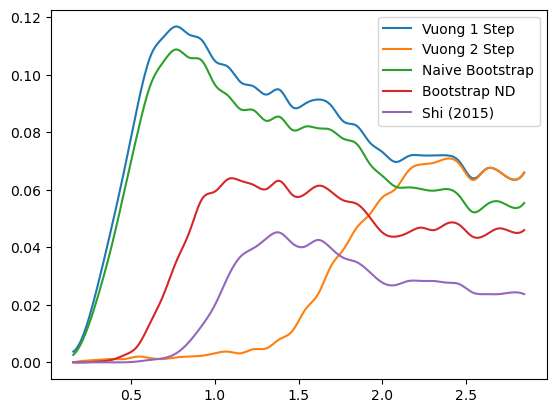

0.02 0.23227910480433808


In [7]:
calc_c =lambda nobs: (nobs**(-1/2)/5, 3*(nobs)**(-5/9))
nobs = 100
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2)
print(c1,c2)

Quantiles: 1th: 0.67, 5th: 1.99, 10th: 3.50, 30th: 10.04, 50th: 17.50, 70th: 27.38, 90th: 43.75, 95th: 52.13, 99th: 67.70
bonus term 2.4346840773304783 // variance stats 9.340420745636193 //part1 23.22791048043381 //part2 9.540420745636194 9.340420745636193
0.4864019950160568 -1.1810237981986311 4.37420252334108
-4.3829661596449 -1.1810237981986311 -0.4951656313198765
---
Quantiles: 1th: 1.08, 5th: 2.75, 10th: 4.62, 30th: 13.64, 50th: 24.03, 70th: 36.34, 90th: 57.78, 95th: 68.89, 99th: 88.50
bonus term 0.7722999577036477 // variance stats 29.876280917455368 //part1 23.22791048043381 //part2 30.07628091745537 29.876280917455368
-1.258752052601601 -0.13772273791609171 2.598289306026954
-2.8033519680088963 -0.13772273791609171 1.0536893906196583
---
Quantiles: 1th: 0.75, 5th: 2.00, 10th: 3.17, 30th: 9.38, 50th: 16.47, 70th: 25.19, 90th: 40.40, 95th: 47.58, 99th: 62.71
bonus term 0.7046658723563779 // variance stats 32.76301324024746 //part1 23.22791048043381 //part2 32.963013240247456 32.

Quantiles: 1th: 0.58, 5th: 1.43, 10th: 2.41, 30th: 6.89, 50th: 12.10, 70th: 18.62, 90th: 28.78, 95th: 34.31, 99th: 44.87
bonus term 6.166413373581288 // variance stats 3.566842907410156 //part1 23.22791048043381 //part2 3.7668429074101564 3.566842907410156
4.028195384888074 -2.1053836210610823 8.076164231726194
-8.304631362274502 -2.1053836210610823 -4.256662515436381
---
Quantiles: 1th: 0.79, 5th: 1.82, 10th: 3.09, 30th: 9.77, 50th: 17.11, 70th: 26.15, 90th: 40.52, 95th: 48.03, 99th: 62.29
bonus term 0.673932847274817 // variance stats 34.26620916959388 //part1 23.22791048043381 //part2 34.46620916959388 34.26620916959388
-1.1871508894270868 0.3166221995144579 2.4769384894503657
-2.5350165839767205 0.3166221995144579 1.1290727949007315
---
Quantiles: 1th: 0.73, 5th: 1.99, 10th: 3.57, 30th: 10.21, 50th: 18.13, 70th: 27.54, 90th: 44.11, 95th: 53.30, 99th: 68.14
bonus term 3.7247279976236514 // variance stats 6.03613603335681 //part1 23.22791048043381 //part2 6.236136033356809 6.03613603

Quantiles: 1th: 0.69, 5th: 1.89, 10th: 3.31, 30th: 9.72, 50th: 17.21, 70th: 26.60, 90th: 42.17, 95th: 50.64, 99th: 68.17
bonus term 0.9583624397629171 // variance stats 24.037083504837696 //part1 23.22791048043381 //part2 24.237083504837695 24.037083504837696
-1.0309550518786161 -0.0537763733998343 2.9830321348636573
-2.94767993140445 -0.0537763733998343 1.066307255337823
---
Quantiles: 1th: 0.76, 5th: 1.80, 10th: 2.98, 30th: 8.48, 50th: 14.57, 70th: 22.64, 90th: 35.37, 95th: 42.14, 99th: 55.78
bonus term 2.1842147018851765 // variance stats 10.434444709298038 //part1 23.22791048043381 //part2 10.63444470929804 10.434444709298038
0.26199654680833234 -0.7118277100655463 4.055478144537941
-4.10643285696202 -0.7118277100655463 -0.31295125923241185
---
Quantiles: 1th: 0.91, 5th: 2.25, 10th: 4.03, 30th: 11.35, 50th: 19.67, 70th: 30.19, 90th: 47.19, 95th: 57.30, 99th: 73.67
bonus term 0.5051293356109123 // variance stats 45.78408534784772 //part1 23.22791048043381 //part2 45.984085347847724 

Quantiles: 1th: 0.82, 5th: 2.00, 10th: 3.33, 30th: 9.70, 50th: 16.80, 70th: 25.70, 90th: 40.14, 95th: 47.40, 99th: 61.51
bonus term 0.5932673623470137 // variance stats 38.95251698415081 //part1 23.22791048043381 //part2 39.152516984150814 38.95251698415081
-1.299689969591305 0.4870229530087601 2.801341968839598
-2.4862246942853323 0.4870229530087601 1.614807244145571
---
Quantiles: 1th: 0.81, 5th: 1.91, 10th: 3.13, 30th: 8.39, 50th: 14.41, 70th: 21.87, 90th: 34.60, 95th: 40.90, 99th: 52.46
bonus term 0.7269607479769139 // variance stats 31.752083444774186 //part1 23.22791048043381 //part2 31.952083444774185 31.752083444774186
-1.2092337032942948 0.4187515735562376 2.7281225921985115
-2.6631551992481226 0.4187515735562376 1.2742010962446841
---
Quantiles: 1th: 0.80, 5th: 1.94, 10th: 3.50, 30th: 10.16, 50th: 17.90, 70th: 27.85, 90th: 44.00, 95th: 52.15, 99th: 68.75
bonus term 1.1772470209490469 // variance stats 19.530702280060517 //part1 23.22791048043381 //part2 19.730702280060516 19.

Quantiles: 1th: 0.56, 5th: 1.58, 10th: 2.73, 30th: 7.52, 50th: 13.13, 70th: 20.05, 90th: 32.49, 95th: 38.78, 99th: 51.44
bonus term 4.189529614529866 // variance stats 5.344276474350775 //part1 23.22791048043381 //part2 5.5442764743507755 5.344276474350775
2.179630756572781 -2.578459276478684 6.104735637827148
-6.199428472486952 -2.578459276478684 -2.2743235912325845
---
Quantiles: 1th: 0.86, 5th: 2.17, 10th: 3.73, 30th: 10.54, 50th: 18.69, 70th: 28.80, 90th: 46.48, 95th: 54.29, 99th: 71.61
bonus term 0.3789167733681706 // variance stats 61.10082412019446 //part1 23.22791048043381 //part2 61.30082412019446 61.10082412019446
-1.685430940053015 0.8591217419712097 2.147734657146508
-2.4432644867893565 0.8591217419712097 1.3899011104101668
---
Quantiles: 1th: 0.69, 5th: 1.71, 10th: 2.85, 30th: 8.21, 50th: 14.25, 70th: 22.10, 90th: 34.46, 95th: 40.60, 99th: 54.51
bonus term 0.7529520832887227 // variance stats 30.649121738238115 //part1 23.22791048043381 //part2 30.849121738238114 30.649121

Quantiles: 1th: 0.82, 5th: 2.33, 10th: 4.02, 30th: 12.24, 50th: 21.39, 70th: 33.24, 90th: 51.80, 95th: 62.33, 99th: 80.92
bonus term 1.014057527517161 // variance stats 22.70591002002174 //part1 23.22791048043381 //part2 22.90591002002174 22.70591002002174
-1.04173149174293 -0.37366266905666795 2.994608288162881
-3.0698465467772516 -0.37366266905666795 0.9664932331285593
---
Quantiles: 1th: 0.73, 5th: 1.82, 10th: 3.32, 30th: 9.79, 50th: 16.93, 70th: 26.02, 90th: 41.70, 95th: 49.06, 99th: 64.77
bonus term 0.9938010633993221 // variance stats 23.17279696701284 //part1 23.22791048043381 //part2 23.37279696701284 23.17279696701284
-1.2834257198603167 -0.2869651522355932 2.835790741668425
-3.271027846658961 -0.2869651522355932 0.8481886148697811
---
Quantiles: 1th: 0.58, 5th: 1.52, 10th: 2.71, 30th: 7.94, 50th: 13.50, 70th: 20.88, 90th: 32.63, 95th: 39.30, 99th: 51.69
bonus term 1.3201837052578533 // variance stats 17.394453247623613 //part1 23.22791048043381 //part2 17.594453247623612 17.3

Quantiles: 1th: 0.72, 5th: 1.99, 10th: 3.47, 30th: 9.68, 50th: 17.14, 70th: 26.43, 90th: 41.03, 95th: 49.37, 99th: 64.42
bonus term 0.5706032874093699 // variance stats 40.50763522217377 //part1 23.22791048043381 //part2 40.707635222173764 40.50763522217377
-1.3741477736440233 0.21135783930567745 2.567771718304118
-2.5153543484627634 0.21135783930567745 1.4265651434853783
---
Quantiles: 1th: 0.81, 5th: 1.94, 10th: 3.47, 30th: 10.74, 50th: 18.80, 70th: 28.74, 90th: 46.18, 95th: 55.01, 99th: 71.72
bonus term 2.71343644332841 // variance stats 8.360329665190728 //part1 23.22791048043381 //part2 8.560329665190729 8.360329665190728
0.6243858427630136 -1.905375506102236 4.434336680242163
-4.802487043893806 -1.905375506102236 -0.9925362064146578
---
Quantiles: 1th: 0.67, 5th: 1.91, 10th: 3.31, 30th: 9.26, 50th: 16.16, 70th: 24.25, 90th: 38.84, 95th: 45.82, 99th: 59.35
bonus term 1.3233478613691314 // variance stats 17.35238449276843 //part1 23.22791048043381 //part2 17.552384492768432 17.3523

Quantiles: 1th: 0.69, 5th: 1.83, 10th: 3.18, 30th: 8.95, 50th: 15.61, 70th: 23.55, 90th: 38.70, 95th: 45.24, 99th: 58.83
bonus term 0.7012983726688929 // variance stats 32.92129527983449 //part1 23.22791048043381 //part2 33.121295279834484 32.92129527983449
-1.0855721645819325 0.17505994056168628 2.7990068007788675
-2.4881689099197186 0.17505994056168628 1.3964100554410812
---
Quantiles: 1th: 0.79, 5th: 2.25, 10th: 4.01, 30th: 11.82, 50th: 20.81, 70th: 31.73, 90th: 50.13, 95th: 60.89, 99th: 79.26
bonus term 4.3208337451077785 // variance stats 5.1757936200932 //part1 23.22791048043381 //part2 5.3757936200932015 5.1757936200932
1.805605857650796 -4.840648931284199 6.411220757463241
-6.836061632564761 -4.840648931284199 -2.2304467327523168
---
Quantiles: 1th: 0.61, 5th: 1.90, 10th: 3.40, 30th: 10.42, 50th: 17.91, 70th: 27.03, 90th: 42.18, 95th: 51.13, 99th: 66.13
bonus term 0.6000266410394364 // variance stats 38.511465277934505 //part1 23.22791048043381 //part2 38.7114652779345 38.51146

Quantiles: 1th: 0.63, 5th: 1.64, 10th: 2.62, 30th: 7.42, 50th: 13.08, 70th: 20.84, 90th: 33.38, 95th: 39.73, 99th: 52.30
bonus term 2.295696225601504 // variance stats 9.918024423875062 //part1 23.22791048043381 //part2 10.11802442387506 9.918024423875062
0.1838709966315905 -2.04750304554288 4.146767177013457
-4.407521454571417 -2.04750304554288 -0.4446252741895511
---
Quantiles: 1th: 0.63, 5th: 1.68, 10th: 2.71, 30th: 7.95, 50th: 13.98, 70th: 21.55, 90th: 33.95, 95th: 40.43, 99th: 53.68
bonus term 0.5888380482464843 // variance stats 39.24702715730546 //part1 23.22791048043381 //part2 39.447027157305456 39.24702715730546
-1.4708562679502482 0.345298291194666 2.5713590562826947
-2.6485323644432173 0.345298291194666 1.3936829597897262
---
Quantiles: 1th: 0.69, 5th: 1.69, 10th: 3.02, 30th: 8.72, 50th: 15.08, 70th: 23.13, 90th: 37.53, 95th: 44.28, 99th: 54.94
bonus term 6.098536853888247 // variance stats 3.608767748222162 //part1 23.22791048043381 //part2 3.808767748222162 3.608767748222

Quantiles: 1th: 0.64, 5th: 1.71, 10th: 2.83, 30th: 7.85, 50th: 13.78, 70th: 21.66, 90th: 33.61, 95th: 40.43, 99th: 53.44
bonus term 1.371186025803875 // variance stats 16.74001400489489 //part1 23.22791048043381 //part2 16.94001400489489 16.74001400489489
-0.6596340132283987 -1.0016477433326578 3.1484823930950996
-3.4020060648361485 -1.0016477433326578 0.40611034148734926
---
Quantiles: 1th: 0.71, 5th: 1.83, 10th: 3.04, 30th: 9.07, 50th: 15.41, 70th: 23.74, 90th: 38.49, 95th: 46.01, 99th: 60.96
bonus term 0.9635696208057142 // variance stats 23.90610502748227 //part1 23.22791048043381 //part2 24.10610502748227 23.90610502748227
-0.9677986892324331 -0.7903520957802979 3.000742647028254
-2.894937930843861 -0.7903520957802979 1.0736034054168258
---
Quantiles: 1th: 0.78, 5th: 1.86, 10th: 3.41, 30th: 10.69, 50th: 19.23, 70th: 29.74, 90th: 46.93, 95th: 55.99, 99th: 72.88
bonus term 1.4129341486512048 // variance stats 16.23948552210116 //part1 23.22791048043381 //part2 16.43948552210116 16.2

Quantiles: 1th: 0.59, 5th: 1.57, 10th: 2.44, 30th: 7.38, 50th: 13.09, 70th: 20.49, 90th: 32.61, 95th: 38.71, 99th: 50.75
bonus term 0.7587929149383185 // variance stats 30.411659680984215 //part1 23.22791048043381 //part2 30.611659680984214 30.411659680984215
-1.1100650196289272 -0.17877178067552602 2.7459961154805703
-2.627650849505564 -0.17877178067552602 1.2284102856039332
---
Quantiles: 1th: 0.68, 5th: 1.90, 10th: 3.17, 30th: 9.21, 50th: 15.84, 70th: 25.21, 90th: 40.62, 95th: 47.66, 99th: 62.38
bonus term 1.553388134306649 // variance stats 14.753062900021142 //part1 23.22791048043381 //part2 14.953062900021141 14.753062900021142
-0.4996438997719379 -1.6123570343885085 3.552073226338923
-3.6064201683852355 -1.6123570343885085 0.44529695772562544
---
Quantiles: 1th: 0.74, 5th: 1.94, 10th: 3.33, 30th: 9.64, 50th: 17.00, 70th: 25.98, 90th: 41.19, 95th: 48.19, 99th: 63.60
bonus term 0.7857238102753188 // variance stats 29.362436796073055 //part1 23.22791048043381 //part2 29.56243679607

Quantiles: 1th: 0.72, 5th: 1.75, 10th: 2.94, 30th: 8.62, 50th: 14.94, 70th: 22.72, 90th: 35.71, 95th: 42.80, 99th: 56.72
bonus term 0.747768661913356 // variance stats 30.862963271286738 //part1 23.22791048043381 //part2 31.06296327128674 30.862963271286738
-1.240321770714841 -0.27004242224479114 2.5700937076472536
-2.735859094541553 -0.27004242224479114 1.0745563838205416
---
Quantiles: 1th: 0.78, 5th: 2.03, 10th: 3.64, 30th: 11.03, 50th: 19.55, 70th: 29.78, 90th: 46.70, 95th: 56.61, 99th: 76.09
bonus term 0.6258413530577168 // variance stats 36.91469427027726 //part1 23.22791048043381 //part2 37.114694270277255 36.91469427027726
-1.465891568660537 -0.28354285857779665 2.6413885942984243
-2.7175742747759704 -0.28354285857779665 1.3897058881829911
---
Quantiles: 1th: 0.73, 5th: 2.10, 10th: 3.94, 30th: 11.89, 50th: 21.04, 70th: 32.28, 90th: 49.37, 95th: 58.56, 99th: 76.50
bonus term 3.4958727608773894 // variance stats 6.444380979874136 //part1 23.22791048043381 //part2 6.64438097987413

Quantiles: 1th: 0.59, 5th: 1.76, 10th: 2.96, 30th: 7.97, 50th: 14.09, 70th: 21.05, 90th: 34.10, 95th: 41.21, 99th: 55.47
bonus term 2.276415066164331 // variance stats 10.00372375217667 //part1 23.22791048043381 //part2 10.20372375217667 10.00372375217667
-0.026940032584441376 -3.250067148906794 4.230270602306384
-4.5797701649131035 -3.250067148906794 -0.32255953002227766
---
Quantiles: 1th: 0.78, 5th: 1.84, 10th: 3.15, 30th: 9.05, 50th: 16.09, 70th: 25.15, 90th: 39.97, 95th: 47.93, 99th: 63.51
bonus term 0.6925358651577214 // variance stats 33.34037191293157 //part1 23.22791048043381 //part2 33.540371912931576 33.34037191293157
-1.5546270803205484 -0.3393858340336941 2.529745306951793
-2.939698810635991 -0.3393858340336941 1.1446735766363505
---
Quantiles: 1th: 0.75, 5th: 1.77, 10th: 3.15, 30th: 9.66, 50th: 16.75, 70th: 24.85, 90th: 39.37, 95th: 46.10, 99th: 59.60
bonus term 1.0587923957690566 // variance stats 21.738116077573597 //part1 23.22791048043381 //part2 21.938116077573596 21

Quantiles: 1th: 0.73, 5th: 1.78, 10th: 2.80, 30th: 7.70, 50th: 13.56, 70th: 20.58, 90th: 32.91, 95th: 39.35, 99th: 52.10
bonus term 1.262777449169587 // variance stats 18.194302571453647 //part1 23.22791048043381 //part2 18.394302571453647 18.194302571453647
-0.5552984707352228 -1.4933946505464746 3.302437147110225
-3.0808533690743967 -1.4933946505464746 0.7768822487710514
---
Quantiles: 1th: 0.76, 5th: 2.09, 10th: 3.45, 30th: 9.88, 50th: 17.18, 70th: 26.64, 90th: 42.24, 95th: 49.86, 99th: 63.80
bonus term 0.6679329806435811 // variance stats 34.575810079108166 //part1 23.22791048043381 //part2 34.77581007910817 34.575810079108166
-1.1953400436077835 -0.5345777894472489 2.7106663699857347
-2.5312060048949454 -0.5345777894472489 1.3748004086985728
---
Quantiles: 1th: 0.72, 5th: 1.80, 10th: 3.12, 30th: 8.75, 50th: 15.39, 70th: 23.29, 90th: 36.55, 95th: 43.17, 99th: 58.76
bonus term 0.7063449564144727 // variance stats 32.6846553932269 //part1 23.22791048043381 //part2 32.8846553932269 32

Quantiles: 1th: 0.86, 5th: 2.02, 10th: 3.22, 30th: 8.98, 50th: 15.88, 70th: 24.31, 90th: 39.22, 95th: 46.66, 99th: 62.55
bonus term 0.3379972814997439 // variance stats 68.52218136598063 //part1 23.22791048043381 //part2 68.72218136598063 68.52218136598063
-1.71373850467067 0.5630458115993852 2.2128375685086605
-2.389733067670158 0.5630458115993852 1.5368430055091724
---
Quantiles: 1th: 0.61, 5th: 1.73, 10th: 2.81, 30th: 8.47, 50th: 14.94, 70th: 23.02, 90th: 36.37, 95th: 43.59, 99th: 56.63
bonus term 0.5223301129788361 // variance stats 44.26979008727947 //part1 23.22791048043381 //part2 44.46979008727946 44.26979008727947
-1.5672114336537313 -0.02656261268445199 2.432362836203726
-2.6118716596114036 -0.02656261268445199 1.387702610246054
---
Quantiles: 1th: 0.68, 5th: 1.84, 10th: 3.36, 30th: 10.09, 50th: 17.39, 70th: 26.37, 90th: 41.39, 95th: 49.36, 99th: 64.99
bonus term 1.4905350315495907 // variance stats 15.383605878947774 //part1 23.22791048043381 //part2 15.583605878947775 15.38

Quantiles: 1th: 0.62, 5th: 1.72, 10th: 3.09, 30th: 8.92, 50th: 16.11, 70th: 24.15, 90th: 37.64, 95th: 44.58, 99th: 60.40
bonus term 2.0406135676976405 // variance stats 11.18280703810135 //part1 23.22791048043381 //part2 11.382807038101351 11.18280703810135
0.11967237695727119 -4.309269447904434 4.094719997162641
-3.9615547584380097 -4.309269447904434 0.013492861767360415
---
Quantiles: 1th: 0.76, 5th: 2.01, 10th: 3.45, 30th: 10.07, 50th: 17.86, 70th: 27.73, 90th: 44.18, 95th: 52.23, 99th: 69.64
bonus term 0.9992282326156255 // variance stats 23.045850869957274 //part1 23.22791048043381 //part2 23.245850869957273 23.045850869957274
-0.9584438286901148 -1.7158971254018072 3.018624456742463
-2.956900293921366 -1.7158971254018072 1.0201679915112123
---
Quantiles: 1th: 0.70, 5th: 1.99, 10th: 3.62, 30th: 11.08, 50th: 19.18, 70th: 29.39, 90th: 46.36, 95th: 54.86, 99th: 73.67
bonus term 1.811224952379177 // variance stats 12.624420539216976 //part1 23.22791048043381 //part2 12.824420539216977

Quantiles: 1th: 0.76, 5th: 1.86, 10th: 3.01, 30th: 8.47, 50th: 14.87, 70th: 23.26, 90th: 35.96, 95th: 42.86, 99th: 55.61
bonus term 0.880263968092089 // variance stats 26.18743754419335 //part1 23.22791048043381 //part2 26.387437544193354 26.18743754419335
-1.1477226015355149 -1.0922351867546558 2.7914727594022506
-2.908250537719693 -1.0922351867546558 1.0309448232180725
---
Quantiles: 1th: 0.77, 5th: 1.81, 10th: 3.11, 30th: 8.85, 50th: 15.25, 70th: 23.45, 90th: 37.38, 95th: 45.17, 99th: 59.98
bonus term 0.6064159709363881 // variance stats 38.1035929026849 //part1 23.22791048043381 //part2 38.303592902684905 38.1035929026849
-1.3932547902130448 -0.3331415134455398 2.5309225931871664
-2.606086732085821 -0.3331415134455398 1.3180906513143904
---
Quantiles: 1th: 0.79, 5th: 2.27, 10th: 4.11, 30th: 11.86, 50th: 20.85, 70th: 31.33, 90th: 49.41, 95th: 60.65, 99th: 79.33
bonus term 2.3023378458340886 // variance stats 9.888836667678035 //part1 23.22791048043381 //part2 10.088836667678034 9.88

Quantiles: 1th: 0.74, 5th: 2.05, 10th: 3.68, 30th: 10.19, 50th: 17.84, 70th: 27.34, 90th: 43.08, 95th: 51.45, 99th: 67.65
bonus term 1.4573668962552868 // variance stats 15.738272332189009 //part1 23.22791048043381 //part2 15.93827233218901 15.738272332189009
-0.5088383088836321 -4.128295074793969 3.353362725331611
-3.423572101394206 -4.128295074793969 0.43862893282103727
---
Quantiles: 1th: 0.67, 5th: 1.93, 10th: 3.63, 30th: 10.95, 50th: 19.34, 70th: 29.61, 90th: 47.08, 95th: 56.25, 99th: 73.21
bonus term 0.8994503136946412 // variance stats 25.62456209840132 //part1 23.22791048043381 //part2 25.82456209840132 25.62456209840132
-1.3663354502481744 -2.4666257816332493 2.7706488295555602
-3.165236077637457 -2.4666257816332493 0.9717482021662779
---
Quantiles: 1th: 0.77, 5th: 2.30, 10th: 3.95, 30th: 12.28, 50th: 21.22, 70th: 32.62, 90th: 52.96, 95th: 61.80, 99th: 83.42
bonus term 0.9021956577713068 // variance stats 25.545979023900088 //part1 23.22791048043381 //part2 25.745979023900087 

Quantiles: 1th: 0.68, 5th: 1.89, 10th: 3.35, 30th: 10.34, 50th: 17.67, 70th: 27.04, 90th: 43.33, 95th: 50.77, 99th: 68.18
bonus term 0.6806083718206283 // variance stats 33.9281586329876 //part1 23.22791048043381 //part2 34.1281586329876 33.9281586329876
-1.306952602064972 -1.2776764331828174 2.5656847036690684
-2.6681693457062283 -1.2776764331828174 1.2044679600278119
---
Quantiles: 1th: 0.64, 5th: 1.63, 10th: 2.80, 30th: 8.66, 50th: 15.12, 70th: 23.10, 90th: 36.78, 95th: 44.35, 99th: 56.86
bonus term 0.7761363690621704 // variance stats 29.7276150510777 //part1 23.22791048043381 //part2 29.9276150510777 29.7276150510777
-1.3258310026102076 -1.5473367556030442 2.85125517495881
-2.878103740734548 -1.5473367556030442 1.2989824368344698
---
Quantiles: 1th: 0.59, 5th: 1.50, 10th: 2.71, 30th: 8.35, 50th: 14.92, 70th: 22.66, 90th: 35.68, 95th: 43.02, 99th: 57.59
bonus term 0.6198304957079221 // variance stats 37.27461707882684 //part1 23.22791048043381 //part2 37.474617078826846 37.27461707

Quantiles: 1th: 0.69, 5th: 1.79, 10th: 3.06, 30th: 9.06, 50th: 16.18, 70th: 25.26, 90th: 40.40, 95th: 47.39, 99th: 61.69
bonus term 0.46080965925567385 // variance stats 50.20673521894672 //part1 23.22791048043381 //part2 50.406735218946714 50.20673521894672
-1.4611371819032182 -0.3125865717086503 2.4871024810718247
-2.382756500414566 -0.3125865717086503 1.565483162560477
---
Quantiles: 1th: 0.53, 5th: 1.42, 10th: 2.65, 30th: 7.00, 50th: 12.50, 70th: 19.40, 90th: 31.14, 95th: 37.20, 99th: 47.55
bonus term 1.381401081586502 // variance stats 16.61474757045736 //part1 23.22791048043381 //part2 16.814747570457364 16.61474757045736
-0.8825978556433989 -3.113501547282062 3.3846053750561245
-3.6454000188164026 -3.113501547282062 0.6218032118831199
---
Quantiles: 1th: 0.59, 5th: 1.54, 10th: 2.80, 30th: 7.98, 50th: 13.68, 70th: 21.36, 90th: 33.85, 95th: 39.92, 99th: 50.43
bonus term 1.4053012990802964 // variance stats 16.328776067904712 //part1 23.22791048043381 //part2 16.528776067904715 16.

Quantiles: 1th: 0.64, 5th: 1.80, 10th: 3.22, 30th: 9.47, 50th: 16.86, 70th: 25.20, 90th: 40.17, 95th: 48.10, 99th: 62.34
bonus term 2.000620591612938 // variance stats 11.410352596494587 //part1 23.22791048043381 //part2 11.610352596494586 11.410352596494587
-0.4534089926761752 -7.5499926465936396 4.1162038052706444
-4.454650175902051 -7.5499926465936396 0.11496262204476876
---
Quantiles: 1th: 0.60, 5th: 1.60, 10th: 2.85, 30th: 8.82, 50th: 15.05, 70th: 23.12, 90th: 37.08, 95th: 43.29, 99th: 56.59
bonus term 0.4633844479120978 // variance stats 49.92665095924853 //part1 23.22791048043381 //part2 50.12665095924853 49.92665095924853
-1.5811154542396204 -0.5467850873510957 2.221441741252534
-2.507884350063816 -0.5467850873510957 1.2946728454283385
---
Quantiles: 1th: 0.64, 5th: 1.80, 10th: 3.41, 30th: 10.17, 50th: 18.43, 70th: 28.87, 90th: 45.37, 95th: 53.32, 99th: 72.89
bonus term 1.4704404939982811 // variance stats 15.596566114195276 //part1 23.22791048043381 //part2 15.796566114195276 

Quantiles: 1th: 0.63, 5th: 1.74, 10th: 3.05, 30th: 8.97, 50th: 15.76, 70th: 23.96, 90th: 37.56, 95th: 44.91, 99th: 59.33
bonus term 1.7539522644145502 // variance stats 13.043182811584115 //part1 23.22791048043381 //part2 13.243182811584116 13.043182811584115
-0.4957274670615646 -6.094171431304814 3.7274367615562025
-4.0036319958906645 -6.094171431304814 0.21953223272710218
---
Quantiles: 1th: 0.66, 5th: 1.78, 10th: 3.16, 30th: 9.38, 50th: 16.14, 70th: 24.91, 90th: 39.45, 95th: 46.77, 99th: 60.43
bonus term 1.150009721459899 // variance stats 19.998012283710743 //part1 23.22791048043381 //part2 20.198012283710742 19.998012283710743
-1.0316129818725357 -3.9493775941663714 3.06212279773838
-3.3316324247923332 -3.9493775941663714 0.7621033548185817
---
Quantiles: 1th: 0.69, 5th: 2.04, 10th: 3.88, 30th: 12.03, 50th: 21.30, 70th: 33.05, 90th: 51.31, 95th: 61.01, 99th: 80.00
bonus term 1.789683888791253 // variance stats 12.778778333933525 //part1 23.22791048043381 //part2 12.978778333933525

Quantiles: 1th: 0.70, 5th: 1.88, 10th: 3.42, 30th: 9.67, 50th: 16.86, 70th: 25.94, 90th: 41.24, 95th: 50.14, 99th: 65.01
bonus term 0.9975052304213183 // variance stats 23.086003694058817 //part1 23.22791048043381 //part2 23.286003694058817 23.086003694058817
-1.1489858996795894 -3.8974302151545386 3.002627643111198
-3.1439963605222263 -3.8974302151545386 1.0076171822685616
---
Quantiles: 1th: 0.77, 5th: 1.96, 10th: 3.48, 30th: 10.40, 50th: 18.56, 70th: 29.14, 90th: 45.71, 95th: 54.06, 99th: 72.56
bonus term 0.7960791469885109 // variance stats 28.97789087718565 //part1 23.22791048043381 //part2 29.177890877185654 28.97789087718565
-1.0661191836183341 -3.08469632972895 2.6636826709461774
-2.6582774775953557 -3.08469632972895 1.0715243769691556
---
Quantiles: 1th: 0.79, 5th: 1.92, 10th: 3.46, 30th: 9.88, 50th: 17.13, 70th: 26.35, 90th: 41.78, 95th: 49.43, 99th: 62.78
bonus term 0.8558426852718706 // variance stats 26.940397271789656 //part1 23.22791048043381 //part2 27.140397271789656 2

Quantiles: 1th: 0.94, 5th: 2.28, 10th: 4.23, 30th: 12.43, 50th: 21.66, 70th: 33.36, 90th: 52.21, 95th: 62.85, 99th: 84.58
bonus term 0.8645592624127985 // variance stats 26.66676494056604 //part1 23.22791048043381 //part2 26.86676494056604 26.66676494056604
-1.5979514007208933 -3.699989438485596 2.8215133612823204
-3.32706992554649 -3.699989438485596 1.0923948364567238
---
Quantiles: 1th: 0.72, 5th: 1.97, 10th: 3.46, 30th: 10.14, 50th: 17.85, 70th: 27.04, 90th: 42.89, 95th: 51.30, 99th: 67.23
bonus term 1.2680021712211706 // variance stats 18.118510021212174 //part1 23.22791048043381 //part2 18.318510021212173 18.118510021212174
-0.9933924592928197 -5.184841046744182 3.234187006044956
-3.529396801735161 -5.184841046744182 0.6981826636026145
---
Quantiles: 1th: 0.69, 5th: 1.93, 10th: 3.26, 30th: 9.51, 50th: 17.38, 70th: 26.58, 90th: 42.32, 95th: 50.20, 99th: 64.46
bonus term 1.2862594562633536 // variance stats 17.858495404894455 //part1 23.22791048043381 //part2 18.058495404894455 17.8

Quantiles: 1th: 0.68, 5th: 1.80, 10th: 3.16, 30th: 9.69, 50th: 17.28, 70th: 26.90, 90th: 42.74, 95th: 50.01, 99th: 66.36
bonus term 0.8592780500744331 // variance stats 26.83189087446344 //part1 23.22791048043381 //part2 27.03189087446344 26.83189087446344
-1.3154461461949996 -2.7788487124968917 2.761962692667694
-3.0340022463438663 -2.7788487124968917 1.0434065925188272
---
Quantiles: 1th: 0.69, 5th: 1.67, 10th: 3.03, 30th: 9.41, 50th: 16.21, 70th: 25.82, 90th: 41.49, 95th: 48.88, 99th: 64.78
bonus term 0.528265306808585 // variance stats 43.77016079053316 //part1 23.22791048043381 //part2 43.97016079053316 43.77016079053316
-1.402672266754822 -1.4901371628887206 2.430363759135071
-2.459202880371992 -1.4901371628887206 1.3738331455179011
---
Quantiles: 1th: 0.70, 5th: 1.82, 10th: 3.08, 30th: 9.29, 50th: 16.32, 70th: 24.61, 90th: 39.14, 95th: 47.55, 99th: 62.07
bonus term 1.352914011337179 // variance stats 16.968800297571057 //part1 23.22791048043381 //part2 17.168800297571057 16.9688

Quantiles: 1th: 0.56, 5th: 1.31, 10th: 2.31, 30th: 6.64, 50th: 11.37, 70th: 18.33, 90th: 28.95, 95th: 34.47, 99th: 45.93
bonus term 0.7439968952574378 // variance stats 31.0204400697082 //part1 23.22791048043381 //part2 31.220440069708204 31.0204400697082
-1.3080095808110113 -2.728209443793071 2.755933783363366
-2.7960033713258867 -2.728209443793071 1.2679399928484905
---
Quantiles: 1th: 0.65, 5th: 1.73, 10th: 2.77, 30th: 8.22, 50th: 14.68, 70th: 22.33, 90th: 36.56, 95th: 42.90, 99th: 56.48
bonus term 1.4990940266370634 // variance stats 15.29463213627852 //part1 23.22791048043381 //part2 15.494632136278518 15.29463213627852
-0.8752111376517682 -7.4767702899836745 3.5901703429061906
-3.873399190925895 -7.4767702899836745 0.5919822896320638
---
Quantiles: 1th: 0.81, 5th: 1.92, 10th: 3.31, 30th: 9.09, 50th: 15.72, 70th: 23.81, 90th: 37.67, 95th: 44.59, 99th: 60.10
bonus term 1.0655625771803618 // variance stats 21.5987295893014 //part1 23.22791048043381 //part2 21.7987295893014 21.598729

Quantiles: 1th: 0.58, 5th: 1.54, 10th: 2.74, 30th: 7.93, 50th: 13.94, 70th: 21.02, 90th: 33.46, 95th: 40.36, 99th: 52.23
bonus term 1.4538535345696848 // variance stats 15.77678853345352 //part1 23.22791048043381 //part2 15.976788533453519 15.77678853345352
-0.9259881380418172 -6.950686047261268 3.596817234652227
-3.833695207181187 -6.950686047261268 0.6891101655128573
---
Quantiles: 1th: 0.71, 5th: 2.09, 10th: 3.88, 30th: 11.33, 50th: 19.48, 70th: 30.17, 90th: 47.53, 95th: 55.64, 99th: 73.70
bonus term 1.0926596352262603 // variance stats 21.05813906873565 //part1 23.22791048043381 //part2 21.25813906873565 21.05813906873565
-1.4640617684612118 -7.021557911623031 3.2854972284213693
-3.6493810389137327 -7.021557911623031 1.1001779579688487
---
Quantiles: 1th: 0.72, 5th: 2.08, 10th: 3.70, 30th: 10.64, 50th: 18.66, 70th: 28.66, 90th: 45.38, 95th: 53.88, 99th: 70.82
bonus term 1.0561550280974215 // variance stats 21.79289863939485 //part1 23.22791048043381 //part2 21.992898639394852 21.79

Quantiles: 1th: 0.60, 5th: 1.58, 10th: 2.65, 30th: 7.86, 50th: 13.81, 70th: 21.08, 90th: 33.20, 95th: 39.56, 99th: 53.42
bonus term 1.0058435324636474 // variance stats 22.892965984024258 //part1 23.22791048043381 //part2 23.092965984024257 22.892965984024258
-1.3084576139090276 -5.735450747799503 2.9115227066121676
-3.3201446788363222 -5.735450747799503 0.8998356416848728
---
Quantiles: 1th: 0.69, 5th: 2.17, 10th: 3.76, 30th: 10.97, 50th: 19.82, 70th: 30.96, 90th: 47.53, 95th: 57.39, 99th: 74.71
bonus term 1.2823520902709102 // variance stats 17.91352019204544 //part1 23.22791048043381 //part2 18.11352019204544 17.91352019204544
-1.1442551267189967 -6.972542606764709 3.214807131648021
-3.708959307260817 -6.972542606764709 0.6501029511062003
---
Quantiles: 1th: 0.77, 5th: 2.07, 10th: 3.91, 30th: 12.08, 50th: 20.51, 70th: 31.92, 90th: 49.75, 95th: 58.67, 99th: 79.43
bonus term 0.6470526230900837 // variance stats 35.69802382610847 //part1 23.22791048043381 //part2 35.89802382610847 35.6

Quantiles: 1th: 0.92, 5th: 2.32, 10th: 4.18, 30th: 12.92, 50th: 22.29, 70th: 34.29, 90th: 54.46, 95th: 64.78, 99th: 85.49
bonus term 1.0732300225082776 // variance stats 21.44299357387261 //part1 23.22791048043381 //part2 21.64299357387261 21.44299357387261
-1.218495938525663 -8.223272767627693 3.003503812301795
-3.364955983542218 -8.223272767627693 0.8570437672852398
---
Quantiles: 1th: 0.84, 5th: 2.23, 10th: 3.97, 30th: 11.48, 50th: 20.01, 70th: 30.08, 90th: 48.92, 95th: 58.18, 99th: 76.26
bonus term 0.9544400427751737 // variance stats 24.13668898980314 //part1 23.22791048043381 //part2 24.336688989803143 24.13668898980314
-1.6073364387957503 -7.358576309561469 3.1404949760003777
-3.516216524346097 -7.358576309561469 1.2316148904500306
---
Quantiles: 1th: 0.77, 5th: 1.86, 10th: 3.08, 30th: 9.18, 50th: 16.01, 70th: 24.89, 90th: 39.30, 95th: 46.65, 99th: 61.00
bonus term 0.8329775375535925 // variance stats 27.6853983849947 //part1 23.22791048043381 //part2 27.8853983849947 27.6853983

Quantiles: 1th: 0.63, 5th: 1.71, 10th: 3.10, 30th: 9.00, 50th: 15.76, 70th: 23.98, 90th: 38.45, 95th: 45.62, 99th: 58.52
bonus term 0.726141094103432 // variance stats 31.78815033201414 //part1 23.22791048043381 //part2 31.988150332014143 31.78815033201414
-1.3751252419045377 -4.893100920007867 2.5979707597008233
-2.827407430111401 -4.893100920007867 1.1456885714939593
---
Quantiles: 1th: 0.71, 5th: 1.72, 10th: 2.88, 30th: 8.53, 50th: 14.89, 70th: 23.14, 90th: 35.75, 95th: 42.07, 99th: 53.35
bonus term 1.0426323880089678 // variance stats 22.078140164809483 //part1 23.22791048043381 //part2 22.278140164809482 22.078140164809483
-1.0759038545409751 -6.561506404529755 3.0754604887040258
-3.161168630558911 -6.561506404529755 0.9901957126860899
---
Quantiles: 1th: 0.82, 5th: 2.13, 10th: 3.66, 30th: 10.93, 50th: 18.77, 70th: 29.01, 90th: 46.09, 95th: 55.34, 99th: 71.87
bonus term 0.941718882393855 // variance stats 24.465439883066082 //part1 23.22791048043381 //part2 24.66543988306608 24.46

Quantiles: 1th: 0.65, 5th: 1.75, 10th: 3.29, 30th: 9.94, 50th: 17.12, 70th: 26.37, 90th: 41.78, 95th: 49.94, 99th: 65.38
bonus term 1.097309544990229 // variance stats 20.968056531068125 //part1 23.22791048043381 //part2 21.168056531068125 20.968056531068125
-1.6386155052033575 -7.865211591865322 3.408596447771036
-3.8332345951838156 -7.865211591865322 1.2139773577905777
---
Quantiles: 1th: 0.77, 5th: 2.01, 10th: 3.60, 30th: 11.08, 50th: 19.49, 70th: 29.78, 90th: 46.80, 95th: 56.34, 99th: 73.51
bonus term 0.8154499769285917 // variance stats 28.284776672533845 //part1 23.22791048043381 //part2 28.484776672533844 28.284776672533845
-1.4376248078755172 -5.950305105189542 2.8156159701466295
-3.0685247617327 -5.950305105189542 1.184716016289446
---
Quantiles: 1th: 0.66, 5th: 1.78, 10th: 3.18, 30th: 9.72, 50th: 16.82, 70th: 25.77, 90th: 40.02, 95th: 47.81, 99th: 64.30
bonus term 1.66746684597265 // variance stats 13.73005836160103 //part1 23.22791048043381 //part2 13.93005836160103 13.73005

Quantiles: 1th: 0.70, 5th: 1.87, 10th: 3.41, 30th: 10.09, 50th: 17.59, 70th: 27.06, 90th: 42.96, 95th: 50.62, 99th: 67.06
bonus term 1.1737695937288912 // variance stats 19.58915675149004 //part1 23.22791048043381 //part2 19.78915675149004 19.58915675149004
-1.2596702983627626 -9.77357601667481 3.1107116857597323
-3.607209485820545 -9.77357601667481 0.7631724983019502
---
Quantiles: 1th: 0.73, 5th: 1.89, 10th: 3.28, 30th: 9.58, 50th: 16.62, 70th: 24.84, 90th: 39.63, 95th: 46.30, 99th: 58.61
bonus term 1.1293281065078946 // variance stats 20.367902584359733 //part1 23.22791048043381 //part2 20.567902584359736 20.367902584359733
-1.2129318929833839 -7.623148001168989 3.1149671940857866
-3.471588105999173 -7.623148001168989 0.8563109810699975
---
Quantiles: 1th: 0.71, 5th: 2.16, 10th: 3.86, 30th: 11.51, 50th: 20.21, 70th: 31.05, 90th: 49.97, 95th: 59.54, 99th: 77.28
bonus term 0.41138785412556106 // variance stats 56.26231469280165 //part1 23.22791048043381 //part2 56.462314692801655 56.2

Quantiles: 1th: 0.67, 5th: 1.67, 10th: 2.91, 30th: 8.54, 50th: 15.07, 70th: 23.07, 90th: 36.78, 95th: 43.58, 99th: 57.84
bonus term 1.2794362138062914 // variance stats 17.95480148973691 //part1 23.22791048043381 //part2 18.154801489736908 17.95480148973691
-1.2990742828020285 -10.3958718055682 3.3346907957004173
-3.8579467104146112 -10.3958718055682 0.7758183680878346
---
Quantiles: 1th: 0.75, 5th: 1.98, 10th: 3.83, 30th: 10.72, 50th: 18.46, 70th: 28.60, 90th: 44.52, 95th: 53.36, 99th: 70.56
bonus term 0.7835970551607987 // variance stats 29.442671992517006 //part1 23.22791048043381 //part2 29.642671992517005 29.442671992517006
-1.7990908982393479 -6.940079568048873 2.9364740208075775
-3.3662850085609457 -6.940079568048873 1.3692799104859799
---
Quantiles: 1th: 0.81, 5th: 2.03, 10th: 3.68, 30th: 10.31, 50th: 17.87, 70th: 27.72, 90th: 43.61, 95th: 52.25, 99th: 67.98
bonus term 0.903033183213656 // variance stats 25.52210070705467 //part1 23.22791048043381 //part2 25.72210070705467 25.5

Quantiles: 1th: 0.75, 5th: 1.93, 10th: 3.22, 30th: 8.82, 50th: 15.37, 70th: 23.63, 90th: 36.84, 95th: 44.22, 99th: 58.69
bonus term 1.2092323662667968 // variance stats 19.008806453092376 //part1 23.22791048043381 //part2 19.20880645309238 19.008806453092376
-1.175832487257285 -9.341972491331761 3.213500696072712
-3.594297219790878 -9.341972491331761 0.7950359635391189
---
Quantiles: 1th: 0.80, 5th: 2.02, 10th: 3.57, 30th: 10.33, 50th: 18.15, 70th: 28.03, 90th: 44.21, 95th: 52.02, 99th: 69.12
bonus term 1.2224358812509926 // variance stats 18.80133236981173 //part1 23.22791048043381 //part2 19.001332369811728 18.80133236981173
-0.8919023881626229 -9.093174670013015 3.1552417209046393
-3.336774150664608 -9.093174670013015 0.7103699584026543
---
Quantiles: 1th: 0.75, 5th: 1.86, 10th: 3.14, 30th: 8.62, 50th: 15.00, 70th: 23.31, 90th: 36.78, 95th: 44.02, 99th: 56.82
bonus term 0.4236421014212844 // variance stats 54.629088994002444 //part1 23.22791048043381 //part2 54.82908899400244 54.629

Quantiles: 1th: 0.84, 5th: 1.90, 10th: 3.23, 30th: 9.21, 50th: 16.02, 70th: 24.61, 90th: 39.53, 95th: 46.59, 99th: 61.93
bonus term 0.7063994166537718 // variance stats 32.68212013320295 //part1 23.22791048043381 //part2 32.882120133202946 32.68212013320295
-1.7327628034257307 -5.235282927190434 2.7622286126149627
-3.1455616367332744 -5.235282927190434 1.349429779307419
---
Quantiles: 1th: 0.80, 5th: 2.00, 10th: 3.68, 30th: 10.93, 50th: 19.39, 70th: 30.15, 90th: 47.32, 95th: 56.94, 99th: 73.02
bonus term 1.0551420220652994 // variance stats 21.814013274694794 //part1 23.22791048043381 //part2 22.014013274694793 21.814013274694794
-2.0055828758488996 -9.527418184689791 3.451570960903347
-4.115866919979498 -9.527418184689791 1.341286916772748
---
Quantiles: 1th: 0.78, 5th: 1.85, 10th: 3.49, 30th: 10.85, 50th: 19.13, 70th: 29.64, 90th: 46.99, 95th: 55.90, 99th: 71.54
bonus term 0.5852648985076675 // variance stats 39.487858505885605 //part1 23.22791048043381 //part2 39.68785850588561 39.4

Quantiles: 1th: 0.62, 5th: 1.76, 10th: 3.16, 30th: 9.11, 50th: 15.63, 70th: 23.98, 90th: 38.75, 95th: 46.47, 99th: 61.93
bonus term 0.8119236074215426 // variance stats 28.408492557815368 //part1 23.22791048043381 //part2 28.608492557815367 28.408492557815368
-1.538008997981422 -6.501499859996695 2.6372930263140164
-3.161856212824507 -6.501499859996695 1.013445811470931
---
Quantiles: 1th: 0.62, 5th: 1.48, 10th: 2.56, 30th: 7.38, 50th: 12.98, 70th: 19.74, 90th: 31.06, 95th: 37.10, 99th: 48.56
bonus term 0.687438875210893 // variance stats 33.58905575176838 //part1 23.22791048043381 //part2 33.78905575176838 33.58905575176838
-1.724223611981193 -5.921883344475781 2.7913721753982155
-3.099101362402979 -5.921883344475781 1.4164944249764295
---
Quantiles: 1th: 0.71, 5th: 1.72, 10th: 3.10, 30th: 9.79, 50th: 16.80, 70th: 25.18, 90th: 40.01, 95th: 47.86, 99th: 63.87
bonus term 0.39023114352458455 // variance stats 59.32346670908508 //part1 23.22791048043381 //part2 59.52346670908508 59.323466

Quantiles: 1th: 0.75, 5th: 1.76, 10th: 3.04, 30th: 8.66, 50th: 15.22, 70th: 23.71, 90th: 37.33, 95th: 44.35, 99th: 57.05
bonus term 0.6687755149744364 // variance stats 34.53199894485025 //part1 23.22791048043381 //part2 34.73199894485025 34.53199894485025
-1.4759017725868193 -6.709364528834244 2.5039189826635186
-2.8134528025356924 -6.709364528834244 1.1663679527146456
---
Quantiles: 1th: 0.72, 5th: 2.11, 10th: 3.97, 30th: 12.25, 50th: 21.34, 70th: 32.98, 90th: 53.04, 95th: 63.40, 99th: 82.11
bonus term 0.6088491666455488 // variance stats 37.950516996529466 //part1 23.22791048043381 //part2 38.15051699652947 37.950516996529466
-1.8293757444507035 -6.799582855137135 2.65635606991929
-3.047074077741801 -6.799582855137135 1.4386577366281925
---
Quantiles: 1th: 0.84, 5th: 2.16, 10th: 3.96, 30th: 11.77, 50th: 20.14, 70th: 31.21, 90th: 48.79, 95th: 57.43, 99th: 74.96
bonus term 0.4689746363780836 // variance stats 49.32914012541108 //part1 23.22791048043381 //part2 49.529140125411075 49.32

Quantiles: 1th: 0.68, 5th: 1.69, 10th: 2.83, 30th: 7.89, 50th: 13.78, 70th: 21.40, 90th: 33.81, 95th: 40.03, 99th: 52.90
bonus term 0.8818764025610834 // variance stats 26.139190404660955 //part1 23.22791048043381 //part2 26.339190404660954 26.139190404660955
-1.1738953363713156 -9.654191840490302 2.7154033961385164
-2.937648141493482 -9.654191840490302 0.9516505910163499
---
Quantiles: 1th: 0.67, 5th: 1.70, 10th: 2.88, 30th: 8.04, 50th: 14.12, 70th: 21.90, 90th: 34.56, 95th: 41.26, 99th: 53.40
bonus term 0.7100750424148999 // variance stats 32.51190943627285 //part1 23.22791048043381 //part2 32.71190943627285 32.51190943627285
-1.478359626108869 -7.344869118318012 2.5427294190707026
-2.8985097109386686 -7.344869118318012 1.122579334240903
---
Quantiles: 1th: 0.57, 5th: 1.44, 10th: 2.58, 30th: 7.46, 50th: 13.00, 70th: 19.85, 90th: 32.06, 95th: 38.33, 99th: 49.57
bonus term 0.7421798917652195 // variance stats 31.096873895610347 //part1 23.22791048043381 //part2 31.296873895610346 31.09

Quantiles: 1th: 0.81, 5th: 1.92, 10th: 3.32, 30th: 8.67, 50th: 14.60, 70th: 22.01, 90th: 35.26, 95th: 42.53, 99th: 55.70
bonus term 0.8063603882289466 // variance stats 28.60586747502632 //part1 23.22791048043381 //part2 28.805867475026318 28.60586747502632
-2.5096001388713978 -10.471037303266753 3.273572096142229
-4.122320915329291 -10.471037303266753 1.660851319684336
---
Quantiles: 1th: 0.95, 5th: 2.13, 10th: 3.44, 30th: 9.86, 50th: 16.83, 70th: 26.18, 90th: 41.56, 95th: 49.33, 99th: 64.83
bonus term 0.9191141114854517 // variance stats 25.072063816856623 //part1 23.22791048043381 //part2 25.272063816856623 25.072063816856623
-1.653066882155475 -9.725854363151214 2.974276953170838
-3.4912951051263783 -9.725854363151214 1.1360487301999347
---
Quantiles: 1th: 0.64, 5th: 1.84, 10th: 3.20, 30th: 9.37, 50th: 16.54, 70th: 25.37, 90th: 40.98, 95th: 49.38, 99th: 62.65
bonus term 1.0365250516442808 // variance stats 22.209405777107317 //part1 23.22791048043381 //part2 22.409405777107317 22.2

Quantiles: 1th: 0.80, 5th: 1.95, 10th: 3.11, 30th: 9.17, 50th: 16.14, 70th: 24.32, 90th: 37.96, 95th: 46.01, 99th: 60.82
bonus term 0.6365604937402417 // variance stats 36.28971418875441 //part1 23.22791048043381 //part2 36.48971418875441 36.28971418875441
-1.6792744975622171 -7.730244776895924 2.4848054302988927
-2.9523954850427008 -7.730244776895924 1.211684442818409
---
Quantiles: 1th: 0.64, 5th: 1.65, 10th: 3.01, 30th: 8.28, 50th: 14.81, 70th: 22.42, 90th: 35.77, 95th: 42.86, 99th: 56.43
bonus term 0.6663543508875177 // variance stats 34.658195867553864 //part1 23.22791048043381 //part2 34.85819586755387 34.658195867553864
-1.7413828197194305 -8.826086779341251 2.569504926184732
-3.074091521494466 -8.826086779341251 1.2367962244096962
---
Quantiles: 1th: 0.92, 5th: 2.32, 10th: 4.30, 30th: 12.36, 50th: 21.39, 70th: 32.02, 90th: 50.69, 95th: 61.05, 99th: 80.29
bonus term 0.9980265000138402 // variance stats 23.073841406126686 //part1 23.22791048043381 //part2 23.273841406126685 23.07

Quantiles: 1th: 0.66, 5th: 1.67, 10th: 3.07, 30th: 9.60, 50th: 16.89, 70th: 25.74, 90th: 40.53, 95th: 48.13, 99th: 61.54
bonus term 0.6802901844637008 // variance stats 33.94412115727536 //part1 23.22791048043381 //part2 34.144121157275364 33.94412115727536
-1.6746736682481205 -7.820549095298837 2.756940428558143
-3.035254037175522 -7.820549095298837 1.3963600596307417
---
Quantiles: 1th: 0.83, 5th: 2.07, 10th: 3.59, 30th: 10.26, 50th: 18.09, 70th: 27.46, 90th: 43.64, 95th: 51.59, 99th: 67.03
bonus term 0.38608110270824697 // variance stats 59.963292938962184 //part1 23.22791048043381 //part2 60.163292938962186 59.963292938962184
-1.5667540397393616 -3.8340853409635987 2.260893905331595
-2.3389162451558554 -3.8340853409635987 1.4887316999151008
---
Quantiles: 1th: 0.71, 5th: 2.18, 10th: 4.00, 30th: 10.90, 50th: 18.76, 70th: 28.65, 90th: 44.34, 95th: 52.17, 99th: 67.99
bonus term 0.9442745811870159 // variance stats 24.398682357026683 //part1 23.22791048043381 //part2 24.598682357026682

Quantiles: 1th: 0.64, 5th: 1.64, 10th: 2.67, 30th: 7.67, 50th: 13.48, 70th: 21.16, 90th: 33.37, 95th: 39.35, 99th: 51.48
bonus term 0.6924890803961621 // variance stats 33.34263791011042 //part1 23.22791048043381 //part2 33.54263791011042 33.34263791011042
-1.850912251524918 -8.765873577473636 2.775384033680862
-3.2358904123172416 -8.765873577473636 1.390405872888538
---
Quantiles: 1th: 0.66, 5th: 1.85, 10th: 3.36, 30th: 9.64, 50th: 16.50, 70th: 25.58, 90th: 40.37, 95th: 48.46, 99th: 62.96
bonus term 0.8890236904074114 // variance stats 25.92743702002946 //part1 23.22791048043381 //part2 26.12743702002946 25.92743702002946
-2.1755590379330014 -11.132987835899046 3.156146520197495
-3.9536064187478237 -11.132987835899046 1.3780991393826727
---
Quantiles: 1th: 0.79, 5th: 1.95, 10th: 3.32, 30th: 9.62, 50th: 17.02, 70th: 26.07, 90th: 41.08, 95th: 49.05, 99th: 63.92
bonus term 0.6174827242088746 // variance stats 37.417101774294416 //part1 23.22791048043381 //part2 37.61710177429442 37.41710

Quantiles: 1th: 0.64, 5th: 1.53, 10th: 2.32, 30th: 6.26, 50th: 10.90, 70th: 16.91, 90th: 27.12, 95th: 31.77, 99th: 41.40
bonus term 0.8138893726299073 // variance stats 28.339395231784195 //part1 23.22791048043381 //part2 28.539395231784198 28.339395231784195
-1.8926769135799724 -11.945357400914029 3.020602298033676
-3.5204556588397873 -11.945357400914029 1.3928235527738615
---
Quantiles: 1th: 0.72, 5th: 1.79, 10th: 3.05, 30th: 8.93, 50th: 15.17, 70th: 23.18, 90th: 35.94, 95th: 42.69, 99th: 58.85
bonus term 0.9124155986042867 // variance stats 25.257599054603318 //part1 23.22791048043381 //part2 25.45759905460332 25.257599054603318
-2.4027019469657693 -12.48350548652612 3.6045549125145797
-4.227533144174342 -12.48350548652612 1.7797237153060061
---
Quantiles: 1th: 0.70, 5th: 2.01, 10th: 3.18, 30th: 9.03, 50th: 15.88, 70th: 24.41, 90th: 39.22, 95th: 46.38, 99th: 61.43
bonus term 0.730288620758343 // variance stats 31.60648009592918 //part1 23.22791048043381 //part2 31.806480095929178 31

Quantiles: 1th: 0.79, 5th: 2.07, 10th: 3.77, 30th: 10.57, 50th: 18.17, 70th: 27.91, 90th: 44.43, 95th: 52.41, 99th: 68.59
bonus term 0.5867899837685037 // variance stats 39.384708537897474 //part1 23.22791048043381 //part2 39.58470853789748 39.384708537897474
-2.0039164161643543 -8.70372106076781 2.5583725598871903
-3.1774963837013614 -8.70372106076781 1.3847925923501831
---
Quantiles: 1th: 0.58, 5th: 1.63, 10th: 2.78, 30th: 7.64, 50th: 13.18, 70th: 19.97, 90th: 32.42, 95th: 38.59, 99th: 50.70
bonus term 0.47096945663138146 // variance stats 49.11935639005534 //part1 23.22791048043381 //part2 49.31935639005533 49.11935639005534
-1.6571079704790102 -5.763902434963943 2.351712737274422
-2.599046883741773 -5.763902434963943 1.4097738240116593
---
Quantiles: 1th: 0.69, 5th: 1.65, 10th: 2.69, 30th: 7.73, 50th: 13.43, 70th: 20.75, 90th: 33.23, 95th: 39.47, 99th: 52.53
bonus term 0.8472785371739392 // variance stats 27.21472781537639 //part1 23.22791048043381 //part2 27.414727815376388 27.214

Quantiles: 1th: 0.77, 5th: 2.06, 10th: 3.63, 30th: 10.44, 50th: 18.22, 70th: 27.79, 90th: 44.00, 95th: 53.01, 99th: 69.53
bonus term 0.526223197794933 // variance stats 43.94079534647507 //part1 23.22791048043381 //part2 44.140795346475066 43.94079534647507
-1.7392714257406003 -6.830105049594738 2.368250726496822
-2.7917178213304665 -6.830105049594738 1.3158043309069558
---
Quantiles: 1th: 0.67, 5th: 1.72, 10th: 2.80, 30th: 8.04, 50th: 14.19, 70th: 21.65, 90th: 33.84, 95th: 40.44, 99th: 53.77
bonus term 0.673544491931432 // variance stats 34.286081853072965 //part1 23.22791048043381 //part2 34.48608185307297 34.286081853072965
-1.5458243378886218 -8.983437206684936 2.596646032419891
-2.892913321751486 -8.983437206684936 1.2495570485570267
---
Quantiles: 1th: 0.73, 5th: 1.97, 10th: 3.42, 30th: 10.11, 50th: 17.40, 70th: 27.27, 90th: 43.90, 95th: 52.32, 99th: 68.00
bonus term 0.4849829858097516 // variance stats 47.694279098577745 //part1 23.22791048043381 //part2 47.89427909857774 47.694

Quantiles: 1th: 0.70, 5th: 1.79, 10th: 3.00, 30th: 8.59, 50th: 15.16, 70th: 23.25, 90th: 37.77, 95th: 45.19, 99th: 59.75
bonus term 0.7145958036539861 // variance stats 32.304963451591966 //part1 23.22791048043381 //part2 32.50496345159197 32.304963451591966
-2.5567969567806963 -13.364080121553245 3.2657877042803802
-3.9859885640886685 -13.364080121553245 1.8365960969724082
---
Quantiles: 1th: 0.66, 5th: 1.58, 10th: 2.93, 30th: 8.65, 50th: 15.03, 70th: 22.95, 90th: 36.12, 95th: 43.38, 99th: 59.29
bonus term 0.4866602865542713 // variance stats 47.52920890031056 //part1 23.22791048043381 //part2 47.72920890031055 47.52920890031056
-1.8768297379387064 -7.368134540289112 2.429363034001066
-2.850150311047249 -7.368134540289112 1.4560424608925229
---
Quantiles: 1th: 0.61, 5th: 1.50, 10th: 2.69, 30th: 7.94, 50th: 14.11, 70th: 21.57, 90th: 34.15, 95th: 40.66, 99th: 51.91
bonus term 0.8014206391048458 // variance stats 28.783419376843646 //part1 23.22791048043381 //part2 28.983419376843646 28.

Quantiles: 1th: 0.71, 5th: 1.77, 10th: 3.28, 30th: 9.71, 50th: 17.24, 70th: 26.79, 90th: 42.88, 95th: 50.58, 99th: 66.48
bonus term 0.3879602511319636 // variance stats 59.671882267992714 //part1 23.22791048043381 //part2 59.8718822679927 59.671882267992714
-1.9280635422727386 -5.1066993981138005 2.1634592189951527
-2.7039840445366656 -5.1066993981138005 1.3875387167312254
---
Quantiles: 1th: 0.69, 5th: 1.98, 10th: 3.32, 30th: 9.47, 50th: 16.39, 70th: 25.63, 90th: 40.51, 95th: 48.56, 99th: 63.25
bonus term 0.6662023675413892 // variance stats 34.66614820381996 //part1 23.22791048043381 //part2 34.866148203819954 34.66614820381996
-1.908052877240489 -11.585615518135295 2.540302789071767
-3.240457612323267 -11.585615518135295 1.2078980539889892
---
Quantiles: 1th: 0.76, 5th: 1.71, 10th: 2.85, 30th: 8.12, 50th: 14.10, 70th: 21.53, 90th: 33.76, 95th: 39.88, 99th: 51.19
bonus term 0.4933101750728373 // variance stats 46.88581264719343 //part1 23.22791048043381 //part2 47.08581264719343 46.8

Quantiles: 1th: 0.69, 5th: 1.61, 10th: 2.74, 30th: 7.70, 50th: 13.38, 70th: 20.91, 90th: 32.86, 95th: 40.42, 99th: 52.77
bonus term 0.5498968521209305 // variance stats 42.04048635820459 //part1 23.22791048043381 //part2 42.240486358204585 42.04048635820459
-1.9825872003485177 -9.473815784261305 2.629124719312574
-3.0823809045903787 -9.473815784261305 1.5293310150707125
---
Quantiles: 1th: 0.85, 5th: 2.40, 10th: 4.36, 30th: 12.42, 50th: 21.51, 70th: 33.10, 90th: 52.94, 95th: 63.31, 99th: 82.74
bonus term 0.49692299395757467 // variance stats 46.54348090725888 //part1 23.22791048043381 //part2 46.74348090725887 46.54348090725888
-1.7914036675962086 -8.17508463860118 2.283066957401635
-2.785249655511358 -8.17508463860118 1.289220969486486
---
Quantiles: 1th: 0.75, 5th: 1.82, 10th: 3.15, 30th: 8.46, 50th: 14.97, 70th: 22.64, 90th: 35.37, 95th: 42.36, 99th: 54.32
bonus term 0.7368861562961938 // variance stats 31.321708315412124 //part1 23.22791048043381 //part2 31.521708315412123 31.32170

Quantiles: 1th: 0.65, 5th: 1.88, 10th: 3.20, 30th: 9.74, 50th: 17.38, 70th: 26.74, 90th: 42.92, 95th: 51.13, 99th: 67.79
bonus term 0.7989022608345079 // variance stats 28.874783761621444 //part1 23.22791048043381 //part2 29.074783761621443 28.874783761621444
-2.192659858869927 -14.595801642050558 3.122731537690482
-3.7904643805389426 -14.595801642050558 1.5249270160214663
---
Quantiles: 1th: 0.72, 5th: 1.89, 10th: 3.30, 30th: 9.79, 50th: 17.51, 70th: 26.76, 90th: 41.90, 95th: 50.86, 99th: 66.22
bonus term 0.8686220190093723 // variance stats 26.541102541844708 //part1 23.22791048043381 //part2 26.74110254184471 26.541102541844708
-2.755926790583495 -15.977391442248708 3.563375015985136
-4.493170828602239 -15.977391442248708 1.8261309779663915
---
Quantiles: 1th: 0.77, 5th: 2.02, 10th: 3.63, 30th: 10.54, 50th: 18.26, 70th: 27.69, 90th: 43.65, 95th: 52.51, 99th: 70.38
bonus term 0.7824819579394184 // variance stats 29.4849150894188 //part1 23.22791048043381 //part2 29.6849150894188 29.4

Quantiles: 1th: 0.67, 5th: 1.77, 10th: 3.01, 30th: 8.50, 50th: 15.13, 70th: 22.84, 90th: 35.94, 95th: 42.98, 99th: 56.26
bonus term 0.7720464489353969 // variance stats 29.886156749329817 //part1 23.22791048043381 //part2 30.086156749329817 29.886156749329817
-2.5418495434132735 -14.783584196467844 3.363696280448793
-4.085942441284067 -14.783584196467844 1.8196033825779994
---
Quantiles: 1th: 0.82, 5th: 2.03, 10th: 3.42, 30th: 10.12, 50th: 17.67, 70th: 27.10, 90th: 43.29, 95th: 51.43, 99th: 67.63
bonus term 0.3798678581340706 // variance stats 60.94734369612222 //part1 23.22791048043381 //part2 61.14734369612221 60.94734369612222
-1.7886377079318876 -6.243229893810825 2.3196140655057844
-2.5483734242000287 -6.243229893810825 1.5598783492376433
---
Quantiles: 1th: 0.87, 5th: 2.01, 10th: 3.48, 30th: 10.45, 50th: 17.86, 70th: 27.13, 90th: 42.63, 95th: 51.18, 99th: 68.90
bonus term 0.6865500585218834 // variance stats 33.6327995054616 //part1 23.22791048043381 //part2 33.8327995054616 33.6

Quantiles: 1th: 0.69, 5th: 1.86, 10th: 3.23, 30th: 9.63, 50th: 17.06, 70th: 26.35, 90th: 41.40, 95th: 50.17, 99th: 66.62
bonus term 0.7513907752146515 // variance stats 30.713222848388362 //part1 23.22791048043381 //part2 30.913222848388365 30.713222848388362
-2.207483914014163 -13.330430749596193 3.0949085677052333
-3.7102654644434656 -13.330430749596193 1.5921270172759303
---
Quantiles: 1th: 0.64, 5th: 1.65, 10th: 2.60, 30th: 7.45, 50th: 12.79, 70th: 19.35, 90th: 30.85, 95th: 36.90, 99th: 47.22
bonus term 0.6511366144948711 // variance stats 35.47286797172849 //part1 23.22791048043381 //part2 35.672867971728486 35.47286797172849
-2.4241679000604504 -14.31928021514425 3.16741170614697
-3.7264411290501926 -14.31928021514425 1.8651384771572277
---
Quantiles: 1th: 0.52, 5th: 1.50, 10th: 2.66, 30th: 7.76, 50th: 13.49, 70th: 20.82, 90th: 33.09, 95th: 38.79, 99th: 51.21
bonus term 0.5917681975823978 // variance stats 39.05170459536152 //part1 23.22791048043381 //part2 39.25170459536152 39.0

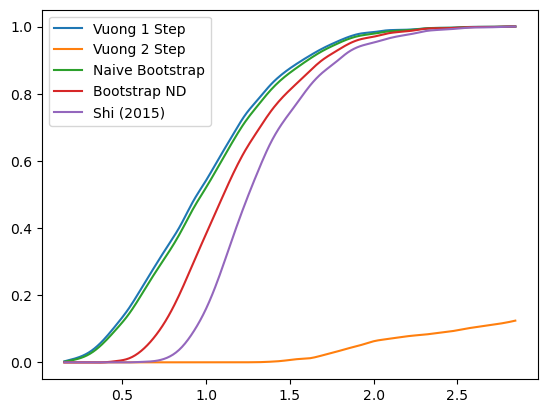

0.02 0.23227910480433808


In [8]:
nobs = 100
c1,c2 = calc_c(nobs)
    
mc_run_power(nobs,c1,c2)
print(c1,c2)

# sequence 2

Quantiles: 1th: 0.70, 5th: 1.93, 10th: 3.28, 30th: 9.88, 50th: 16.62, 70th: 25.70, 90th: 40.30, 95th: 48.32, 99th: 63.39
bonus term 1.6441473308088566 // variance stats 9.127633238930345 //part1 23.22791048043381 //part2 14.127633238930347 9.127633238930345
0.43308623522023754 -0.7450983334662711 2.8425287774558243
-2.8552084263974757 -0.7450983334662711 -0.44576588416188856
---
Quantiles: 1th: 0.72, 5th: 2.02, 10th: 3.53, 30th: 10.10, 50th: 18.10, 70th: 27.60, 90th: 43.38, 95th: 51.77, 99th: 66.68
bonus term 0.9995591831611266 // variance stats 18.238154250131604 //part1 23.22791048043381 //part2 23.238154250131604 18.238154250131604
-0.5586167951058294 -0.31791377920830255 2.4932185960271416
-2.5577351614280825 -0.31791377920830255 0.49410022970488876
---
Quantiles: 1th: 0.66, 5th: 1.67, 10th: 2.83, 30th: 8.17, 50th: 14.24, 70th: 21.78, 90th: 34.90, 95th: 41.43, 99th: 54.32
bonus term 1.4750123353694993 // variance stats 10.747604222316609 //part1 23.22791048043381 //part2 15.7476042

Quantiles: 1th: 0.71, 5th: 1.74, 10th: 2.86, 30th: 8.55, 50th: 14.81, 70th: 23.25, 90th: 37.31, 95th: 44.28, 99th: 57.86
bonus term 1.461560524524378 // variance stats 10.892540945570934 //part1 23.22791048043381 //part2 15.892540945570934 10.892540945570934
0.05953224923936734 -0.4987274687846564 2.911470419020556
-2.863588799809388 -0.4987274687846564 -0.01165063002819996
---
Quantiles: 1th: 0.60, 5th: 1.61, 10th: 2.70, 30th: 7.69, 50th: 13.82, 70th: 21.40, 90th: 33.70, 95th: 40.78, 99th: 54.32
bonus term 1.0772970933539125 // variance stats 16.561285762053938 //part1 23.22791048043381 //part2 21.561285762053938 16.561285762053938
-0.39257148873284836 -0.16326366924469815 2.680725366107746
-2.5471656754406737 -0.16326366924469815 0.5261311793999214
---
Quantiles: 1th: 0.82, 5th: 2.07, 10th: 3.45, 30th: 9.84, 50th: 17.27, 70th: 26.87, 90th: 42.72, 95th: 50.39, 99th: 66.97
bonus term 1.0796485708798966 // variance stats 16.514325222978275 //part1 23.22791048043381 //part2 21.5143252229

Quantiles: 1th: 0.77, 5th: 2.12, 10th: 3.77, 30th: 10.99, 50th: 18.99, 70th: 29.45, 90th: 47.02, 95th: 56.45, 99th: 72.79
bonus term 1.0367477666742517 // variance stats 17.404591769650825 //part1 23.22791048043381 //part2 22.40459176965082 17.404591769650825
-0.5406090533664285 -0.458119636854204 2.5287923977533464
-2.614104586714932 -0.458119636854204 0.4552968644048428
---
Quantiles: 1th: 0.67, 5th: 1.61, 10th: 2.86, 30th: 8.06, 50th: 14.15, 70th: 21.27, 90th: 33.70, 95th: 40.78, 99th: 54.21
bonus term 0.5545300903489577 // variance stats 36.88755648195181 //part1 23.22791048043381 //part2 41.88755648195182 36.88755648195181
-1.2733725117043821 0.5552524986117102 2.3145838172126956
-2.382432692402298 0.5552524986117102 1.2055236365147803
---
Quantiles: 1th: 0.78, 5th: 2.07, 10th: 3.99, 30th: 11.70, 50th: 20.18, 70th: 31.01, 90th: 49.55, 95th: 58.91, 99th: 77.82
bonus term 0.801674608547859 // variance stats 23.97423746837696 //part1 23.22791048043381 //part2 28.97423746837696 23.974

Quantiles: 1th: 0.71, 5th: 1.73, 10th: 2.98, 30th: 9.22, 50th: 15.94, 70th: 25.14, 90th: 39.30, 95th: 47.07, 99th: 61.99
bonus term 0.7744640727556088 // variance stats 24.99223759700942 //part1 23.22791048043381 //part2 29.99223759700942 24.99223759700942
-0.7712254803708798 -0.0862791212607737 2.3553668282115465
-2.320153625882097 -0.0862791212607737 0.8064386827003287
---
Quantiles: 1th: 0.80, 5th: 2.23, 10th: 4.01, 30th: 11.95, 50th: 21.60, 70th: 32.69, 90th: 52.20, 95th: 61.29, 99th: 81.91
bonus term 0.40519533299030164 // variance stats 52.32521722057882 //part1 23.22791048043381 //part2 57.32521722057882 52.32521722057882
-1.3735196997919454 0.4985929620685609 2.5208550317233214
-2.1839103657725487 0.4985929620685609 1.7104643657427183
---
Quantiles: 1th: 0.63, 5th: 1.65, 10th: 2.66, 30th: 7.59, 50th: 13.26, 70th: 20.56, 90th: 32.11, 95th: 38.45, 99th: 50.14
bonus term 0.5474534328961822 // variance stats 37.429016030736435 //part1 23.22791048043381 //part2 42.429016030736435 37

Quantiles: 1th: 0.71, 5th: 1.63, 10th: 2.93, 30th: 8.08, 50th: 13.86, 70th: 21.11, 90th: 33.20, 95th: 40.14, 99th: 52.15
bonus term 1.8217512291986113 // variance stats 7.75031964196987 //part1 23.22791048043381 //part2 12.75031964196987 7.75031964196987
0.595880739776859 -0.7253718293051198 2.930108933597418
-3.047621718620364 -0.7253718293051198 -0.7133935247998044
---
Quantiles: 1th: 0.76, 5th: 2.00, 10th: 3.59, 30th: 10.25, 50th: 17.16, 70th: 26.80, 90th: 43.27, 95th: 51.71, 99th: 68.13
bonus term 2.217308861778103 // variance stats 5.47572166459791 //part1 23.22791048043381 //part2 10.47572166459791 5.47572166459791
1.1749872949577524 -1.1961956458697405 3.182342287900834
-3.259630428598454 -1.1961956458697405 -1.2522754356553725
---
Quantiles: 1th: 0.69, 5th: 1.79, 10th: 3.05, 30th: 9.36, 50th: 16.76, 70th: 25.14, 90th: 39.78, 95th: 47.73, 99th: 62.45
bonus term 1.381036321097981 // variance stats 11.819188695896614 //part1 23.22791048043381 //part2 16.819188695896614 11.81918869

Quantiles: 1th: 0.68, 5th: 1.67, 10th: 3.10, 30th: 9.49, 50th: 16.53, 70th: 25.22, 90th: 40.25, 95th: 48.09, 99th: 63.64
bonus term 2.642933700795464 // variance stats 3.7886845112470007 //part1 23.22791048043381 //part2 8.788684511247 3.7886845112470007
1.7561640937902807 -1.5466886937393887 3.518648177645819
-3.5297033078006477 -1.5466886937393887 -1.7672192239451092
---
Quantiles: 1th: 0.82, 5th: 1.96, 10th: 3.55, 30th: 11.01, 50th: 18.92, 70th: 28.28, 90th: 44.76, 95th: 53.57, 99th: 69.28
bonus term 0.3206667021182336 // variance stats 67.43630326128905 //part1 23.22791048043381 //part2 72.43630326128905 67.43630326128905
-1.4298541956853303 0.9268584535225003 2.191407243288853
-2.0711875999217977 0.9268584535225003 1.550073839052386
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.67, 5th: 1.95, 10th: 3.52, 30th: 10.20, 50th: 17.58, 70th: 27.53, 90th: 44.44, 95th: 53.33, 99th: 69.66
bonus term 0.8056500802693217 // variance stats 23.831264402864484 //part1 23.22791048043381 //

Quantiles: 1th: 0.80, 5th: 1.89, 10th: 3.25, 30th: 9.24, 50th: 16.14, 70th: 25.00, 90th: 38.95, 95th: 47.78, 99th: 61.62
bonus term 0.771288037275428 // variance stats 25.115740628476892 //part1 23.22791048043381 //part2 30.115740628476892 25.115740628476892
-0.9991374797640556 0.0513967025254391 2.4508284900263737
-2.541713554314912 0.0513967025254391 0.9082524154755178
---
Quantiles: 1th: 0.76, 5th: 2.17, 10th: 3.68, 30th: 10.66, 50th: 18.41, 70th: 27.99, 90th: 45.21, 95th: 54.06, 99th: 69.28
bonus term 1.6188904898144028 // variance stats 9.348043074301316 //part1 23.22791048043381 //part2 14.348043074301318 9.348043074301316
0.2463487325289092 -1.4287200799890096 3.00465302195439
-2.991432247099896 -1.4287200799890096 -0.23312795767441527
---
Quantiles: 1th: 0.64, 5th: 1.63, 10th: 2.79, 30th: 8.18, 50th: 14.30, 70th: 22.03, 90th: 35.27, 95th: 41.73, 99th: 56.04
bonus term 2.6132248991914957 // variance stats 3.8885998628056386 //part1 23.22791048043381 //part2 8.888599862805638 3.8

Quantiles: 1th: 0.82, 5th: 2.20, 10th: 3.87, 30th: 10.93, 50th: 19.12, 70th: 29.44, 90th: 45.80, 95th: 54.93, 99th: 73.35
bonus term 2.622537366570332 // variance stats 3.8570369965063653 //part1 23.22791048043381 //part2 8.857036996506366 3.8570369965063653
1.6710932430698129 -2.2673553784042157 3.486057731486471
-3.5739814900708518 -2.2673553784042157 -1.7590170016541933
---
Quantiles: 1th: 0.71, 5th: 1.80, 10th: 3.03, 30th: 8.36, 50th: 14.46, 70th: 22.22, 90th: 35.39, 95th: 41.49, 99th: 54.59
bonus term 1.1615257030029822 // variance stats 14.997758482985692 //part1 23.22791048043381 //part2 19.99775848298569 14.997758482985692
-0.34565742803641564 -0.4235989801063198 2.7130700014113645
-2.66870883404238 -0.4235989801063198 0.39001859540539996
---
Quantiles: 1th: 0.66, 5th: 1.74, 10th: 2.80, 30th: 7.71, 50th: 13.64, 70th: 20.86, 90th: 32.43, 95th: 38.60, 99th: 53.03
bonus term 0.8214997712004707 // variance stats 23.27500541660589 //part1 23.22791048043381 //part2 28.27500541660589 

Quantiles: 1th: 0.70, 5th: 1.65, 10th: 3.06, 30th: 8.91, 50th: 15.63, 70th: 24.08, 90th: 37.52, 95th: 44.53, 99th: 60.59
bonus term 0.7286635497657387 // variance stats 26.877415149833492 //part1 23.22791048043381 //part2 31.877415149833492 26.877415149833492
-0.9042628788074196 -0.04428473901432258 2.3682235608179183
-2.361589978338897 -0.04428473901432258 0.9108964612864409
---
Quantiles: 1th: 0.75, 5th: 1.68, 10th: 2.96, 30th: 8.63, 50th: 14.67, 70th: 22.30, 90th: 35.35, 95th: 42.46, 99th: 55.38
bonus term 0.532182025088281 // variance stats 38.64655209198516 //part1 23.22791048043381 //part2 43.64655209198516 38.64655209198516
-1.250704224443543 0.16286842211699157 2.222781436166322
-2.3150682746201054 0.16286842211699157 1.1584173859897597
---
Quantiles: 1th: 0.66, 5th: 1.63, 10th: 2.90, 30th: 9.08, 50th: 15.70, 70th: 24.40, 90th: 38.46, 95th: 45.56, 99th: 58.61
bonus term 1.8388532256048857 // variance stats 7.631737083199259 //part1 23.22791048043381 //part2 12.631737083199258 7

Quantiles: 1th: 0.65, 5th: 1.74, 10th: 3.34, 30th: 9.97, 50th: 18.10, 70th: 27.26, 90th: 43.54, 95th: 51.58, 99th: 67.73
bonus term 1.1066259051548917 // variance stats 15.989848847956127 //part1 23.22791048043381 //part2 20.989848847956125 15.989848847956127
-0.35553795471030375 -0.8458031339718455 2.498667184820512
-2.568789765020087 -0.8458031339718455 0.28541537451072846
---
Quantiles: 1th: 0.78, 5th: 2.19, 10th: 4.01, 30th: 11.59, 50th: 20.72, 70th: 31.40, 90th: 50.51, 95th: 59.70, 99th: 76.05
bonus term 1.662773503459348 // variance stats 8.96937732776525 //part1 23.22791048043381 //part2 13.96937732776525 8.96937732776525
0.39610419609172387 -1.4009918319586274 2.9021029680599693
-2.929442810826972 -1.4009918319586274 -0.42344403885872695
---
Quantiles: 1th: 0.75, 5th: 1.86, 10th: 2.99, 30th: 8.78, 50th: 15.32, 70th: 23.12, 90th: 36.87, 95th: 43.82, 99th: 57.43
bonus term 1.546766197979835 // variance stats 10.01707918803164 //part1 23.22791048043381 //part2 15.01707918803164 10

Quantiles: 1th: 0.71, 5th: 2.22, 10th: 4.32, 30th: 12.27, 50th: 20.64, 70th: 31.65, 90th: 50.14, 95th: 59.77, 99th: 76.33
bonus term 0.6713470778438028 // variance stats 29.59895968421579 //part1 23.22791048043381 //part2 34.598959684215785 29.59895968421579
-1.027451922817361 -0.48595596964342497 2.195083795878008
-2.370146078504966 -0.48595596964342497 0.8523896401904023
---
Quantiles: 1th: 0.67, 5th: 1.68, 10th: 3.05, 30th: 8.42, 50th: 14.72, 70th: 22.38, 90th: 35.12, 95th: 41.84, 99th: 55.11
bonus term 0.6186472030667943 // variance stats 32.546295150591554 //part1 23.22791048043381 //part2 37.546295150591554 32.546295150591554
-1.185465088989038 -0.07960886782829164 2.216188677612008
-2.422759495122627 -0.07960886782829164 0.9788942714784195
---
Quantiles: 1th: 0.87, 5th: 2.19, 10th: 3.63, 30th: 10.49, 50th: 18.14, 70th: 27.07, 90th: 42.49, 95th: 50.60, 99th: 67.86
bonus term 0.4596413123025367 // variance stats 45.53486242147259 //part1 23.22791048043381 //part2 50.53486242147259

Quantiles: 1th: 0.79, 5th: 1.97, 10th: 3.49, 30th: 10.36, 50th: 17.72, 70th: 27.56, 90th: 44.23, 95th: 52.89, 99th: 69.10
bonus term 0.4579057126530501 // variance stats 45.72640466932399 //part1 23.22791048043381 //part2 50.72640466932399 45.72640466932399
-1.381311586480587 0.08729049093505896 2.296797855390432
-2.297123011786687 0.08729049093505896 1.3809864300843318
---
Quantiles: 1th: 0.71, 5th: 1.88, 10th: 3.21, 30th: 9.45, 50th: 16.69, 70th: 25.58, 90th: 41.08, 95th: 48.88, 99th: 64.67
bonus term 1.3414983516400223 // variance stats 12.314900500650625 //part1 23.22791048043381 //part2 17.314900500650626 12.314900500650625
-0.09979700952911713 -2.0383562066668093 2.8584762588635555
-2.7827937128091618 -2.0383562066668093 0.17547955558351114
---
Quantiles: 1th: 0.74, 5th: 1.88, 10th: 3.14, 30th: 9.67, 50th: 16.62, 70th: 25.53, 90th: 40.75, 95th: 48.34, 99th: 63.89
bonus term 1.1632589425324322 // variance stats 14.967962102974507 //part1 23.22791048043381 //part2 19.96796210297450

Quantiles: 1th: 0.83, 5th: 2.03, 10th: 3.54, 30th: 10.24, 50th: 17.68, 70th: 27.37, 90th: 43.26, 95th: 51.06, 99th: 65.66
bonus term 0.8969075841672061 // variance stats 20.897774631933032 //part1 23.22791048043381 //part2 25.897774631933032 20.897774631933032
-0.6745331257226288 -1.1569813446581572 2.5169994678710568
-2.468348294057041 -1.1569813446581572 0.7231842995366448
---
Quantiles: 1th: 0.69, 5th: 1.88, 10th: 3.55, 30th: 9.88, 50th: 17.67, 70th: 26.53, 90th: 42.01, 95th: 50.05, 99th: 64.00
bonus term 1.4740101761583755 // variance stats 10.758310801470397 //part1 23.22791048043381 //part2 15.758310801470397 10.758310801470397
0.1576857779013732 -1.623950776763091 2.8283316908468445
-2.7903345744153776 -1.623950776763091 -0.11968866146990684
---
Quantiles: 1th: 0.80, 5th: 2.02, 10th: 3.23, 30th: 9.29, 50th: 15.68, 70th: 24.34, 90th: 39.38, 95th: 46.32, 99th: 58.80
bonus term 0.46026369967628933 // variance stats 45.466527116455985 //part1 23.22791048043381 //part2 50.46652711645

Quantiles: 1th: 0.65, 5th: 1.65, 10th: 2.95, 30th: 8.45, 50th: 15.37, 70th: 23.90, 90th: 37.98, 95th: 45.01, 99th: 59.92
bonus term 1.0882159702975385 // variance stats 16.344945410131103 //part1 23.22791048043381 //part2 21.344945410131103 16.344945410131103
-0.4067140817946396 -2.2079784465359626 2.5882208667106883
-2.583146022389717 -2.2079784465359626 0.41178892611561135
---
Quantiles: 1th: 0.71, 5th: 1.98, 10th: 3.46, 30th: 10.05, 50th: 17.64, 70th: 27.28, 90th: 42.34, 95th: 50.70, 99th: 66.38
bonus term 1.429051923046479 // variance stats 11.254070342605972 //part1 23.22791048043381 //part2 16.254070342605974 11.254070342605972
-0.029707262097264597 -3.0359222043175293 2.7666055944234214
-2.8878111081902227 -3.0359222043175293 -0.09149825166953683
---
Quantiles: 1th: 0.97, 5th: 2.27, 10th: 4.30, 30th: 11.79, 50th: 21.29, 70th: 32.08, 90th: 51.22, 95th: 61.70, 99th: 80.63
bonus term 0.2086015955850239 // variance stats 106.35058873970286 //part1 23.22791048043381 //part2 111.35058

0.7692307692307693 [0.96857143 0.         0.03142857]
Quantiles: 1th: 0.78, 5th: 2.22, 10th: 3.86, 30th: 12.00, 50th: 20.77, 70th: 31.85, 90th: 50.94, 95th: 60.97, 99th: 80.39
bonus term 0.588276360754061 // variance stats 34.484691260855605 //part1 23.22791048043381 //part2 39.484691260855605 34.484691260855605
-1.183567172611809 -0.6229233542052031 2.2906948078554
-2.360119894119931 -0.6229233542052031 1.1141420863472786
---
Quantiles: 1th: 0.64, 5th: 1.72, 10th: 3.19, 30th: 9.71, 50th: 16.54, 70th: 25.60, 90th: 40.66, 95th: 48.39, 99th: 64.14
bonus term 1.2343953650647432 // variance stats 13.817237278929284 //part1 23.22791048043381 //part2 18.817237278929284 13.817237278929284
-0.2178359838506083 -3.007332491022721 2.6358943112233244
-2.6866267139800946 -3.007332491022721 0.16710358109383786
---
Quantiles: 1th: 0.78, 5th: 1.82, 10th: 3.07, 30th: 9.41, 50th: 16.32, 70th: 25.12, 90th: 40.27, 95th: 48.43, 99th: 63.05
bonus term 1.067903946462476 // variance stats 16.75093608126299 //

Quantiles: 1th: 0.70, 5th: 1.90, 10th: 3.23, 30th: 9.50, 50th: 16.53, 70th: 25.89, 90th: 40.78, 95th: 48.92, 99th: 63.96
bonus term 0.4030192106095932 // variance stats 52.6347475975154 //part1 23.22791048043381 //part2 57.6347475975154 52.6347475975154
-1.310114793467255 0.20563616522761793 2.126127103951793
-2.1161532146864412 0.20563616522761793 1.3200886827326068
---
Quantiles: 1th: 0.60, 5th: 1.65, 10th: 2.87, 30th: 8.14, 50th: 14.02, 70th: 21.43, 90th: 34.58, 95th: 40.52, 99th: 51.71
bonus term 0.4106565493905307 // variance stats 51.56286382113505 //part1 23.22791048043381 //part2 56.56286382113505 51.56286382113505
-1.3823772407693868 0.37582283307664904 2.139630928404762
-2.203690339550448 0.37582283307664904 1.3183178296237008
---
Quantiles: 1th: 0.72, 5th: 2.12, 10th: 4.00, 30th: 11.99, 50th: 20.31, 70th: 31.14, 90th: 49.46, 95th: 58.46, 99th: 75.73
bonus term 0.25755250285655196 // variance stats 85.18708893452676 //part1 23.22791048043381 //part2 90.18708893452676 85.18708

Quantiles: 1th: 0.75, 5th: 2.00, 10th: 3.53, 30th: 10.77, 50th: 19.11, 70th: 29.17, 90th: 46.47, 95th: 56.01, 99th: 74.01
bonus term 0.35214305038752824 // variance stats 60.96157571439174 //part1 23.22791048043381 //part2 65.96157571439174 60.96157571439174
-1.523337045765401 0.03830668720001958 2.166704601864821
-2.2276231465404575 0.03830668720001958 1.4624185010897643
---
Quantiles: 1th: 0.68, 5th: 1.87, 10th: 3.40, 30th: 10.21, 50th: 17.45, 70th: 27.53, 90th: 43.27, 95th: 51.14, 99th: 66.26
bonus term 0.29231805848859377 // variance stats 74.46108632676268 //part1 23.22791048043381 //part2 79.46108632676268 74.46108632676268
-1.5990416433079688 0.6256907606586062 2.282611831226203
-2.183677760285156 0.6256907606586062 1.6979757142490157
---
Quantiles: 1th: 0.57, 5th: 1.51, 10th: 2.78, 30th: 8.55, 50th: 14.64, 70th: 22.51, 90th: 35.81, 95th: 43.37, 99th: 57.05
bonus term 0.8462034126848912 // variance stats 22.449558973928895 //part1 23.22791048043381 //part2 27.449558973928895 22.

Quantiles: 1th: 0.81, 5th: 1.93, 10th: 3.47, 30th: 9.61, 50th: 17.04, 70th: 25.74, 90th: 40.78, 95th: 49.00, 99th: 63.98
bonus term 0.8011221380613258 // variance stats 23.99421870508304 //part1 23.22791048043381 //part2 28.99421870508304 23.99421870508304
-0.9079697613203181 -1.4520373441742673 2.425841306589683
-2.5102140374429696 -1.4520373441742673 0.8235970304670313
---
Quantiles: 1th: 0.68, 5th: 1.76, 10th: 2.98, 30th: 8.86, 50th: 15.50, 70th: 23.48, 90th: 36.54, 95th: 44.20, 99th: 60.58
bonus term 0.5981561121147739 // variance stats 33.83252216267054 //part1 23.22791048043381 //part2 38.83252216267054 33.83252216267054
-1.1908450036976952 -0.7312945653004893 2.2981362793819877
-2.387157227927243 -0.7312945653004893 1.1018240551524403
---
Quantiles: 1th: 0.67, 5th: 1.67, 10th: 2.82, 30th: 8.27, 50th: 14.22, 70th: 21.79, 90th: 34.56, 95th: 40.89, 99th: 53.47
bonus term 0.5497585047523976 // variance stats 37.25111622583316 //part1 23.22791048043381 //part2 42.251116225833165 37.2

Quantiles: 1th: 0.53, 5th: 1.47, 10th: 2.48, 30th: 7.81, 50th: 13.68, 70th: 21.59, 90th: 33.68, 95th: 39.75, 99th: 52.78
bonus term 0.6043952293342966 // variance stats 33.431657552985484 //part1 23.22791048043381 //part2 38.431657552985484 33.431657552985484
-1.159872704696333 -1.2215628967030665 2.2475131068301644
-2.3686631633649267 -1.2215628967030665 1.0387226481615712
---
Quantiles: 1th: 0.82, 5th: 2.00, 10th: 3.36, 30th: 9.12, 50th: 15.93, 70th: 24.64, 90th: 38.77, 95th: 46.23, 99th: 57.60
bonus term 0.2684500383849511 // variance stats 81.52600916050355 //part1 23.22791048043381 //part2 86.52600916050355 81.52600916050355
-1.627046054551819 0.8772032060275545 2.2317189558558144
-2.163946131321721 0.8772032060275545 1.6948188790859122
---
Quantiles: 1th: 0.64, 5th: 1.74, 10th: 2.97, 30th: 8.70, 50th: 15.13, 70th: 23.13, 90th: 36.94, 95th: 44.25, 99th: 60.17
bonus term 0.5565211801400738 // variance stats 36.73769356736332 //part1 23.22791048043381 //part2 41.73769356736333 36.73

Quantiles: 1th: 0.84, 5th: 1.94, 10th: 3.27, 30th: 10.10, 50th: 17.68, 70th: 27.27, 90th: 42.13, 95th: 49.77, 99th: 64.69
bonus term 0.5101651888204808 // variance stats 40.530175302900474 //part1 23.22791048043381 //part2 45.530175302900474 40.530175302900474
-1.2100498709084238 -0.6859816539633378 2.2350497463295573
-2.2303802485493853 -0.6859816539633378 1.214719368688596
---
Quantiles: 1th: 0.65, 5th: 1.73, 10th: 3.29, 30th: 9.68, 50th: 16.90, 70th: 25.71, 90th: 40.77, 95th: 49.40, 99th: 66.56
bonus term 0.27711606356040813 // variance stats 78.82015167940776 //part1 23.22791048043381 //part2 83.82015167940776 78.82015167940776
-1.6789074943392852 0.5082128538807912 2.155243137578284
-2.2331396214601016 0.5082128538807912 1.601011010457468
---
1.076923076923077 [0.94285714 0.         0.05714286]
Quantiles: 1th: 0.70, 5th: 2.07, 10th: 3.99, 30th: 11.76, 50th: 20.19, 70th: 30.44, 90th: 48.32, 95th: 58.04, 99th: 75.19
bonus term 0.30132556661968596 // variance stats 72.08576056458763 

Quantiles: 1th: 0.85, 5th: 1.85, 10th: 3.01, 30th: 8.76, 50th: 15.11, 70th: 23.81, 90th: 37.06, 95th: 45.01, 99th: 59.23
bonus term 0.2582930797213809 // variance stats 84.92850488092678 //part1 23.22791048043381 //part2 89.92850488092678 84.92850488092678
-1.7904342528152533 0.85983733586715 1.9490572410520808
-2.307020412258015 0.85983733586715 1.432471081609319
---
Quantiles: 1th: 0.59, 5th: 1.49, 10th: 2.46, 30th: 6.93, 50th: 11.89, 70th: 17.86, 90th: 28.69, 95th: 34.20, 99th: 43.66
bonus term 0.38507679665878036 // variance stats 55.32020283220608 //part1 23.22791048043381 //part2 60.32020283220608 55.32020283220608
-1.5537472736067237 0.427393139126847 2.1662183236537333
-2.3239008669242844 0.427393139126847 1.3960647303361726
---
Quantiles: 1th: 0.69, 5th: 1.75, 10th: 3.19, 30th: 9.04, 50th: 15.97, 70th: 24.27, 90th: 38.83, 95th: 45.83, 99th: 61.64
bonus term 0.34259443208825885 // variance stats 62.80002330700417 //part1 23.22791048043381 //part2 67.80002330700417 62.8000233070

Quantiles: 1th: 0.83, 5th: 1.99, 10th: 3.39, 30th: 10.20, 50th: 17.65, 70th: 26.69, 90th: 41.95, 95th: 49.66, 99th: 65.42
bonus term 0.507341092269447 // variance stats 40.783617440744486 //part1 23.22791048043381 //part2 45.783617440744486 40.783617440744486
-1.1542790727955252 -1.0957886864656776 2.229904962018067
-2.168961257334419 -1.0957886864656776 1.215222777479173
---
Quantiles: 1th: 0.63, 5th: 1.91, 10th: 3.41, 30th: 10.29, 50th: 18.14, 70th: 27.57, 90th: 43.48, 95th: 52.43, 99th: 68.05
bonus term 0.2892398669202492 // variance stats 75.30673892834534 //part1 23.22791048043381 //part2 80.30673892834535 75.30673892834534
-1.5162618949867221 0.5545980275439696 2.2517573471960013
-2.0947416288272205 0.5545980275439696 1.673277613355503
---
Quantiles: 1th: 0.66, 5th: 1.87, 10th: 3.69, 30th: 11.27, 50th: 19.81, 70th: 30.08, 90th: 47.25, 95th: 55.80, 99th: 71.71
bonus term 0.27166927573320804 // variance stats 80.50068982863084 //part1 23.22791048043381 //part2 85.50068982863084 80.

Quantiles: 1th: 0.61, 5th: 1.48, 10th: 2.55, 30th: 7.33, 50th: 13.20, 70th: 20.49, 90th: 31.87, 95th: 38.35, 99th: 50.99
bonus term 0.43006935412039865 // variance stats 49.0096853167806 //part1 23.22791048043381 //part2 54.0096853167806 49.0096853167806
-1.401168201732577 -0.6533095323735624 2.2148195727995126
-2.2613069099733742 -0.6533095323735624 1.354680864558715
---
Quantiles: 1th: 0.76, 5th: 2.00, 10th: 3.49, 30th: 10.44, 50th: 18.17, 70th: 28.29, 90th: 43.65, 95th: 52.01, 99th: 68.21
bonus term 0.25833616287097527 // variance stats 84.91350735527831 //part1 23.22791048043381 //part2 89.91350735527831 84.91350735527831
-1.6247207090291076 0.46014999598020606 2.170843872596406
-2.1413930347710584 0.46014999598020606 1.6541715468544553
---
Quantiles: 1th: 0.70, 5th: 1.74, 10th: 2.96, 30th: 8.78, 50th: 15.50, 70th: 23.87, 90th: 38.12, 95th: 44.99, 99th: 58.97
bonus term 0.3722210467106595 // variance stats 57.40353866526435 //part1 23.22791048043381 //part2 62.40353866526435 57.403

Quantiles: 1th: 0.60, 5th: 1.78, 10th: 3.06, 30th: 8.76, 50th: 15.09, 70th: 23.19, 90th: 36.54, 95th: 43.71, 99th: 57.37
bonus term 0.35077300154351215 // variance stats 61.219208371863445 //part1 23.22791048043381 //part2 66.21920837186344 61.219208371863445
-1.4061432527151374 -0.5248705530402422 2.068295090036181
-2.107689255802162 -0.5248705530402422 1.3667490869491572
---
Quantiles: 1th: 0.73, 5th: 2.02, 10th: 3.57, 30th: 10.67, 50th: 18.70, 70th: 28.68, 90th: 45.78, 95th: 53.83, 99th: 71.65
bonus term 0.19443883890291003 // variance stats 114.46126921706367 //part1 23.22791048043381 //part2 119.46126921706367 114.46126921706367
-1.5993087175224803 1.085475095574735 2.0422973210391255
-1.9881863953283005 1.085475095574735 1.6534196432333055
---
Quantiles: 1th: 0.87, 5th: 2.15, 10th: 3.72, 30th: 11.54, 50th: 20.29, 70th: 31.43, 90th: 49.49, 95th: 57.76, 99th: 77.08
bonus term 0.3491597740108392 // variance stats 61.52516185817192 //part1 23.22791048043381 //part2 66.52516185817193 

Quantiles: 1th: 0.82, 5th: 2.28, 10th: 3.98, 30th: 11.08, 50th: 19.42, 70th: 29.51, 90th: 48.10, 95th: 57.30, 99th: 73.77
bonus term 0.19494822642134688 // variance stats 114.14912439485701 //part1 23.22791048043381 //part2 119.14912439485701 114.14912439485701
-1.67664732072126 1.041925040788008 2.415269525265769
-2.0665437735639536 1.041925040788008 2.0253730724230756
---
Quantiles: 1th: 0.61, 5th: 1.50, 10th: 2.73, 30th: 7.93, 50th: 13.79, 70th: 21.63, 90th: 33.91, 95th: 40.10, 99th: 52.38
bonus term 0.3557562741760572 // variance stats 60.29163971663011 //part1 23.22791048043381 //part2 65.29163971663012 60.29163971663011
-1.4496731236638927 -0.23420808754031816 2.089528922299009
-2.161185672016007 -0.23420808754031816 1.378016373946895
---
Quantiles: 1th: 0.77, 5th: 2.18, 10th: 3.88, 30th: 11.46, 50th: 20.01, 70th: 30.36, 90th: 47.61, 95th: 56.25, 99th: 74.63
bonus term 0.3319427407838517 // variance stats 64.9756543118951 //part1 23.22791048043381 //part2 69.9756543118951 64.9756

Quantiles: 1th: 0.97, 5th: 2.29, 10th: 3.90, 30th: 11.81, 50th: 20.68, 70th: 31.64, 90th: 49.98, 95th: 59.34, 99th: 77.88
bonus term 0.39872016867573284 // variance stats 53.25617138350574 //part1 23.22791048043381 //part2 58.25617138350574 53.25617138350574
-1.3077042453225773 -1.1513372184685584 2.191197648393421
-2.105144582674043 -1.1513372184685584 1.393757311041955
---
Quantiles: 1th: 0.60, 5th: 1.51, 10th: 2.47, 30th: 7.00, 50th: 12.52, 70th: 19.11, 90th: 30.62, 95th: 36.66, 99th: 50.01
bonus term 0.5915133927452473 // variance stats 34.26861296010857 //part1 23.22791048043381 //part2 39.26861296010857 34.26861296010857
-1.2767136390292717 -2.287769897178322 2.3637279578699175
-2.4597404245197665 -2.287769897178322 1.1807011723794232
---
Quantiles: 1th: 0.73, 5th: 1.83, 10th: 3.23, 30th: 9.04, 50th: 16.09, 70th: 24.41, 90th: 38.67, 95th: 45.91, 99th: 60.32
bonus term 0.2934300291489821 // variance stats 74.1599637835308 //part1 23.22791048043381 //part2 79.1599637835308 74.15996

Quantiles: 1th: 0.62, 5th: 1.75, 10th: 2.98, 30th: 8.73, 50th: 15.39, 70th: 23.53, 90th: 37.25, 95th: 44.60, 99th: 57.16
bonus term 0.20587589202828893 // variance stats 107.8248200971589 //part1 23.22791048043381 //part2 112.8248200971589 107.8248200971589
-1.6941773167796064 0.9391862010525753 2.1872901413040116
-2.105929100836184 0.9391862010525753 1.7755383572474341
---
Quantiles: 1th: 0.76, 5th: 1.98, 10th: 3.61, 30th: 10.77, 50th: 18.65, 70th: 28.20, 90th: 44.91, 95th: 53.44, 99th: 70.46
bonus term 0.18285810652372367 // variance stats 122.02696600120521 //part1 23.22791048043381 //part2 127.02696600120521 122.02696600120521
-1.6554286907191473 0.923223820261966 2.1054450038938386
-2.0211449037665945 0.923223820261966 1.7397287908463914
---
Quantiles: 1th: 0.67, 5th: 1.78, 10th: 3.15, 30th: 9.79, 50th: 17.21, 70th: 26.08, 90th: 41.79, 95th: 49.37, 99th: 64.91
bonus term 0.5482082124468217 // variance stats 37.37059925965083 //part1 23.22791048043381 //part2 42.37059925965083 37.3

Quantiles: 1th: 0.72, 5th: 1.83, 10th: 3.31, 30th: 9.21, 50th: 15.84, 70th: 24.11, 90th: 36.43, 95th: 43.29, 99th: 57.40
bonus term 0.29077677841245825 // variance stats 74.88227466873474 //part1 23.22791048043381 //part2 79.88227466873474 74.88227466873474
-1.4774405645778166 0.057295993934067334 2.146615471050007
-2.058994121402733 0.057295993934067334 1.5650619142250906
---
Quantiles: 1th: 0.68, 5th: 1.77, 10th: 3.23, 30th: 9.51, 50th: 16.27, 70th: 25.40, 90th: 40.21, 95th: 48.05, 99th: 62.21
bonus term 0.20229156412089852 // variance stats 109.82392051974925 //part1 23.22791048043381 //part2 114.82392051974925 109.82392051974925
-1.665734389734629 0.986214171438942 2.1074393789068315
-2.070317517976426 0.986214171438942 1.7028562506650344
---
Quantiles: 1th: 0.49, 5th: 1.24, 10th: 2.08, 30th: 5.87, 50th: 10.17, 70th: 15.80, 90th: 25.10, 95th: 30.27, 99th: 39.65
bonus term 0.7214471845254875 // variance stats 27.19627296170175 //part1 23.22791048043381 //part2 32.19627296170175 27.1

1.6153846153846154 [0.94714286 0.00428571 0.04857143]
Quantiles: 1th: 0.53, 5th: 1.58, 10th: 2.67, 30th: 7.59, 50th: 13.10, 70th: 20.04, 90th: 31.66, 95th: 38.05, 99th: 50.13
bonus term 0.2387437017455327 // variance stats 92.29224398636285 //part1 23.22791048043381 //part2 97.29224398636285 92.29224398636285
-1.5489896100978942 0.7931301364440834 2.0553972200459225
-2.0264770135889596 0.7931301364440834 1.577909816554857
---
Quantiles: 1th: 0.85, 5th: 2.10, 10th: 3.65, 30th: 10.94, 50th: 18.49, 70th: 28.32, 90th: 45.19, 95th: 53.93, 99th: 69.75
bonus term 0.18265158379535054 // variance stats 122.17059440590015 //part1 23.22791048043381 //part2 127.17059440590015 122.17059440590015
-1.5735556919235751 1.2068713761424419 2.0548165552931326
-1.9388588595142764 1.2068713761424419 1.6895133877024315
---
Quantiles: 1th: 0.62, 5th: 1.79, 10th: 3.50, 30th: 10.09, 50th: 17.69, 70th: 27.05, 90th: 43.12, 95th: 50.94, 99th: 66.04
bonus term 0.2048177691147923 // variance stats 108.40769202214814

Quantiles: 1th: 0.78, 5th: 1.96, 10th: 3.43, 30th: 9.61, 50th: 16.39, 70th: 25.29, 90th: 39.81, 95th: 47.43, 99th: 61.88
bonus term 0.26659374180117984 // variance stats 82.12849117724866 //part1 23.22791048043381 //part2 87.12849117724866 82.12849117724866
-1.525650735063898 0.09861205464647282 2.1295169661470905
-2.0588382186662577 0.09861205464647282 1.5963294825447305
---
Quantiles: 1th: 0.59, 5th: 1.44, 10th: 2.40, 30th: 6.50, 50th: 11.26, 70th: 17.06, 90th: 27.15, 95th: 31.86, 99th: 43.39
bonus term 0.2733065161812869 // variance stats 79.98849864606414 //part1 23.22791048043381 //part2 84.98849864606414 79.98849864606414
-1.6314346794559935 0.3963768225014237 2.2790583721937208
-2.178047711818567 0.3963768225014237 1.732445339831147
---
Quantiles: 1th: 0.65, 5th: 1.60, 10th: 2.93, 30th: 8.08, 50th: 13.71, 70th: 21.05, 90th: 33.02, 95th: 39.93, 99th: 52.38
bonus term 0.23709155227619677 // variance stats 92.97021554515257 //part1 23.22791048043381 //part2 97.97021554515257 92.970

Quantiles: 1th: 0.55, 5th: 1.54, 10th: 2.67, 30th: 8.15, 50th: 13.89, 70th: 21.08, 90th: 33.77, 95th: 39.92, 99th: 52.70
bonus term 0.2206639380241509 // variance stats 100.26373583476786 //part1 23.22791048043381 //part2 105.26373583476786 100.26373583476786
-1.6022961048046471 0.5440753009492961 2.096820870927085
-2.043623980852949 0.5440753009492961 1.6554929948787833
---
Quantiles: 1th: 0.63, 5th: 1.75, 10th: 2.96, 30th: 8.64, 50th: 14.41, 70th: 22.17, 90th: 36.03, 95th: 42.56, 99th: 55.45
bonus term 0.22200801199056078 // variance stats 99.62645141573269 //part1 23.22791048043381 //part2 104.62645141573269 99.62645141573269
-1.9001313726787574 0.5745209502702276 1.9655563400528833
-2.3441473966598787 0.5745209502702276 1.5215403160717618
---
Quantiles: 1th: 0.85, 5th: 2.28, 10th: 4.34, 30th: 13.16, 50th: 22.65, 70th: 34.71, 90th: 55.74, 95th: 67.33, 99th: 87.30
bonus term 0.21176340483969308 // variance stats 104.68802894918298 //part1 23.22791048043381 //part2 109.68802894918298 

Quantiles: 1th: 0.74, 5th: 1.87, 10th: 3.26, 30th: 10.20, 50th: 17.70, 70th: 27.13, 90th: 42.30, 95th: 50.02, 99th: 64.63
bonus term 0.3105739839490901 // variance stats 69.79026473847009 //part1 23.22791048043381 //part2 74.79026473847009 69.79026473847009
-1.5578391232653688 -1.1274850797099374 2.086222357459921
-2.178987091163549 -1.1274850797099374 1.465074389561741
---
Quantiles: 1th: 0.80, 5th: 1.98, 10th: 3.44, 30th: 10.11, 50th: 17.42, 70th: 26.24, 90th: 41.19, 95th: 48.66, 99th: 67.09
bonus term 0.1985600761602693 // variance stats 111.98177664721089 //part1 23.22791048043381 //part2 116.98177664721089 111.98177664721089
-1.7029149118216098 0.5950796508047184 2.3161504916252023
-2.1000350641421486 0.5950796508047184 1.9190303393046635
---
Quantiles: 1th: 0.75, 5th: 1.89, 10th: 3.20, 30th: 8.93, 50th: 15.43, 70th: 23.96, 90th: 37.38, 95th: 44.85, 99th: 61.32
bonus term 0.23855930875403336 // variance stats 92.36744544470051 //part1 23.22791048043381 //part2 97.36744544470051 92

Quantiles: 1th: 0.59, 5th: 1.74, 10th: 3.22, 30th: 9.82, 50th: 16.72, 70th: 25.35, 90th: 39.24, 95th: 46.74, 99th: 60.22
bonus term 0.16873314796767008 // variance stats 132.66062424725442 //part1 23.22791048043381 //part2 137.66062424725442 132.66062424725442
-1.7460192101272074 1.1016781526636226 2.021267700907403
-2.083485506062548 1.1016781526636226 1.6838014049720633
---
Quantiles: 1th: 0.96, 5th: 2.70, 10th: 5.17, 30th: 15.49, 50th: 27.85, 70th: 41.77, 90th: 66.93, 95th: 78.42, 99th: 102.98
bonus term 0.2295825316578062 // variance stats 96.17455501821503 //part1 23.22791048043381 //part2 101.17455501821503 96.17455501821503
-1.589216553725658 -1.2134266613394586 2.02301944756396
-2.0483816170412705 -1.2134266613394586 1.5638543842483472
---
Quantiles: 1th: 0.77, 5th: 1.93, 10th: 3.32, 30th: 9.95, 50th: 17.10, 70th: 26.25, 90th: 41.74, 95th: 49.72, 99th: 65.46
bonus term 0.22036988261795665 // variance stats 100.40419681895816 //part1 23.22791048043381 //part2 105.40419681895816 

Quantiles: 1th: 0.59, 5th: 1.53, 10th: 2.47, 30th: 6.94, 50th: 11.90, 70th: 18.27, 90th: 29.07, 95th: 34.93, 99th: 45.23
bonus term 0.25818281533074633 // variance stats 84.9669114331935 //part1 23.22791048043381 //part2 89.9669114331935 84.9669114331935
-1.524830104777197 0.005839720370911149 2.0562332093975475
-2.0411957354386896 0.005839720370911149 1.5398675787360547
---
Quantiles: 1th: 0.89, 5th: 2.17, 10th: 3.77, 30th: 11.64, 50th: 20.61, 70th: 31.74, 90th: 49.33, 95th: 58.97, 99th: 77.22
bonus term 0.1953264655117923 // variance stats 113.91839858757638 //part1 23.22791048043381 //part2 118.91839858757638 113.91839858757638
-1.6590508382792697 0.012150766198879217 2.1635540981289703
-2.049703769302854 0.012150766198879217 1.772901167105386
---
1.9230769230769231 [0.96285714 0.00285714 0.03428571]
Quantiles: 1th: 0.81, 5th: 2.45, 10th: 4.55, 30th: 13.65, 50th: 23.31, 70th: 35.84, 90th: 56.36, 95th: 67.65, 99th: 88.34
bonus term 0.1364541033504482 // variance stats 165.22507869022

Quantiles: 1th: 0.77, 5th: 2.14, 10th: 3.74, 30th: 10.89, 50th: 18.44, 70th: 28.55, 90th: 44.69, 95th: 52.21, 99th: 72.83
bonus term 0.18049057200729926 // variance stats 123.69320664291786 //part1 23.22791048043381 //part2 128.69320664291786 123.69320664291786
-1.7488843658100561 0.2082015152693716 2.0813529805300326
-2.1098655098246546 0.2082015152693716 1.720371836515434
---
Quantiles: 1th: 0.82, 5th: 1.90, 10th: 3.38, 30th: 9.85, 50th: 17.25, 70th: 26.49, 90th: 41.79, 95th: 49.94, 99th: 66.30
bonus term 0.2292059316120288 // variance stats 96.3407913009473 //part1 23.22791048043381 //part2 101.3407913009473 96.3407913009473
-1.670594946483821 -0.7671980050181978 2.133351067239678
-2.1290068097078785 -0.7671980050181978 1.6749392040156206
---
Quantiles: 1th: 0.69, 5th: 1.91, 10th: 3.61, 30th: 10.73, 50th: 18.84, 70th: 28.46, 90th: 46.11, 95th: 55.05, 99th: 72.96
bonus term 0.15866320225774716 // variance stats 141.3975903038957 //part1 23.22791048043381 //part2 146.3975903038957 141

Quantiles: 1th: 0.63, 5th: 1.77, 10th: 3.06, 30th: 8.70, 50th: 14.65, 70th: 22.40, 90th: 34.57, 95th: 41.56, 99th: 54.99
bonus term 0.24026550264136615 // variance stats 91.67601143350612 //part1 23.22791048043381 //part2 96.67601143350612 91.67601143350612
-1.5648782253625675 -0.5359211219454296 2.0124887318508864
-2.0454092306452996 -0.5359211219454296 1.5319577265681537
---
Quantiles: 1th: 0.88, 5th: 2.35, 10th: 4.32, 30th: 12.51, 50th: 21.87, 70th: 33.27, 90th: 52.45, 95th: 62.68, 99th: 82.88
bonus term 0.25090404502048735 // variance stats 87.57686729816234 //part1 23.22791048043381 //part2 92.57686729816234 87.57686729816234
-1.7090521748693115 -1.352011164594265 2.112021510984003
-2.2108602649102864 -1.352011164594265 1.610213420943028
---
Quantiles: 1th: 0.60, 5th: 1.65, 10th: 3.15, 30th: 8.71, 50th: 15.10, 70th: 22.55, 90th: 35.82, 95th: 42.84, 99th: 56.13
bonus term 0.35443591713931366 // variance stats 60.53486640944435 //part1 23.22791048043381 //part2 65.53486640944435 60.

Quantiles: 1th: 0.77, 5th: 1.88, 10th: 3.25, 30th: 9.45, 50th: 17.04, 70th: 26.07, 90th: 41.02, 95th: 48.94, 99th: 64.66
bonus term 0.19236519760736662 // variance stats 115.7490272114809 //part1 23.22791048043381 //part2 120.7490272114809 115.7490272114809
-1.6564168677659843 0.10160567155834027 2.1863793626208246
-2.0411472629807177 0.10160567155834027 1.8016489674060916
---
Quantiles: 1th: 0.74, 5th: 1.87, 10th: 3.02, 30th: 8.70, 50th: 15.16, 70th: 23.32, 90th: 37.23, 95th: 44.53, 99th: 59.78
bonus term 0.2400484096742348 // variance stats 91.76344247377423 //part1 23.22791048043381 //part2 96.76344247377423 91.76344247377423
-1.7202108049055282 -0.6722449242576664 2.0561270396568854
-2.200307624253998 -0.6722449242576664 1.5760302203084158
---
Quantiles: 1th: 0.71, 5th: 1.77, 10th: 2.99, 30th: 8.88, 50th: 15.45, 70th: 23.25, 90th: 36.92, 95th: 43.86, 99th: 58.70
bonus term 0.2077065840299633 // variance stats 106.8304005090325 //part1 23.22791048043381 //part2 111.8304005090325 106

Quantiles: 1th: 0.72, 5th: 1.94, 10th: 3.50, 30th: 10.23, 50th: 17.67, 70th: 27.41, 90th: 43.53, 95th: 52.11, 99th: 67.33
bonus term 0.17110062934140322 // variance stats 130.7558447905316 //part1 23.22791048043381 //part2 135.7558447905316 130.7558447905316
-1.770209035872468 0.3507109433361345 2.0373813167038333
-2.112410294555274 0.3507109433361345 1.695180058021027
---
Quantiles: 1th: 0.67, 5th: 1.67, 10th: 3.02, 30th: 8.87, 50th: 15.50, 70th: 23.34, 90th: 37.51, 95th: 43.77, 99th: 57.82
bonus term 0.18224787651251453 // variance stats 122.45229697553597 //part1 23.22791048043381 //part2 127.45229697553597 122.45229697553597
-1.6641659195048744 0.5630924415401292 2.042003471650225
-2.0286616725299034 0.5630924415401292 1.6775077186251959
---
Quantiles: 1th: 0.83, 5th: 2.25, 10th: 3.45, 30th: 9.32, 50th: 16.29, 70th: 24.89, 90th: 40.09, 95th: 47.50, 99th: 60.94
bonus term 0.2323593415858793 // variance stats 94.96546866547583 //part1 23.22791048043381 //part2 99.96546866547583 94.96

Quantiles: 1th: 0.63, 5th: 1.84, 10th: 2.90, 30th: 8.42, 50th: 14.65, 70th: 22.36, 90th: 35.57, 95th: 42.60, 99th: 56.94
bonus term 0.1748903245964252 // variance stats 127.81415386491078 //part1 23.22791048043381 //part2 132.8141538649108 127.81415386491078
-1.5778409719215634 1.1348670599255641 2.233998188134578
-1.927621621114414 1.1348670599255641 1.8842175389417273
---
Quantiles: 1th: 0.67, 5th: 2.02, 10th: 3.79, 30th: 11.00, 50th: 18.87, 70th: 29.16, 90th: 45.43, 95th: 53.70, 99th: 70.96
bonus term 0.17804200669177722 // variance stats 125.46309077298542 //part1 23.22791048043381 //part2 130.46309077298542 125.46309077298542
-1.7128730982255722 0.16796478664849046 2.0527123230700695
-2.068957111609127 0.16796478664849046 1.696628309686515
---
Quantiles: 1th: 0.51, 5th: 1.46, 10th: 2.36, 30th: 6.97, 50th: 12.18, 70th: 19.24, 90th: 30.42, 95th: 35.86, 99th: 45.70
bonus term 0.29682089594945843 // variance stats 73.25564438828785 //part1 23.22791048043381 //part2 78.25564438828785 7

Quantiles: 1th: 0.63, 5th: 1.58, 10th: 2.77, 30th: 7.71, 50th: 13.41, 70th: 20.64, 90th: 33.32, 95th: 39.93, 99th: 52.68
bonus term 0.20738373582137445 // variance stats 107.00449441435791 //part1 23.22791048043381 //part2 112.00449441435791 107.00449441435791
-1.7925691224594105 -0.03755622183177329 2.260329317802217
-2.207336594102159 -0.03755622183177329 1.8455618461594683
---
Quantiles: 1th: 0.60, 5th: 1.53, 10th: 2.68, 30th: 8.31, 50th: 14.63, 70th: 22.70, 90th: 36.35, 95th: 43.03, 99th: 55.92
bonus term 0.15330153220039996 // variance stats 146.5177972916125 //part1 23.22791048043381 //part2 151.5177972916125 146.5177972916125
-1.8266117565813367 1.2598120830103845 2.0901844282702604
-2.1332148209821367 1.2598120830103845 1.7835813638694604
---
Quantiles: 1th: 0.79, 5th: 1.84, 10th: 3.08, 30th: 8.75, 50th: 15.05, 70th: 23.01, 90th: 36.86, 95th: 44.02, 99th: 57.36
bonus term 0.21964209790911954 // variance stats 100.7534539214096 //part1 23.22791048043381 //part2 105.7534539214096

Quantiles: 1th: 0.82, 5th: 2.07, 10th: 3.45, 30th: 9.55, 50th: 16.15, 70th: 24.67, 90th: 38.29, 95th: 46.01, 99th: 62.25
bonus term 0.23505819597881858 // variance stats 93.81770079834574 //part1 23.22791048043381 //part2 98.81770079834574 93.81770079834574
-1.7574726791917759 -1.3863860893588877 1.9904327562988966
-2.227589071149413 -1.3863860893588877 1.5203163643412596
---
Quantiles: 1th: 0.67, 5th: 1.88, 10th: 3.39, 30th: 11.13, 50th: 19.35, 70th: 29.61, 90th: 46.85, 95th: 55.34, 99th: 70.66
bonus term 0.15520111118784644 // variance stats 144.66330010562933 //part1 23.22791048043381 //part2 149.66330010562933 144.66330010562933
-1.6870022576906023 0.48610686825906796 1.9943684755839644
-1.9974044800662951 0.48610686825906796 1.6839662532082715
---
Quantiles: 1th: 0.66, 5th: 1.64, 10th: 2.83, 30th: 8.12, 50th: 14.39, 70th: 21.84, 90th: 34.77, 95th: 40.54, 99th: 52.91
bonus term 0.16275505295327714 // variance stats 137.71698518080393 //part1 23.22791048043381 //part2 142.7169851808

Quantiles: 1th: 0.84, 5th: 2.01, 10th: 3.60, 30th: 10.46, 50th: 18.29, 70th: 28.78, 90th: 45.18, 95th: 54.32, 99th: 69.41
bonus term 0.1958618042490528 // variance stats 113.59336520201663 //part1 23.22791048043381 //part2 118.59336520201663 113.59336520201663
-1.676297533476039 -1.0591753170655458 2.020764689038404
-2.0680211419741448 -1.0591753170655458 1.6290410805402984
---
Quantiles: 1th: 0.85, 5th: 1.94, 10th: 3.07, 30th: 9.03, 50th: 16.02, 70th: 24.46, 90th: 39.15, 95th: 46.41, 99th: 62.16
bonus term 0.14658440083155663 // variance stats 153.46099822808236 //part1 23.22791048043381 //part2 158.46099822808236 153.46099822808236
-1.8277635370655505 0.8743901682649936 1.9824995075580956
-2.1209323387286636 0.8743901682649936 1.6893307058949822
---
Quantiles: 1th: 0.79, 5th: 2.08, 10th: 3.73, 30th: 11.14, 50th: 19.38, 70th: 29.65, 90th: 47.06, 95th: 55.82, 99th: 71.88
bonus term 0.1587142096702602 // variance stats 141.35054119408343 //part1 23.22791048043381 //part2 146.35054119408

2.4615384615384617 [0.95428571 0.00571429 0.04      ]
Quantiles: 1th: 0.85, 5th: 2.38, 10th: 4.37, 30th: 12.15, 50th: 21.44, 70th: 32.15, 90th: 49.54, 95th: 59.50, 99th: 77.03
bonus term 0.13998891312863104 // variance stats 160.92678635264832 //part1 23.22791048043381 //part2 165.92678635264832 160.92678635264832
-1.85343808662574 0.5417502994753833 1.9594206088727553
-2.1334159128830024 0.5417502994753833 1.6794427826154934
---
Quantiles: 1th: 0.84, 5th: 2.16, 10th: 3.55, 30th: 9.74, 50th: 16.63, 70th: 24.90, 90th: 39.09, 95th: 47.00, 99th: 61.14
bonus term 0.12669020308849235 // variance stats 178.3441727471954 //part1 23.22791048043381 //part2 183.3441727471954 178.3441727471954
-1.8046209527982822 1.6289429891946536 2.1364410060089583
-2.058001358975267 1.6289429891946536 1.8830605998319734
---
Quantiles: 1th: 0.78, 5th: 1.91, 10th: 3.22, 30th: 8.80, 50th: 15.84, 70th: 24.05, 90th: 37.40, 95th: 44.88, 99th: 60.58
bonus term 0.1954053514855294 // variance stats 113.870390722917 //p

Quantiles: 1th: 0.71, 5th: 1.94, 10th: 3.60, 30th: 10.72, 50th: 18.82, 70th: 28.62, 90th: 46.08, 95th: 54.66, 99th: 70.28
bonus term 0.14351394985975838 // variance stats 156.85123817672144 //part1 23.22791048043381 //part2 161.85123817672144 156.85123817672144
-1.720751321892866 1.0926706498236864 2.016347311848731
-2.007779221612383 1.0926706498236864 1.7293194121292141
---
Quantiles: 1th: 0.78, 5th: 2.00, 10th: 3.70, 30th: 10.89, 50th: 19.13, 70th: 29.50, 90th: 47.08, 95th: 56.97, 99th: 73.33
bonus term 0.21439394065719872 // variance stats 103.34219665551859 //part1 23.22791048043381 //part2 108.34219665551859 103.34219665551859
-1.6944757007406848 -1.658529445698091 2.064697395011746
-2.123263582055082 -1.658529445698091 1.6359095136973492
---
Quantiles: 1th: 0.89, 5th: 1.94, 10th: 3.19, 30th: 9.18, 50th: 15.85, 70th: 24.17, 90th: 38.19, 95th: 46.12, 99th: 60.54
bonus term 0.17218507579663678 // variance stats 129.90083488924253 //part1 23.22791048043381 //part2 134.90083488924253

Quantiles: 1th: 0.72, 5th: 1.67, 10th: 2.99, 30th: 8.68, 50th: 15.02, 70th: 23.90, 90th: 37.98, 95th: 45.20, 99th: 59.81
bonus term 0.17799577505848269 // variance stats 125.49697653105527 //part1 23.22791048043381 //part2 130.49697653105528 125.49697653105527
-1.5733086084287664 0.2292993787009268 2.110522549033375
-1.9293001585457317 0.2292993787009268 1.7545309989164097
---
Quantiles: 1th: 0.78, 5th: 1.72, 10th: 2.83, 30th: 8.20, 50th: 14.50, 70th: 22.61, 90th: 35.83, 95th: 42.63, 99th: 55.01
bonus term 0.2019721820182772 // variance stats 110.00549357005922 //part1 23.22791048043381 //part2 115.00549357005922 110.00549357005922
-1.675289563452269 -0.8093737089207115 1.9319017534811076
-2.079233927488824 -0.8093737089207115 1.5279573894445533
---
Quantiles: 1th: 0.86, 5th: 2.29, 10th: 3.86, 30th: 11.10, 50th: 18.58, 70th: 28.56, 90th: 45.41, 95th: 52.98, 99th: 68.30
bonus term 0.15628564273513884 // variance stats 143.62472376812454 //part1 23.22791048043381 //part2 148.624723768124

Quantiles: 1th: 0.73, 5th: 2.15, 10th: 3.94, 30th: 11.32, 50th: 20.27, 70th: 31.49, 90th: 49.17, 95th: 58.65, 99th: 76.65
bonus term 0.16988272455738956 // variance stats 131.7290908534198 //part1 23.22791048043381 //part2 136.7290908534198 131.7290908534198
-1.818461331782491 -0.3113981745355212 2.0921894200207576
-2.15822678089727 -0.3113981745355212 1.7524239709059783
---
Quantiles: 1th: 0.69, 5th: 1.64, 10th: 2.73, 30th: 7.85, 50th: 13.41, 70th: 20.45, 90th: 32.83, 95th: 40.06, 99th: 52.25
bonus term 0.18429495861365774 // variance stats 121.03660271102193 //part1 23.22791048043381 //part2 126.03660271102193 121.03660271102193
-1.832482799441984 -0.002791882141465235 2.0669500464733126
-2.2010727166692994 -0.002791882141465235 1.698360129245997
---
Quantiles: 1th: 0.63, 5th: 1.76, 10th: 2.70, 30th: 7.54, 50th: 13.49, 70th: 21.02, 90th: 33.24, 95th: 39.10, 99th: 51.65
bonus term 0.14940798960535587 // variance stats 150.46632105677668 //part1 23.22791048043381 //part2 155.4663210567

Quantiles: 1th: 0.55, 5th: 1.64, 10th: 3.04, 30th: 9.01, 50th: 15.97, 70th: 24.50, 90th: 39.23, 95th: 46.40, 99th: 60.03
bonus term 0.19450164023305655 // variance stats 114.42269716903964 //part1 23.22791048043381 //part2 119.42269716903964 114.42269716903964
-1.673560568314326 -0.9860998433938756 2.143108641949812
-2.062563848780439 -0.9860998433938756 1.754105361483699
---
Quantiles: 1th: 0.70, 5th: 2.05, 10th: 3.60, 30th: 10.87, 50th: 19.09, 70th: 29.68, 90th: 46.03, 95th: 55.18, 99th: 74.04
bonus term 0.1468453711271619 // variance stats 153.17938490086567 //part1 23.22791048043381 //part2 158.17938490086567 153.17938490086567
-1.8167991896387579 0.20500395749319417 2.130917765753825
-2.1104899318930816 0.20500395749319417 1.8372270234995016
---
Quantiles: 1th: 0.76, 5th: 1.87, 10th: 3.46, 30th: 10.27, 50th: 17.60, 70th: 27.18, 90th: 42.59, 95th: 50.15, 99th: 66.32
bonus term 0.15676525519653423 // variance stats 143.1700166998952 //part1 23.22791048043381 //part2 148.170016699895

Quantiles: 1th: 0.72, 5th: 1.86, 10th: 3.19, 30th: 9.25, 50th: 16.41, 70th: 24.81, 90th: 39.06, 95th: 46.15, 99th: 60.53
bonus term 0.16858450467619693 // variance stats 132.78200152527685 //part1 23.22791048043381 //part2 137.78200152527685 132.78200152527685
-1.683588225115398 -0.3842466754591985 2.291873040603918
-2.020757234467792 -0.3842466754591985 1.9547040312515243
---
Quantiles: 1th: 0.66, 5th: 1.83, 10th: 3.19, 30th: 9.11, 50th: 16.01, 70th: 24.63, 90th: 39.89, 95th: 46.70, 99th: 61.42
bonus term 0.16256879545867736 // variance stats 137.88049816016513 //part1 23.22791048043381 //part2 142.88049816016513 137.88049816016513
-1.713305174374867 -0.32503933681345687 2.1156276043054176
-2.038442765292222 -0.32503933681345687 1.7904900133880628
---
2.769230769230769 [0.95285714 0.00428571 0.04285714]
Quantiles: 1th: 0.70, 5th: 1.80, 10th: 3.18, 30th: 8.91, 50th: 15.97, 70th: 24.35, 90th: 38.76, 95th: 46.06, 99th: 61.47
bonus term 0.16965295560075716 // variance stats 131.9142694754

Quantiles: 1th: 0.80, 5th: 2.05, 10th: 3.79, 30th: 10.96, 50th: 19.58, 70th: 29.64, 90th: 47.09, 95th: 55.62, 99th: 74.72
bonus term 0.1718519585520635 // variance stats 130.16232620297305 //part1 23.22791048043381 //part2 135.16232620297305 130.16232620297305
-1.731046896385958 -1.0071593844857547 2.0497321579110452
-2.074750813490085 -1.0071593844857547 1.7060282408069183
---
Quantiles: 1th: 0.76, 5th: 2.19, 10th: 3.75, 30th: 11.28, 50th: 19.58, 70th: 30.56, 90th: 48.58, 95th: 57.21, 99th: 75.25
bonus term 0.11182444812492208 // variance stats 202.71764019336175 //part1 23.22791048043381 //part2 207.71764019336175 202.71764019336175
-1.7749855191444515 1.5264724317656977 2.1983194067139857
-1.9986344153942954 1.5264724317656977 1.9746705104641415
---
Quantiles: 1th: 0.72, 5th: 1.87, 10th: 3.05, 30th: 8.68, 50th: 15.29, 70th: 23.22, 90th: 36.71, 95th: 44.13, 99th: 57.09
bonus term 0.16235380842212088 // variance stats 138.0696988643537 //part1 23.22791048043381 //part2 143.06969886435

Quantiles: 1th: 0.68, 5th: 1.67, 10th: 2.91, 30th: 8.26, 50th: 14.39, 70th: 22.09, 90th: 35.37, 95th: 42.53, 99th: 55.90
bonus term 0.12967335716995698 // variance stats 174.12631389646248 //part1 23.22791048043381 //part2 179.12631389646248 174.12631389646248
-1.6919356539450094 1.9545105451583238 2.1018760420355895
-1.9512823682849232 1.9545105451583238 1.8425293276956753
---
Quantiles: 1th: 0.65, 5th: 1.74, 10th: 3.27, 30th: 9.94, 50th: 17.23, 70th: 26.81, 90th: 42.16, 95th: 49.88, 99th: 65.06
bonus term 0.16605219797408646 // variance stats 134.8831859127735 //part1 23.22791048043381 //part2 139.8831859127735 134.8831859127735
-1.8225091869840402 -0.5326116135830267 2.0050540566410877
-2.154613582932213 -0.5326116135830267 1.6729496606929146
---
Quantiles: 1th: 0.54, 5th: 1.57, 10th: 2.93, 30th: 8.68, 50th: 15.60, 70th: 23.95, 90th: 37.84, 95th: 44.74, 99th: 59.39
bonus term 0.13805928801436806 // variance stats 163.24590952559774 //part1 23.22791048043381 //part2 168.2459095255977

Quantiles: 1th: 0.86, 5th: 2.24, 10th: 3.96, 30th: 11.80, 50th: 20.68, 70th: 32.44, 90th: 51.46, 95th: 61.28, 99th: 79.95
bonus term 0.1650484240061303 // variance stats 135.73391260961733 //part1 23.22791048043381 //part2 140.73391260961733 135.73391260961733
-1.7480583211570278 -1.231171160347486 2.047662179050915
-2.078155169169288 -1.231171160347486 1.7175653310386545
---
Quantiles: 1th: 0.69, 5th: 1.62, 10th: 2.83, 30th: 8.48, 50th: 14.53, 70th: 21.79, 90th: 34.75, 95th: 41.47, 99th: 53.53
bonus term 0.14853058568249025 // variance stats 151.38469594462836 //part1 23.22791048043381 //part2 156.38469594462836 151.38469594462836
-1.7930742486268378 0.17066709664552973 2.1451097734616966
-2.0901354199918187 0.17066709664552973 1.8480486020967162
---
Quantiles: 1th: 0.68, 5th: 1.61, 10th: 2.72, 30th: 8.01, 50th: 14.16, 70th: 21.94, 90th: 34.49, 95th: 40.71, 99th: 53.32
bonus term 0.18032830778344627 // variance stats 123.80900822475348 //part1 23.22791048043381 //part2 128.80900822475

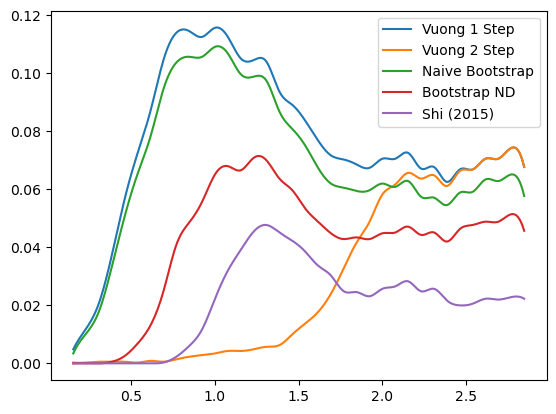

0.5 0.23227910480433808


In [9]:
nobs =100
calc_c =lambda nobs: (5*nobs**(-1/2), 3*(nobs)**(-5/9))
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2)
print(c1,c2)

Quantiles: 1th: 0.58, 5th: 1.60, 10th: 2.66, 30th: 7.52, 50th: 13.01, 70th: 20.14, 90th: 32.51, 95th: 38.69, 99th: 49.43
bonus term 1.0666506079977183 // variance stats 16.77649392056925 //part1 23.22791048043381 //part2 21.77649392056925 16.77649392056925
-0.4777225980692683 -0.09598738115474996 2.5766386902492138
-2.611023814064705 -0.09598738115474996 0.4433374742537772
---
Quantiles: 1th: 0.68, 5th: 1.76, 10th: 3.09, 30th: 9.81, 50th: 16.86, 70th: 25.37, 90th: 39.43, 95th: 47.13, 99th: 61.43
bonus term 1.1999654369244988 // variance stats 14.357149602547508 //part1 23.22791048043381 //part2 19.35714960254751 14.357149602547508
-0.2703355110104511 -0.3985170526101159 2.7032002477365755
-2.6702663848594486 -0.3985170526101159 0.3032693738875776
---
Quantiles: 1th: 0.68, 5th: 1.74, 10th: 2.90, 30th: 8.54, 50th: 15.26, 70th: 23.91, 90th: 37.10, 95th: 44.03, 99th: 59.04
bonus term 1.4150097722564206 // variance stats 11.41537107082577 //part1 23.22791048043381 //part2 16.41537107082577 

Quantiles: 1th: 0.65, 5th: 1.76, 10th: 3.01, 30th: 8.84, 50th: 15.72, 70th: 23.85, 90th: 37.45, 95th: 45.34, 99th: 59.99
bonus term 0.613489397449895 // variance stats 32.86195910962078 //part1 23.22791048043381 //part2 37.86195910962078 32.86195910962078
-1.0993119697657656 0.32433167533469803 2.25305638367284
-2.3262907646655555 0.32433167533469803 1.0260775887730502
---
Quantiles: 1th: 0.68, 5th: 1.75, 10th: 2.89, 30th: 8.07, 50th: 14.20, 70th: 21.52, 90th: 34.06, 95th: 40.12, 99th: 50.80
bonus term 3.3348218007636397 // variance stats 1.9652628740506781 //part1 23.22791048043381 //part2 6.965262874050678 1.9652628740506781
2.789620274272059 -1.392494949099128 3.866540617412956
-3.8800233272552203 -1.392494949099128 -2.8031029841143233
---
Quantiles: 1th: 0.63, 5th: 1.62, 10th: 2.67, 30th: 7.52, 50th: 12.98, 70th: 19.80, 90th: 31.15, 95th: 37.35, 99th: 49.68
bonus term 0.6466701229357047 // variance stats 30.919257217243125 //part1 23.22791048043381 //part2 35.91925721724313 30.9192

Quantiles: 1th: 0.88, 5th: 2.01, 10th: 3.56, 30th: 10.34, 50th: 17.58, 70th: 26.49, 90th: 42.51, 95th: 50.55, 99th: 64.84
bonus term 0.6078359476632419 // variance stats 33.21411117544289 //part1 23.22791048043381 //part2 38.21411117544289 33.21411117544289
-1.0020740729274689 0.2452328025242973 2.2840196674580877
-2.217745968253953 0.2452328025242973 1.0683477721316037
---
Quantiles: 1th: 0.77, 5th: 1.85, 10th: 3.42, 30th: 10.27, 50th: 18.66, 70th: 28.46, 90th: 44.69, 95th: 52.98, 99th: 69.26
bonus term 1.0086281318037393 // variance stats 18.029211409060263 //part1 23.22791048043381 //part2 23.02921140906026 18.029211409060263
-0.5344415209831234 -0.3232978406671539 2.5678200942135323
-2.5516977845906017 -0.3232978406671539 0.5505638306060537
---
Quantiles: 1th: 0.60, 5th: 1.71, 10th: 2.99, 30th: 8.79, 50th: 15.24, 70th: 23.40, 90th: 37.18, 95th: 44.15, 99th: 57.67
bonus term 0.5464085427580954 // variance stats 37.510152500886534 //part1 23.22791048043381 //part2 42.51015250088653 3

Quantiles: 1th: 0.57, 5th: 1.71, 10th: 3.15, 30th: 9.81, 50th: 17.04, 70th: 26.07, 90th: 40.09, 95th: 47.56, 99th: 63.27
bonus term 3.5238870241148454 // variance stats 1.5915593551891347 //part1 23.22791048043381 //part2 6.591559355189135 1.5915593551891347
3.049190285368427 -2.0136378930137457 3.99177880708479
-3.998583762861264 -2.0136378930137457 -3.0559952411449007
---
Quantiles: 1th: 0.60, 5th: 1.95, 10th: 3.47, 30th: 10.29, 50th: 17.64, 70th: 26.81, 90th: 42.96, 95th: 50.36, 99th: 64.73
bonus term 0.4868199207766106 // variance stats 42.71355790736532 //part1 23.22791048043381 //part2 47.71355790736532 42.71355790736532
-1.2856772664775886 0.41911055195034963 2.1317976533218976
-2.25931710803081 0.41911055195034963 1.1581578117686764
---
Quantiles: 1th: 0.65, 5th: 1.69, 10th: 2.81, 30th: 8.15, 50th: 14.26, 70th: 21.64, 90th: 35.13, 95th: 41.80, 99th: 54.31
bonus term 2.679165972030495 // variance stats 3.6698288657457705 //part1 23.22791048043381 //part2 8.669828865745771 3.6698

Quantiles: 1th: 0.66, 5th: 1.73, 10th: 2.93, 30th: 8.96, 50th: 15.75, 70th: 23.94, 90th: 37.87, 95th: 44.21, 99th: 58.09
bonus term 1.4675115221187114 // variance stats 10.82809411056524 //part1 23.22791048043381 //part2 15.82809411056524 10.82809411056524
0.06775166981479801 -0.8129810384627324 2.768309417366508
-2.8672713744226246 -0.8129810384627324 -0.1667136268709147
---
Quantiles: 1th: 0.78, 5th: 1.86, 10th: 3.09, 30th: 9.31, 50th: 16.13, 70th: 24.45, 90th: 38.41, 95th: 45.91, 99th: 60.45
bonus term 1.1233535957157976 // variance stats 15.677292144716956 //part1 23.22791048043381 //part2 20.677292144716954 15.677292144716956
-0.3342503619253563 -0.4225799548100247 2.680748763678937
-2.5809575533569515 -0.4225799548100247 0.43404157224734174
---
Quantiles: 1th: 0.72, 5th: 2.06, 10th: 3.48, 30th: 10.08, 50th: 18.01, 70th: 28.14, 90th: 44.30, 95th: 53.07, 99th: 67.47
bonus term 3.2364435932294726 // variance stats 2.1769860377068797 //part1 23.22791048043381 //part2 7.17698603770688

Quantiles: 1th: 1.06, 5th: 2.46, 10th: 4.22, 30th: 12.84, 50th: 22.36, 70th: 34.39, 90th: 54.53, 95th: 64.70, 99th: 83.04
bonus term 1.1660089356145906 // variance stats 14.920868332102986 //part1 23.22791048043381 //part2 19.920868332102984 14.920868332102986
-0.40192379360381403 -1.129763494615449 2.661858754174432
-2.7339416648329955 -1.129763494615449 0.3298408829452509
---
Quantiles: 1th: 0.76, 5th: 1.94, 10th: 3.37, 30th: 9.83, 50th: 17.18, 70th: 26.35, 90th: 41.98, 95th: 50.49, 99th: 65.36
bonus term 2.1524675034302545 // variance stats 5.791294383500295 //part1 23.22791048043381 //part2 10.791294383500297 5.791294383500295
1.0637909622985835 -2.138991724916552 3.158091545494171
-3.2411440445619255 -2.138991724916552 -1.146843461366338
---
Quantiles: 1th: 0.84, 5th: 1.94, 10th: 3.39, 30th: 10.23, 50th: 18.35, 70th: 28.20, 90th: 44.07, 95th: 52.78, 99th: 69.41
bonus term 3.027671136758889 // variance stats 2.6718736716231355 //part1 23.22791048043381 //part2 7.6718736716231355 2.

Quantiles: 1th: 0.72, 5th: 1.83, 10th: 3.26, 30th: 8.97, 50th: 15.64, 70th: 24.45, 90th: 38.56, 95th: 45.73, 99th: 59.43
bonus term 1.0967219988552606 // variance stats 16.179396879682088 //part1 23.22791048043381 //part2 21.179396879682088 16.179396879682088
-0.5514070127232138 -0.8351262367335185 2.610101100434162
-2.7448510104337354 -0.8351262367335185 0.41665710272364104
---
Quantiles: 1th: 0.80, 5th: 2.10, 10th: 3.37, 30th: 9.93, 50th: 17.36, 70th: 27.54, 90th: 44.33, 95th: 52.55, 99th: 68.47
bonus term 1.1739262730769378 // variance stats 14.786515570140477 //part1 23.22791048043381 //part2 19.786515570140477 14.786515570140477
-0.33572041359583 -0.5224071643916104 2.5561207736216898
-2.6835729597497053 -0.5224071643916104 0.20826822746781437
---
Quantiles: 1th: 0.93, 5th: 2.40, 10th: 4.09, 30th: 11.60, 50th: 19.84, 70th: 30.91, 90th: 49.10, 95th: 58.44, 99th: 78.11
bonus term 0.32377970081607677 // variance stats 66.7398602256058 //part1 23.22791048043381 //part2 71.739860225605

Quantiles: 1th: 0.71, 5th: 2.22, 10th: 4.08, 30th: 12.22, 50th: 21.17, 70th: 32.87, 90th: 52.51, 95th: 62.87, 99th: 81.38
bonus term 0.2305774546110722 // variance stats 95.73799504645245 //part1 23.22791048043381 //part2 100.73799504645245 95.73799504645245
-1.6895269018732255 1.1984533454667596 2.1531388893174914
-2.15068181109537 1.1984533454667596 1.6919839800953467
---
Quantiles: 1th: 0.70, 5th: 1.88, 10th: 3.20, 30th: 9.44, 50th: 16.21, 70th: 24.75, 90th: 38.64, 95th: 45.88, 99th: 59.41
bonus term 1.7509830593030626 // variance stats 8.265639754207063 //part1 23.22791048043381 //part2 13.265639754207061 8.265639754207063
0.5796310362921495 -1.3217332343578405 2.9885131663693767
-2.9223350823139755 -1.3217332343578405 -0.5134529522367485
---
Quantiles: 1th: 0.76, 5th: 2.12, 10th: 3.80, 30th: 11.28, 50th: 19.74, 70th: 30.36, 90th: 47.79, 95th: 56.99, 99th: 77.22
bonus term 1.4514324697580183 // variance stats 11.003438647273992 //part1 23.22791048043381 //part2 16.003438647273992 1

Quantiles: 1th: 0.72, 5th: 1.52, 10th: 2.41, 30th: 6.58, 50th: 11.81, 70th: 17.89, 90th: 28.63, 95th: 33.89, 99th: 45.06
bonus term 2.1295826469347015 // variance stats 5.907259464133883 //part1 23.22791048043381 //part2 10.907259464133883 5.907259464133883
0.9950972063503115 -1.755773284008129 3.1959843156884573
-3.2640680875190915 -1.755773284008129 -1.0631809781809456
---
Quantiles: 1th: 0.92, 5th: 2.16, 10th: 3.60, 30th: 10.15, 50th: 17.75, 70th: 27.60, 90th: 43.65, 95th: 51.27, 99th: 67.59
bonus term 1.9885607534949932 // variance stats 6.680764814255545 //part1 23.22791048043381 //part2 11.680764814255545 6.680764814255545
0.8141550624444852 -2.5717480200557308 3.127821615632644
-3.1629664445455012 -2.5717480200557308 -0.8492998913573424
---
Quantiles: 1th: 0.88, 5th: 2.29, 10th: 4.03, 30th: 11.90, 50th: 20.53, 70th: 31.43, 90th: 50.65, 95th: 59.94, 99th: 78.03
bonus term 1.297193883349154 // variance stats 12.906275059255547 //part1 23.22791048043381 //part2 17.90627505925555 12

Quantiles: 1th: 0.62, 5th: 1.79, 10th: 3.32, 30th: 10.06, 50th: 17.36, 70th: 26.77, 90th: 41.84, 95th: 48.51, 99th: 62.81
bonus term 1.5795700382942113 // variance stats 9.705210859480339 //part1 23.22791048043381 //part2 14.705210859480339 9.705210859480339
0.12397171595854554 -2.712053531455024 2.8497526160947495
-3.035168360629877 -2.712053531455024 -0.3093874604936727
---
Quantiles: 1th: 0.72, 5th: 1.89, 10th: 3.31, 30th: 9.36, 50th: 16.87, 70th: 25.57, 90th: 40.19, 95th: 48.13, 99th: 63.32
bonus term 0.7672117995907309 // variance stats 25.275747183274206 //part1 23.22791048043381 //part2 30.275747183274206 25.275747183274206
-0.893508899458208 -0.4694179722827343 2.437130456064702
-2.42793249863967 -0.4694179722827343 0.9027068568832401
---
Quantiles: 1th: 0.68, 5th: 1.63, 10th: 2.83, 30th: 8.99, 50th: 15.24, 70th: 23.40, 90th: 37.19, 95th: 45.32, 99th: 58.93
bonus term 2.121580005754221 // variance stats 5.9484018596679284 //part1 23.22791048043381 //part2 10.948401859667928 5.9

Quantiles: 1th: 0.69, 5th: 1.92, 10th: 3.39, 30th: 9.32, 50th: 16.45, 70th: 24.91, 90th: 39.93, 95th: 47.89, 99th: 61.43
bonus term 2.1043438324058124 // variance stats 6.038077581589063 //part1 23.22791048043381 //part2 11.038077581589063 6.038077581589063
0.9484033011633815 -2.3296869236615456 3.2772604828726615
-3.260284363648243 -2.3296869236615456 -0.9314271819389633
---
Quantiles: 1th: 0.78, 5th: 1.91, 10th: 3.11, 30th: 8.98, 50th: 15.39, 70th: 23.64, 90th: 37.52, 95th: 44.34, 99th: 57.31
bonus term 0.9135920225666178 // variance stats 20.424817540742115 //part1 23.22791048043381 //part2 25.424817540742115 20.424817540742115
-0.7862288250498055 -1.289976252366561 2.400674988416754
-2.613412870183041 -1.289976252366561 0.5734909432835186
---
Quantiles: 1th: 0.72, 5th: 1.90, 10th: 3.16, 30th: 9.49, 50th: 16.68, 70th: 25.82, 90th: 40.42, 95th: 47.78, 99th: 63.89
bonus term 1.8029438083651983 // variance stats 7.883324689689298 //part1 23.22791048043381 //part2 12.883324689689298 7.8

Quantiles: 1th: 0.72, 5th: 1.76, 10th: 3.05, 30th: 8.47, 50th: 14.43, 70th: 22.35, 90th: 35.11, 95th: 41.80, 99th: 54.70
bonus term 1.490496264147037 // variance stats 10.58401120429939 //part1 23.22791048043381 //part2 15.58401120429939 10.58401120429939
0.10705504923748138 -1.4463591687007245 2.842803322524314
-2.8739374790565924 -1.4463591687007245 -0.13818920576975985
---
Quantiles: 1th: 0.76, 5th: 1.90, 10th: 3.26, 30th: 9.50, 50th: 16.68, 70th: 26.07, 90th: 41.61, 95th: 49.34, 99th: 65.74
bonus term 0.425420487828857 // variance stats 49.59988680605857 //part1 23.22791048043381 //part2 54.59988680605857 49.59988680605857
-1.3311469575667092 0.404541259507113 2.202935320137158
-2.1819879332244234 0.404541259507113 1.352094344479444
---
Quantiles: 1th: 0.82, 5th: 2.02, 10th: 3.62, 30th: 10.66, 50th: 18.41, 70th: 28.44, 90th: 45.50, 95th: 53.92, 99th: 69.49
bonus term 0.8892187784296584 // variance stats 21.121704853617477 //part1 23.22791048043381 //part2 26.121704853617477 21.1217

Quantiles: 1th: 0.76, 5th: 1.82, 10th: 3.18, 30th: 9.32, 50th: 16.32, 70th: 25.44, 90th: 40.61, 95th: 48.42, 99th: 61.91
bonus term 1.350675058290182 // variance stats 12.197260242473117 //part1 23.22791048043381 //part2 17.197260242473117 12.197260242473117
-0.06996429675392475 -1.9340224002293347 2.768101780665728
-2.7713144133342893 -1.9340224002293347 0.06675166408536426
---
Quantiles: 1th: 0.63, 5th: 1.80, 10th: 3.18, 30th: 9.29, 50th: 16.24, 70th: 25.03, 90th: 39.86, 95th: 47.34, 99th: 61.73
bonus term 0.9929506086882464 // variance stats 18.392815591421428 //part1 23.22791048043381 //part2 23.39281559142143 18.392815591421428
-0.5791439503433612 -1.5397577607118105 2.502353716922846
-2.5650451677198536 -1.5397577607118105 0.516452499546353
---
Quantiles: 1th: 0.77, 5th: 1.88, 10th: 3.16, 30th: 9.07, 50th: 15.62, 70th: 23.84, 90th: 36.34, 95th: 44.00, 99th: 59.13
bonus term 1.5573975714007542 // variance stats 9.914567036047298 //part1 23.22791048043381 //part2 14.914567036047298

Quantiles: 1th: 0.63, 5th: 1.67, 10th: 2.69, 30th: 7.05, 50th: 12.31, 70th: 18.84, 90th: 30.63, 95th: 36.99, 99th: 47.89
bonus term 0.5420645520735891 // variance stats 37.850819872981575 //part1 23.22791048043381 //part2 42.850819872981575 37.850819872981575
-1.0680343019634904 0.06659681639046594 2.3029457437076073
-2.152163406110668 0.06659681639046594 1.2188166395604294
---
Quantiles: 1th: 0.61, 5th: 1.65, 10th: 2.87, 30th: 8.39, 50th: 14.53, 70th: 21.91, 90th: 34.78, 95th: 41.61, 99th: 55.91
bonus term 1.858850339932859 // variance stats 7.495847557729038 //part1 23.22791048043381 //part2 12.49584755772904 7.495847557729038
0.4443582962624024 -3.474837878210649 3.1753478502197217
-3.2733423836033158 -3.474837878210649 -0.5423528296459963
---
Quantiles: 1th: 0.59, 5th: 1.68, 10th: 2.91, 30th: 8.53, 50th: 14.82, 70th: 22.54, 90th: 35.91, 95th: 42.47, 99th: 53.46
bonus term 0.8192655401563278 // variance stats 23.352114597669498 //part1 23.22791048043381 //part2 28.352114597669498 23

Quantiles: 1th: 0.71, 5th: 1.83, 10th: 3.04, 30th: 9.07, 50th: 16.25, 70th: 24.68, 90th: 39.04, 95th: 46.60, 99th: 60.84
bonus term 0.8564951569825697 // variance stats 22.1197219167773 //part1 23.22791048043381 //part2 27.1197219167773 22.1197219167773
-0.6956283458457126 -1.9734165526306666 2.4562009439594474
-2.408618659810852 -1.9734165526306666 0.7432106299943079
---
Quantiles: 1th: 0.61, 5th: 1.72, 10th: 3.25, 30th: 8.75, 50th: 15.14, 70th: 23.53, 90th: 37.64, 95th: 44.56, 99th: 59.22
bonus term 0.901607457317183 // variance stats 20.762775465001834 //part1 23.22791048043381 //part2 25.762775465001834 20.762775465001834
-0.6540083149973661 -1.3480972699813842 2.452087427931239
-2.457223229631732 -1.3480972699813842 0.6488725132968731
---
Quantiles: 1th: 0.71, 5th: 1.76, 10th: 3.01, 30th: 8.95, 50th: 15.88, 70th: 24.16, 90th: 38.69, 95th: 46.76, 99th: 59.62
bonus term 1.486263995886293 // variance stats 10.62838805536864 //part1 23.22791048043381 //part2 15.62838805536864 10.62838

Quantiles: 1th: 0.67, 5th: 1.94, 10th: 3.47, 30th: 9.81, 50th: 17.10, 70th: 26.53, 90th: 41.10, 95th: 48.91, 99th: 66.58
bonus term 1.377281180090366 // variance stats 11.865046016899601 //part1 23.22791048043381 //part2 16.8650460168996 11.865046016899601
-0.2951818268173982 -3.5558884233497223 2.7694922876106247
-3.0497441869981303 -3.5558884233497223 0.01492992742989268
---
Quantiles: 1th: 0.67, 5th: 1.64, 10th: 2.72, 30th: 7.76, 50th: 13.65, 70th: 21.14, 90th: 33.18, 95th: 38.82, 99th: 51.39
bonus term 1.0002482217330504 // variance stats 18.222146239049202 //part1 23.22791048043381 //part2 23.222146239049202 18.222146239049202
-0.6080673462716586 -1.8814921882987425 2.624860102490024
-2.6085637897377594 -1.8814921882987425 0.6243636590239232
---
Quantiles: 1th: 0.68, 5th: 1.68, 10th: 3.02, 30th: 8.96, 50th: 16.22, 70th: 24.50, 90th: 38.81, 95th: 46.19, 99th: 61.29
bonus term 2.0269335023690673 // variance stats 6.4596312376726575 //part1 23.22791048043381 //part2 11.45963123767265

Quantiles: 1th: 0.68, 5th: 1.63, 10th: 2.88, 30th: 8.21, 50th: 14.63, 70th: 22.27, 90th: 35.17, 95th: 41.64, 99th: 55.23
bonus term 0.46989679979917653 // variance stats 44.43194014166707 //part1 23.22791048043381 //part2 49.43194014166707 44.43194014166707
-1.2465538143314305 0.09937910613699512 2.256267248305645
-2.186347413929784 0.09937910613699512 1.3164736487072923
---
Quantiles: 1th: 0.63, 5th: 1.68, 10th: 2.87, 30th: 7.99, 50th: 13.71, 70th: 21.32, 90th: 33.20, 95th: 40.05, 99th: 52.55
bonus term 0.5794172550428857 // variance stats 35.08839964338755 //part1 23.22791048043381 //part2 40.08839964338755 35.08839964338755
-1.1550659278676796 -0.5612070698664984 2.347628208366665
-2.313900437953451 -0.5612070698664984 1.1887936982808935
---
Quantiles: 1th: 0.72, 5th: 2.11, 10th: 4.00, 30th: 11.21, 50th: 19.36, 70th: 30.22, 90th: 47.17, 95th: 56.50, 99th: 76.75
bonus term 0.3811420509059114 // variance stats 55.94292252776864 //part1 23.22791048043381 //part2 60.94292252776864 55.94

Quantiles: 1th: 0.67, 5th: 2.08, 10th: 3.82, 30th: 11.07, 50th: 18.97, 70th: 29.29, 90th: 45.47, 95th: 54.47, 99th: 71.35
bonus term 0.6011959958501216 // variance stats 33.63616963647332 //part1 23.22791048043381 //part2 38.63616963647332 33.63616963647332
-0.9096556563012409 -1.124798561501323 2.3904609994591377
-2.112047648001484 -1.124798561501323 1.1880690077588945
---
Quantiles: 1th: 0.73, 5th: 2.06, 10th: 3.50, 30th: 10.03, 50th: 17.60, 70th: 27.23, 90th: 42.85, 95th: 52.33, 99th: 68.83
bonus term 0.6869861479966903 // variance stats 28.81132290391642 //part1 23.22791048043381 //part2 33.81132290391642 28.81132290391642
-1.0882615340407267 -1.21122130272118 2.340301065834255
-2.4622338300341076 -1.21122130272118 0.9663287698408743
---
Quantiles: 1th: 0.66, 5th: 1.65, 10th: 2.80, 30th: 8.82, 50th: 15.11, 70th: 23.22, 90th: 37.40, 95th: 44.17, 99th: 56.84
bonus term 1.2163635410903226 // variance stats 14.09619097890159 //part1 23.22791048043381 //part2 19.09619097890159 14.096190

Quantiles: 1th: 0.72, 5th: 1.85, 10th: 3.20, 30th: 10.04, 50th: 17.32, 70th: 26.57, 90th: 41.69, 95th: 49.51, 99th: 63.43
bonus term 0.5929274959820529 // variance stats 34.17495922829811 //part1 23.22791048043381 //part2 39.17495922829811 34.17495922829811
-1.1869457635750027 -1.0238208335200645 2.3364927638780824
-2.372800755539109 -1.0238208335200645 1.1506377719139766
---
Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.40, 30th: 10.06, 50th: 17.50, 70th: 26.92, 90th: 43.18, 95th: 50.95, 99th: 64.99
bonus term 1.6244486723945475 // variance stats 9.298950083904032 //part1 23.22791048043381 //part2 14.298950083904032 9.298950083904032
0.29338141633106246 -4.447506889720347 2.845209754582703
-2.9555159284580323 -4.447506889720347 -0.4036875902063917
---
Quantiles: 1th: 0.58, 5th: 1.78, 10th: 3.06, 30th: 9.12, 50th: 15.76, 70th: 24.56, 90th: 38.23, 95th: 45.29, 99th: 58.37
bonus term 0.7067052724630409 // variance stats 27.867889041606908 //part1 23.22791048043381 //part2 32.86788904160691 27

Quantiles: 1th: 0.72, 5th: 1.91, 10th: 3.26, 30th: 9.99, 50th: 17.76, 70th: 27.41, 90th: 42.90, 95th: 51.55, 99th: 66.92
bonus term 0.42978215720886925 // variance stats 49.0457766587674 //part1 23.22791048043381 //part2 54.0457766587674 49.0457766587674
-1.339390456227859 -0.31376806838050203 2.289858662182158
-2.198954770645597 -0.31376806838050203 1.4302943477644197
---
Quantiles: 1th: 0.65, 5th: 1.87, 10th: 3.51, 30th: 10.29, 50th: 18.01, 70th: 27.37, 90th: 43.00, 95th: 50.65, 99th: 65.50
bonus term 0.540262187414547 // variance stats 37.99377417396578 //part1 23.22791048043381 //part2 42.993774173965775 37.99377417396578
-1.221949965863939 -1.4272602137005832 2.3591445489219907
-2.302474340693033 -1.4272602137005832 1.2786201740928969
---
Quantiles: 1th: 0.65, 5th: 1.91, 10th: 3.20, 30th: 9.48, 50th: 16.77, 70th: 25.63, 90th: 41.01, 95th: 48.50, 99th: 64.72
bonus term 0.7812334134948268 // variance stats 24.732356654491227 //part1 23.22791048043381 //part2 29.732356654491227 24.73

Quantiles: 1th: 0.81, 5th: 2.02, 10th: 3.31, 30th: 9.47, 50th: 16.10, 70th: 24.94, 90th: 39.43, 95th: 46.59, 99th: 59.77
bonus term 0.9182583715625481 // variance stats 20.29561526447964 //part1 23.22791048043381 //part2 25.29561526447964 20.29561526447964
-0.7509697902949971 -3.1591248485867345 2.514861705993092
-2.587486533420093 -3.1591248485867345 0.6783449628679956
---
Quantiles: 1th: 0.61, 5th: 1.70, 10th: 2.89, 30th: 8.00, 50th: 14.02, 70th: 21.42, 90th: 34.78, 95th: 41.57, 99th: 55.40
bonus term 1.2502243714062566 // variance stats 13.578993508426791 //part1 23.22791048043381 //part2 18.57899350842679 13.578993508426791
-0.49245627617618654 -4.233067362293756 2.7604871330409555
-2.9929050189887 -4.233067362293756 0.2600383902284422
---
Quantiles: 1th: 0.66, 5th: 2.05, 10th: 3.79, 30th: 11.12, 50th: 19.56, 70th: 29.76, 90th: 48.10, 95th: 57.06, 99th: 76.24
bonus term 0.5468903146968022 // variance stats 37.47270404360963 //part1 23.22791048043381 //part2 42.472704043609625 37.47

Quantiles: 1th: 0.68, 5th: 1.94, 10th: 3.48, 30th: 10.05, 50th: 17.32, 70th: 26.49, 90th: 41.45, 95th: 49.96, 99th: 66.03
bonus term 1.1317489724251324 // variance stats 15.523906843635666 //part1 23.22791048043381 //part2 20.523906843635665 15.523906843635666
-0.5867294428402807 -4.01253202094502 2.5729844908421415
-2.8502273876905453 -4.01253202094502 0.3094865459918768
---
Quantiles: 1th: 0.76, 5th: 1.86, 10th: 3.31, 30th: 9.68, 50th: 16.81, 70th: 25.51, 90th: 40.14, 95th: 47.15, 99th: 62.25
bonus term 1.1080284820800603 // variance stats 15.963279244256363 //part1 23.22791048043381 //part2 20.963279244256363 15.963279244256363
-0.45794679575667296 -4.246705267799912 2.612675547409802
-2.6740037599167934 -4.246705267799912 0.396618583249681
---
Quantiles: 1th: 0.82, 5th: 2.08, 10th: 3.68, 30th: 11.12, 50th: 19.64, 70th: 29.93, 90th: 47.16, 95th: 56.24, 99th: 73.10
bonus term 0.7178540423902964 // variance stats 27.35742798506778 //part1 23.22791048043381 //part2 32.35742798506778 27

Quantiles: 1th: 0.65, 5th: 1.86, 10th: 3.42, 30th: 10.39, 50th: 18.24, 70th: 28.12, 90th: 43.88, 95th: 52.34, 99th: 68.13
bonus term 0.41242480197682085 // variance stats 51.32035311430971 //part1 23.22791048043381 //part2 56.32035311430971 51.32035311430971
-1.3679192202444141 -0.7947218891705702 2.174069691230214
-2.192768824198056 -0.7947218891705702 1.3492200872765725
---
Quantiles: 1th: 0.76, 5th: 1.88, 10th: 3.49, 30th: 10.33, 50th: 17.79, 70th: 27.21, 90th: 42.20, 95th: 51.22, 99th: 65.95
bonus term 0.37980623212429976 // variance stats 56.1572652468535 //part1 23.22791048043381 //part2 61.1572652468535 56.1572652468535
-1.6352364327664826 -0.6094066533791045 2.0693761379020166
-2.394848897015082 -0.6094066533791045 1.3097636736534173
---
Quantiles: 1th: 0.79, 5th: 2.04, 10th: 3.53, 30th: 10.42, 50th: 18.50, 70th: 28.28, 90th: 44.58, 95th: 53.00, 99th: 70.35
bonus term 0.5577129969820636 // variance stats 36.648501301074816 //part1 23.22791048043381 //part2 41.648501301074816 36

Quantiles: 1th: 0.75, 5th: 2.01, 10th: 3.31, 30th: 9.67, 50th: 16.80, 70th: 25.23, 90th: 39.63, 95th: 47.97, 99th: 62.21
bonus term 0.8247704741524455 // variance stats 23.162878289627646 //part1 23.22791048043381 //part2 28.162878289627646 23.162878289627646
-1.0289610841209906 -3.776864993362442 2.4538144909884934
-2.6785020324258815 -3.776864993362442 0.8042735426836024
---
Quantiles: 1th: 0.70, 5th: 1.88, 10th: 3.28, 30th: 9.22, 50th: 16.32, 70th: 25.12, 90th: 40.01, 95th: 47.87, 99th: 61.46
bonus term 1.280771602903084 // variance stats 13.135872491070108 //part1 23.22791048043381 //part2 18.13587249107011 13.135872491070108
-0.26938284455525724 -5.344996754090862 2.8105435810344295
-2.830926050361425 -5.344996754090862 0.2490003752282615
---
Quantiles: 1th: 0.82, 5th: 2.03, 10th: 3.58, 30th: 9.96, 50th: 17.32, 70th: 26.71, 90th: 43.04, 95th: 51.52, 99th: 68.04
bonus term 0.6524713197346682 // variance stats 30.599895011292748 //part1 23.22791048043381 //part2 35.599895011292745 3

Quantiles: 1th: 0.85, 5th: 2.19, 10th: 3.77, 30th: 10.81, 50th: 18.90, 70th: 28.66, 90th: 45.73, 95th: 54.05, 99th: 72.58
bonus term 0.4178424268904125 // variance stats 50.590119589569085 //part1 23.22791048043381 //part2 55.590119589569085 50.590119589569085
-1.3704154001287583 -0.9626971608998497 2.1367092703006474
-2.2061002539095833 -0.9626971608998497 1.301024416519822
---
Quantiles: 1th: 0.70, 5th: 1.57, 10th: 2.71, 30th: 7.69, 50th: 13.47, 70th: 20.71, 90th: 32.61, 95th: 38.96, 99th: 50.63
bonus term 0.5571219576809588 // variance stats 36.692685345091874 //part1 23.22791048043381 //part2 41.692685345091874 36.692685345091874
-1.3252476502935986 -1.4889973266646845 2.250853306425455
-2.4394915656555165 -1.4889973266646845 1.136609391063537
---
Quantiles: 1th: 0.81, 5th: 1.81, 10th: 3.20, 30th: 9.68, 50th: 16.98, 70th: 25.83, 90th: 41.37, 95th: 50.02, 99th: 63.77
bonus term 0.5469271599910648 // variance stats 37.469842749833965 //part1 23.22791048043381 //part2 42.4698427498339

Quantiles: 1th: 0.62, 5th: 1.90, 10th: 3.34, 30th: 9.82, 50th: 16.95, 70th: 25.90, 90th: 41.65, 95th: 49.26, 99th: 62.69
bonus term 0.5280432804109346 // variance stats 38.9886489273329 //part1 23.22791048043381 //part2 43.9886489273329 38.9886489273329
-1.3239834599954465 -1.6883293390572183 2.3443615672350426
-2.380070020817316 -1.6883293390572183 1.2882750064131734
---
Quantiles: 1th: 0.70, 5th: 1.93, 10th: 3.58, 30th: 10.99, 50th: 18.94, 70th: 28.51, 90th: 44.15, 95th: 52.60, 99th: 69.13
bonus term 1.260893380569139 // variance stats 13.421787946851822 //part1 23.22791048043381 //part2 18.421787946851822 13.421787946851822
-0.36617919428036727 -6.872603375280882 2.9276430889233285
-2.8879659554186454 -6.872603375280882 0.4058563277850505
---
Quantiles: 1th: 0.81, 5th: 2.27, 10th: 4.38, 30th: 12.37, 50th: 21.48, 70th: 32.78, 90th: 52.60, 95th: 62.56, 99th: 81.68
bonus term 0.878742436575342 // variance stats 21.433127061620276 //part1 23.22791048043381 //part2 26.433127061620276 21.

Quantiles: 1th: 0.83, 5th: 2.10, 10th: 3.80, 30th: 11.08, 50th: 19.38, 70th: 29.62, 90th: 46.43, 95th: 56.04, 99th: 75.54
bonus term 0.5050733932165652 // variance stats 40.98917858750511 //part1 23.22791048043381 //part2 45.98917858750511 40.98917858750511
-1.3225475038914654 -2.0891038698050086 2.1430092378301304
-2.3326942903245955 -2.0891038698050086 1.1328624513969998
---
Quantiles: 1th: 0.92, 5th: 2.14, 10th: 3.71, 30th: 10.69, 50th: 18.22, 70th: 27.87, 90th: 44.69, 95th: 52.95, 99th: 70.02
bonus term 0.5721920309722859 // variance stats 35.594606745858115 //part1 23.22791048043381 //part2 40.59460674585811 35.594606745858115
-1.3631979402418704 -2.8051214788135916 2.2915829949033197
-2.5075820021864423 -2.8051214788135916 1.1471989329587482
---
Quantiles: 1th: 0.76, 5th: 1.72, 10th: 2.90, 30th: 8.46, 50th: 14.58, 70th: 22.90, 90th: 35.90, 95th: 43.27, 99th: 57.07
bonus term 1.2008516803822593 // variance stats 14.342863785675696 //part1 23.22791048043381 //part2 19.3428637856756

Quantiles: 1th: 0.78, 5th: 2.06, 10th: 3.76, 30th: 10.37, 50th: 17.43, 70th: 26.29, 90th: 42.44, 95th: 50.14, 99th: 65.06
bonus term 0.6458660383615537 // variance stats 30.963975655631085 //part1 23.22791048043381 //part2 35.96397565563108 30.963975655631085
-1.2749621950259191 -3.954789260852759 2.2660170198505014
-2.566694271749027 -3.954789260852759 0.9742849431273939
---
Quantiles: 1th: 0.86, 5th: 2.37, 10th: 4.44, 30th: 13.72, 50th: 23.63, 70th: 36.20, 90th: 57.07, 95th: 68.45, 99th: 88.89
bonus term 1.1030714930404866 // variance stats 16.057484149471406 //part1 23.22791048043381 //part2 21.057484149471406 16.057484149471406
-0.4323362964536197 -7.470596930485658 2.4113761575274815
-2.638479282534593 -7.470596930485658 0.20523317144650816
---
Quantiles: 1th: 0.63, 5th: 1.61, 10th: 2.79, 30th: 8.52, 50th: 14.58, 70th: 22.50, 90th: 35.82, 95th: 42.35, 99th: 55.25
bonus term 1.1572590631006456 // variance stats 15.071487207193904 //part1 23.22791048043381 //part2 20.071487207193904

Quantiles: 1th: 0.85, 5th: 2.05, 10th: 3.50, 30th: 10.10, 50th: 18.02, 70th: 26.92, 90th: 43.43, 95th: 51.13, 99th: 67.37
bonus term 0.6416078872685659 // variance stats 31.202657325986102 //part1 23.22791048043381 //part2 36.2026573259861 31.202657325986102
-1.0581968703371871 -4.353795466429969 2.197963902200684
-2.341412644874319 -4.353795466429969 0.9147481276635522
---
Quantiles: 1th: 0.82, 5th: 1.94, 10th: 3.44, 30th: 9.49, 50th: 16.10, 70th: 25.07, 90th: 39.72, 95th: 47.57, 99th: 61.99
bonus term 1.0363023682811268 // variance stats 17.414221168828373 //part1 23.22791048043381 //part2 22.414221168828373 17.414221168828373
-0.845689843121893 -8.313456159752665 2.7558717789018945
-2.9182945796841464 -8.313456159752665 0.6832670423396413
---
Quantiles: 1th: 0.80, 5th: 2.10, 10th: 3.84, 30th: 10.69, 50th: 18.43, 70th: 27.96, 90th: 44.61, 95th: 52.14, 99th: 68.83
bonus term 0.4334233177880327 // variance stats 48.591741669499896 //part1 23.22791048043381 //part2 53.591741669499896 48

Quantiles: 1th: 0.59, 5th: 1.53, 10th: 2.75, 30th: 8.10, 50th: 14.07, 70th: 21.55, 90th: 35.01, 95th: 41.67, 99th: 54.75
bonus term 0.46883782889619025 // variance stats 44.54359279224654 //part1 23.22791048043381 //part2 49.54359279224654 44.54359279224654
-1.2008560345043595 -2.6361458591063 2.0737693413533553
-2.13853169229674 -2.6361458591063 1.136093683560975
---
Quantiles: 1th: 0.69, 5th: 1.65, 10th: 2.69, 30th: 7.20, 50th: 12.70, 70th: 19.42, 90th: 31.58, 95th: 37.83, 99th: 49.34
bonus term 0.8230709813245224 // variance stats 23.221029543593463 //part1 23.22791048043381 //part2 28.221029543593463 23.221029543593463
-1.1036609000308115 -4.982647253894355 2.61702774153718
-2.7498028626798567 -4.982647253894355 0.9708857788881349
---
Quantiles: 1th: 0.76, 5th: 1.93, 10th: 3.64, 30th: 10.41, 50th: 18.23, 70th: 27.76, 90th: 43.68, 95th: 52.19, 99th: 67.75
bonus term 1.01082674572884 // variance stats 17.97912137622131 //part1 23.22791048043381 //part2 22.979121376221308 17.979121376

Quantiles: 1th: 0.55, 5th: 1.59, 10th: 2.69, 30th: 7.67, 50th: 13.13, 70th: 20.22, 90th: 33.02, 95th: 39.47, 99th: 51.23
bonus term 0.9517315266904729 // variance stats 19.40594834680528 //part1 23.22791048043381 //part2 24.40594834680528 19.40594834680528
-0.8573467281258865 -7.258248075103776 2.4244098769084346
-2.7608097815068326 -7.258248075103776 0.5209468235274883
---
Quantiles: 1th: 0.66, 5th: 1.65, 10th: 2.86, 30th: 8.31, 50th: 14.18, 70th: 21.39, 90th: 34.61, 95th: 41.25, 99th: 52.62
bonus term 1.045043987471647 // variance stats 17.226729935675557 //part1 23.22791048043381 //part2 22.226729935675557 17.226729935675557
-0.7266018825274544 -7.081874066741598 2.475378523028697
-2.816689857470749 -7.081874066741598 0.38529054808540253
---
Quantiles: 1th: 0.51, 5th: 1.76, 10th: 3.17, 30th: 9.19, 50th: 16.23, 70th: 24.12, 90th: 38.51, 95th: 45.29, 99th: 61.00
bonus term 0.76433704421853 // variance stats 25.38961758576334 //part1 23.22791048043381 //part2 30.38961758576334 25.38961

Quantiles: 1th: 0.76, 5th: 2.05, 10th: 3.70, 30th: 11.32, 50th: 19.97, 70th: 30.79, 90th: 48.73, 95th: 58.30, 99th: 74.65
bonus term 0.6714548562398851 // variance stats 29.593406041485785 //part1 23.22791048043381 //part2 34.593406041485785 29.593406041485785
-1.12271557626543 -4.9035212196133475 2.3150518001706404
-2.4656252887452 -4.9035212196133475 0.9721420876908703
---
Quantiles: 1th: 0.67, 5th: 1.84, 10th: 3.14, 30th: 9.18, 50th: 16.07, 70th: 24.52, 90th: 38.90, 95th: 46.51, 99th: 60.83
bonus term 0.879904497134146 // variance stats 21.39821771122576 //part1 23.22791048043381 //part2 26.39821771122576 21.39821771122576
-1.391840204928056 -7.496785828856978 2.8657101806578327
-3.1516491991963482 -7.496785828856978 1.1059011863895405
---
Quantiles: 1th: 0.62, 5th: 1.66, 10th: 3.03, 30th: 8.89, 50th: 15.44, 70th: 23.73, 90th: 37.98, 95th: 44.91, 99th: 60.08
bonus term 0.9432412120107747 // variance stats 19.625631476509824 //part1 23.22791048043381 //part2 24.625631476509824 19.625

Quantiles: 1th: 0.71, 5th: 1.89, 10th: 3.16, 30th: 8.92, 50th: 15.35, 70th: 23.34, 90th: 37.63, 95th: 45.74, 99th: 59.99
bonus term 0.7220892329341123 // variance stats 27.16764552221659 //part1 23.22791048043381 //part2 32.16764552221659 27.16764552221659
-1.3528862260048071 -6.1679856167005385 2.4349457117771487
-2.797064691873032 -6.1679856167005385 0.990767245908924
---
Quantiles: 1th: 0.74, 5th: 1.98, 10th: 3.44, 30th: 10.28, 50th: 17.68, 70th: 27.10, 90th: 42.70, 95th: 50.02, 99th: 63.62
bonus term 0.6633988718021169 // variance stats 30.01349108016329 //part1 23.22791048043381 //part2 35.01349108016329 30.01349108016329
-1.3223318559483421 -5.2140348815173025 2.4074154317982597
-2.649129599552576 -5.2140348815173025 1.0806176881940257
---
Quantiles: 1th: 0.59, 5th: 1.62, 10th: 2.83, 30th: 8.50, 50th: 14.56, 70th: 23.02, 90th: 36.99, 95th: 43.57, 99th: 57.44
bonus term 0.6752471786187308 // variance stats 29.39912259677746 //part1 23.22791048043381 //part2 34.39912259677746 29.39

Quantiles: 1th: 0.65, 5th: 1.79, 10th: 3.22, 30th: 9.82, 50th: 16.36, 70th: 25.24, 90th: 40.09, 95th: 47.44, 99th: 63.02
bonus term 0.9080695549732608 // variance stats 20.57943976121717 //part1 23.22791048043381 //part2 25.57943976121717 20.57943976121717
-0.944522667577273 -6.322762640744292 2.548010060186619
-2.7606617775237945 -6.322762640744292 0.7318709502400972
---
Quantiles: 1th: 0.78, 5th: 1.96, 10th: 3.25, 30th: 9.77, 50th: 17.17, 70th: 25.80, 90th: 40.76, 95th: 48.87, 99th: 64.79
bonus term 0.804095086245816 // variance stats 23.887019554964567 //part1 23.22791048043381 //part2 28.887019554964567 23.887019554964567
-1.166334813690235 -7.056832299822554 2.53878851724205
-2.7745249861818673 -7.056832299822554 0.9305983447504178
---
Quantiles: 1th: 0.77, 5th: 2.07, 10th: 3.55, 30th: 10.29, 50th: 18.08, 70th: 28.48, 90th: 44.61, 95th: 52.58, 99th: 69.89
bonus term 0.7515968363172884 // variance stats 25.904747542907558 //part1 23.22791048043381 //part2 30.904747542907558 25.9047

Quantiles: 1th: 0.83, 5th: 2.02, 10th: 3.59, 30th: 10.26, 50th: 17.61, 70th: 27.50, 90th: 43.54, 95th: 52.23, 99th: 67.41
bonus term 0.827506293431853 // variance stats 23.069768973118606 //part1 23.22791048043381 //part2 28.069768973118606 23.069768973118606
-1.0628982626605017 -8.207855817656954 2.4724978617409232
-2.7179108495242077 -8.207855817656954 0.8174852748772173
---
Quantiles: 1th: 0.76, 5th: 2.14, 10th: 3.55, 30th: 9.90, 50th: 17.65, 70th: 26.73, 90th: 42.64, 95th: 50.58, 99th: 67.46
bonus term 0.648516205994218 // variance stats 30.817008527680343 //part1 23.22791048043381 //part2 35.81700852768034 30.817008527680343
-1.1670651197300352 -7.500673881028885 2.2931314605235396
-2.4640975317184712 -7.500673881028885 0.9960990485351033
---
Quantiles: 1th: 0.67, 5th: 1.93, 10th: 3.28, 30th: 9.55, 50th: 16.42, 70th: 24.81, 90th: 39.63, 95th: 46.99, 99th: 62.09
bonus term 0.5395421883804823 // variance stats 38.05114777058658 //part1 23.22791048043381 //part2 43.05114777058659 38.

Quantiles: 1th: 0.93, 5th: 2.34, 10th: 4.25, 30th: 13.21, 50th: 23.14, 70th: 34.89, 90th: 54.41, 95th: 65.31, 99th: 86.58
bonus term 0.5445197875495239 // variance stats 37.6576058603219 //part1 23.22791048043381 //part2 42.6576058603219 37.6576058603219
-1.5484904780060575 -5.7321439825299985 2.3361784933499803
-2.6375300531051056 -5.7321439825299985 1.2471389182509323
---
Quantiles: 1th: 0.87, 5th: 2.23, 10th: 3.84, 30th: 10.86, 50th: 19.04, 70th: 28.95, 90th: 45.84, 95th: 55.35, 99th: 73.84
bonus term 0.8345160620755766 // variance stats 22.83398850665886 //part1 23.22791048043381 //part2 27.83398850665886 22.83398850665886
-1.4142213204284038 -9.127958463157231 2.632327970077775
-3.0832534445795567 -9.127958463157231 0.9632958459266219
---
Quantiles: 1th: 0.73, 5th: 1.58, 10th: 2.57, 30th: 7.50, 50th: 13.31, 70th: 20.96, 90th: 33.58, 95th: 40.35, 99th: 51.88
bonus term 0.7394592564561273 // variance stats 26.41202206562944 //part1 23.22791048043381 //part2 31.41202206562944 26.4120

Quantiles: 1th: 0.58, 5th: 1.58, 10th: 2.86, 30th: 8.37, 50th: 14.21, 70th: 22.42, 90th: 36.18, 95th: 42.79, 99th: 56.20
bonus term 0.8170129763224577 // variance stats 23.43028342706058 //part1 23.22791048043381 //part2 28.43028342706058 23.43028342706058
-1.1154766225994683 -8.21845717754384 2.487115846328256
-2.749502575244384 -8.21845717754384 0.8530898936833409
---
Quantiles: 1th: 0.64, 5th: 1.46, 10th: 2.62, 30th: 7.57, 50th: 13.30, 70th: 20.07, 90th: 32.11, 95th: 38.46, 99th: 48.83
bonus term 0.8609666340788706 // variance stats 21.97887416425242 //part1 23.22791048043381 //part2 26.97887416425242 21.97887416425242
-0.9191245521335535 -10.073363615175044 2.3202279946761233
-2.641057820291295 -10.073363615175044 0.5982947265183818
---
Quantiles: 1th: 0.76, 5th: 1.96, 10th: 3.28, 30th: 8.86, 50th: 15.80, 70th: 24.33, 90th: 38.35, 95th: 45.86, 99th: 59.59
bonus term 0.7287428433283866 // variance stats 26.87394660967783 //part1 23.22791048043381 //part2 31.87394660967783 26.8739466

Quantiles: 1th: 0.78, 5th: 2.05, 10th: 3.59, 30th: 10.44, 50th: 18.04, 70th: 28.37, 90th: 44.38, 95th: 53.42, 99th: 70.43
bonus term 0.3659076047839049 // variance stats 58.48026162001083 //part1 23.22791048043381 //part2 63.48026162001083 58.48026162001083
-1.5443026186318938 -2.711531426777374 2.073753955155869
-2.2761178281997037 -2.711531426777374 1.3419387455880596
---
Quantiles: 1th: 0.68, 5th: 1.83, 10th: 3.43, 30th: 10.54, 50th: 18.54, 70th: 28.37, 90th: 44.28, 95th: 52.81, 99th: 68.83
bonus term 0.4362235717731386 // variance stats 48.247719709455914 //part1 23.22791048043381 //part2 53.247719709455914 48.247719709455914
-1.2858842167869786 -4.198151147385383 2.160759290939473
-2.1583313603332557 -4.198151147385383 1.288312147393196
---
Quantiles: 1th: 0.83, 5th: 2.11, 10th: 3.79, 30th: 11.47, 50th: 19.85, 70th: 30.95, 90th: 48.95, 95th: 58.23, 99th: 75.73
bonus term 0.8899885220757461 // variance stats 21.099112409066443 //part1 23.22791048043381 //part2 26.099112409066443 21

Quantiles: 1th: 0.73, 5th: 1.89, 10th: 3.25, 30th: 9.49, 50th: 17.06, 70th: 26.57, 90th: 42.51, 95th: 50.13, 99th: 65.21
bonus term 0.5140690420165853 // variance stats 40.18441800991472 //part1 23.22791048043381 //part2 45.18441800991472 40.18441800991472
-1.381957246360482 -4.874329455863142 2.2699947353566916
-2.4100953303936525 -4.874329455863142 1.2418566513235207
---
Quantiles: 1th: 0.83, 5th: 2.09, 10th: 3.77, 30th: 11.03, 50th: 19.36, 70th: 29.70, 90th: 48.76, 95th: 57.80, 99th: 73.29
bonus term 0.5922560242287084 // variance stats 34.219373936606864 //part1 23.22791048043381 //part2 39.219373936606864 34.219373936606864
-1.9488540894710398 -7.13874250992228 2.4984187857148843
-3.1333661379284563 -7.13874250992228 1.3139067372574675
---
Quantiles: 1th: 0.59, 5th: 1.69, 10th: 2.78, 30th: 8.29, 50th: 14.72, 70th: 22.65, 90th: 35.96, 95th: 43.12, 99th: 57.28
bonus term 0.667985401187446 // variance stats 29.773081027134207 //part1 23.22791048043381 //part2 34.77308102713421 29.773

Quantiles: 1th: 0.60, 5th: 1.56, 10th: 2.67, 30th: 7.82, 50th: 13.88, 70th: 21.43, 90th: 33.82, 95th: 40.23, 99th: 52.06
bonus term 0.6195500518087349 // variance stats 32.49158024056568 //part1 23.22791048043381 //part2 37.49158024056568 32.49158024056568
-1.2256425597785776 -6.156872298435081 2.1816262564937388
-2.464742663396047 -6.156872298435081 0.9425261528762691
---
Quantiles: 1th: 0.50, 5th: 1.42, 10th: 2.57, 30th: 7.68, 50th: 13.43, 70th: 20.66, 90th: 32.39, 95th: 38.53, 99th: 49.90
bonus term 0.8608669158146292 // variance stats 21.981999254151248 //part1 23.22791048043381 //part2 26.981999254151248 21.981999254151248
-1.242869351982765 -12.420088504512695 2.611822299164187
-2.9646031836120232 -12.420088504512695 0.8900884675349287
---
Quantiles: 1th: 0.89, 5th: 2.04, 10th: 3.31, 30th: 10.03, 50th: 17.61, 70th: 27.46, 90th: 43.43, 95th: 51.88, 99th: 67.88
bonus term 0.7984285547350567 // variance stats 24.092033773944305 //part1 23.22791048043381 //part2 29.092033773944305 24

Quantiles: 1th: 0.73, 5th: 1.83, 10th: 3.26, 30th: 9.60, 50th: 16.72, 70th: 25.65, 90th: 40.14, 95th: 47.44, 99th: 64.17
bonus term 0.5989241047897745 // variance stats 33.78272771904368 //part1 23.22791048043381 //part2 38.78272771904368 33.78272771904368
-1.897207482799836 -7.847993064909582 2.6870085386026883
-3.095055692379385 -7.847993064909582 1.4891603290231394
---
Quantiles: 1th: 0.88, 5th: 2.32, 10th: 4.15, 30th: 11.67, 50th: 20.97, 70th: 31.86, 90th: 51.03, 95th: 60.18, 99th: 80.82
bonus term 0.4240158814181336 // variance stats 49.780755859302666 //part1 23.22791048043381 //part2 54.780755859302666 49.780755859302666
-1.4136942617231467 -4.237053806620698 2.217562070320612
-2.261726024559414 -4.237053806620698 1.3695303074843448
---
Quantiles: 1th: 0.59, 5th: 1.65, 10th: 2.90, 30th: 8.38, 50th: 15.05, 70th: 22.54, 90th: 36.56, 95th: 43.82, 99th: 56.59
bonus term 0.6209104031145825 // variance stats 32.409440015691516 //part1 23.22791048043381 //part2 37.409440015691516 32.40

Quantiles: 1th: 0.72, 5th: 1.92, 10th: 3.67, 30th: 11.35, 50th: 21.12, 70th: 32.14, 90th: 50.67, 95th: 60.81, 99th: 78.74
bonus term 0.8479258419355258 // variance stats 22.39379947120423 //part1 23.22791048043381 //part2 27.39379947120423 22.39379947120423
-1.2749988993366077 -11.913768686350657 2.5170221972959355
-2.970850583207659 -11.913768686350657 0.8211705134248837
---
Quantiles: 1th: 0.76, 5th: 1.96, 10th: 3.56, 30th: 10.17, 50th: 17.54, 70th: 27.16, 90th: 42.98, 95th: 51.00, 99th: 65.49
bonus term 0.6979161064080599 // variance stats 28.281808898178426 //part1 23.22791048043381 //part2 33.281808898178426 28.281808898178426
-1.3581486938677536 -9.58215035513821 2.4183671324097067
-2.7539809066838736 -9.58215035513821 1.022534919593587
---
Quantiles: 1th: 0.67, 5th: 1.74, 10th: 2.90, 30th: 8.07, 50th: 14.02, 70th: 21.61, 90th: 34.33, 95th: 41.12, 99th: 54.00
bonus term 0.6998849842097753 // variance stats 28.18818235064713 //part1 23.22791048043381 //part2 33.188182350647125 28.

Quantiles: 1th: 0.85, 5th: 2.30, 10th: 3.93, 30th: 11.75, 50th: 20.53, 70th: 31.37, 90th: 50.64, 95th: 59.46, 99th: 79.13
bonus term 0.7384497986711273 // variance stats 26.4549621683606 //part1 23.22791048043381 //part2 31.4549621683606 26.4549621683606
-1.2489853738288017 -9.692241981275918 2.5820768566415357
-2.725884971171056 -9.692241981275918 1.1051772592992815
---
Quantiles: 1th: 0.59, 5th: 1.65, 10th: 2.80, 30th: 7.79, 50th: 13.15, 70th: 20.20, 90th: 31.81, 95th: 38.13, 99th: 50.25
bonus term 0.7971604849073742 // variance stats 24.138311444442415 //part1 23.22791048043381 //part2 29.138311444442415 24.138311444442415
-1.3675264577741493 -11.335844245515679 2.6029000629982733
-2.9618474275888977 -11.335844245515679 1.008579093183525
---
Quantiles: 1th: 0.74, 5th: 1.93, 10th: 3.62, 30th: 10.45, 50th: 18.43, 70th: 28.52, 90th: 45.72, 95th: 54.22, 99th: 70.28
bonus term 0.5436559858914931 // variance stats 37.72538348371982 //part1 23.22791048043381 //part2 42.72538348371981 37.72

Quantiles: 1th: 0.59, 5th: 1.63, 10th: 2.84, 30th: 8.21, 50th: 14.16, 70th: 21.86, 90th: 34.93, 95th: 41.39, 99th: 52.90
bonus term 0.6826189626287625 // variance stats 29.027637308789707 //part1 23.22791048043381 //part2 34.02763730878971 29.027637308789707
-1.2559244521610726 -8.902356110444707 2.4620290127939994
-2.621162377418598 -8.902356110444707 1.0967910875364744
---
Quantiles: 1th: 0.57, 5th: 1.42, 10th: 2.39, 30th: 6.52, 50th: 11.24, 70th: 16.89, 90th: 26.84, 95th: 32.03, 99th: 42.09
bonus term 0.7399182965769604 // variance stats 26.39253426748831 //part1 23.22791048043381 //part2 31.39253426748831 26.39253426748831
-1.6514664999998478 -9.969728444688146 2.7219698305516244
-3.1313030931537686 -9.969728444688146 1.2421332373977034
---
Quantiles: 1th: 0.72, 5th: 1.73, 10th: 2.89, 30th: 8.66, 50th: 15.04, 70th: 22.88, 90th: 36.11, 95th: 42.88, 99th: 56.91
bonus term 0.5244637167484838 // variance stats 39.288879742606056 //part1 23.22791048043381 //part2 44.288879742606056 39.2

Quantiles: 1th: 0.63, 5th: 1.81, 10th: 3.30, 30th: 10.39, 50th: 18.34, 70th: 28.72, 90th: 44.92, 95th: 53.96, 99th: 72.36
bonus term 0.8661798338287943 // variance stats 21.816498806903585 //part1 23.22791048043381 //part2 26.816498806903585 21.816498806903585
-1.4410405593333762 -11.884226399405295 2.612676368272778
-3.1734002269909647 -11.884226399405295 0.8803167006151893
---
Quantiles: 1th: 0.75, 5th: 2.10, 10th: 3.67, 30th: 11.40, 50th: 20.05, 70th: 29.81, 90th: 46.91, 95th: 56.67, 99th: 73.30
bonus term 0.494247608389015 // variance stats 41.99650556963639 //part1 23.22791048043381 //part2 46.99650556963639 41.99650556963639
-1.5834417150635811 -8.151862039106748 2.2180045161414697
-2.571936931841611 -8.151862039106748 1.2295092993634398
---
Quantiles: 1th: 0.68, 5th: 1.71, 10th: 3.06, 30th: 8.45, 50th: 14.99, 70th: 22.48, 90th: 36.13, 95th: 42.65, 99th: 57.24
bonus term 0.6924059146503583 // variance stats 28.546666758563326 //part1 23.22791048043381 //part2 33.546666758563326 2

Quantiles: 1th: 0.75, 5th: 1.69, 10th: 2.84, 30th: 7.91, 50th: 14.10, 70th: 21.71, 90th: 34.77, 95th: 41.27, 99th: 54.61
bonus term 0.7239559950428246 // variance stats 27.084699400907365 //part1 23.22791048043381 //part2 32.08469940090736 27.084699400907365
-1.6042480412419258 -10.657746633907015 2.5488400284705772
-3.052160031327575 -10.657746633907015 1.1009280383849276
---
Quantiles: 1th: 0.92, 5th: 2.15, 10th: 3.88, 30th: 11.65, 50th: 20.08, 70th: 30.95, 90th: 48.78, 95th: 57.86, 99th: 78.79
bonus term 0.6327903645087691 // variance stats 31.707117843783035 //part1 23.22791048043381 //part2 36.70711784378304 31.707117843783035
-1.8990127136125918 -11.09849501601461 2.4968897754727206
-3.16459344263013 -11.09849501601461 1.2313090464551828
---
Quantiles: 1th: 0.69, 5th: 1.72, 10th: 2.84, 30th: 8.48, 50th: 14.74, 70th: 22.35, 90th: 35.18, 95th: 41.62, 99th: 54.78
bonus term 0.7433335986234909 // variance stats 26.24829891107758 //part1 23.22791048043381 //part2 31.24829891107758 26.

Quantiles: 1th: 0.85, 5th: 2.57, 10th: 4.73, 30th: 13.83, 50th: 23.66, 70th: 36.21, 90th: 57.85, 95th: 68.43, 99th: 92.33
bonus term 0.5697577078935796 // variance stats 35.768049573753835 //part1 23.22791048043381 //part2 40.768049573753835 35.768049573753835
-1.6778251097689219 -10.184360372787564 2.589420418483055
-2.8173405255560806 -10.184360372787564 1.449905002695896
---
Quantiles: 1th: 0.83, 5th: 2.02, 10th: 3.50, 30th: 10.23, 50th: 18.16, 70th: 27.74, 90th: 44.11, 95th: 52.16, 99th: 68.48
bonus term 0.6729785192863736 // variance stats 29.51508453058009 //part1 23.22791048043381 //part2 34.51508453058009 29.51508453058009
-1.331966533387907 -11.401124985527249 2.467191048886999
-2.6779235719606542 -11.401124985527249 1.1212340103142517
---
Quantiles: 1th: 0.75, 5th: 1.78, 10th: 2.97, 30th: 8.56, 50th: 14.78, 70th: 22.78, 90th: 36.05, 95th: 43.11, 99th: 58.94
bonus term 0.4859241316948037 // variance stats 42.80151666767325 //part1 23.22791048043381 //part2 47.80151666767325 42

Quantiles: 1th: 0.72, 5th: 1.83, 10th: 3.29, 30th: 9.80, 50th: 16.94, 70th: 26.36, 90th: 41.72, 95th: 50.21, 99th: 66.78
bonus term 0.7388739246036434 // variance stats 26.436906496455443 //part1 23.22791048043381 //part2 31.436906496455443 26.436906496455443
-1.5851014471349976 -12.633688179170392 2.7149267762921743
-3.0628492963422844 -12.633688179170392 1.2371789270848879
---
Quantiles: 1th: 0.68, 5th: 1.87, 10th: 3.32, 30th: 10.64, 50th: 17.88, 70th: 27.01, 90th: 42.14, 95th: 49.71, 99th: 66.53
bonus term 0.7217467394340589 // variance stats 27.18291016963574 //part1 23.22791048043381 //part2 32.18291016963574 27.18291016963574
-1.6182428996313514 -12.52634889261341 2.487290945340331
-3.061736378499469 -12.52634889261341 1.0437974664722134
---
Quantiles: 1th: 0.66, 5th: 1.74, 10th: 3.34, 30th: 10.02, 50th: 17.59, 70th: 26.38, 90th: 41.44, 95th: 50.26, 99th: 64.13
bonus term 0.39549887501239983 // variance stats 53.730661319088604 //part1 23.22791048043381 //part2 58.730661319088604

Quantiles: 1th: 0.77, 5th: 2.18, 10th: 3.64, 30th: 11.14, 50th: 19.06, 70th: 29.54, 90th: 46.78, 95th: 54.78, 99th: 70.95
bonus term 0.6164211798961049 // variance stats 32.681882514726006 //part1 23.22791048043381 //part2 37.681882514726006 32.681882514726006
-1.7942615478229749 -11.437984138163806 2.582751869439373
-3.0271039076151847 -11.437984138163806 1.349909509647163
---
Quantiles: 1th: 0.67, 5th: 1.91, 10th: 3.56, 30th: 9.60, 50th: 16.74, 70th: 25.69, 90th: 40.24, 95th: 48.12, 99th: 63.57
bonus term 0.56693996488543 // variance stats 35.97067047500844 //part1 23.22791048043381 //part2 40.97067047500844 35.97067047500844
-1.5649066221729293 -10.222643382934521 2.594278893827886
-2.698786551943789 -10.222643382934521 1.4603989640570263
---
Quantiles: 1th: 0.86, 5th: 2.00, 10th: 3.38, 30th: 9.88, 50th: 17.41, 70th: 26.93, 90th: 42.66, 95th: 50.39, 99th: 66.81
bonus term 0.35050599020863094 // variance stats 61.269653384833475 //part1 23.22791048043381 //part2 66.26965338483348 61.

Quantiles: 1th: 0.58, 5th: 1.55, 10th: 2.58, 30th: 7.19, 50th: 12.30, 70th: 18.48, 90th: 30.04, 95th: 35.45, 99th: 46.80
bonus term 0.656918951138104 // variance stats 30.358868000674576 //part1 23.22791048043381 //part2 35.358868000674576 30.358868000674576
-1.7618527166257372 -12.006139003570523 2.745061806164545
-3.075690618901945 -12.006139003570523 1.4312239038883372
---
Quantiles: 1th: 0.59, 5th: 1.61, 10th: 2.59, 30th: 7.27, 50th: 12.44, 70th: 19.19, 90th: 30.67, 95th: 37.02, 99th: 48.91
bonus term 0.47548328925307576 // variance stats 43.8511605043406 //part1 23.22791048043381 //part2 48.8511605043406 43.8511605043406
-2.250746060644063 -8.630178292930712 2.537901200782857
-3.2017126391502146 -8.630178292930712 1.5869346222767053
---
Quantiles: 1th: 0.82, 5th: 2.04, 10th: 3.57, 30th: 10.60, 50th: 18.70, 70th: 29.34, 90th: 46.93, 95th: 55.83, 99th: 75.89
bonus term 0.37672360045256215 // variance stats 56.6576993119886 //part1 23.22791048043381 //part2 61.6576993119886 56.657699

Quantiles: 1th: 0.83, 5th: 2.21, 10th: 3.99, 30th: 11.57, 50th: 19.54, 70th: 29.73, 90th: 47.53, 95th: 56.34, 99th: 74.76
bonus term 0.6752508245256492 // variance stats 29.398936864314045 //part1 23.22791048043381 //part2 34.398936864314045 29.398936864314045
-1.920579863893307 -12.74181332040072 2.698037666159666
-3.271081512944605 -12.74181332040072 1.3475360171083675
---
Quantiles: 1th: 0.71, 5th: 1.73, 10th: 2.90, 30th: 8.65, 50th: 14.91, 70th: 22.44, 90th: 35.56, 95th: 42.08, 99th: 55.87
bonus term 0.6354479004552495 // variance stats 31.553603314752948 //part1 23.22791048043381 //part2 36.55360331475295 31.553603314752948
-1.3744921420398322 -12.321598288430328 2.1146433518708077
-2.6453879429503315 -12.321598288430328 0.8437475509603085
---
Quantiles: 1th: 0.65, 5th: 1.69, 10th: 2.91, 30th: 8.90, 50th: 15.71, 70th: 23.46, 90th: 38.18, 95th: 45.27, 99th: 60.27
bonus term 0.582932646116665 // variance stats 34.84664546611291 //part1 23.22791048043381 //part2 39.84664546611291 34.

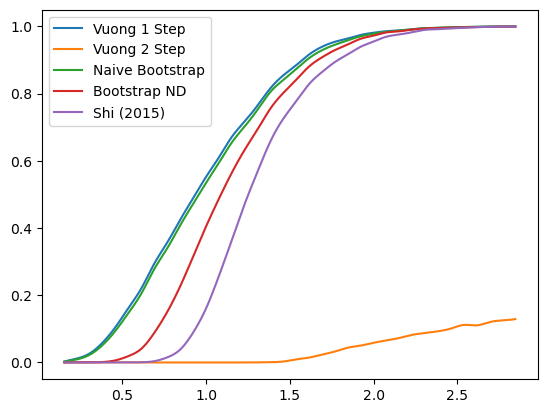

In [10]:
mc_run_power(nobs,c1,c2)

# sequence 3


Quantiles: 1th: 0.72, 5th: 1.76, 10th: 2.84, 30th: 8.86, 50th: 15.57, 70th: 23.15, 90th: 37.09, 95th: 44.90, 99th: 59.14
bonus term 1.092552893966905 // variance stats 11.260215966383608 //part1 23.22791048043381 //part2 21.260215966383605 11.260215966383608
0.15252720062117076 -0.38710848408592935 2.1345578532882854
-2.032578587312639 -0.38710848408592935 -0.05054793464552437
---
Quantiles: 1th: 0.88, 5th: 2.31, 10th: 3.87, 30th: 11.03, 50th: 19.45, 70th: 29.57, 90th: 46.15, 95th: 56.02, 99th: 72.68
bonus term 1.606381379245899 // variance stats 4.459773239738337 //part1 23.22791048043381 //part2 14.459773239738336 4.459773239738337
1.0382645427854351 -1.0011837478910226 2.2361017470162987
-2.174498215706363 -1.0011837478910226 -0.9766610114754993
---
Quantiles: 1th: 0.70, 5th: 1.68, 10th: 2.81, 30th: 8.02, 50th: 14.34, 70th: 21.66, 90th: 34.77, 95th: 41.54, 99th: 54.66
bonus term 0.8410063555784898 // variance stats 17.619185427506537 //part1 23.22791048043381 //part2 27.619185427506

Quantiles: 1th: 0.72, 5th: 2.00, 10th: 3.42, 30th: 9.94, 50th: 17.33, 70th: 26.60, 90th: 42.13, 95th: 50.15, 99th: 67.76
bonus term 0.6113982076183397 // variance stats 27.991459888174287 //part1 23.22791048043381 //part2 37.99145988817428 27.991459888174287
-0.8253061687063041 0.08273512432983875 2.0573137349709785
-2.048102583942984 0.08273512432983875 0.8345173197342991
---
Quantiles: 1th: 0.83, 5th: 2.05, 10th: 3.64, 30th: 10.11, 50th: 17.67, 70th: 26.98, 90th: 43.50, 95th: 51.51, 99th: 69.63
bonus term 1.83547145393772 // variance stats 2.655010477336448 //part1 23.22791048043381 //part2 12.655010477336448 2.655010477336448
1.4464371266329015 -1.0095796761545996 2.2097885707620395
-2.2245057812425384 -1.0095796761545996 -1.4611543371134004
---
Quantiles: 1th: 0.73, 5th: 1.86, 10th: 3.15, 30th: 9.21, 50th: 15.83, 70th: 24.03, 90th: 38.38, 95th: 46.22, 99th: 62.25
bonus term 0.415956377250457 // variance stats 45.84217901399729 //part1 23.22791048043381 //part2 55.84217901399729 45.

Quantiles: 1th: 0.82, 5th: 2.17, 10th: 3.77, 30th: 11.00, 50th: 19.23, 70th: 30.26, 90th: 47.19, 95th: 56.17, 99th: 73.94
bonus term 0.7815275120208249 // variance stats 19.721167998772728 //part1 23.22791048043381 //part2 29.721167998772728 19.721167998772728
-0.45113918040171197 -0.24506026193843566 2.095055415297896
-2.0141942044433616 -0.24506026193843566 0.5320003912562462
---
Quantiles: 1th: 0.64, 5th: 1.48, 10th: 2.59, 30th: 7.39, 50th: 12.55, 70th: 19.11, 90th: 30.56, 95th: 36.44, 99th: 48.05
bonus term 0.8914468167285711 // variance stats 16.05641755015238 //part1 23.22791048043381 //part2 26.05641755015238 16.05641755015238
-0.34114658234910583 -0.0779191910253472 2.1542555537093433
-2.124040215806248 -0.0779191910253472 0.3713619202522012
---
Quantiles: 1th: 0.78, 5th: 1.74, 10th: 2.98, 30th: 9.16, 50th: 15.85, 70th: 24.17, 90th: 38.10, 95th: 46.12, 99th: 58.76
bonus term 1.2549544163655912 // variance stats 8.50896747923559 //part1 23.22791048043381 //part2 18.5089674792355

Quantiles: 1th: 0.82, 5th: 1.96, 10th: 3.55, 30th: 10.49, 50th: 18.47, 70th: 28.71, 90th: 45.35, 95th: 54.16, 99th: 72.13
bonus term 0.621529544826844 // variance stats 27.37217429769171 //part1 23.22791048043381 //part2 37.372174297691714 27.37217429769171
-0.8087458285210922 -0.06495455280145708 2.1034222289455515
-2.05180491817478 -0.06495455280145708 0.8603631392918635
---
Quantiles: 1th: 0.62, 5th: 1.68, 10th: 2.89, 30th: 8.48, 50th: 14.29, 70th: 21.65, 90th: 34.82, 95th: 41.69, 99th: 53.33
bonus term 0.6532099264783077 // variance stats 25.559640995757555 //part1 23.22791048043381 //part2 35.559640995757555 25.559640995757555
-0.8173079369695173 0.15977133007515418 2.11140311975711
-2.1237277899261326 0.15977133007515418 0.8049832668004946
---
Quantiles: 1th: 0.64, 5th: 1.79, 10th: 3.16, 30th: 9.08, 50th: 15.66, 70th: 24.51, 90th: 38.99, 95th: 46.22, 99th: 61.01
bonus term 0.37927314076338786 // variance stats 51.243225485678934 //part1 23.22791048043381 //part2 61.24322548567893

Quantiles: 1th: 0.77, 5th: 1.92, 10th: 3.40, 30th: 9.85, 50th: 17.43, 70th: 26.65, 90th: 42.33, 95th: 50.73, 99th: 63.98
bonus term 0.5979993556838872 // variance stats 28.84270151741181 //part1 23.22791048043381 //part2 38.84270151741181 28.84270151741181
-0.8045950915303444 0.06153133942239253 2.0928772578258887
-2.0005938028981185 0.06153133942239253 0.8968785464581142
---
Quantiles: 1th: 0.56, 5th: 1.51, 10th: 2.60, 30th: 7.44, 50th: 12.94, 70th: 19.88, 90th: 31.38, 95th: 37.42, 99th: 49.23
bonus term 1.2508011689561342 // variance stats 8.570425945331376 //part1 23.22791048043381 //part2 18.570425945331376 8.570425945331376
0.2900683423773379 -0.7472811412634616 2.1840818335229493
-2.2115339955349307 -0.7472811412634616 -0.31752050438931895
---
Quantiles: 1th: 0.76, 5th: 2.14, 10th: 3.92, 30th: 11.30, 50th: 19.77, 70th: 30.74, 90th: 48.50, 95th: 57.09, 99th: 75.13
bonus term 0.26688810673791546 // variance stats 77.03239257957512 //part1 23.22791048043381 //part2 87.03239257957513

Quantiles: 1th: 0.78, 5th: 2.15, 10th: 3.76, 30th: 10.39, 50th: 19.07, 70th: 30.16, 90th: 48.08, 95th: 57.66, 99th: 75.09
bonus term 0.787979355159506 // variance stats 19.47781604726423 //part1 23.22791048043381 //part2 29.47781604726423 19.47781604726423
-0.5539657371721706 -0.4122796883223558 2.1333911889188335
-2.1299244474911827 -0.4122796883223558 0.5574324785998214
---
Quantiles: 1th: 0.71, 5th: 1.78, 10th: 2.95, 30th: 8.30, 50th: 14.63, 70th: 22.83, 90th: 36.04, 95th: 42.52, 99th: 56.24
bonus term 0.9449450751064487 // variance stats 14.581228150024666 //part1 23.22791048043381 //part2 24.581228150024668 14.581228150024666
-0.26561452545314973 -0.32675533015035974 2.0710508776942342
-2.155504675666047 -0.32675533015035974 0.18116072748133663
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.66, 5th: 1.78, 10th: 3.07, 30th: 9.23, 50th: 16.80, 70th: 25.53, 90th: 40.87, 95th: 48.58, 99th: 63.96
bonus term 0.9889935062888775 // variance stats 13.486413543396017 //part1 23.227910

Quantiles: 1th: 0.63, 5th: 1.86, 10th: 3.48, 30th: 11.02, 50th: 19.10, 70th: 28.07, 90th: 44.50, 95th: 53.06, 99th: 72.27
bonus term 0.5035492405046285 // variance stats 36.12837953475238 //part1 23.22791048043381 //part2 46.12837953475238 36.12837953475238
-1.0114903253484453 0.1904250942532373 1.9947537125825598
-2.018588806357702 0.1904250942532373 0.9876552315733028
---
Quantiles: 1th: 0.83, 5th: 2.33, 10th: 4.38, 30th: 12.56, 50th: 21.99, 70th: 34.28, 90th: 54.11, 95th: 65.68, 99th: 85.35
bonus term 0.4233687992345563 // variance stats 44.86448345373935 //part1 23.22791048043381 //part2 54.86448345373935 44.86448345373935
-1.1195841840430456 0.22597998034812156 1.9476580866804851
-1.9663217825121582 0.22597998034812156 1.1009204882113726
---
Quantiles: 1th: 0.67, 5th: 1.77, 10th: 3.13, 30th: 8.92, 50th: 15.74, 70th: 24.46, 90th: 37.91, 95th: 45.03, 99th: 58.31
bonus term 0.5273708018636956 // variance stats 34.04474119224617 //part1 23.22791048043381 //part2 44.04474119224617 34.0

Quantiles: 1th: 0.72, 5th: 2.01, 10th: 3.45, 30th: 10.25, 50th: 17.93, 70th: 27.08, 90th: 42.86, 95th: 51.58, 99th: 67.72
bonus term 1.558451407201215 // variance stats 4.904481700939427 //part1 23.22791048043381 //part2 14.904481700939428 4.904481700939427
0.8963122491376957 -1.619346799996447 2.2103473551890414
-2.220590565264734 -1.619346799996447 -0.906555459213389
---
Quantiles: 1th: 0.71, 5th: 1.94, 10th: 3.15, 30th: 9.29, 50th: 15.85, 70th: 24.16, 90th: 38.37, 95th: 46.09, 99th: 59.79
bonus term 0.39790289837239123 // variance stats 48.37582630196165 //part1 23.22791048043381 //part2 58.37582630196165 48.37582630196165
-1.1147669041344628 0.5129969246838145 1.9485502654487936
-1.9105727008792455 0.5129969246838145 1.152744468704011
---
Quantiles: 1th: 0.79, 5th: 2.10, 10th: 3.50, 30th: 10.02, 50th: 17.50, 70th: 26.50, 90th: 42.93, 95th: 51.11, 99th: 67.53
bonus term 0.5159026295655519 // variance stats 35.02382649220905 //part1 23.22791048043381 //part2 45.023826492209054 35.023

Quantiles: 1th: 0.86, 5th: 2.21, 10th: 4.16, 30th: 11.27, 50th: 19.31, 70th: 29.45, 90th: 47.38, 95th: 55.84, 99th: 72.43
bonus term 0.8794241471892972 // variance stats 16.41263667215857 //part1 23.22791048043381 //part2 26.41263667215857 16.41263667215857
-0.3405872896060281 -0.8075908339486403 2.0430316221146594
-2.099435583984622 -0.8075908339486403 0.2841833277360649
---
Quantiles: 1th: 0.72, 5th: 2.01, 10th: 3.70, 30th: 11.75, 50th: 20.63, 70th: 31.86, 90th: 49.42, 95th: 58.48, 99th: 78.78
bonus term 0.36307293372541927 // variance stats 53.97588011338888 //part1 23.22791048043381 //part2 63.97588011338888 53.97588011338888
-1.2609752817483049 0.377609493711878 1.9913242520470484
-1.9871211491991434 0.377609493711878 1.26517838459621
---
Quantiles: 1th: 0.68, 5th: 1.59, 10th: 2.76, 30th: 7.94, 50th: 14.02, 70th: 21.36, 90th: 33.73, 95th: 40.82, 99th: 53.24
bonus term 0.3645177994612734 // variance stats 53.72229426042488 //part1 23.22791048043381 //part2 63.72229426042488 53.7222

Quantiles: 1th: 0.69, 5th: 2.12, 10th: 3.85, 30th: 11.23, 50th: 19.44, 70th: 29.70, 90th: 46.10, 95th: 54.92, 99th: 71.61
bonus term 1.2098662600205086 // variance stats 9.198742247791975 //part1 23.22791048043381 //part2 19.198742247791976 9.198742247791975
0.1651595703520575 -1.216177420809674 2.203621058968656
-2.2545729496889595 -1.216177420809674 -0.21611146107236145
---
Quantiles: 1th: 0.89, 5th: 1.98, 10th: 3.27, 30th: 9.45, 50th: 16.46, 70th: 25.51, 90th: 39.74, 95th: 47.07, 99th: 61.56
bonus term 0.6374687296331817 // variance stats 26.43772533564091 //part1 23.22791048043381 //part2 36.437725335640906 26.43772533564091
-0.8028837248424979 -0.5232261278775145 1.9702395467573577
-2.077821184108861 -0.5232261278775145 0.6953020874909944
---
Quantiles: 1th: 0.64, 5th: 1.69, 10th: 2.98, 30th: 8.45, 50th: 14.73, 70th: 22.09, 90th: 35.69, 95th: 43.20, 99th: 54.58
bonus term 0.5395983469017441 // variance stats 33.0466672364795 //part1 23.22791048043381 //part2 43.04666723647949 33.0

Quantiles: 1th: 0.70, 5th: 1.74, 10th: 2.85, 30th: 7.97, 50th: 13.81, 70th: 21.12, 90th: 33.99, 95th: 40.78, 99th: 53.77
bonus term 0.4301311214842507 // variance stats 44.00192945881574 //part1 23.22791048043381 //part2 54.00192945881574 44.00192945881574
-1.1344672228162704 0.1445676222961153 2.0743306747431247
-1.9947294657847718 0.1445676222961153 1.214068431774623
---
Quantiles: 1th: 0.81, 5th: 2.31, 10th: 4.06, 30th: 12.44, 50th: 21.45, 70th: 33.00, 90th: 52.71, 95th: 63.09, 99th: 81.23
bonus term 0.408560183268584 // variance stats 46.8530939422552 //part1 23.22791048043381 //part2 56.8530939422552 46.8530939422552
-1.0790688702978724 0.05405615974587322 2.054487397722034
-1.8961892368350406 0.05405615974587322 1.2373670311848657
---
Quantiles: 1th: 0.62, 5th: 1.67, 10th: 3.10, 30th: 9.04, 50th: 15.75, 70th: 24.04, 90th: 38.69, 95th: 45.48, 99th: 60.09
bonus term 0.4977888429972792 // variance stats 36.66217575422992 //part1 23.22791048043381 //part2 46.66217575422992 36.6621757

Quantiles: 1th: 0.83, 5th: 2.07, 10th: 3.60, 30th: 10.83, 50th: 18.74, 70th: 28.62, 90th: 46.77, 95th: 55.68, 99th: 75.58
bonus term 0.27591559222668005 // variance stats 74.18484179520665 //part1 23.22791048043381 //part2 84.18484179520664 74.18484179520665
-1.495855360094136 0.811846920665972 1.9299145417714405
-2.047686544547496 0.811846920665972 1.3780833573180804
---
Quantiles: 1th: 0.81, 5th: 1.97, 10th: 3.58, 30th: 10.34, 50th: 17.98, 70th: 27.86, 90th: 44.31, 95th: 52.28, 99th: 67.09
bonus term 0.6450856307758506 // variance stats 26.00748392503703 //part1 23.22791048043381 //part2 36.00748392503703 26.00748392503703
-0.8303325786549023 -0.5126976804407861 2.134199129416592
-2.1205038402066037 -0.5126976804407861 0.8440278678648906
---
Quantiles: 1th: 0.63, 5th: 1.57, 10th: 2.88, 30th: 7.80, 50th: 13.57, 70th: 21.28, 90th: 33.44, 95th: 39.59, 99th: 50.46
bonus term 0.8957036708297464 // variance stats 15.932583773957676 //part1 23.22791048043381 //part2 25.932583773957674 15.93

Quantiles: 1th: 0.82, 5th: 1.79, 10th: 3.11, 30th: 8.53, 50th: 14.84, 70th: 22.98, 90th: 36.61, 95th: 42.94, 99th: 57.74
bonus term 0.7866514405657246 // variance stats 19.527576360540742 //part1 23.22791048043381 //part2 29.527576360540742 19.527576360540742
-0.43930735104920626 -0.7782689920274485 2.0244978970440246
-2.0126102321806556 -0.7782689920274485 0.4511950159125755
---
Quantiles: 1th: 0.92, 5th: 2.37, 10th: 4.17, 30th: 12.39, 50th: 21.46, 70th: 33.17, 90th: 52.53, 95th: 63.29, 99th: 82.31
bonus term 0.5356861570687184 // variance stats 33.361042979974016 //part1 23.22791048043381 //part2 43.361042979974016 33.361042979974016
-1.0121301662931532 -0.5173006797093053 2.0834992045449017
-2.08350248043059 -0.5173006797093053 1.0121268904074652
---
Quantiles: 1th: 0.69, 5th: 1.83, 10th: 3.09, 30th: 8.46, 50th: 14.95, 70th: 22.55, 90th: 35.64, 95th: 42.26, 99th: 57.19
bonus term 0.6322915644482937 // variance stats 26.73607523247813 //part1 23.22791048043381 //part2 36.736075232478

Quantiles: 1th: 0.75, 5th: 2.14, 10th: 3.97, 30th: 12.54, 50th: 22.00, 70th: 32.75, 90th: 52.10, 95th: 61.46, 99th: 79.70
bonus term 0.9657912984411315 // variance stats 14.050652059016905 //part1 23.22791048043381 //part2 24.050652059016905 14.050652059016905
-0.2994540364668181 -1.245149766542974 2.1231743872479583
-2.231036633349081 -1.245149766542974 0.19159179036569515
---
Quantiles: 1th: 0.89, 5th: 1.94, 10th: 3.33, 30th: 9.86, 50th: 17.08, 70th: 26.22, 90th: 41.13, 95th: 48.50, 99th: 62.16
bonus term 0.42433602457526265 // variance stats 44.73942615097006 //part1 23.22791048043381 //part2 54.73942615097006 44.73942615097006
-1.1513925070364106 0.03923745290016215 2.054842154039605
-2.0000645561869357 0.03923745290016215 1.2061701048890794
---
Quantiles: 1th: 0.69, 5th: 2.00, 10th: 3.65, 30th: 11.06, 50th: 18.90, 70th: 28.83, 90th: 45.08, 95th: 53.36, 99th: 69.21
bonus term 0.7919527564912187 // variance stats 19.329919354465133 //part1 23.22791048043381 //part2 29.32991935446513

0.7692307692307693 [0.95714286 0.         0.04285714]
Quantiles: 1th: 0.60, 5th: 1.54, 10th: 2.62, 30th: 8.07, 50th: 14.47, 70th: 22.45, 90th: 34.89, 95th: 41.47, 99th: 55.56
bonus term 0.8620567565723014 // variance stats 16.944757759097342 //part1 23.22791048043381 //part2 26.944757759097342 16.944757759097342
-0.3290749331953984 -2.425953597209516 1.9442481835626104
-2.053188446340001 -2.425953597209516 0.22013467041800752
---
Quantiles: 1th: 0.68, 5th: 1.84, 10th: 3.13, 30th: 8.87, 50th: 15.92, 70th: 24.89, 90th: 39.16, 95th: 46.86, 99th: 61.25
bonus term 0.298169944741717 // variance stats 67.90158226897907 //part1 23.22791048043381 //part2 77.90158226897907 67.90158226897907
-1.4361871707615732 0.8053323236947046 2.004397485382026
-2.0325270602450076 0.8053323236947046 1.4080575958985924
---
Quantiles: 1th: 0.79, 5th: 2.10, 10th: 3.50, 30th: 9.45, 50th: 16.49, 70th: 25.26, 90th: 39.98, 95th: 47.84, 99th: 61.41
bonus term 0.2299929185229725 // variance stats 90.99402464043138 //pa

Quantiles: 1th: 0.95, 5th: 2.25, 10th: 3.96, 30th: 11.82, 50th: 20.08, 70th: 30.16, 90th: 49.02, 95th: 58.88, 99th: 75.77
bonus term 0.35367199067551225 // variance stats 55.67642078771514 //part1 23.22791048043381 //part2 65.67642078771514 55.67642078771514
-1.2942907004904554 -0.14295862855160132 2.0736676639438234
-2.00163468184148 -0.14295862855160132 1.3663236825927991
---
Quantiles: 1th: 0.65, 5th: 1.76, 10th: 3.14, 30th: 9.71, 50th: 16.58, 70th: 25.27, 90th: 40.69, 95th: 48.50, 99th: 62.86
bonus term 0.4134179431123577 // variance stats 46.18505647230939 //part1 23.22791048043381 //part2 56.18505647230939 46.18505647230939
-1.153897336914502 0.10651611249842605 2.094195096313995
-1.9807332231392174 0.10651611249842605 1.2673592100892797
---
Quantiles: 1th: 0.56, 5th: 1.70, 10th: 3.12, 30th: 9.03, 50th: 16.44, 70th: 24.89, 90th: 39.01, 95th: 45.83, 99th: 61.12
bonus term 0.4010873883087207 // variance stats 47.91234318879922 //part1 23.22791048043381 //part2 57.91234318879922 47.

Quantiles: 1th: 0.74, 5th: 1.93, 10th: 3.57, 30th: 10.62, 50th: 18.65, 70th: 28.83, 90th: 44.93, 95th: 53.67, 99th: 71.72
bonus term 0.2545417286156736 // variance stats 81.25384119436491 //part1 23.22791048043381 //part2 91.25384119436491 81.25384119436491
-1.5291382574302959 0.5100520620565904 2.0202008706423786
-2.0382217146616433 0.5100520620565904 1.5111174134110312
---
Quantiles: 1th: 0.83, 5th: 2.22, 10th: 3.97, 30th: 11.68, 50th: 20.20, 70th: 31.23, 90th: 50.50, 95th: 58.96, 99th: 77.05
bonus term 0.4866265922205205 // variance stats 37.73251370099357 //part1 23.22791048043381 //part2 47.73251370099358 37.73251370099357
-0.9291679917442496 -0.9397239792283418 2.0917676541009533
-1.9024211761852905 -0.9397239792283418 1.1185144696599127
---
Quantiles: 1th: 0.87, 5th: 2.29, 10th: 4.06, 30th: 11.77, 50th: 20.57, 70th: 31.19, 90th: 49.41, 95th: 59.23, 99th: 77.55
bonus term 0.6779689727038141 // variance stats 24.26102287218008 //part1 23.22791048043381 //part2 34.261022872180085 2

Quantiles: 1th: 0.74, 5th: 1.90, 10th: 3.33, 30th: 9.26, 50th: 16.62, 70th: 25.59, 90th: 40.43, 95th: 49.03, 99th: 64.59
bonus term 0.34431777759242926 // variance stats 57.4606772930813 //part1 23.22791048043381 //part2 67.46067729308129 57.4606772930813
-1.264220054987041 -0.15593196203992435 1.9771011249845176
-1.9528556101718997 -0.15593196203992435 1.288465569799659
---
Quantiles: 1th: 0.74, 5th: 1.99, 10th: 3.17, 30th: 9.98, 50th: 17.57, 70th: 27.37, 90th: 43.23, 95th: 51.16, 99th: 66.80
bonus term 0.40401029467394706 // variance stats 47.49336288368515 //part1 23.22791048043381 //part2 57.49336288368515 47.49336288368515
-1.3606603301689892 -0.26323071004013776 2.0159359003355743
-2.1686809195168832 -0.26323071004013776 1.2079153109876803
---
Quantiles: 1th: 0.75, 5th: 1.87, 10th: 3.25, 30th: 10.01, 50th: 17.15, 70th: 26.85, 90th: 41.63, 95th: 50.61, 99th: 65.69
bonus term 0.6745639510724324 // variance stats 24.433963515995348 //part1 23.22791048043381 //part2 34.43396351599534

Quantiles: 1th: 0.71, 5th: 1.61, 10th: 2.60, 30th: 7.44, 50th: 13.04, 70th: 20.11, 90th: 31.72, 95th: 37.99, 99th: 50.63
bonus term 0.5898255837534836 // variance stats 29.380981632939587 //part1 23.22791048043381 //part2 39.38098163293959 29.380981632939587
-0.8583140037141403 -1.4589266538478254 2.0615386247296925
-2.0379651712211073 -1.4589266538478254 0.8818874572227257
---
Quantiles: 1th: 0.88, 5th: 2.06, 10th: 3.65, 30th: 10.89, 50th: 18.68, 70th: 28.95, 90th: 45.24, 95th: 53.99, 99th: 70.73
bonus term 0.351216373769855 // variance stats 56.13561386991197 //part1 23.22791048043381 //part2 66.13561386991196 56.13561386991197
-1.2907241253574595 -0.2654449141892643 2.0193309513898274
-1.9931568728971696 -0.2654449141892643 1.3168982038501174
---
Quantiles: 1th: 0.76, 5th: 2.07, 10th: 3.83, 30th: 11.74, 50th: 20.87, 70th: 32.01, 90th: 50.15, 95th: 60.26, 99th: 79.10
bonus term 0.9955034917881767 // variance stats 13.332826727418697 //part1 23.22791048043381 //part2 23.3328267274187 

Quantiles: 1th: 0.77, 5th: 1.79, 10th: 2.97, 30th: 8.35, 50th: 14.49, 70th: 22.14, 90th: 34.82, 95th: 42.08, 99th: 56.57
bonus term 0.3965237262554926 // variance stats 48.57886664130494 //part1 23.22791048043381 //part2 58.57886664130494 48.57886664130494
-1.179252973483304 -0.3654269795485493 2.1191968378462778
-1.9723004259942891 -0.3654269795485493 1.3261493853352928
---
Quantiles: 1th: 0.87, 5th: 2.13, 10th: 3.47, 30th: 9.69, 50th: 16.93, 70th: 25.64, 90th: 40.20, 95th: 47.91, 99th: 63.55
bonus term 0.2624395356671931 // variance stats 78.50766490415444 //part1 23.22791048043381 //part2 88.50766490415444 78.50766490415444
-1.4405812487654164 0.6084796811076306 2.0660663858180333
-1.9654603200998026 0.6084796811076306 1.5411873144836472
---
1.076923076923077 [0.92714286 0.00142857 0.07142857]
Quantiles: 1th: 0.79, 5th: 1.88, 10th: 3.11, 30th: 9.39, 50th: 16.06, 70th: 25.02, 90th: 38.93, 95th: 46.73, 99th: 59.90
bonus term 0.7962486402003686 // variance stats 19.171679934786102 //pa

Quantiles: 1th: 0.74, 5th: 1.88, 10th: 3.27, 30th: 9.85, 50th: 16.63, 70th: 25.38, 90th: 40.83, 95th: 48.97, 99th: 64.19
bonus term 0.3976973021961449 // variance stats 48.40600464766987 //part1 23.22791048043381 //part2 58.40600464766987 48.40600464766987
-1.3288208465051878 -0.5773682165320477 1.971826130352151
-2.124215450897478 -0.5773682165320477 1.176431525959861
---
Quantiles: 1th: 0.71, 5th: 2.21, 10th: 4.01, 30th: 12.32, 50th: 20.78, 70th: 31.96, 90th: 50.90, 95th: 60.51, 99th: 76.00
bonus term 0.2844501973199278 // variance stats 71.65897123393039 //part1 23.22791048043381 //part2 81.65897123393039 71.65897123393039
-1.3826006390570844 -0.1101674486184463 2.035787212061062
-1.95150103369694 -0.1101674486184463 1.4668868174212064
---
Quantiles: 1th: 0.66, 5th: 1.71, 10th: 2.78, 30th: 8.17, 50th: 14.11, 70th: 21.37, 90th: 34.05, 95th: 40.65, 99th: 52.13
bonus term 0.2364737397794506 // variance stats 88.22617302918088 //part1 23.22791048043381 //part2 98.22617302918088 88.22617

Quantiles: 1th: 0.74, 5th: 1.90, 10th: 3.29, 30th: 9.45, 50th: 16.33, 70th: 25.17, 90th: 40.07, 95th: 47.85, 99th: 62.92
bonus term 0.6649807360371491 // variance stats 24.930200563187714 //part1 23.22791048043381 //part2 34.93020056318771 24.930200563187714
-0.8159367999973829 -2.482747620046311 2.0946464274187746
-2.145898272071681 -2.482747620046311 0.7646849553444766
---
Quantiles: 1th: 0.61, 5th: 1.75, 10th: 3.33, 30th: 10.46, 50th: 18.24, 70th: 27.76, 90th: 44.51, 95th: 53.25, 99th: 69.32
bonus term 0.32748606893619986 // variance stats 60.92793460157544 //part1 23.22791048043381 //part2 70.92793460157543 60.92793460157544
-1.3830496722082792 -0.23969323722842661 1.9522294619739087
-2.038021810080679 -0.23969323722842661 1.297257324101509
---
Quantiles: 1th: 0.77, 5th: 1.95, 10th: 3.39, 30th: 9.91, 50th: 18.04, 70th: 27.64, 90th: 43.70, 95th: 53.08, 99th: 72.55
bonus term 0.2651970759332483 // variance stats 77.58735517234894 //part1 23.22791048043381 //part2 87.58735517234894 77

Quantiles: 1th: 0.66, 5th: 1.60, 10th: 2.99, 30th: 8.95, 50th: 15.72, 70th: 24.38, 90th: 38.68, 95th: 45.79, 99th: 61.74
bonus term 0.29817334400185624 // variance stats 67.90069416899053 //part1 23.22791048043381 //part2 77.90069416899053 67.90069416899053
-1.468318181160261 -0.1262788703052451 2.0021283992002004
-2.0646648691639733 -0.1262788703052451 1.4057817111964879
---
Quantiles: 1th: 0.80, 5th: 2.22, 10th: 4.12, 30th: 12.16, 50th: 21.90, 70th: 33.66, 90th: 53.57, 95th: 64.21, 99th: 86.10
bonus term 0.20611084867501694 // variance stats 102.69620512338079 //part1 23.22791048043381 //part2 112.69620512338079 102.69620512338079
-1.5681081205321936 0.2955617371777083 2.0757034691670118
-1.9803298178822275 0.2955617371777083 1.663481771816978
---
Quantiles: 1th: 0.89, 5th: 2.33, 10th: 4.16, 30th: 12.56, 50th: 21.83, 70th: 33.68, 90th: 53.61, 95th: 62.84, 99th: 81.47
bonus term 0.21078584452165874 // variance stats 100.19672850017727 //part1 23.22791048043381 //part2 110.196728500177

Quantiles: 1th: 0.91, 5th: 2.20, 10th: 4.17, 30th: 12.13, 50th: 22.03, 70th: 33.26, 90th: 52.06, 95th: 62.14, 99th: 83.09
bonus term 0.23170543277202937 // variance stats 90.2475867852754 //part1 23.22791048043381 //part2 100.2475867852754 90.2475867852754
-1.5412891873065449 -0.16514940129323702 1.9495920997944747
-2.0047000528506036 -0.16514940129323702 1.486181234250416
---
Quantiles: 1th: 0.70, 5th: 1.82, 10th: 3.15, 30th: 9.65, 50th: 16.51, 70th: 24.99, 90th: 39.00, 95th: 46.90, 99th: 62.44
bonus term 0.2691801106256339 // variance stats 76.29133269336661 //part1 23.22791048043381 //part2 86.29133269336663 76.29133269336661
-1.5357912655947719 -0.0005575524053251554 1.9429989781564503
-2.07415148684604 -0.0005575524053251554 1.4046387569051824
---
Quantiles: 1th: 0.60, 5th: 1.50, 10th: 2.55, 30th: 7.00, 50th: 12.20, 70th: 18.84, 90th: 29.34, 95th: 34.75, 99th: 45.78
bonus term 0.4656605857173328 // variance stats 39.88163308829773 //part1 23.22791048043381 //part2 49.8816330882977

Quantiles: 1th: 0.69, 5th: 1.66, 10th: 2.98, 30th: 9.17, 50th: 15.91, 70th: 24.74, 90th: 39.83, 95th: 47.65, 99th: 60.47
bonus term 0.2790746007110668 // variance stats 73.231904377003 //part1 23.22791048043381 //part2 83.23190437700302 73.231904377003
-1.5019298727086985 0.0392965317528266 1.9921632475021636
-2.0600790741308317 0.0392965317528266 1.4340140460800297
---
Quantiles: 1th: 0.81, 5th: 1.99, 10th: 3.63, 30th: 11.23, 50th: 20.47, 70th: 31.59, 90th: 49.53, 95th: 59.09, 99th: 76.70
bonus term 0.36671116723086244 // variance stats 53.34115935392476 //part1 23.22791048043381 //part2 63.34115935392476 53.34115935392476
-1.308842894216031 -1.0503804383596562 1.8610226926144429
-2.0422652286777563 -1.0503804383596562 1.1276003581527179
---
Quantiles: 1th: 0.69, 5th: 1.85, 10th: 3.33, 30th: 9.22, 50th: 16.21, 70th: 25.34, 90th: 40.30, 95th: 47.94, 99th: 62.72
bonus term 0.6044273573567376 // variance stats 28.429614738176916 //part1 23.22791048043381 //part2 38.429614738176916 28.429

Quantiles: 1th: 0.75, 5th: 2.04, 10th: 3.34, 30th: 9.64, 50th: 16.45, 70th: 25.41, 90th: 40.08, 95th: 47.51, 99th: 62.30
bonus term 0.3294430504707535 // variance stats 60.50660333323947 //part1 23.22791048043381 //part2 70.50660333323947 60.50660333323947
-1.5561421661941932 -0.8674685673356004 2.0276080072237077
-2.2150282671357004 -0.8674685673356004 1.3687219062822005
---
Quantiles: 1th: 1.06, 5th: 2.47, 10th: 4.37, 30th: 13.18, 50th: 22.68, 70th: 34.89, 90th: 55.84, 95th: 65.16, 99th: 87.81
bonus term 0.2607787398557833 // variance stats 79.0713349304448 //part1 23.22791048043381 //part2 89.0713349304448 79.0713349304448
-1.3314252671307885 -0.4822706642354589 1.9140158051348761
-1.852982746842355 -0.4822706642354589 1.3924583254233096
---
Quantiles: 1th: 0.69, 5th: 1.57, 10th: 2.48, 30th: 6.46, 50th: 11.13, 70th: 17.13, 90th: 27.01, 95th: 32.40, 99th: 42.48
bonus term 0.34035876905218265 // variance stats 58.245371039265294 //part1 23.22791048043381 //part2 68.2453710392653 58.24

Quantiles: 1th: 0.70, 5th: 1.95, 10th: 3.38, 30th: 10.06, 50th: 17.67, 70th: 26.95, 90th: 42.20, 95th: 51.49, 99th: 65.23
bonus term 0.15883647805132753 // variance stats 136.23788417751103 //part1 23.22791048043381 //part2 146.23788417751103 136.23788417751103
-1.7848523626258854 1.4947290265009996 2.059329159817637
-2.1025253187285404 1.4947290265009996 1.7416562037149819
---
Quantiles: 1th: 0.73, 5th: 1.79, 10th: 3.33, 30th: 9.98, 50th: 18.02, 70th: 26.62, 90th: 42.09, 95th: 49.44, 99th: 64.14
bonus term 0.262181285487169 // variance stats 78.59484549888121 //part1 23.22791048043381 //part2 88.59484549888123 78.59484549888121
-1.4840985031172467 -0.0742987731507384 1.9625496030090555
-2.008461074091585 -0.0742987731507384 1.4381870320347174
---
Quantiles: 1th: 0.70, 5th: 1.82, 10th: 3.14, 30th: 8.60, 50th: 15.08, 70th: 23.00, 90th: 36.48, 95th: 43.88, 99th: 58.78
bonus term 0.26018900969430664 // variance stats 79.27321914067024 //part1 23.22791048043381 //part2 89.27321914067024 79

Quantiles: 1th: 0.75, 5th: 1.81, 10th: 3.05, 30th: 9.14, 50th: 15.54, 70th: 23.67, 90th: 37.11, 95th: 44.36, 99th: 58.60
bonus term 0.1955432534628789 // variance stats 108.78656035987095 //part1 23.22791048043381 //part2 118.78656035987095 108.78656035987095
-1.5695604443495965 0.7961439048271416 2.0108859167340523
-1.9606469512753544 0.7961439048271416 1.6197994098082942
---
Quantiles: 1th: 0.58, 5th: 1.52, 10th: 2.76, 30th: 8.01, 50th: 14.15, 70th: 21.67, 90th: 34.58, 95th: 40.86, 99th: 54.23
bonus term 0.25566776796842094 // variance stats 80.851931258315 //part1 23.22791048043381 //part2 90.851931258315 80.851931258315
-1.5764058782905568 0.15735607966093004 1.9368763220071732
-2.087741414227399 0.15735607966093004 1.4255407860703313
---
Quantiles: 1th: 0.65, 5th: 1.77, 10th: 3.13, 30th: 9.52, 50th: 16.87, 70th: 25.92, 90th: 40.73, 95th: 50.14, 99th: 65.51
bonus term 0.2773100495654055 // variance stats 73.76151717846541 //part1 23.22791048043381 //part2 83.76151717846541 73.76151

1.6153846153846154 [0.94428571 0.         0.05571429]
Quantiles: 1th: 0.74, 5th: 1.85, 10th: 3.35, 30th: 9.73, 50th: 16.83, 70th: 26.06, 90th: 41.00, 95th: 49.35, 99th: 65.82
bonus term 0.25413886751995846 // variance stats 81.39849684192694 //part1 23.22791048043381 //part2 91.39849684192694 81.39849684192694
-1.597630701083413 -0.5269244389881366 2.101547936401668
-2.10590843612333 -0.5269244389881366 1.593270201361751
---
Quantiles: 1th: 0.80, 5th: 2.11, 10th: 3.88, 30th: 11.80, 50th: 20.70, 70th: 31.92, 90th: 51.42, 95th: 62.17, 99th: 80.75
bonus term 0.1891988355806251 // variance stats 112.76983845672495 //part1 23.22791048043381 //part2 122.76983845672495 112.76983845672495
-1.58668006285399 0.26734107616473574 1.9124924540497117
-1.9650777340152403 0.26734107616473574 1.5340947828884615
---
Quantiles: 1th: 0.80, 5th: 1.97, 10th: 3.43, 30th: 9.33, 50th: 15.92, 70th: 24.61, 90th: 39.56, 95th: 47.37, 99th: 62.67
bonus term 0.19054755044230676 // variance stats 111.90086110535788 /

Quantiles: 1th: 0.67, 5th: 1.72, 10th: 2.98, 30th: 8.66, 50th: 15.43, 70th: 23.34, 90th: 36.07, 95th: 43.39, 99th: 55.89
bonus term 0.24794596969074456 // variance stats 83.68133916193626 //part1 23.22791048043381 //part2 93.68133916193626 83.68133916193626
-1.510157825311919 0.29741282520167783 2.115436638135574
-2.006049764693408 0.29741282520167783 1.6195446987540851
---
Quantiles: 1th: 0.57, 5th: 1.48, 10th: 2.47, 30th: 7.00, 50th: 12.52, 70th: 19.08, 90th: 31.07, 95th: 37.11, 99th: 48.66
bonus term 0.30164265103818066 // variance stats 67.00472861012523 //part1 23.22791048043381 //part2 77.00472861012523 67.00472861012523
-1.3902668235431042 -0.24319804443028264 1.9023847477271971
-1.9935521256194655 -0.24319804443028264 1.2990994456508358
---
Quantiles: 1th: 0.70, 5th: 1.63, 10th: 2.78, 30th: 8.44, 50th: 14.73, 70th: 23.17, 90th: 37.17, 95th: 43.97, 99th: 57.44
bonus term 0.2293250196449015 // variance stats 91.28816522680815 //part1 23.22791048043381 //part2 101.28816522680815 9

Quantiles: 1th: 0.75, 5th: 2.12, 10th: 3.83, 30th: 10.33, 50th: 18.02, 70th: 27.70, 90th: 44.23, 95th: 51.55, 99th: 67.17
bonus term 0.21876554003899853 // variance stats 96.17719077827822 //part1 23.22791048043381 //part2 106.17719077827822 96.17719077827822
-1.5899022807047873 0.004415052795433574 2.0029257452396165
-2.0274333607827844 0.004415052795433574 1.5653946651616197
---
Quantiles: 1th: 0.70, 5th: 2.09, 10th: 3.69, 30th: 11.24, 50th: 19.22, 70th: 29.49, 90th: 46.66, 95th: 56.58, 99th: 74.12
bonus term 0.22161948538383028 // variance stats 94.80987463807438 //part1 23.22791048043381 //part2 104.80987463807438 94.80987463807438
-1.6120300647792394 -0.1263363037154967 1.975861122437832
-2.0552690355469 -0.1263363037154967 1.5326221516701715
---
Quantiles: 1th: 0.74, 5th: 1.72, 10th: 2.89, 30th: 8.56, 50th: 14.75, 70th: 22.45, 90th: 35.48, 95th: 42.28, 99th: 58.44
bonus term 0.3107832436090947 // variance stats 64.7399062146672 //part1 23.22791048043381 //part2 74.7399062146672 6

Quantiles: 1th: 0.59, 5th: 1.79, 10th: 3.32, 30th: 9.75, 50th: 17.33, 70th: 27.14, 90th: 42.98, 95th: 51.43, 99th: 67.36
bonus term 0.2136277674103262 // variance stats 98.73076455374233 //part1 23.22791048043381 //part2 108.73076455374233 98.73076455374233
-1.5716333074614086 -0.05926816306938132 2.0869949795109743
-1.998888842282061 -0.05926816306938132 1.6597394446903222
---
Quantiles: 1th: 0.71, 5th: 1.87, 10th: 3.20, 30th: 9.60, 50th: 16.74, 70th: 25.59, 90th: 40.64, 95th: 48.07, 99th: 64.29
bonus term 0.13020269382231434 // variance stats 168.3980791682589 //part1 23.22791048043381 //part2 178.3980791682589 168.3980791682589
-1.468046166103143 2.045337131983935 2.040758148727315
-1.7284515537477718 2.045337131983935 1.7803527610826861
---
Quantiles: 1th: 0.78, 5th: 2.10, 10th: 3.61, 30th: 10.30, 50th: 17.65, 70th: 27.31, 90th: 43.38, 95th: 52.21, 99th: 70.51
bonus term 0.20521812077689536 // variance stats 103.18644958105932 //part1 23.22791048043381 //part2 113.18644958105932 10

Quantiles: 1th: 0.80, 5th: 1.72, 10th: 2.81, 30th: 8.33, 50th: 13.89, 70th: 21.47, 90th: 34.39, 95th: 41.24, 99th: 52.93
bonus term 0.19271191779024768 // variance stats 110.53178001017886 //part1 23.22791048043381 //part2 120.53178001017886 110.53178001017886
-1.6666820466489196 0.7476840673526536 2.0301554283460237
-2.052105882229415 0.7476840673526536 1.6447315927655282
---
Quantiles: 1th: 0.82, 5th: 1.90, 10th: 3.37, 30th: 10.01, 50th: 17.66, 70th: 27.29, 90th: 43.38, 95th: 51.90, 99th: 67.96
bonus term 0.18868745808962567 // variance stats 113.10256715314199 //part1 23.22791048043381 //part2 123.10256715314199 113.10256715314199
-1.671407980017506 0.2077036140102428 2.082739139705221
-2.0487828961967574 0.2077036140102428 1.7053642235259696
---
Quantiles: 1th: 0.65, 5th: 1.84, 10th: 3.13, 30th: 9.12, 50th: 15.82, 70th: 23.30, 90th: 37.22, 95th: 45.31, 99th: 57.47
bonus term 0.21920627332874207 // variance stats 95.96371229576573 //part1 23.22791048043381 //part2 105.96371229576573

Quantiles: 1th: 0.75, 5th: 1.91, 10th: 3.03, 30th: 8.61, 50th: 14.55, 70th: 22.26, 90th: 35.33, 95th: 42.32, 99th: 55.15
bonus term 0.3552484601403049 // variance stats 55.384971609053494 //part1 23.22791048043381 //part2 65.3849716090535 55.384971609053494
-1.4161925329262297 -2.4308425839540244 2.178382748770636
-2.12668945320684 -2.4308425839540244 1.4678858284900265
---
Quantiles: 1th: 0.62, 5th: 1.81, 10th: 3.43, 30th: 10.44, 50th: 18.24, 70th: 28.03, 90th: 44.03, 95th: 53.24, 99th: 68.23
bonus term 0.16705592330926003 // variance stats 129.04272306126765 //part1 23.22791048043381 //part2 139.04272306126765 129.04272306126765
-1.5193524204237874 0.7027957725649534 2.048492643548438
-1.8534642670423076 0.7027957725649534 1.7143807969299178
---
1.9230769230769231 [0.93 0.01 0.06]
Quantiles: 1th: 0.62, 5th: 1.58, 10th: 2.75, 30th: 7.64, 50th: 13.59, 70th: 21.01, 90th: 32.52, 95th: 38.59, 99th: 53.05
bonus term 0.2801068379034705 // variance stats 72.925181885201 //part1 23.2279104804

Quantiles: 1th: 0.70, 5th: 1.80, 10th: 3.28, 30th: 10.15, 50th: 17.47, 70th: 27.73, 90th: 44.66, 95th: 53.08, 99th: 70.23
bonus term 0.1629298288107475 // variance stats 132.56389176848876 //part1 23.22791048043381 //part2 142.56389176848876 132.56389176848876
-1.703394070346401 0.8449756070522902 1.9377771598618834
-2.029253727967896 0.8449756070522902 1.6119175022403884
---
Quantiles: 1th: 0.69, 5th: 2.02, 10th: 3.17, 30th: 8.78, 50th: 15.09, 70th: 22.88, 90th: 36.99, 95th: 43.99, 99th: 58.82
bonus term 0.19725948573551744 // variance stats 107.75307227342893 //part1 23.22791048043381 //part2 117.75307227342893 107.75307227342893
-1.627968383497641 0.2195195468687909 2.1586200946194474
-2.0224873549686757 0.2195195468687909 1.7641011231484123
---
Quantiles: 1th: 0.57, 5th: 1.59, 10th: 2.74, 30th: 8.32, 50th: 14.26, 70th: 21.72, 90th: 34.59, 95th: 40.71, 99th: 56.42
bonus term 0.19976960562187068 // variance stats 106.27349620142029 //part1 23.22791048043381 //part2 116.27349620142029

Quantiles: 1th: 0.76, 5th: 2.21, 10th: 3.89, 30th: 11.28, 50th: 19.47, 70th: 29.97, 90th: 47.59, 95th: 56.24, 99th: 74.11
bonus term 0.17253749472135496 // variance stats 124.62529126174273 //part1 23.22791048043381 //part2 134.62529126174272 124.62529126174273
-1.6582071392584565 -0.012801931624452338 1.9718573298949422
-2.0032821287011666 -0.012801931624452338 1.6267823404522324
---
Quantiles: 1th: 0.85, 5th: 1.88, 10th: 3.11, 30th: 8.44, 50th: 14.55, 70th: 22.36, 90th: 35.05, 95th: 41.94, 99th: 55.86
bonus term 0.18351544574164083 // variance stats 116.57196448267813 //part1 23.22791048043381 //part2 126.57196448267813 116.57196448267813
-1.524949057852193 0.7808729746336963 1.9609917714231113
-1.8919799493354745 0.7808729746336963 1.5939608799398297
---
Quantiles: 1th: 0.63, 5th: 1.62, 10th: 2.74, 30th: 8.36, 50th: 14.80, 70th: 22.85, 90th: 35.92, 95th: 43.18, 99th: 56.54
bonus term 0.21474471519016475 // variance stats 98.1652252064252 //part1 23.22791048043381 //part2 108.1652252

Quantiles: 1th: 0.59, 5th: 1.57, 10th: 2.71, 30th: 7.54, 50th: 13.10, 70th: 20.20, 90th: 31.76, 95th: 37.10, 99th: 48.11
bonus term 0.2819415269536249 // variance stats 72.38555962795238 //part1 23.22791048043381 //part2 82.38555962795239 72.38555962795238
-1.351856208514867 -1.6005888602891367 1.9728753306003879
-1.915739262422117 -1.6005888602891367 1.408992276693138
---
Quantiles: 1th: 0.69, 5th: 1.76, 10th: 3.20, 30th: 10.05, 50th: 17.33, 70th: 26.58, 90th: 42.61, 95th: 49.77, 99th: 64.88
bonus term 0.18838830912054966 // variance stats 113.2980464067453 //part1 23.22791048043381 //part2 123.2980464067453 113.2980464067453
-1.5620898689712015 0.1274545979253034 2.0179218677346307
-1.9388664872123007 0.1274545979253034 1.6411452494935315
---
Quantiles: 1th: 0.62, 5th: 1.69, 10th: 3.11, 30th: 8.94, 50th: 15.56, 70th: 23.92, 90th: 37.53, 95th: 45.23, 99th: 60.85
bonus term 0.1868840278349096 // variance stats 114.29050652179319 //part1 23.22791048043381 //part2 124.29050652179319 114.

Quantiles: 1th: 0.78, 5th: 1.86, 10th: 3.09, 30th: 8.79, 50th: 15.56, 70th: 23.68, 90th: 37.17, 95th: 43.69, 99th: 57.36
bonus term 0.2054476359336165 // variance stats 103.0600037078992 //part1 23.22791048043381 //part2 113.0600037078992 103.0600037078992
-1.5467960776950773 -0.18007080845910547 2.1312764658437393
-1.9576913495623105 -0.18007080845910547 1.7203811939765061
---
Quantiles: 1th: 0.62, 5th: 1.67, 10th: 2.91, 30th: 8.11, 50th: 13.82, 70th: 21.30, 90th: 33.65, 95th: 40.46, 99th: 53.14
bonus term 0.17646408468766508 // variance stats 121.62967706174518 //part1 23.22791048043381 //part2 131.62967706174518 121.62967706174518
-1.7052235724673712 0.6160818779419044 1.8759192740538286
-2.0581517418427016 0.6160818779419044 1.5229911046784985
---
Quantiles: 1th: 0.69, 5th: 1.70, 10th: 2.94, 30th: 8.43, 50th: 14.36, 70th: 22.09, 90th: 35.25, 95th: 41.04, 99th: 53.02
bonus term 0.3007865520940598 // variance stats 67.22389953514326 //part1 23.22791048043381 //part2 77.22389953514326

Quantiles: 1th: 0.68, 5th: 1.72, 10th: 2.98, 30th: 8.98, 50th: 15.85, 70th: 24.33, 90th: 38.77, 95th: 46.18, 99th: 59.22
bonus term 0.25288755274245156 // variance stats 81.85074642281751 //part1 23.22791048043381 //part2 91.85074642281751 81.85074642281751
-1.489802217289167 -1.3688930469738754 2.0070196831748257
-1.9955773227740703 -1.3688930469738754 1.5012445776899228
---
Quantiles: 1th: 0.79, 5th: 1.84, 10th: 3.23, 30th: 9.46, 50th: 15.95, 70th: 24.82, 90th: 39.02, 95th: 45.97, 99th: 60.33
bonus term 0.16559970993505352 // variance stats 130.26540559487427 //part1 23.22791048043381 //part2 140.26540559487427 130.26540559487427
-1.66284948234557 0.44322974643189816 1.991742564931029
-1.9940489022156769 0.44322974643189816 1.660543145060922
---
Quantiles: 1th: 0.87, 5th: 1.96, 10th: 3.06, 30th: 8.62, 50th: 14.98, 70th: 23.33, 90th: 37.06, 95th: 44.47, 99th: 57.41
bonus term 0.2915413880886726 // variance stats 69.67277178967475 //part1 23.22791048043381 //part2 79.67277178967475 69.

Quantiles: 1th: 0.65, 5th: 1.96, 10th: 3.61, 30th: 10.15, 50th: 18.04, 70th: 27.74, 90th: 43.07, 95th: 51.23, 99th: 66.61
bonus term 0.1991368598014635 // variance stats 106.64294849076002 //part1 23.22791048043381 //part2 116.64294849076002 106.64294849076002
-1.732067694087609 -0.531990890099735 1.9441401418113389
-2.1303414136905356 -0.531990890099735 1.5458664222084118
---
Quantiles: 1th: 0.82, 5th: 2.04, 10th: 3.54, 30th: 10.04, 50th: 17.90, 70th: 27.50, 90th: 43.47, 95th: 52.31, 99th: 69.04
bonus term 0.15994716089547462 // variance stats 135.2223993873404 //part1 23.22791048043381 //part2 145.2223993873404 135.2223993873404
-1.6586803916869313 0.6737001972247084 2.0448207438252455
-1.9785747134778804 0.6737001972247084 1.7249264220342964
---
Quantiles: 1th: 0.77, 5th: 2.03, 10th: 3.47, 30th: 10.35, 50th: 18.21, 70th: 27.84, 90th: 44.45, 95th: 53.88, 99th: 69.52
bonus term 0.22663967079434674 // variance stats 92.48828194562134 //part1 23.22791048043381 //part2 102.48828194562134

Quantiles: 1th: 0.67, 5th: 1.93, 10th: 3.13, 30th: 8.99, 50th: 16.07, 70th: 24.28, 90th: 39.32, 95th: 46.94, 99th: 61.00
bonus term 0.19712721012186923 // variance stats 107.83208652967646 //part1 23.22791048043381 //part2 117.83208652967646 107.83208652967646
-1.614777085522428 -0.21133000010145908 1.9399945961819034
-2.0090315057661665 -0.21133000010145908 1.5457401759381648
---
Quantiles: 1th: 0.73, 5th: 2.04, 10th: 3.94, 30th: 11.74, 50th: 19.95, 70th: 30.26, 90th: 47.64, 95th: 56.13, 99th: 74.84
bonus term 0.15493996952922076 // variance stats 139.91554826692516 //part1 23.22791048043381 //part2 149.91554826692516 139.91554826692516
-1.7638597904509963 -0.3459828925080297 1.9861856181001551
-2.073739729509438 -0.3459828925080297 1.6763056790417135
---
Quantiles: 1th: 0.77, 5th: 2.05, 10th: 3.72, 30th: 11.02, 50th: 18.85, 70th: 29.25, 90th: 47.44, 95th: 55.95, 99th: 74.91
bonus term 0.18849121159223253 // variance stats 113.23073465453282 //part1 23.22791048043381 //part2 123.23073

Quantiles: 1th: 0.99, 5th: 2.29, 10th: 4.08, 30th: 11.56, 50th: 19.64, 70th: 30.96, 90th: 49.58, 95th: 58.92, 99th: 77.63
bonus term 0.20460449453770688 // variance stats 103.52590534687937 //part1 23.22791048043381 //part2 113.52590534687937 103.52590534687937
-1.5429613995585214 -1.3319529057700026 1.9124502434464523
-1.952170388633935 -1.3319529057700026 1.5032412543710387
---
Quantiles: 1th: 0.78, 5th: 2.03, 10th: 3.67, 30th: 10.59, 50th: 18.35, 70th: 28.48, 90th: 45.26, 95th: 54.04, 99th: 70.17
bonus term 0.13195424955716725 // variance stats 166.03002978976176 //part1 23.22791048043381 //part2 176.03002978976176 166.03002978976176
-1.7667961635368163 1.2196073034334096 2.179904861170221
-2.030704662651151 1.2196073034334096 1.9159963620558866
---
Quantiles: 1th: 0.81, 5th: 2.10, 10th: 3.96, 30th: 10.93, 50th: 19.61, 70th: 30.03, 90th: 47.83, 95th: 56.57, 99th: 74.45
bonus term 0.20027524316957118 // variance stats 105.97993897212226 //part1 23.22791048043381 //part2 115.979938972

2.4615384615384617 [0.95142857 0.00857143 0.04      ]
Quantiles: 1th: 0.78, 5th: 2.11, 10th: 3.66, 30th: 10.93, 50th: 19.17, 70th: 29.90, 90th: 47.70, 95th: 57.02, 99th: 73.88
bonus term 0.13776479805379313 // variance stats 158.6055567791998 //part1 23.22791048043381 //part2 168.6055567791998 158.6055567791998
-1.8743029311788635 0.6840745644239427 1.908219452145149
-2.1498325272864496 0.6840745644239427 1.632689856037563
---
Quantiles: 1th: 0.96, 5th: 2.22, 10th: 3.67, 30th: 10.48, 50th: 18.50, 70th: 28.57, 90th: 44.87, 95th: 53.26, 99th: 71.64
bonus term 0.1663207161594086 // variance stats 129.6573500691954 //part1 23.22791048043381 //part2 139.6573500691954 129.6573500691954
-1.6217205306041005 -0.35370039637574785 2.0799501227179444
-1.9543619629229179 -0.35370039637574785 1.747308690399127
---
Quantiles: 1th: 0.74, 5th: 1.84, 10th: 3.27, 30th: 9.72, 50th: 16.97, 70th: 25.82, 90th: 40.91, 95th: 48.37, 99th: 63.86
bonus term 0.16289412380579524 // variance stats 132.59514055968322

Quantiles: 1th: 0.68, 5th: 1.45, 10th: 2.34, 30th: 6.64, 50th: 11.53, 70th: 17.64, 90th: 27.73, 95th: 31.97, 99th: 42.35
bonus term 0.20116926224150558 // variance stats 105.46451093780165 //part1 23.22791048043381 //part2 115.46451093780165 105.46451093780165
-1.8811688826441062 -0.26446238669858196 1.9046942959454876
-2.2835074071271175 -0.26446238669858196 1.5023557714624765
---
Quantiles: 1th: 0.87, 5th: 2.30, 10th: 4.07, 30th: 11.63, 50th: 20.46, 70th: 31.33, 90th: 50.53, 95th: 60.23, 99th: 80.46
bonus term 0.20106827212333625 // variance stats 105.52250504338993 //part1 23.22791048043381 //part2 115.52250504338993 105.52250504338993
-1.5456750533741106 -1.383503600952358 2.1516931875056673
-1.9478115976207833 -1.383503600952358 1.7495566432589944
---
Quantiles: 1th: 0.83, 5th: 2.03, 10th: 3.79, 30th: 10.70, 50th: 18.23, 70th: 28.20, 90th: 44.68, 95th: 54.04, 99th: 71.23
bonus term 0.16686968584818665 // variance stats 129.19790381559122 //part1 23.22791048043381 //part2 139.19790

Quantiles: 1th: 0.78, 5th: 1.91, 10th: 3.27, 30th: 10.27, 50th: 18.49, 70th: 28.50, 90th: 44.37, 95th: 52.85, 99th: 70.01
bonus term 0.18997173073753815 // variance stats 112.27035249010343 //part1 23.22791048043381 //part2 122.27035249010343 112.27035249010343
-1.5841134480695158 -0.7224967232046583 2.079578529780688
-1.9640569095445921 -0.7224967232046583 1.6996350683056116
---
Quantiles: 1th: 0.60, 5th: 1.68, 10th: 2.94, 30th: 9.34, 50th: 16.23, 70th: 24.42, 90th: 38.79, 95th: 46.20, 99th: 60.40
bonus term 0.15334308591193643 // variance stats 141.4767382063342 //part1 23.22791048043381 //part2 151.4767382063342 141.4767382063342
-1.7702487835682412 0.44616997100614025 2.009410185523008
-2.076934955392114 0.44616997100614025 1.7027240136991353
---
Quantiles: 1th: 0.57, 5th: 1.49, 10th: 2.58, 30th: 7.75, 50th: 13.39, 70th: 20.87, 90th: 33.69, 95th: 40.00, 99th: 52.96
bonus term 0.18081233902909927 // variance stats 118.46418892183898 //part1 23.22791048043381 //part2 128.464188921838

Quantiles: 1th: 0.70, 5th: 2.04, 10th: 3.77, 30th: 11.34, 50th: 19.95, 70th: 31.54, 90th: 49.72, 95th: 58.53, 99th: 77.40
bonus term 0.1783559682697847 // variance stats 120.23343544802954 //part1 23.22791048043381 //part2 130.23343544802952 120.23343544802954
-1.7370368794913522 -1.2520199969621209 1.9342316349574338
-2.0937488160309217 -1.2520199969621209 1.5775196984178645
---
Quantiles: 1th: 0.75, 5th: 1.97, 10th: 3.35, 30th: 9.70, 50th: 16.82, 70th: 25.47, 90th: 40.13, 95th: 47.89, 99th: 62.97
bonus term 0.17438964107353577 // variance stats 123.1954715741354 //part1 23.22791048043381 //part2 133.1954715741354 123.1954715741354
-1.856712376075272 -0.590022221224875 1.967120130720742
-2.2054916582223436 -0.590022221224875 1.6183408485736706
---
Quantiles: 1th: 0.64, 5th: 1.56, 10th: 2.88, 30th: 8.55, 50th: 15.02, 70th: 23.12, 90th: 36.40, 95th: 42.08, 99th: 54.90
bonus term 0.20316192041296524 // variance stats 104.33200883914989 //part1 23.22791048043381 //part2 114.33200883914989

Quantiles: 1th: 0.77, 5th: 2.15, 10th: 3.76, 30th: 11.16, 50th: 19.57, 70th: 29.98, 90th: 47.49, 95th: 57.14, 99th: 73.22
bonus term 0.1452923150728315 // variance stats 149.870193194941 //part1 23.22791048043381 //part2 159.870193194941 149.870193194941
-1.8453632660755452 -0.0189657539943042 1.9815153932421483
-2.135947896221208 -0.0189657539943042 1.6909307630964852
---
Quantiles: 1th: 0.60, 5th: 1.86, 10th: 3.30, 30th: 10.50, 50th: 17.79, 70th: 27.79, 90th: 44.78, 95th: 53.83, 99th: 68.50
bonus term 0.17406111703220006 // variance stats 123.44686554054924 //part1 23.22791048043381 //part2 133.44686554054925 123.44686554054924
-1.7838022996627045 -1.3276532065701179 2.0192658879245657
-2.131924533727105 -1.3276532065701179 1.6711436538601658
---
Quantiles: 1th: 0.71, 5th: 2.04, 10th: 3.73, 30th: 11.04, 50th: 19.39, 70th: 29.66, 90th: 47.14, 95th: 56.69, 99th: 75.97
bonus term 0.10711597599700692 // variance stats 206.84823635535795 //part1 23.22791048043381 //part2 216.8482363553579

Quantiles: 1th: 0.73, 5th: 1.91, 10th: 3.36, 30th: 10.19, 50th: 17.99, 70th: 27.49, 90th: 43.31, 95th: 51.25, 99th: 68.45
bonus term 0.13907348824444457 // variance stats 157.01896798336523 //part1 23.22791048043381 //part2 167.01896798336523 157.01896798336523
-1.7099734374566706 0.33129121764059033 2.0254333410425978
-1.98812041394556 0.33129121764059033 1.7472863645537084
---
Quantiles: 1th: 0.75, 5th: 1.90, 10th: 3.50, 30th: 10.30, 50th: 17.92, 70th: 27.91, 90th: 43.42, 95th: 51.47, 99th: 67.91
bonus term 0.1642331402028853 // variance stats 131.43254188368576 //part1 23.22791048043381 //part2 141.43254188368576 131.43254188368576
-1.6928001647637236 -0.4732945422474642 2.094719010528169
-2.0212664451694944 -0.4732945422474642 1.766252730122398
---
2.769230769230769 [0.96285714 0.00571429 0.03142857]
Quantiles: 1th: 0.78, 5th: 2.12, 10th: 3.61, 30th: 10.15, 50th: 17.63, 70th: 27.40, 90th: 43.87, 95th: 52.53, 99th: 67.59
bonus term 0.1406175708797721 // variance stats 155.1849789120

Quantiles: 1th: 0.70, 5th: 1.73, 10th: 2.99, 30th: 8.44, 50th: 14.93, 70th: 22.43, 90th: 35.39, 95th: 42.49, 99th: 55.67
bonus term 0.1314362827837789 // variance stats 166.72373250729564 //part1 23.22791048043381 //part2 176.72373250729564 166.72373250729564
-1.8180973504539475 1.1878678568948058 1.9927864942392808
-2.0809699160215054 1.1878678568948058 1.729913928671723
---
Quantiles: 1th: 0.66, 5th: 1.63, 10th: 2.72, 30th: 7.80, 50th: 13.22, 70th: 19.82, 90th: 32.26, 95th: 38.71, 99th: 50.96
bonus term 0.20774127189528183 // variance stats 101.81172748447659 //part1 23.22791048043381 //part2 111.81172748447659 101.81172748447659
-1.629069269262194 -1.1479990317465312 2.1257660616233363
-2.044551813052758 -1.1479990317465312 1.7102835178327724
---
Quantiles: 1th: 0.73, 5th: 1.97, 10th: 3.43, 30th: 10.62, 50th: 18.31, 70th: 27.85, 90th: 44.73, 95th: 52.76, 99th: 72.37
bonus term 0.14434536947365867 // variance stats 150.91898593721518 //part1 23.22791048043381 //part2 160.918985937215

Quantiles: 1th: 0.65, 5th: 1.92, 10th: 3.98, 30th: 12.05, 50th: 20.73, 70th: 32.47, 90th: 50.87, 95th: 61.84, 99th: 81.21
bonus term 0.1317376788929805 // variance stats 166.31941503465708 //part1 23.22791048043381 //part2 176.31941503465708 166.31941503465708
-1.7316739706692414 -0.06801802208551126 1.9068755389573424
-1.9951493284552024 -0.06801802208551126 1.6434001811713814
---
Quantiles: 1th: 0.61, 5th: 1.55, 10th: 2.85, 30th: 7.80, 50th: 13.58, 70th: 20.98, 90th: 32.98, 95th: 39.23, 99th: 50.82
bonus term 0.1668214575644617 // variance stats 129.23814609675307 //part1 23.22791048043381 //part2 139.23814609675307 129.23814609675307
-1.729685283432685 0.22211951556896062 2.017190513212776
-2.0633281985616083 0.22211951556896062 1.6835475980838526
---
Quantiles: 1th: 0.69, 5th: 1.78, 10th: 3.23, 30th: 9.04, 50th: 15.24, 70th: 23.57, 90th: 37.19, 95th: 44.44, 99th: 59.13
bonus term 0.12886147813438578 // variance stats 170.25488157298736 //part1 23.22791048043381 //part2 180.25488157

Quantiles: 1th: 0.69, 5th: 1.53, 10th: 2.65, 30th: 7.98, 50th: 14.00, 70th: 21.09, 90th: 33.35, 95th: 39.52, 99th: 52.31
bonus term 0.166175696433071 // variance stats 129.77922752253423 //part1 23.22791048043381 //part2 139.77922752253423 129.77922752253423
-1.7694070633161783 -0.15777265033708993 1.9629416774371358
-2.1017584561823206 -0.15777265033708993 1.6305902845709939
---
Quantiles: 1th: 0.79, 5th: 1.96, 10th: 3.42, 30th: 9.61, 50th: 17.12, 70th: 26.43, 90th: 42.45, 95th: 50.27, 99th: 65.72
bonus term 0.157754441459259 // variance stats 137.24092878508625 //part1 23.22791048043381 //part2 147.24092878508625 137.24092878508625
-1.577330553198846 -1.2441589666107191 1.9625347143437355
-1.8928394361173642 -1.2441589666107191 1.6470258314252173
---
Quantiles: 1th: 0.65, 5th: 1.99, 10th: 3.15, 30th: 8.82, 50th: 14.83, 70th: 22.91, 90th: 36.13, 95th: 43.29, 99th: 55.37
bonus term 0.12897576391417284 // variance stats 170.0951572257472 //part1 23.22791048043381 //part2 180.09515722574

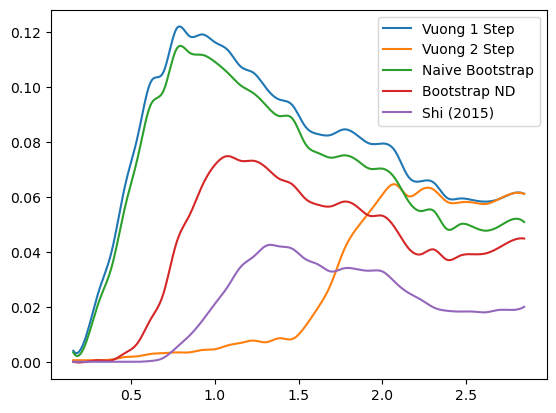

1.0 0.23227910480433808


In [11]:
nobs =100
calc_c =lambda nobs: (10*nobs**(-1/2), 3*(nobs)**(-5/9))
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2)
print(c1,c2)

Quantiles: 1th: 0.71, 5th: 1.87, 10th: 3.07, 30th: 9.09, 50th: 16.10, 70th: 24.47, 90th: 39.64, 95th: 47.74, 99th: 64.60
bonus term 3.491466435608377 // variance stats 8.51171761005183 //part1 64.63304070095649 //part2 18.51171761005183 8.51171761005183
2.539143279071613 -0.5496739947313615 4.375127432388222
-4.443789592145141 -0.5496739947313615 -2.6078054388285317
---
Quantiles: 1th: 0.82, 5th: 2.04, 10th: 3.49, 30th: 10.43, 50th: 18.19, 70th: 27.57, 90th: 43.21, 95th: 50.98, 99th: 66.07
bonus term 5.588207290464131 // variance stats 1.565970505648219 //part1 64.63304070095649 //part2 11.565970505648217 1.565970505648219
5.322698407490608 -1.1041418009344848 5.857567477429101
-5.853716173437653 -1.1041418009344848 -5.31884710349916
---
Quantiles: 1th: 0.70, 5th: 1.84, 10th: 3.10, 30th: 9.21, 50th: 16.00, 70th: 25.07, 90th: 40.69, 95th: 48.85, 99th: 64.29
bonus term 2.779226730099927 // variance stats 13.255763914818349 //part1 64.63304070095649 //part2 23.25576391481835 13.2557639148

Quantiles: 1th: 0.63, 5th: 1.80, 10th: 3.30, 30th: 9.37, 50th: 16.66, 70th: 25.40, 90th: 39.72, 95th: 47.95, 99th: 61.71
bonus term 2.539076632104373 // variance stats 15.45533281025432 //part1 64.63304070095649 //part2 25.45533281025432 15.45533281025432
1.336730263737373 -0.2707969809784373 3.700279876534981
-3.741423000471373 -0.2707969809784373 -1.377873387673765
---
Quantiles: 1th: 0.71, 5th: 1.77, 10th: 2.99, 30th: 8.80, 50th: 15.64, 70th: 24.04, 90th: 38.24, 95th: 46.07, 99th: 60.51
bonus term 1.1424730348587246 // variance stats 46.57292446201922 //part1 64.63304070095649 //part2 56.572924462019216 46.57292446201922
-0.5326156352422399 0.6059246691796903 2.8232427261323303
-2.8175617049596893 0.6059246691796903 0.5382966564148811
---
Quantiles: 1th: 0.63, 5th: 1.93, 10th: 3.30, 30th: 9.89, 50th: 17.27, 70th: 26.69, 90th: 40.90, 95th: 48.67, 99th: 64.50
bonus term 2.2458606667187375 // variance stats 18.778740221398994 //part1 64.63304070095649 //part2 28.77874022139899 18.77874

Quantiles: 1th: 0.79, 5th: 2.09, 10th: 3.53, 30th: 10.85, 50th: 19.13, 70th: 28.79, 90th: 46.02, 95th: 55.71, 99th: 72.73
bonus term 1.7499848089894243 // variance stats 26.93348671882504 //part1 64.63304070095649 //part2 36.933486718825044 26.93348671882504
0.32583753664960163 -0.09019300331275855 3.1487330325997807
-3.174132081329247 -0.09019300331275855 -0.3512365853790682
---
Quantiles: 1th: 0.57, 5th: 1.79, 10th: 3.22, 30th: 9.64, 50th: 16.86, 70th: 25.34, 90th: 40.40, 95th: 49.33, 99th: 65.73
bonus term 3.893959937286454 // variance stats 6.598280861101177 //part1 64.63304070095649 //part2 16.598280861101173 6.598280861101177
3.1245331842434374 -0.7036382384088009 4.672648875014505
-4.663386690329471 -0.7036382384088009 -3.1152709995584034
---
Quantiles: 1th: 0.64, 5th: 1.78, 10th: 3.15, 30th: 9.44, 50th: 16.84, 70th: 26.27, 90th: 40.90, 95th: 47.86, 99th: 61.76
bonus term 1.866279174146171 // variance stats 24.632032332743737 //part1 64.63304070095649 //part2 34.63203233274374 2

Quantiles: 1th: 0.67, 5th: 2.00, 10th: 3.42, 30th: 10.06, 50th: 16.95, 70th: 25.81, 90th: 40.51, 95th: 47.80, 99th: 61.07
bonus term 1.32528657686575 // variance stats 38.76910536120501 //part1 64.63304070095649 //part2 48.76910536120501 38.76910536120501
-0.14429991157144514 -0.07238185594453038 2.8806640261992817
-2.794873065302945 -0.07238185594453038 0.23009087246778193
---
Quantiles: 1th: 0.77, 5th: 2.14, 10th: 3.69, 30th: 10.45, 50th: 18.30, 70th: 28.03, 90th: 45.27, 95th: 54.02, 99th: 71.39
bonus term 2.0282248043237034 // variance stats 21.866803207994437 //part1 64.63304070095649 //part2 31.866803207994437 21.866803207994437
0.6022150215225456 -0.47420770359740455 3.429243307095344
-3.454234587124861 -0.47420770359740455 -0.6272063015520628
---
Quantiles: 1th: 0.79, 5th: 2.00, 10th: 3.40, 30th: 9.87, 50th: 16.83, 70th: 26.02, 90th: 41.96, 95th: 49.30, 99th: 64.37
bonus term 2.0290199579229875 // variance stats 21.85431491128273 //part1 64.63304070095649 //part2 31.854314911282

Quantiles: 1th: 0.66, 5th: 2.04, 10th: 3.50, 30th: 10.62, 50th: 18.34, 70th: 27.34, 90th: 43.10, 95th: 52.20, 99th: 67.17
bonus term 3.3837884276446037 // variance stats 9.10079252382408 //part1 64.63304070095649 //part2 19.10079252382408 9.10079252382408
2.4622494022736356 -2.510286507885744 4.370978805181266
-4.305327453015572 -2.510286507885744 -2.3965980501079414
---
Quantiles: 1th: 0.87, 5th: 1.97, 10th: 3.63, 30th: 10.72, 50th: 18.27, 70th: 27.67, 90th: 44.30, 95th: 52.83, 99th: 69.64
bonus term 1.4673829707345225 // variance stats 34.04647047839417 //part1 64.63304070095649 //part2 44.04647047839417 34.04647047839417
-0.09336387598380208 -0.40400138454590434 3.0279862257438754
-3.0281298174528475 -0.40400138454590434 0.09322028427483027
---
Quantiles: 1th: 0.67, 5th: 1.87, 10th: 3.37, 30th: 9.96, 50th: 17.70, 70th: 27.41, 90th: 42.78, 95th: 52.07, 99th: 67.84
bonus term 2.574167747167225 // variance stats 15.108325116761609 //part1 64.63304070095649 //part2 25.10832511676161 15.

Quantiles: 1th: 0.81, 5th: 1.90, 10th: 3.27, 30th: 9.26, 50th: 15.76, 70th: 24.18, 90th: 38.23, 95th: 45.77, 99th: 58.62
bonus term 1.1876116726900692 // variance stats 44.422705828207 //part1 64.63304070095649 //part2 54.42270582820699 44.422705828207
-0.33996466592730834 0.16597676417893664 2.7999939815959407
-2.715188011307447 0.16597676417893664 0.4247706362158025
---
Quantiles: 1th: 0.72, 5th: 1.75, 10th: 2.95, 30th: 8.95, 50th: 16.00, 70th: 24.14, 90th: 38.50, 95th: 45.55, 99th: 60.45
bonus term 3.582274865666245 // variance stats 8.04245713259521 //part1 64.63304070095649 //part2 18.042457132595207 8.04245713259521
2.6815302210409584 -2.154687022009184 4.44570310248652
-4.483019510291531 -2.154687022009184 -2.71884662884597
---
Quantiles: 1th: 0.70, 5th: 1.76, 10th: 3.36, 30th: 9.49, 50th: 16.47, 70th: 25.22, 90th: 39.73, 95th: 47.41, 99th: 62.78
bonus term 1.5728018673953568 // variance stats 31.094203943178314 //part1 64.63304070095649 //part2 41.094203943178314 31.09420394317

Quantiles: 1th: 0.67, 5th: 1.90, 10th: 3.31, 30th: 9.91, 50th: 16.79, 70th: 25.74, 90th: 41.88, 95th: 49.42, 99th: 65.31
bonus term 1.6462566591620176 // variance stats 29.26061002775606 //part1 64.63304070095649 //part2 39.26061002775605 29.26061002775606
0.12433798792167801 -0.9086599717891258 3.1197877011524393
-3.168175330402357 -0.9086599717891258 -0.17272561717159585
---
Quantiles: 1th: 0.68, 5th: 1.84, 10th: 3.27, 30th: 9.39, 50th: 16.48, 70th: 24.76, 90th: 39.91, 95th: 47.94, 99th: 63.56
bonus term 3.26797083720939 // variance stats 9.77772872543392 //part1 64.63304070095649 //part2 19.777728725433917 9.77772872543392
2.3487183344829625 -2.9033696773864754 4.21081791911118
-4.187223339935818 -2.9033696773864754 -2.3251237553075996
---
Quantiles: 1th: 0.76, 5th: 1.87, 10th: 3.33, 30th: 9.71, 50th: 17.06, 70th: 25.84, 90th: 41.83, 95th: 50.14, 99th: 68.11
bonus term 1.252384600624427 // variance stats 41.60798102174928 //part1 64.63304070095649 //part2 51.60798102174928 41.607981

Quantiles: 1th: 0.80, 5th: 1.84, 10th: 3.36, 30th: 9.44, 50th: 16.63, 70th: 25.58, 90th: 40.29, 95th: 47.68, 99th: 63.28
bonus term 2.0209914036051466 // variance stats 21.980858793194663 //part1 64.63304070095649 //part2 31.980858793194663 21.980858793194663
0.6084145789370698 -2.0615839262425264 3.395048604937449
-3.4335682282732236 -2.0615839262425264 -0.6469342022728441
---
Quantiles: 1th: 0.90, 5th: 2.02, 10th: 3.48, 30th: 9.73, 50th: 17.12, 70th: 26.40, 90th: 41.28, 95th: 48.41, 99th: 64.39
bonus term 1.5162771897984693 // variance stats 32.62613797517257 //part1 64.63304070095649 //part2 42.62613797517257 32.62613797517257
0.12802330150331212 -1.2755098033360612 3.0462755549417357
-2.9045310780936267 -1.2755098033360612 0.013721175344797077
---
Quantiles: 1th: 0.64, 5th: 1.91, 10th: 3.29, 30th: 9.25, 50th: 16.34, 70th: 25.21, 90th: 40.50, 95th: 47.41, 99th: 61.52
bonus term 1.7227491321529214 // variance stats 27.517383985086973 //part1 64.63304070095649 //part2 37.5173839850869

Quantiles: 1th: 0.75, 5th: 1.84, 10th: 3.27, 30th: 10.09, 50th: 17.07, 70th: 26.24, 90th: 41.54, 95th: 50.03, 99th: 66.10
bonus term 2.4132655490639907 // variance stats 16.782398947362033 //part1 64.63304070095649 //part2 26.782398947362033 16.782398947362033
1.2429144246083184 -4.4245969635449915 3.6838730681447345
-3.583616673519663 -4.4245969635449915 -1.142658029983247
---
Quantiles: 1th: 0.74, 5th: 1.86, 10th: 3.20, 30th: 9.20, 50th: 16.19, 70th: 25.15, 90th: 40.40, 95th: 48.27, 99th: 62.02
bonus term 1.2644910107518248 // variance stats 41.11387914298244 //part1 64.63304070095649 //part2 51.11387914298244 41.11387914298244
-0.3446665455674738 -1.7307461932853698 2.8373989730349334
-2.8736485670711236 -1.7307461932853698 0.3084169515312839
---
Quantiles: 1th: 0.73, 5th: 1.75, 10th: 2.88, 30th: 9.25, 50th: 16.21, 70th: 24.76, 90th: 38.86, 95th: 46.63, 99th: 61.22
bonus term 1.1148308889639724 // variance stats 47.97564576006757 //part1 64.63304070095649 //part2 57.975645760067565 

Quantiles: 1th: 0.79, 5th: 1.80, 10th: 3.30, 30th: 9.78, 50th: 17.04, 70th: 25.89, 90th: 42.51, 95th: 50.31, 99th: 65.69
bonus term 1.5635621886886544 // variance stats 31.337045093910618 //part1 64.63304070095649 //part2 41.33704509391062 31.337045093910618
0.06187108253654832 -3.295986596256889 2.9978778896225453
-3.0652532948407605 -3.295986596256889 -0.12924648775476386
---
Quantiles: 1th: 0.64, 5th: 2.05, 10th: 3.31, 30th: 9.86, 50th: 17.27, 70th: 26.26, 90th: 41.31, 95th: 49.02, 99th: 64.88
bonus term 2.2617501749611666 // variance stats 18.576560495708243 //part1 64.63304070095649 //part2 28.576560495708243 18.576560495708243
1.0246678735967114 -5.449680669550121 3.6172969399353314
-3.4988324763256218 -5.449680669550121 -0.9062034099870018
---
Quantiles: 1th: 0.66, 5th: 1.69, 10th: 3.14, 30th: 8.89, 50th: 15.61, 70th: 24.44, 90th: 37.87, 95th: 45.08, 99th: 59.68
bonus term 1.7976006049041737 // variance stats 25.955172981487692 //part1 64.63304070095649 //part2 35.95517298148769

Quantiles: 1th: 0.80, 5th: 1.98, 10th: 3.21, 30th: 9.13, 50th: 15.73, 70th: 24.10, 90th: 38.33, 95th: 45.56, 99th: 60.01
bonus term 1.861044031819072 // variance stats 24.72945271358309 //part1 64.63304070095649 //part2 34.729452713583086 24.72945271358309
0.5001670939360651 -3.7759094356634075 3.2668715055542026
-3.221920969702079 -3.7759094356634075 -0.4552165580839414
---
Quantiles: 1th: 0.67, 5th: 1.83, 10th: 3.25, 30th: 9.78, 50th: 16.70, 70th: 25.88, 90th: 41.22, 95th: 48.94, 99th: 62.31
bonus term 2.2696312282932434 // variance stats 18.477331425140974 //part1 64.63304070095649 //part2 28.47733142514097 18.477331425140974
1.0501786008749385 -6.075748907872843 3.4140087209320127
-3.489083855711548 -6.075748907872843 -1.125253735654474
---
Quantiles: 1th: 0.72, 5th: 1.79, 10th: 3.17, 30th: 9.28, 50th: 16.16, 70th: 24.94, 90th: 38.76, 95th: 45.94, 99th: 60.56
bonus term 1.1946256488996472 // variance stats 44.103175133138215 //part1 64.63304070095649 //part2 54.10317513313821 44.10

Quantiles: 1th: 0.72, 5th: 1.75, 10th: 3.14, 30th: 9.20, 50th: 16.34, 70th: 24.46, 90th: 38.72, 95th: 45.54, 99th: 59.62
bonus term 1.429892109225801 // variance stats 35.20134091512074 //part1 64.63304070095649 //part2 45.20134091512074 35.20134091512074
-0.14669153838234156 -4.701670687771983 2.966747529255599
-3.0064757568339435 -4.701670687771983 0.10696331080399718
---
Quantiles: 1th: 0.71, 5th: 1.98, 10th: 3.50, 30th: 10.06, 50th: 17.22, 70th: 26.80, 90th: 42.35, 95th: 49.70, 99th: 66.86
bonus term 2.1428661012226153 // variance stats 20.16195956624635 //part1 64.63304070095649 //part2 30.16195956624635 20.16195956624635
0.8391363924863493 -7.013841646847647 3.351600610408864
-3.446595809958881 -7.013841646847647 -0.9341315920363668
---
Quantiles: 1th: 0.71, 5th: 1.88, 10th: 3.45, 30th: 9.71, 50th: 16.68, 70th: 25.41, 90th: 40.04, 95th: 47.77, 99th: 62.87
bonus term 2.205579624441353 // variance stats 19.304333420892597 //part1 64.63304070095649 //part2 29.304333420892593 19.3043

Quantiles: 1th: 0.74, 5th: 1.83, 10th: 3.18, 30th: 9.31, 50th: 16.13, 70th: 24.59, 90th: 39.65, 95th: 46.80, 99th: 61.44
bonus term 1.3879201587686048 // variance stats 36.56827000646812 //part1 64.63304070095649 //part2 46.56827000646812 36.56827000646812
-0.22474472746307697 -4.170881831985617 2.900639086678417
-3.0005850450002867 -4.170881831985617 0.12479876914120724
---
Quantiles: 1th: 0.78, 5th: 1.87, 10th: 3.22, 30th: 9.51, 50th: 16.95, 70th: 26.11, 90th: 41.60, 95th: 49.27, 99th: 64.10
bonus term 1.6554387862541204 // variance stats 29.042845460451176 //part1 64.63304070095649 //part2 39.04284546045117 29.042845460451176
0.24822570331938396 -6.54717109989057 3.0404426983635373
-3.062651869188857 -6.54717109989057 -0.27043487414470363
---
Quantiles: 1th: 0.78, 5th: 2.02, 10th: 3.55, 30th: 10.19, 50th: 17.86, 70th: 27.46, 90th: 43.69, 95th: 52.06, 99th: 67.93
bonus term 1.6658314219802721 // variance stats 28.799268550309474 //part1 64.63304070095649 //part2 38.79926855030947 28.

Quantiles: 1th: 0.68, 5th: 1.86, 10th: 3.16, 30th: 8.90, 50th: 16.12, 70th: 25.20, 90th: 39.14, 95th: 46.67, 99th: 61.26
bonus term 1.0981995117716183 // variance stats 48.853641809301386 //part1 64.63304070095649 //part2 58.853641809301386 48.853641809301386
-0.5086524354123239 -5.550001120022352 2.5948234682955214
-2.7050514589555603 -5.550001120022352 0.3984244447522851
---
Quantiles: 1th: 0.69, 5th: 1.81, 10th: 3.16, 30th: 9.52, 50th: 16.98, 70th: 26.18, 90th: 41.23, 95th: 49.31, 99th: 64.52
bonus term 1.817532034508962 // variance stats 25.560881169513042 //part1 64.63304070095649 //part2 35.560881169513046 25.560881169513042
0.3627368288398529 -8.459200241654559 3.230557436307158
-3.272327240178071 -8.459200241654559 -0.4045066327107659
---
Quantiles: 1th: 0.65, 5th: 1.82, 10th: 3.21, 30th: 9.75, 50th: 17.11, 70th: 25.88, 90th: 41.14, 95th: 48.75, 99th: 64.51
bonus term 1.7264860687100003 // variance stats 27.436178531836713 //part1 64.63304070095649 //part2 37.43617853183671 27.

Quantiles: 1th: 0.63, 5th: 1.73, 10th: 2.95, 30th: 9.22, 50th: 15.76, 70th: 24.63, 90th: 39.10, 95th: 46.82, 99th: 60.01
bonus term 1.7273039266135788 // variance stats 27.41845294572515 //part1 64.63304070095649 //part2 37.41845294572515 27.41845294572515
0.29436431909554545 -10.315801746791271 3.1556236351816636
-3.160243534131612 -10.315801746791271 -0.2989842180454938
---
Quantiles: 1th: 0.75, 5th: 1.90, 10th: 3.28, 30th: 9.25, 50th: 16.16, 70th: 24.70, 90th: 38.20, 95th: 45.70, 99th: 61.09
bonus term 1.4025638186011644 // variance stats 36.082067599189685 //part1 64.63304070095649 //part2 46.082067599189685 36.082067599189685
-0.1590710975882135 -7.098147115441938 2.937529014378151
-2.9641987347905423 -7.098147115441938 0.1324013771758225
---
Quantiles: 1th: 0.76, 5th: 1.86, 10th: 3.21, 30th: 9.43, 50th: 16.65, 70th: 25.53, 90th: 40.10, 95th: 47.44, 99th: 63.27
bonus term 1.4025927312790567 // variance stats 36.08111767556084 //part1 64.63304070095649 //part2 46.08111767556083 36.

Quantiles: 1th: 0.70, 5th: 1.89, 10th: 3.39, 30th: 10.26, 50th: 18.09, 70th: 27.95, 90th: 44.51, 95th: 53.38, 99th: 70.14
bonus term 1.8640083582774971 // variance stats 24.67422257735096 //part1 64.63304070095649 //part2 34.67422257735096 24.67422257735096
0.46748490890569655 -10.158368277413217 3.219243142197753
-3.2605318076492975 -10.158368277413217 -0.5087735743572408
---
Quantiles: 1th: 0.87, 5th: 1.93, 10th: 3.26, 30th: 9.26, 50th: 16.29, 70th: 25.36, 90th: 41.23, 95th: 49.57, 99th: 65.62
bonus term 1.2293589414696053 // variance stats 42.57458869066554 //part1 64.63304070095649 //part2 52.57458869066555 42.57458869066554
-0.4189972200466458 -6.81367329953441 2.7826814845485766
-2.8777151029858565 -6.81367329953441 0.32396360160936577
---
Quantiles: 1th: 0.75, 5th: 1.92, 10th: 3.24, 30th: 9.60, 50th: 16.73, 70th: 25.37, 90th: 40.49, 95th: 48.62, 99th: 61.57
bonus term 1.245236745402199 // variance stats 41.904218968482695 //part1 64.63304070095649 //part2 51.9042189684827 41.904

Quantiles: 1th: 0.69, 5th: 1.73, 10th: 3.05, 30th: 9.44, 50th: 16.16, 70th: 24.53, 90th: 39.51, 95th: 46.29, 99th: 60.23
bonus term 1.5674563015844103 // variance stats 31.234349331221775 //part1 64.63304070095649 //part2 41.23434933122177 31.234349331221775
-0.016979292891699832 -11.472589742817785 3.031917277920877
-3.1518918960605204 -11.472589742817785 -0.10299532524794368
---
Quantiles: 1th: 0.73, 5th: 2.01, 10th: 3.57, 30th: 10.27, 50th: 17.60, 70th: 26.75, 90th: 42.58, 95th: 50.76, 99th: 64.47
bonus term 1.0654634044747646 // variance stats 50.6619058238028 //part1 64.63304070095649 //part2 60.661905823802805 50.6619058238028
-0.5648034562016809 -7.082506147649865 2.604349369048156
-2.69573026515121 -7.082506147649865 0.47342256009862665
---
Quantiles: 1th: 0.81, 5th: 1.95, 10th: 3.31, 30th: 9.57, 50th: 16.87, 70th: 25.99, 90th: 41.06, 95th: 48.94, 99th: 65.08
bonus term 1.6158761815447356 // variance stats 29.998758221170746 //part1 64.63304070095649 //part2 39.998758221170746 

Quantiles: 1th: 0.58, 5th: 1.77, 10th: 3.11, 30th: 9.21, 50th: 16.07, 70th: 25.02, 90th: 39.79, 95th: 47.25, 99th: 62.02
bonus term 1.1017716394014434 // variance stats 48.66282847511804 //part1 64.63304070095649 //part2 58.66282847511804 48.66282847511804
-0.5028179549162978 -8.389438185491699 2.809127983569279
-2.7063612337191842 -8.389438185491699 0.6055847047663926
---
Quantiles: 1th: 0.82, 5th: 1.88, 10th: 3.41, 30th: 9.77, 50th: 16.91, 70th: 25.14, 90th: 39.51, 95th: 47.14, 99th: 61.46
bonus term 1.171648174908485 // variance stats 45.16420550563724 //part1 64.63304070095649 //part2 55.16420550563724 45.16420550563724
-0.4729789819086067 -8.445928007619791 2.859212569134253
-2.816275331725577 -8.445928007619791 0.5159162193172825
---
Quantiles: 1th: 0.68, 5th: 1.86, 10th: 3.19, 30th: 9.52, 50th: 16.64, 70th: 25.34, 90th: 40.55, 95th: 47.96, 99th: 61.77
bonus term 1.3764318261525992 // variance stats 36.95695019027473 //part1 64.63304070095649 //part2 46.95695019027473 36.95695019

Quantiles: 1th: 0.75, 5th: 1.94, 10th: 3.24, 30th: 9.26, 50th: 15.76, 70th: 24.06, 90th: 39.40, 95th: 46.40, 99th: 61.24
bonus term 1.0933760121799607 // variance stats 49.11327848878984 //part1 64.63304070095649 //part2 59.11327848878984 49.11327848878984
-0.5950335530903886 -8.970305625328487 2.778293137268277
-2.78178557745031 -8.970305625328487 0.5915411129083556
---
Quantiles: 1th: 0.65, 5th: 1.81, 10th: 3.16, 30th: 9.57, 50th: 16.20, 70th: 24.43, 90th: 39.50, 95th: 46.74, 99th: 62.06
bonus term 0.9612958872470239 // variance stats 57.235324272585544 //part1 64.63304070095649 //part2 67.23532427258554 57.235324272585544
-0.7780466454985587 -7.705153045813118 2.5854468192637037
-2.7006384199926066 -7.705153045813118 0.6628550447696556
---
Quantiles: 1th: 0.71, 5th: 1.86, 10th: 3.34, 30th: 9.82, 50th: 16.55, 70th: 25.37, 90th: 40.24, 95th: 48.12, 99th: 62.56
bonus term 1.4296560239626679 // variance stats 35.20880520742955 //part1 64.63304070095649 //part2 45.20880520742955 35.20880

Quantiles: 1th: 0.71, 5th: 1.86, 10th: 3.23, 30th: 9.58, 50th: 16.85, 70th: 26.05, 90th: 41.20, 95th: 49.90, 99th: 64.19
bonus term 1.2143329676551655 // variance stats 43.22513875725586 //part1 64.63304070095649 //part2 53.22513875725586 43.22513875725586
-0.4679435707839582 -11.268208193240511 2.90040096189881
-2.8966095060942894 -11.268208193240511 0.4717350265884788
---
Quantiles: 1th: 0.71, 5th: 1.88, 10th: 3.32, 30th: 9.08, 50th: 15.86, 70th: 24.45, 90th: 39.06, 95th: 47.15, 99th: 63.24
bonus term 1.2500901114151879 // variance stats 41.70270535760613 //part1 64.63304070095649 //part2 51.702705357606135 41.70270535760613
-0.4514727460360557 -10.78846632221161 2.903154361007373
-2.9516529688664312 -10.78846632221161 0.4029741381769974
---
Quantiles: 1th: 0.77, 5th: 2.32, 10th: 3.83, 30th: 10.68, 50th: 19.02, 70th: 28.93, 90th: 45.97, 95th: 54.10, 99th: 69.98
bonus term 1.34809933851427 // variance stats 37.94382643358319 //part1 64.63304070095649 //part2 47.9438264335832 37.943826

Quantiles: 1th: 0.62, 5th: 1.89, 10th: 3.09, 30th: 8.54, 50th: 14.70, 70th: 22.32, 90th: 35.34, 95th: 42.60, 99th: 54.81
bonus term 1.3179323591765388 // variance stats 39.04124270940585 //part1 64.63304070095649 //part2 49.04124270940585 39.04124270940585
-0.3682818573758243 -13.850376858081376 2.9482453463660825
-3.0041465757289023 -13.850376858081376 0.31238062801300476
---
Quantiles: 1th: 0.73, 5th: 1.92, 10th: 3.31, 30th: 9.52, 50th: 16.75, 70th: 25.93, 90th: 40.72, 95th: 48.72, 99th: 63.30
bonus term 1.0842434482737007 // variance stats 49.6111886162312 //part1 64.63304070095649 //part2 59.611188616231196 49.6111886162312
-0.6082414098647846 -10.633263429759314 2.728067299774677
-2.7767283064121857 -10.633263429759314 0.5595804032272756
---
Quantiles: 1th: 0.74, 5th: 1.83, 10th: 3.14, 30th: 9.08, 50th: 16.43, 70th: 24.98, 90th: 39.44, 95th: 46.57, 99th: 61.72
bonus term 0.7109629107519445 // variance stats 80.90915956867264 //part1 64.63304070095649 //part2 90.90915956867264 80.9

Quantiles: 1th: 0.81, 5th: 1.97, 10th: 3.28, 30th: 9.75, 50th: 17.09, 70th: 25.96, 90th: 40.19, 95th: 48.21, 99th: 63.04
bonus term 1.2004545678590617 // variance stats 43.84047212734223 //part1 64.63304070095649 //part2 53.84047212734223 43.84047212734223
-0.47622709878640535 -13.975022379554172 2.973448224440252
-2.877136234504529 -13.975022379554172 0.5725390887221287
---
Quantiles: 1th: 0.65, 5th: 1.97, 10th: 3.35, 30th: 9.98, 50th: 17.15, 70th: 26.28, 90th: 41.24, 95th: 49.32, 99th: 64.47
bonus term 1.2616001288154015 // variance stats 41.23100356817866 //part1 64.63304070095649 //part2 51.23100356817865 41.23100356817866
-0.41862953051240176 -14.644176699448932 2.9684740312770024
-2.9418297881432047 -14.644176699448932 0.4452737736461994
---
Quantiles: 1th: 0.70, 5th: 1.77, 10th: 3.22, 30th: 9.96, 50th: 17.56, 70th: 27.39, 90th: 43.24, 95th: 50.87, 99th: 65.60
bonus term 1.3977492027429999 // variance stats 36.2407995469559 //part1 64.63304070095649 //part2 46.2407995469559 36.24

Quantiles: 1th: 0.81, 5th: 2.18, 10th: 3.61, 30th: 10.39, 50th: 17.89, 70th: 27.46, 90th: 42.79, 95th: 51.52, 99th: 69.77
bonus term 1.1314434637133202 // variance stats 47.124410342904156 //part1 64.63304070095649 //part2 57.12441034290415 47.124410342904156
-0.5334468622058224 -15.026518655496194 2.7480548377625644
-2.7963337896324627 -15.026518655496194 0.48516791033592416
---
Quantiles: 1th: 0.71, 5th: 1.94, 10th: 3.33, 30th: 9.77, 50th: 17.05, 70th: 26.04, 90th: 41.35, 95th: 49.02, 99th: 64.48
bonus term 0.9534065030905045 // variance stats 57.79169272649805 //part1 64.63304070095649 //part2 67.79169272649804 57.79169272649805
-0.7398731644209428 -12.328536479376572 2.5637910230745082
-2.6466861706019515 -12.328536479376572 0.6569780168934992
---
Quantiles: 1th: 0.72, 5th: 1.99, 10th: 3.46, 30th: 9.82, 50th: 17.30, 70th: 26.71, 90th: 42.36, 95th: 51.43, 99th: 68.73
bonus term 1.131563582126263 // variance stats 47.11834643839266 //part1 64.63304070095649 //part2 57.11834643839266 

Quantiles: 1th: 0.66, 5th: 1.82, 10th: 3.20, 30th: 9.39, 50th: 16.62, 70th: 25.39, 90th: 41.00, 95th: 48.45, 99th: 61.57
bonus term 1.2042137872993701 // variance stats 43.672397196104 //part1 64.63304070095649 //part2 53.672397196103994 43.672397196104
-0.592628252930141 -19.281292677137515 2.9390547300027596
-3.001055827528881 -19.281292677137515 0.5306271554040197
---
Quantiles: 1th: 0.75, 5th: 1.83, 10th: 3.29, 30th: 9.54, 50th: 16.98, 70th: 26.15, 90th: 41.16, 95th: 48.35, 99th: 64.27
bonus term 1.1731102850759028 // variance stats 45.095451402316 //part1 64.63304070095649 //part2 55.09545140231601 45.095451402316
-0.3607188279245294 -18.07701669000724 2.9056071015702454
-2.7069393980763348 -18.07701669000724 0.5593865314184399
---
Quantiles: 1th: 0.74, 5th: 1.82, 10th: 3.22, 30th: 9.93, 50th: 17.04, 70th: 26.26, 90th: 41.21, 95th: 50.19, 99th: 65.77
bonus term 0.8205612081821267 // variance stats 68.76687327706445 //part1 64.63304070095649 //part2 78.76687327706445 68.76687327706

Quantiles: 1th: 0.64, 5th: 1.96, 10th: 3.52, 30th: 9.90, 50th: 17.17, 70th: 26.75, 90th: 41.92, 95th: 50.20, 99th: 67.39
bonus term 1.0624177464302262 // variance stats 50.83580674186452 //part1 64.63304070095649 //part2 60.83580674186453 50.83580674186452
-0.7495771167425663 -16.00003102642629 2.725459610523702
-2.8744126096030187 -16.00003102642629 0.6006241176632499
---
Quantiles: 1th: 0.70, 5th: 2.03, 10th: 3.80, 30th: 10.45, 50th: 17.82, 70th: 27.90, 90th: 44.10, 95th: 53.08, 99th: 69.19
bonus term 1.1706651344566834 // variance stats 45.210528441126996 //part1 64.63304070095649 //part2 55.210528441126996 45.210528441126996
-0.4351186218145368 -17.911664621781814 2.776542004616451
-2.7764488907279037 -17.911664621781814 0.4352117357030837
---
Quantiles: 1th: 0.83, 5th: 1.98, 10th: 3.22, 30th: 9.51, 50th: 16.36, 70th: 25.48, 90th: 39.53, 95th: 47.51, 99th: 63.72
bonus term 1.0325502011426646 // variance stats 52.59554317981904 //part1 64.63304070095649 //part2 62.59554317981903 52.

Quantiles: 1th: 0.81, 5th: 2.03, 10th: 3.36, 30th: 9.98, 50th: 17.53, 70th: 27.43, 90th: 44.31, 95th: 51.76, 99th: 67.28
bonus term 0.9264915480957335 // variance stats 59.76106887731479 //part1 64.63304070095649 //part2 69.7610688773148 59.76106887731479
-0.9152340559262389 -14.236099156899416 2.5961625080826956
-2.768217152117706 -14.236099156899416 0.7431794118912283
---
Quantiles: 1th: 0.79, 5th: 1.99, 10th: 3.34, 30th: 9.88, 50th: 17.44, 70th: 26.33, 90th: 43.10, 95th: 51.54, 99th: 67.23
bonus term 1.134092022609941 // variance stats 46.9910019754952 //part1 64.63304070095649 //part2 56.9910019754952 46.9910019754952
-0.7193654418763022 -19.510768647906772 2.867031584382845
-2.9875494870961843 -19.510768647906772 0.5988475391629634
---
Quantiles: 1th: 0.67, 5th: 1.93, 10th: 3.45, 30th: 9.86, 50th: 16.98, 70th: 25.62, 90th: 40.34, 95th: 48.36, 99th: 63.56
bonus term 0.859484804258783 // variance stats 65.19974801264323 //part1 64.63304070095649 //part2 75.19974801264324 65.19974801

Quantiles: 1th: 0.80, 5th: 1.85, 10th: 3.23, 30th: 9.21, 50th: 16.73, 70th: 25.56, 90th: 39.82, 95th: 47.99, 99th: 63.90
bonus term 0.9822359333750643 // variance stats 55.80195094153262 //part1 64.63304070095649 //part2 65.80195094153262 55.80195094153262
-0.7762233630712377 -18.909046869870238 2.6760049339109844
-2.7406952298213665 -18.909046869870238 0.7115330671608554
---
Quantiles: 1th: 0.83, 5th: 2.00, 10th: 3.42, 30th: 9.89, 50th: 16.90, 70th: 25.34, 90th: 40.56, 95th: 48.44, 99th: 63.01
bonus term 0.8108815857009326 // variance stats 69.70712597337767 //part1 64.63304070095649 //part2 79.70712597337769 69.70712597337767
-0.9926132776762286 -14.529218303434932 2.447819755563754
-2.614376449078094 -14.529218303434932 0.8260565841618894
---
Quantiles: 1th: 0.75, 5th: 1.85, 10th: 3.17, 30th: 9.72, 50th: 16.98, 70th: 26.06, 90th: 41.94, 95th: 49.84, 99th: 63.98
bonus term 0.9993889515272969 // variance stats 54.67255876921822 //part1 64.63304070095649 //part2 64.67255876921821 54.67

Quantiles: 1th: 0.74, 5th: 2.01, 10th: 3.43, 30th: 9.93, 50th: 16.85, 70th: 26.10, 90th: 42.06, 95th: 49.58, 99th: 66.35
bonus term 0.8275140321764727 // variance stats 68.10506914422095 //part1 64.63304070095649 //part2 78.10506914422096 68.10506914422095
-1.0134032199391134 -16.521562542234417 2.600754619329136
-2.668431284292059 -16.521562542234417 0.9457265549761906
---
Quantiles: 1th: 0.73, 5th: 1.84, 10th: 3.13, 30th: 9.02, 50th: 15.26, 70th: 23.76, 90th: 37.77, 95th: 44.11, 99th: 57.48
bonus term 0.9584362764402515 // variance stats 57.43592901242368 //part1 64.63304070095649 //part2 67.43592901242368 57.43592901242368
-0.7724110851060165 -18.75042704450397 2.693534337766196
-2.6892836379865193 -18.75042704450397 0.776661784885693
---
Quantiles: 1th: 0.70, 5th: 1.95, 10th: 3.49, 30th: 10.19, 50th: 17.43, 70th: 25.99, 90th: 40.34, 95th: 49.43, 99th: 64.07
bonus term 1.0407646334190912 // variance stats 52.10149598245455 //part1 64.63304070095649 //part2 62.10149598245455 52.10149

Quantiles: 1th: 0.67, 5th: 1.93, 10th: 3.26, 30th: 9.38, 50th: 16.21, 70th: 25.34, 90th: 40.28, 95th: 48.40, 99th: 63.83
bonus term 0.9607434207740447 // variance stats 57.27398731378604 //part1 64.63304070095649 //part2 67.27398731378604 57.27398731378604
-1.0047284019590523 -22.645963625152707 2.6296231385149653
-2.926215243507142 -22.645963625152707 0.7081362969668759
---
Quantiles: 1th: 0.72, 5th: 2.02, 10th: 3.27, 30th: 9.71, 50th: 16.99, 70th: 26.27, 90th: 41.98, 95th: 49.57, 99th: 63.57
bonus term 0.9318450999174488 // variance stats 59.3602839213108 //part1 64.63304070095649 //part2 69.3602839213108 59.3602839213108
-0.9449963721610504 -19.366011811447194 2.6642953352579215
-2.8086865719959477 -19.366011811447194 0.8006051354230239
---
Quantiles: 1th: 0.74, 5th: 1.92, 10th: 3.31, 30th: 10.14, 50th: 17.43, 70th: 26.60, 90th: 41.95, 95th: 50.13, 99th: 67.03
bonus term 1.0151575650368136 // variance stats 53.667989016673125 //part1 64.63304070095649 //part2 63.667989016673125 53.6

Quantiles: 1th: 0.67, 5th: 1.83, 10th: 3.05, 30th: 9.17, 50th: 15.87, 70th: 24.47, 90th: 39.31, 95th: 45.96, 99th: 60.29
bonus term 1.0103822284045048 // variance stats 53.96890096040046 //part1 64.63304070095649 //part2 63.96890096040046 53.96890096040046
-1.0112897976100044 -22.365010881698428 2.9796720422639478
-3.032054254419014 -22.365010881698428 0.9589075854549381
---
Quantiles: 1th: 0.73, 5th: 1.90, 10th: 3.38, 30th: 9.39, 50th: 16.87, 70th: 26.06, 90th: 41.73, 95th: 49.44, 99th: 65.84
bonus term 0.9919760439469884 // variance stats 55.15584836483259 //part1 64.63304070095649 //part2 65.1558483648326 55.15584836483259
-1.0277151829962832 -23.483143068925013 2.755921577522579
-3.01166727089026 -23.483143068925013 0.7719694896286022
---
Quantiles: 1th: 0.73, 5th: 1.93, 10th: 3.59, 30th: 9.76, 50th: 17.16, 70th: 26.16, 90th: 40.80, 95th: 50.00, 99th: 64.72
bonus term 0.8499996795406558 // variance stats 66.03890008039122 //part1 64.63304070095649 //part2 76.03890008039122 66.03890

Quantiles: 1th: 0.67, 5th: 1.73, 10th: 3.18, 30th: 9.66, 50th: 17.18, 70th: 26.41, 90th: 41.68, 95th: 49.17, 99th: 65.10
bonus term 0.93310923043666 // variance stats 59.26631801799951 //part1 64.63304070095649 //part2 69.26631801799951 59.26631801799951
-0.9873788441953041 -23.86811124085237 2.991195015337775
-2.8535973050686243 -23.86811124085237 1.1249765544644552
---
Quantiles: 1th: 0.83, 5th: 2.04, 10th: 3.45, 30th: 9.63, 50th: 17.27, 70th: 26.97, 90th: 43.87, 95th: 51.75, 99th: 68.31
bonus term 0.9160912202738609 // variance stats 60.55306204292052 //part1 64.63304070095649 //part2 70.55306204292053 60.55306204292052
-1.0550998431987042 -20.98103815906374 2.9006897886337346
-2.8872822837464263 -20.98103815906374 1.0685073480860126
---
Quantiles: 1th: 0.73, 5th: 1.89, 10th: 3.33, 30th: 10.19, 50th: 17.58, 70th: 26.61, 90th: 41.85, 95th: 50.48, 99th: 64.80
bonus term 0.9523137398068336 // variance stats 57.86948250275858 //part1 64.63304070095649 //part2 67.86948250275857 57.869482

Quantiles: 1th: 0.69, 5th: 1.88, 10th: 3.39, 30th: 10.48, 50th: 18.38, 70th: 28.14, 90th: 44.64, 95th: 54.12, 99th: 70.07
bonus term 0.7644993547416821 // variance stats 74.54296305167641 //part1 64.63304070095649 //part2 84.54296305167641 74.54296305167641
-1.2049990977015081 -20.316383031649924 2.627783077597841
-2.7339978071848723 -20.316383031649924 1.0987843681144767
---
Quantiles: 1th: 0.84, 5th: 2.03, 10th: 3.60, 30th: 10.42, 50th: 18.34, 70th: 27.98, 90th: 44.72, 95th: 51.86, 99th: 67.82
bonus term 0.799246445605016 // variance stats 70.86747342621007 //part1 64.63304070095649 //part2 80.86747342621007 70.86747342621007
-1.4087541334273843 -20.926808218889445 2.7629698726510035
-3.0072470246374166 -20.926808218889445 1.1644769814409712
---
Quantiles: 1th: 0.74, 5th: 1.92, 10th: 3.35, 30th: 9.65, 50th: 16.95, 70th: 26.39, 90th: 42.18, 95th: 51.37, 99th: 66.53
bonus term 0.965924403975394 // variance stats 56.91314603394465 //part1 64.63304070095649 //part2 66.91314603394464 56.9

Quantiles: 1th: 0.81, 5th: 2.08, 10th: 3.63, 30th: 10.53, 50th: 18.54, 70th: 28.04, 90th: 43.55, 95th: 50.89, 99th: 68.07
bonus term 0.8915783543405276 // variance stats 62.49283294765888 //part1 64.63304070095649 //part2 72.49283294765888 62.49283294765888
-0.9317599009758778 -26.343301278643885 2.696103945802143
-2.714916609656933 -26.343301278643885 0.9129472371210882
---
Quantiles: 1th: 0.71, 5th: 1.74, 10th: 3.28, 30th: 9.56, 50th: 16.81, 70th: 26.40, 90th: 41.35, 95th: 49.66, 99th: 63.12
bonus term 0.8973792505349559 // variance stats 62.02422015265753 //part1 64.63304070095649 //part2 72.02422015265752 62.02422015265753
-1.0123106696800823 -25.181039970548035 2.696550763740547
-2.807069170749994 -25.181039970548035 0.9017922626706352
---
Quantiles: 1th: 0.70, 5th: 1.89, 10th: 3.11, 30th: 9.15, 50th: 15.29, 70th: 24.16, 90th: 38.17, 95th: 45.55, 99th: 60.22
bonus term 0.666177390722969 // variance stats 87.02076594165628 //part1 64.63304070095649 //part2 97.02076594165628 87.0207

Quantiles: 1th: 0.69, 5th: 1.85, 10th: 3.33, 30th: 9.69, 50th: 16.91, 70th: 26.09, 90th: 41.81, 95th: 49.45, 99th: 64.47
bonus term 0.761835555998788 // variance stats 74.83857204094488 //part1 64.63304070095649 //part2 84.83857204094488 74.83857204094488
-1.1347628502104494 -19.86011273746693 2.6005425123996626
-2.6584339622080253 -19.86011273746693 1.0768714004020867
---
Quantiles: 1th: 0.72, 5th: 1.82, 10th: 3.09, 30th: 9.64, 50th: 17.17, 70th: 26.59, 90th: 41.69, 95th: 49.42, 99th: 66.16
bonus term 0.8089274742085191 // variance stats 69.89967303829746 //part1 64.63304070095649 //part2 79.89967303829746 69.89967303829746
-1.018150659875374 -22.245018677985062 2.5934267220127136
-2.6360056082924124 -22.245018677985062 0.9755717735956755
---
Quantiles: 1th: 0.74, 5th: 1.85, 10th: 3.35, 30th: 9.13, 50th: 16.19, 70th: 24.38, 90th: 38.30, 95th: 44.90, 99th: 59.83
bonus term 0.8607007515132253 // variance stats 65.09351024420866 //part1 64.63304070095649 //part2 75.09351024420867 65.0935

Quantiles: 1th: 0.65, 5th: 1.74, 10th: 3.08, 30th: 9.09, 50th: 16.47, 70th: 25.82, 90th: 39.89, 95th: 48.06, 99th: 61.65
bonus term 0.8640908405547948 // variance stats 64.7988957497321 //part1 64.63304070095649 //part2 74.79889574973211 64.7988957497321
-1.1852896722270696 -28.905905706282518 2.775870022321129
-2.913471353336659 -28.905905706282518 1.0476883412115392
---
Quantiles: 1th: 0.70, 5th: 1.91, 10th: 3.27, 30th: 10.15, 50th: 16.92, 70th: 26.01, 90th: 40.74, 95th: 48.87, 99th: 64.28
bonus term 0.8597243612296463 // variance stats 65.17879405966018 //part1 64.63304070095649 //part2 75.17879405966018 65.17879405966018
-1.1838468071597494 -26.307124562399355 2.6102026459327443
-2.903295529619042 -26.307124562399355 0.8907539234734521
---
Quantiles: 1th: 0.75, 5th: 2.03, 10th: 3.46, 30th: 10.27, 50th: 18.11, 70th: 27.80, 90th: 43.41, 95th: 51.92, 99th: 67.51
bonus term 0.8664410096734273 // variance stats 64.59600824448222 //part1 64.63304070095649 //part2 74.59600824448222 64.596

Quantiles: 1th: 0.72, 5th: 1.91, 10th: 3.19, 30th: 9.90, 50th: 17.40, 70th: 26.87, 90th: 42.94, 95th: 52.04, 99th: 66.63
bonus term 0.8342884578910449 // variance stats 67.47085566104923 //part1 64.63304070095649 //part2 77.47085566104923 67.47085566104923
-1.3250699405722106 -27.89884529676901 2.8113328920042697
-2.9936468563543004 -27.89884529676901 1.1427559762221797
---
Quantiles: 1th: 0.68, 5th: 1.81, 10th: 3.08, 30th: 9.81, 50th: 16.75, 70th: 25.26, 90th: 40.20, 95th: 48.11, 99th: 63.28
bonus term 0.8180143267833715 // variance stats 69.01211333927256 //part1 64.63304070095649 //part2 79.01211333927256 69.01211333927256
-1.2887628195627483 -28.59246090390299 2.6965383478813294
-2.9247914731294915 -28.59246090390299 1.0605096943145862
---
Quantiles: 1th: 0.81, 5th: 1.96, 10th: 3.30, 30th: 9.90, 50th: 16.96, 70th: 25.96, 90th: 40.67, 95th: 48.92, 99th: 64.23
bonus term 0.7961136525000635 // variance stats 71.18569565788388 //part1 64.63304070095649 //part2 81.18569565788388 71.1856

Quantiles: 1th: 0.69, 5th: 1.82, 10th: 3.27, 30th: 9.79, 50th: 17.14, 70th: 26.42, 90th: 41.70, 95th: 50.89, 99th: 65.08
bonus term 0.8358740711373127 // variance stats 67.3238971428017 //part1 64.63304070095649 //part2 77.32389714280171 67.3238971428017
-1.0610792022083373 -28.927002086684805 2.781554932428447
-2.7328273444829625 -28.927002086684805 1.1098067901538218
---
Quantiles: 1th: 0.80, 5th: 2.07, 10th: 3.67, 30th: 10.23, 50th: 18.00, 70th: 27.73, 90th: 43.62, 95th: 51.57, 99th: 66.18
bonus term 0.8313470103215403 // variance stats 67.74496076669396 //part1 64.63304070095649 //part2 77.74496076669396 67.74496076669396
-1.2801818508213503 -30.676396388164672 2.918575284846932
-2.9428758714644307 -30.676396388164672 1.2558812642038515
---
Quantiles: 1th: 0.74, 5th: 1.97, 10th: 3.46, 30th: 10.38, 50th: 18.02, 70th: 27.65, 90th: 44.19, 95th: 53.01, 99th: 69.34
bonus term 0.7087939339847756 // variance stats 81.18735023252154 //part1 64.63304070095649 //part2 91.18735023252154 81.18

Quantiles: 1th: 0.67, 5th: 1.85, 10th: 3.23, 30th: 9.23, 50th: 16.21, 70th: 24.07, 90th: 38.58, 95th: 45.81, 99th: 60.46
bonus term 0.7467522291311074 // variance stats 76.55218984235378 //part1 64.63304070095649 //part2 86.5521898423538 76.55218984235378
-1.5014370094042655 -29.69881512847453 2.6938104871072266
-2.99494146766648 -29.69881512847453 1.2003060288450118
---
Quantiles: 1th: 0.76, 5th: 2.01, 10th: 3.58, 30th: 10.31, 50th: 17.61, 70th: 27.54, 90th: 43.00, 95th: 50.98, 99th: 67.66
bonus term 0.7913951452574028 // variance stats 71.6697462554366 //part1 64.63304070095649 //part2 81.6697462554366 71.6697462554366
-1.2385442580497787 -31.11001101479147 2.796688358280195
-2.8213345485645847 -31.11001101479147 1.213898067765389
---
Quantiles: 1th: 0.71, 5th: 1.86, 10th: 3.17, 30th: 9.40, 50th: 16.48, 70th: 25.07, 90th: 40.17, 95th: 47.83, 99th: 61.98
bonus term 0.7694254379805846 // variance stats 74.00169465489833 //part1 64.63304070095649 //part2 84.00169465489833 74.00169465489

Quantiles: 1th: 0.63, 5th: 1.77, 10th: 3.08, 30th: 9.49, 50th: 16.74, 70th: 25.77, 90th: 40.58, 95th: 48.29, 99th: 62.58
bonus term 0.7046203714195187 // variance stats 81.72746534527184 //part1 64.63304070095649 //part2 91.72746534527184 81.72746534527184
-1.4022397031830234 -27.22156556163404 2.711607515052936
-2.8114804460220606 -27.22156556163404 1.3023667722138987
---
Quantiles: 1th: 0.75, 5th: 1.82, 10th: 3.01, 30th: 9.56, 50th: 16.68, 70th: 25.56, 90th: 39.99, 95th: 48.00, 99th: 61.07
bonus term 0.740183334373372 // variance stats 77.32031335949198 //part1 64.63304070095649 //part2 87.32031335949198 77.32031335949198
-1.3662253654583205 -28.89495593847732 2.831247069068426
-2.846592034205065 -28.89495593847732 1.3508804003216817
---
Quantiles: 1th: 0.57, 5th: 1.68, 10th: 3.13, 30th: 9.28, 50th: 16.36, 70th: 24.87, 90th: 39.88, 95th: 47.63, 99th: 62.92
bonus term 0.7579423327372545 // variance stats 75.2743512392808 //part1 64.63304070095649 //part2 85.2743512392808 75.2743512392

Quantiles: 1th: 0.72, 5th: 1.89, 10th: 3.31, 30th: 10.47, 50th: 17.29, 70th: 26.61, 90th: 42.53, 95th: 50.97, 99th: 67.89
bonus term 0.7949528391690222 // variance stats 71.30424537953536 //part1 64.63304070095649 //part2 81.30424537953536 71.30424537953536
-1.4886955054011206 -32.14283615021708 2.833007331122785
-3.0786011837391647 -32.14283615021708 1.2431016527847407
---
Quantiles: 1th: 0.72, 5th: 1.87, 10th: 3.32, 30th: 9.99, 50th: 17.35, 70th: 26.07, 90th: 41.24, 95th: 50.04, 99th: 66.63
bonus term 0.7687810518558923 // variance stats 74.07210420304678 //part1 64.63304070095649 //part2 84.07210420304678 74.07210420304678
-1.4275429378105429 -32.18276003263966 2.916948760672435
-2.9651050415223272 -32.18276003263966 1.3793866569606505
---
Quantiles: 1th: 0.76, 5th: 1.81, 10th: 3.20, 30th: 10.33, 50th: 17.83, 70th: 27.37, 90th: 43.13, 95th: 51.20, 99th: 67.09
bonus term 0.8077794358194897 // variance stats 70.01322865490684 //part1 64.63304070095649 //part2 80.01322865490684 70.0132

Quantiles: 1th: 0.63, 5th: 1.73, 10th: 3.01, 30th: 9.14, 50th: 16.35, 70th: 25.14, 90th: 40.74, 95th: 48.34, 99th: 64.22
bonus term 0.6455656018562553 // variance stats 90.11847055529451 //part1 64.63304070095649 //part2 100.11847055529452 90.11847055529451
-1.4265398858985776 -28.723659265080165 2.65638979548866
-2.7176710896110885 -28.723659265080165 1.365258591776149
---
Quantiles: 1th: 0.83, 5th: 1.97, 10th: 3.53, 30th: 9.93, 50th: 17.39, 70th: 26.98, 90th: 42.98, 95th: 51.29, 99th: 67.95
bonus term 0.7492337171662758 // variance stats 76.26552599021997 //part1 64.63304070095649 //part2 86.26552599021997 76.26552599021997
-1.3496047571713956 -32.25114486146769 2.8300285559790916
-2.8480721915039475 -32.25114486146769 1.3315611216465395
---
Quantiles: 1th: 0.72, 5th: 2.03, 10th: 3.53, 30th: 9.93, 50th: 16.91, 70th: 26.12, 90th: 41.58, 95th: 50.09, 99th: 66.28
bonus term 0.7199184357299783 // variance stats 79.77828250143405 //part1 64.63304070095649 //part2 89.77828250143405 79.7782

Quantiles: 1th: 0.67, 5th: 1.78, 10th: 3.10, 30th: 8.88, 50th: 15.86, 70th: 24.55, 90th: 39.65, 95th: 47.63, 99th: 61.58
bonus term 0.5987416925285539 // variance stats 97.94812104699746 //part1 64.63304070095649 //part2 107.94812104699747 97.94812104699746
-1.5510777943883944 -27.34989983856015 2.7508247689793883
-2.7485611794455025 -27.34989983856015 1.55334138392228
---
Quantiles: 1th: 0.84, 5th: 2.04, 10th: 3.39, 30th: 9.66, 50th: 16.81, 70th: 25.76, 90th: 40.91, 95th: 48.27, 99th: 64.10
bonus term 0.7104002283240398 // variance stats 80.98116543886435 //part1 64.63304070095649 //part2 90.98116543886435 80.98116543886435
-1.5405075916172133 -33.101308184821406 2.863643090461875
-2.961308048265293 -33.101308184821406 1.4428426338137958
---
Quantiles: 1th: 0.68, 5th: 1.95, 10th: 3.39, 30th: 10.18, 50th: 17.85, 70th: 27.02, 90th: 42.86, 95th: 51.15, 99th: 65.97
bonus term 0.6994519872635043 // variance stats 82.40525708393947 //part1 64.63304070095649 //part2 92.40525708393947 82.4052

Quantiles: 1th: 0.75, 5th: 1.88, 10th: 3.25, 30th: 9.68, 50th: 16.79, 70th: 25.74, 90th: 39.86, 95th: 47.61, 99th: 61.35
bonus term 0.6966723770650157 // variance stats 82.77393912651816 //part1 64.63304070095649 //part2 92.77393912651817 82.77393912651816
-1.5522870444429369 -35.5808139113342 2.887822031852397
-2.945631798572968 -35.5808139113342 1.4944772777223658
---
Quantiles: 1th: 0.78, 5th: 2.18, 10th: 3.75, 30th: 10.34, 50th: 17.56, 70th: 26.81, 90th: 41.45, 95th: 49.05, 99th: 64.45
bonus term 0.7102619704925549 // variance stats 80.99887560660828 //part1 64.63304070095649 //part2 90.99887560660828 80.99887560660828
-1.539780727863868 -35.694748172426856 2.781267216430421
-2.9603046688489774 -35.694748172426856 1.3607432754453115
---
Quantiles: 1th: 0.73, 5th: 1.99, 10th: 3.59, 30th: 10.37, 50th: 18.15, 70th: 27.75, 90th: 44.33, 95th: 52.53, 99th: 68.57
bonus term 0.714005787944249 // variance stats 80.52173216557057 //part1 64.63304070095649 //part2 90.52173216557057 80.5217321

Quantiles: 1th: 0.75, 5th: 2.04, 10th: 3.39, 30th: 9.87, 50th: 17.11, 70th: 25.74, 90th: 41.14, 95th: 48.49, 99th: 62.65
bonus term 0.5982888681062537 // variance stats 98.02982329512089 //part1 64.63304070095649 //part2 108.0298232951209 98.02982329512089
-1.7059931390957663 -28.518534271588262 2.707551141902208
-2.9025708753082737 -28.518534271588262 1.5109734056897006
---
Quantiles: 1th: 0.70, 5th: 1.82, 10th: 3.23, 30th: 9.68, 50th: 16.97, 70th: 25.90, 90th: 41.24, 95th: 49.19, 99th: 64.40
bonus term 0.7265657294686332 // variance stats 78.95690792934211 //part1 64.63304070095649 //part2 88.95690792934211 78.95690792934211
-1.4996393997935769 -37.095104002983675 2.667667786452435
-2.952770858730843 -37.095104002983675 1.214536327515169
---
Quantiles: 1th: 0.67, 5th: 1.85, 10th: 3.33, 30th: 9.79, 50th: 17.27, 70th: 26.44, 90th: 43.05, 95th: 50.82, 99th: 66.08
bonus term 0.7007499829419821 // variance stats 82.23409528974288 //part1 64.63304070095649 //part2 92.23409528974288 82.2340

Quantiles: 1th: 0.76, 5th: 1.75, 10th: 3.26, 30th: 9.64, 50th: 17.01, 70th: 26.19, 90th: 41.40, 95th: 48.66, 99th: 65.53
bonus term 0.6017965019149536 // variance stats 97.40016017921366 //part1 64.63304070095649 //part2 107.40016017921366 97.40016017921366
-1.7754206409986684 -30.425525821945183 2.5588344212946095
-2.9790136448285756 -30.425525821945183 1.3552414174647027
---
Quantiles: 1th: 0.74, 5th: 1.83, 10th: 3.41, 30th: 10.06, 50th: 16.99, 70th: 25.95, 90th: 40.87, 95th: 49.31, 99th: 64.28
bonus term 0.6971360391746768 // variance stats 82.71223558815585 //part1 64.63304070095649 //part2 92.71223558815585 82.71223558815585
-1.64082767455712 -35.38105245443489 2.839947440012227
-3.0350997529064734 -35.38105245443489 1.4456753616628737
---
Quantiles: 1th: 0.64, 5th: 1.77, 10th: 3.08, 30th: 8.70, 50th: 15.04, 70th: 23.07, 90th: 37.14, 95th: 43.84, 99th: 57.92
bonus term 0.6304013188880988 // variance stats 92.5268170678262 //part1 64.63304070095649 //part2 102.5268170678262 92.5268

Quantiles: 1th: 0.70, 5th: 1.90, 10th: 3.30, 30th: 9.92, 50th: 17.26, 70th: 26.37, 90th: 41.68, 95th: 50.05, 99th: 67.21
bonus term 0.6325837070595882 // variance stats 92.17310370099078 //part1 64.63304070095649 //part2 102.17310370099078 92.17310370099078
-1.5243352531025478 -36.81844724191181 2.5457058403918857
-2.789502667221724 -36.81844724191181 1.2805384262727093
---
Quantiles: 1th: 0.72, 5th: 1.84, 10th: 3.11, 30th: 9.02, 50th: 15.65, 70th: 23.70, 90th: 37.74, 95th: 45.19, 99th: 58.32
bonus term 0.6900384038005553 // variance stats 83.6658602549861 //part1 64.63304070095649 //part2 93.6658602549861 83.6658602549861
-1.5262763659342111 -38.95760079064046 2.9726217215182342
-2.9063531735353214 -38.95760079064046 1.592544913917124
---
Quantiles: 1th: 0.82, 5th: 2.17, 10th: 3.65, 30th: 10.63, 50th: 18.68, 70th: 28.57, 90th: 45.60, 95th: 54.71, 99th: 69.65
bonus term 0.6327234859280814 // variance stats 92.15053200712548 //part1 64.63304070095649 //part2 102.15053200712548 92.150532

Quantiles: 1th: 0.64, 5th: 1.71, 10th: 3.00, 30th: 9.21, 50th: 16.06, 70th: 24.40, 90th: 38.30, 95th: 45.85, 99th: 60.57
bonus term 0.6734086278043666 // variance stats 85.97893170999461 //part1 64.63304070095649 //part2 95.97893170999461 85.97893170999461
-1.6690041669784963 -39.46911229001837 3.023454912045562
-3.015821422587229 -39.46911229001837 1.6766376564368288
---
Quantiles: 1th: 0.83, 5th: 2.11, 10th: 3.81, 30th: 10.62, 50th: 18.47, 70th: 28.46, 90th: 44.82, 95th: 53.57, 99th: 68.70
bonus term 0.5360890249466873 // variance stats 110.56400652370019 //part1 64.63304070095649 //part2 120.56400652370019 110.56400652370019
-1.560822302931265 -30.295322906259344 2.639361070131846
-2.6330003528246397 -30.295322906259344 1.5671830202384713
---
Quantiles: 1th: 0.64, 5th: 1.98, 10th: 3.32, 30th: 9.42, 50th: 16.61, 70th: 25.40, 90th: 40.26, 95th: 46.65, 99th: 59.41
bonus term 0.6649863517579161 // variance stats 87.19453719628477 //part1 64.63304070095649 //part2 97.19453719628477 87.19

Quantiles: 1th: 0.82, 5th: 1.89, 10th: 3.27, 30th: 9.93, 50th: 17.73, 70th: 27.15, 90th: 42.87, 95th: 52.10, 99th: 65.46
bonus term 0.5781722469907701 // variance stats 101.7885561566712 //part1 64.63304070095649 //part2 111.7885561566712 101.7885561566712
-2.0223395476622583 -34.97819738984645 2.9310123669535795
-3.1786840416437983 -34.97819738984645 1.7746678729720395
---
Quantiles: 1th: 0.75, 5th: 1.83, 10th: 3.15, 30th: 9.66, 50th: 16.92, 70th: 26.16, 90th: 41.65, 95th: 49.39, 99th: 67.83
bonus term 0.6197400905543177 // variance stats 94.29055935875697 //part1 64.63304070095649 //part2 104.29055935875697 94.29055935875697
-1.7236645710691911 -36.98181048540208 3.1151069416697377
-2.963144752177826 -36.98181048540208 1.8756267605611028
---
Quantiles: 1th: 0.72, 5th: 1.82, 10th: 3.29, 30th: 9.56, 50th: 16.36, 70th: 25.42, 90th: 40.66, 95th: 47.88, 99th: 64.50
bonus term 0.5992504847611084 // variance stats 97.85646794549108 //part1 64.63304070095649 //part2 107.85646794549108 97.856

Quantiles: 1th: 0.87, 5th: 1.99, 10th: 3.33, 30th: 9.83, 50th: 16.95, 70th: 26.15, 90th: 41.67, 95th: 49.55, 99th: 64.53
bonus term 0.6107449975896871 // variance stats 95.8265576566842 //part1 64.63304070095649 //part2 105.82655765668422 95.8265576566842
-1.7737753356126114 -39.62378068465203 2.998309035494718
-2.9952653307919856 -39.62378068465203 1.7768190403153439
---
Quantiles: 1th: 0.76, 5th: 1.84, 10th: 3.10, 30th: 8.98, 50th: 15.81, 70th: 24.20, 90th: 38.58, 95th: 46.72, 99th: 61.05
bonus term 0.6261537322765587 // variance stats 93.22231964659034 //part1 64.63304070095649 //part2 103.22231964659034 93.22231964659034
-1.949995898087324 -39.645937496711305 3.198035412838766
-3.202303362640442 -39.645937496711305 1.9457279482856482
---
Quantiles: 1th: 0.79, 5th: 1.96, 10th: 3.40, 30th: 10.05, 50th: 17.17, 70th: 26.62, 90th: 42.35, 95th: 50.51, 99th: 65.25
bonus term 0.6713690644144851 // variance stats 86.27050772338505 //part1 64.63304070095649 //part2 96.27050772338505 86.27050

Quantiles: 1th: 0.70, 5th: 1.83, 10th: 3.09, 30th: 8.98, 50th: 15.50, 70th: 24.24, 90th: 38.72, 95th: 46.25, 99th: 60.41
bonus term 0.6422055344374065 // variance stats 90.64229788610773 //part1 64.63304070095649 //part2 100.64229788610774 90.64229788610773
-1.8620800482760584 -42.843712533375545 2.924867095943301
-3.1464911171508714 -42.843712533375545 1.6404560270684883
---
Quantiles: 1th: 0.82, 5th: 1.89, 10th: 3.40, 30th: 10.15, 50th: 17.55, 70th: 26.99, 90th: 42.30, 95th: 49.99, 99th: 66.25
bonus term 0.6094382080535039 // variance stats 96.05347654094278 //part1 64.63304070095649 //part2 106.05347654094278 96.05347654094278
-2.010827363860468 -40.635929997818195 2.963281511565745
-3.229703779967476 -40.635929997818195 1.744405095458737
---
Quantiles: 1th: 0.75, 5th: 1.87, 10th: 3.34, 30th: 9.67, 50th: 16.88, 70th: 26.16, 90th: 41.66, 95th: 48.71, 99th: 66.31
bonus term 0.6247221414572772 // variance stats 93.45886020653636 //part1 64.63304070095649 //part2 103.45886020653636 93.4

Quantiles: 1th: 0.64, 5th: 1.86, 10th: 3.19, 30th: 9.42, 50th: 16.33, 70th: 24.59, 90th: 39.66, 95th: 46.52, 99th: 61.96
bonus term 0.6088745458024207 // variance stats 96.15165496166077 //part1 64.63304070095649 //part2 106.15165496166077 96.15165496166077
-2.214158075759256 -42.83685906984849 3.054465819354612
-3.4319071673640975 -42.83685906984849 1.8367167277497707
---
Quantiles: 1th: 0.61, 5th: 1.79, 10th: 3.14, 30th: 9.34, 50th: 16.07, 70th: 25.53, 90th: 40.85, 95th: 49.12, 99th: 63.55
bonus term 0.620285018674339 // variance stats 94.19893880250235 //part1 64.63304070095649 //part2 104.19893880250235 94.19893880250235
-1.8351452164087974 -43.12084297245398 2.9750848239751067
-3.0757152537574752 -43.12084297245398 1.7345147866264288
---
Quantiles: 1th: 0.78, 5th: 1.99, 10th: 3.23, 30th: 9.31, 50th: 16.39, 70th: 24.66, 90th: 40.28, 95th: 48.53, 99th: 63.99
bonus term 0.5970273114463741 // variance stats 98.25809717879534 //part1 64.63304070095649 //part2 108.25809717879534 98.2580

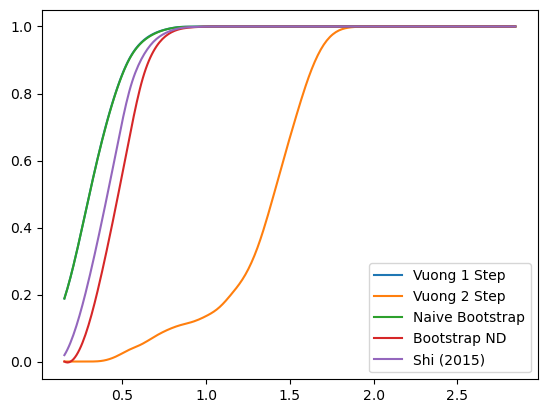

In [8]:
calc_c =lambda nobs: (10*nobs**(-1/2), 3*(nobs)**(-5/9))
c1,c2 = calc_c(nobs)
mc_run_power(nobs,c1,c2)

# sequence 4

Quantiles: 1th: 0.67, 5th: 1.86, 10th: 3.13, 30th: 9.00, 50th: 15.54, 70th: 23.18, 90th: 37.12, 95th: 43.73, 99th: 57.05
bonus term 2.003612944204267 // variance stats 11.493012786039248 //part1 23.22791048043381 //part2 11.593012786039248 11.493012786039248
-0.07178712432732341 -0.7734522702423533 3.8742095794801266
-4.0790130127358575 -0.7734522702423533 -0.13301630892840777
---
Quantiles: 1th: 0.81, 5th: 2.11, 10th: 3.60, 30th: 10.16, 50th: 18.28, 70th: 27.91, 90th: 44.00, 95th: 51.92, 99th: 68.09
bonus term 7.536364730260474 // variance stats 2.9821107140910623 //part1 23.22791048043381 //part2 3.0821107140910624 2.9821107140910623
5.702831753270575 -4.146539908091154 9.269234243838977
-9.369897707250374 -4.146539908091154 -5.803495216681973
---
Quantiles: 1th: 0.71, 5th: 1.77, 10th: 3.01, 30th: 8.43, 50th: 14.82, 70th: 22.60, 90th: 35.68, 95th: 42.22, 99th: 56.33
bonus term 1.825359433085248 // variance stats 12.625115974103615 //part1 23.22791048043381 //part2 12.725115974103616 

Quantiles: 1th: 0.56, 5th: 1.33, 10th: 2.36, 30th: 6.51, 50th: 11.98, 70th: 18.39, 90th: 29.28, 95th: 35.00, 99th: 45.36
bonus term 19.076381556131754 // variance stats 1.1176266453932207 //part1 23.22791048043381 //part2 1.2176266453932205 1.1176266453932207
16.609510247441225 -7.131123570985247 20.95640556627464
-21.543252864822282 -7.131123570985247 -17.196357545988867
---
Quantiles: 1th: 0.71, 5th: 2.15, 10th: 4.08, 30th: 11.89, 50th: 20.55, 70th: 31.11, 90th: 49.22, 95th: 58.32, 99th: 76.12
bonus term 0.4338692643074229 // variance stats 53.43665813943303 //part1 23.22791048043381 //part2 53.53665813943302 53.43665813943303
-1.626559318666021 0.6213779412441496 2.499123014770048
-2.4942978472808663 0.6213779412441496 1.6313844861552025
---
Quantiles: 1th: 0.65, 5th: 1.71, 10th: 3.09, 30th: 9.10, 50th: 16.16, 70th: 24.48, 90th: 38.51, 95th: 46.44, 99th: 60.60
bonus term 1.204828105637371 // variance stats 19.17902442825727 //part1 23.22791048043381 //part2 19.27902442825727 19.1790

Quantiles: 1th: 0.77, 5th: 1.82, 10th: 2.89, 30th: 8.60, 50th: 14.62, 70th: 22.65, 90th: 35.36, 95th: 42.28, 99th: 55.38
bonus term 0.3548895919328453 // variance stats 65.35108960205618 //part1 23.22791048043381 //part2 65.45108960205617 65.35108960205618
-1.7051883841692743 1.361283123030008 2.5053101530077186
-2.414967568034965 1.361283123030008 1.7955309691420276
---
Quantiles: 1th: 0.65, 5th: 1.85, 10th: 3.30, 30th: 9.88, 50th: 17.40, 70th: 26.47, 90th: 42.63, 95th: 51.46, 99th: 66.92
bonus term 6.706111682036538 // variance stats 3.3636927599422064 //part1 23.22791048043381 //part2 3.463692759942206 3.3636927599422064
4.833065028995395 -3.6494396942796112 8.65409582665729
-8.579158335077683 -3.6494396942796112 -4.758127537415786
---
Quantiles: 1th: 0.70, 5th: 1.85, 10th: 3.49, 30th: 10.05, 50th: 17.45, 70th: 27.66, 90th: 43.44, 95th: 51.49, 99th: 66.71
bonus term 4.12146346474432 // variance stats 5.535840443359305 //part1 23.22791048043381 //part2 5.635840443359306 5.53584044335

Quantiles: 1th: 0.63, 5th: 1.75, 10th: 2.92, 30th: 8.91, 50th: 16.11, 70th: 24.87, 90th: 39.49, 95th: 46.02, 99th: 60.18
bonus term 1.3264465804583048 // variance stats 17.41138027164898 //part1 23.22791048043381 //part2 17.51138027164898 17.41138027164898
-0.6131880725043622 -0.28785319784824603 3.2531244101473398
-3.2660812334209717 -0.28785319784824603 0.6002312492307301
---
Quantiles: 1th: 0.72, 5th: 2.11, 10th: 3.79, 30th: 11.55, 50th: 19.97, 70th: 30.54, 90th: 48.95, 95th: 58.28, 99th: 76.72
bonus term 0.2896159620643478 // variance stats 80.10245263716838 //part1 23.22791048043381 //part2 80.20245263716838 80.10245263716838
-1.6181028101272026 1.1525990622022437 2.33372770230112
-2.197334734255898 1.1525990622022437 1.7544957781724246
---
Quantiles: 1th: 0.71, 5th: 1.88, 10th: 2.98, 30th: 9.01, 50th: 15.93, 70th: 23.99, 90th: 38.33, 95th: 45.88, 99th: 59.87
bonus term 0.9990808594354456 // variance stats 23.149279836628335 //part1 23.22791048043381 //part2 23.249279836628332 23.

Quantiles: 1th: 0.59, 5th: 1.58, 10th: 2.71, 30th: 7.46, 50th: 12.88, 70th: 19.78, 90th: 31.11, 95th: 37.56, 99th: 49.70
bonus term 7.347900912932087 // variance stats 3.061162726017899 //part1 23.22791048043381 //part2 3.161162726017899 3.061162726017899
5.364839962841267 -4.53881185758992 9.125302915604061
-9.330961863022909 -4.53881185758992 -5.570498910260113
---
Quantiles: 1th: 0.70, 5th: 1.98, 10th: 3.67, 30th: 10.73, 50th: 18.73, 70th: 28.45, 90th: 45.60, 95th: 53.54, 99th: 70.14
bonus term 5.811017995760146 // variance stats 3.897218817319346 //part1 23.22791048043381 //part2 3.997218817319346 3.897218817319346
3.867269354528972 -3.8493326703797477 7.700601474634414
-7.75476663699132 -3.8493326703797477 -3.921434516885878
---
Quantiles: 1th: 0.83, 5th: 2.15, 10th: 3.65, 30th: 10.41, 50th: 18.16, 70th: 28.38, 90th: 44.76, 95th: 52.51, 99th: 70.20
bonus term 6.144701630450299 // variance stats 3.680152703481489 //part1 23.22791048043381 //part2 3.7801527034814892 3.68015270348148

Quantiles: 1th: 0.62, 5th: 1.80, 10th: 3.09, 30th: 9.43, 50th: 16.57, 70th: 25.43, 90th: 39.91, 95th: 48.07, 99th: 62.90
bonus term 0.8759187195842405 // variance stats 26.418340070936104 //part1 23.22791048043381 //part2 26.5183400709361 26.418340070936104
-1.253744536283179 0.04007713706622224 2.8638701201128387
-3.00558197545166 0.04007713706622224 1.1120326809443581
---
Quantiles: 1th: 0.72, 5th: 1.89, 10th: 3.25, 30th: 9.82, 50th: 16.99, 70th: 25.67, 90th: 40.93, 95th: 48.97, 99th: 66.04
bonus term 1.014629256070635 // variance stats 22.79300287908982 //part1 23.22791048043381 //part2 22.89300287908982 22.79300287908982
-1.0307834827607691 -0.17942753078783324 2.988982918801903
-3.0600419949020385 -0.17942753078783324 0.9597244066606333
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.78, 5th: 1.88, 10th: 3.53, 30th: 10.48, 50th: 18.39, 70th: 28.81, 90th: 45.04, 95th: 54.46, 99th: 71.77
bonus term 3.1237855088825506 // variance stats 7.33582119015046 //part1 23.22791048043381 

Quantiles: 1th: 0.72, 5th: 1.95, 10th: 3.45, 30th: 9.64, 50th: 17.11, 70th: 26.58, 90th: 41.18, 95th: 48.60, 99th: 63.09
bonus term 2.1813089780217902 // variance stats 10.548610863692954 //part1 23.22791048043381 //part2 10.648610863692953 10.548610863692954
0.04805151854704389 -1.5742140949338943 4.075834967068876
-4.314566437496537 -1.5742140949338943 -0.28678298897470483
---
Quantiles: 1th: 0.61, 5th: 1.71, 10th: 3.21, 30th: 9.86, 50th: 16.69, 70th: 25.50, 90th: 42.01, 95th: 50.07, 99th: 68.27
bonus term 1.1265249549243288 // variance stats 20.519082053086063 //part1 23.22791048043381 //part2 20.61908205308606 20.519082053086063
-0.9366045939760131 -0.46385886591838454 2.9812470281040713
-3.189654503824671 -0.46385886591838454 0.7281971182554134
---
Quantiles: 1th: 0.76, 5th: 2.22, 10th: 4.05, 30th: 11.89, 50th: 21.40, 70th: 32.61, 90th: 51.24, 95th: 61.48, 99th: 81.00
bonus term 1.9526040869127281 // variance stats 11.795862881839795 //part1 23.22791048043381 //part2 11.8958628818

Quantiles: 1th: 0.71, 5th: 1.82, 10th: 3.00, 30th: 8.24, 50th: 14.47, 70th: 22.59, 90th: 36.46, 95th: 43.11, 99th: 56.93
bonus term 1.1426835001529199 // variance stats 20.227510178737447 //part1 23.22791048043381 //part2 20.327510178737445 20.227510178737447
-0.8575499991240035 -0.9877601153673607 3.215682943715776
-3.1429169994298434 -0.9877601153673607 0.9303159434099362
---
Quantiles: 1th: 0.80, 5th: 1.79, 10th: 2.92, 30th: 8.40, 50th: 14.68, 70th: 21.98, 90th: 35.02, 95th: 42.13, 99th: 54.66
bonus term 0.8980289373916374 // variance stats 25.765436528025756 //part1 23.22791048043381 //part2 25.865436528025754 25.765436528025756
-0.994296048170458 -0.29368976208728037 2.8224519524095575
-2.7903539229537326 -0.29368976208728037 1.0263940776262832
---
Quantiles: 1th: 0.74, 5th: 2.05, 10th: 3.51, 30th: 10.22, 50th: 18.06, 70th: 27.54, 90th: 43.63, 95th: 51.78, 99th: 68.11
bonus term 4.111867649122104 // variance stats 5.548992735793195 //part1 23.22791048043381 //part2 5.6489927357931

Quantiles: 1th: 0.73, 5th: 1.80, 10th: 3.09, 30th: 9.28, 50th: 16.19, 70th: 25.23, 90th: 40.52, 95th: 48.14, 99th: 64.08
bonus term 0.7084224563623939 // variance stats 32.68821876949587 //part1 23.22791048043381 //part2 32.78821876949586 32.68821876949587
-1.2058309914416714 0.1109131238343874 2.7694055239563675
-2.622675904166459 0.1109131238343874 1.3525606112315798
---
Quantiles: 1th: 0.76, 5th: 2.24, 10th: 3.87, 30th: 11.26, 50th: 19.80, 70th: 30.28, 90th: 47.91, 95th: 56.84, 99th: 74.77
bonus term 1.104229681700929 // variance stats 20.935397676191872 //part1 23.22791048043381 //part2 21.03539767619187 20.935397676191872
-0.849601235631144 -1.4788525889569426 3.0411861081344584
-3.058060599033002 -1.4788525889569426 0.8327267447326006
---
Quantiles: 1th: 0.78, 5th: 2.14, 10th: 3.86, 30th: 10.67, 50th: 18.97, 70th: 29.30, 90th: 45.22, 95th: 53.43, 99th: 70.08
bonus term 0.6367782142387688 // variance stats 36.377238010099674 //part1 23.22791048043381 //part2 36.47723801009967 36.3

Quantiles: 1th: 0.91, 5th: 2.13, 10th: 3.75, 30th: 10.35, 50th: 18.42, 70th: 28.04, 90th: 44.51, 95th: 53.22, 99th: 67.68
bonus term 0.7830933317103058 // variance stats 29.56173959073712 //part1 23.22791048043381 //part2 29.661739590737113 29.56173959073712
-1.210949360000889 -0.4164478515661546 2.835050721323065
-2.777136023421501 -0.4164478515661546 1.2688640579024533
---
Quantiles: 1th: 0.69, 5th: 1.88, 10th: 3.18, 30th: 9.35, 50th: 16.35, 70th: 24.97, 90th: 40.12, 95th: 47.73, 99th: 63.15
bonus term 0.3762065570632971 // variance stats 61.642439211461415 //part1 23.22791048043381 //part2 61.74243921146142 61.642439211461415
-1.5501654505413636 0.8376670409550132 2.465337452906341
-2.3025785646679577 0.8376670409550132 1.7129243387797473
---
Quantiles: 1th: 0.62, 5th: 1.74, 10th: 3.02, 30th: 8.92, 50th: 15.35, 70th: 23.75, 90th: 38.29, 95th: 46.23, 99th: 60.40
bonus term 0.9058614574103812 // variance stats 25.541791347251134 //part1 23.22791048043381 //part2 25.64179134725113 25.5

Quantiles: 1th: 0.69, 5th: 1.85, 10th: 3.31, 30th: 9.72, 50th: 17.32, 70th: 27.40, 90th: 43.00, 95th: 50.98, 99th: 66.16
bonus term 3.2410996934076906 // variance stats 7.0666757204904105 //part1 23.22791048043381 //part2 7.166675720490411 7.0666757204904105
0.8875422003190412 -5.1975911389811005 5.392219292461395
-5.59465718649634 -5.1975911389811005 -1.0899800943539866
---
Quantiles: 1th: 0.74, 5th: 1.81, 10th: 3.04, 30th: 8.52, 50th: 14.45, 70th: 21.91, 90th: 35.12, 95th: 41.80, 99th: 54.53
bonus term 1.745388033298946 // variance stats 13.208164165953914 //part1 23.22791048043381 //part2 13.308164165953913 13.208164165953914
-0.3065721480045627 -2.250387597351445 3.803080964203409
-3.7973482146024544 -2.250387597351445 0.3123048976055173
---
Quantiles: 1th: 0.79, 5th: 1.79, 10th: 3.05, 30th: 8.94, 50th: 15.94, 70th: 25.04, 90th: 40.13, 95th: 48.07, 99th: 61.67
bonus term 3.631816269812252 // variance stats 6.295673336645574 //part1 23.22791048043381 //part2 6.395673336645574 6.2956

Quantiles: 1th: 0.71, 5th: 2.02, 10th: 3.78, 30th: 11.82, 50th: 20.26, 70th: 30.34, 90th: 48.08, 95th: 57.11, 99th: 74.21
bonus term 2.77310293651725 // variance stats 8.276144345224278 //part1 23.22791048043381 //part2 8.37614434522428 8.276144345224278
0.7551287269135655 -3.2192540210199176 4.815607205509763
-4.7910771461209345 -3.2192540210199176 -0.7305986675247371
---
Quantiles: 1th: 0.72, 5th: 1.87, 10th: 2.93, 30th: 8.67, 50th: 15.14, 70th: 23.13, 90th: 37.03, 95th: 43.91, 99th: 57.16
bonus term 1.1719736687804825 // variance stats 19.719481528628553 //part1 23.22791048043381 //part2 19.819481528628554 19.719481528628553
-0.793599299100912 -1.4949256468752672 3.0413947745070455
-3.1375466366618765 -1.4949256468752672 0.6974474369460806
---
Quantiles: 1th: 0.75, 5th: 1.77, 10th: 2.93, 30th: 8.67, 50th: 15.03, 70th: 23.19, 90th: 36.51, 95th: 43.75, 99th: 57.42
bonus term 1.9916098563875169 // variance stats 11.562881867117174 //part1 23.22791048043381 //part2 11.662881867117175 11

Quantiles: 1th: 0.70, 5th: 1.70, 10th: 3.13, 30th: 9.73, 50th: 16.95, 70th: 25.84, 90th: 41.16, 95th: 50.02, 99th: 64.61
bonus term 0.7268688081842405 // variance stats 31.856124982799095 //part1 23.22791048043381 //part2 31.956124982799096 31.856124982799095
-1.2623067210587369 -0.5250046548142286 2.735402331589106
-2.716044337427218 -0.5250046548142286 1.281664715220625
---
Quantiles: 1th: 0.71, 5th: 1.81, 10th: 2.88, 30th: 8.57, 50th: 14.76, 70th: 22.79, 90th: 36.05, 95th: 43.42, 99th: 56.06
bonus term 2.855093278996809 // variance stats 8.035604763356584 //part1 23.22791048043381 //part2 8.135604763356586 8.035604763356584
0.8781282583408863 -5.224351321791008 4.831286988560238
-4.832058299652731 -5.224351321791008 -0.8788995694333798
---
Quantiles: 1th: 0.81, 5th: 1.96, 10th: 3.23, 30th: 9.38, 50th: 16.09, 70th: 24.33, 90th: 38.61, 95th: 45.68, 99th: 59.64
bonus term 0.5025015473438652 // variance stats 46.12455513463084 //part1 23.22791048043381 //part2 46.22455513463084 46.12455

Quantiles: 1th: 0.78, 5th: 2.00, 10th: 3.27, 30th: 9.63, 50th: 17.45, 70th: 27.08, 90th: 43.16, 95th: 53.29, 99th: 68.32
bonus term 1.012949244537065 // variance stats 22.830971720156978 //part1 23.22791048043381 //part2 22.930971720156975 22.830971720156978
-0.7878463509858515 -1.1339702793873243 2.9031810081727727
-2.8137448400599814 -1.1339702793873243 0.8772825190986432
---
Quantiles: 1th: 0.70, 5th: 1.61, 10th: 2.69, 30th: 8.08, 50th: 13.96, 70th: 21.67, 90th: 35.32, 95th: 42.13, 99th: 54.66
bonus term 0.46481409868620227 // variance stats 49.87247404088545 //part1 23.22791048043381 //part2 49.972474040885444 49.87247404088545
-1.478045546618084 0.3510509416234235 2.570815176320097
-2.4076737439904883 0.3510509416234235 1.641186978947692
---
Quantiles: 1th: 0.66, 5th: 1.71, 10th: 2.73, 30th: 7.66, 50th: 13.67, 70th: 21.12, 90th: 33.43, 95th: 38.94, 99th: 51.75
bonus term 1.0249761657429244 // variance stats 22.561903034201514 //part1 23.22791048043381 //part2 22.66190303420151 22.

0.7692307692307693 [0.96571429 0.         0.03428571]
Quantiles: 1th: 0.67, 5th: 1.85, 10th: 3.37, 30th: 9.89, 50th: 17.68, 70th: 26.61, 90th: 42.07, 95th: 50.27, 99th: 66.69
bonus term 0.5098884611452571 // variance stats 45.45488552979166 //part1 23.22791048043381 //part2 45.55488552979166 45.45488552979166
-1.6102072430765588 -0.3024440075753666 2.331304439132725
-2.6299841653670732 -0.3024440075753666 1.3115275168422107
---
Quantiles: 1th: 0.74, 5th: 1.93, 10th: 3.58, 30th: 10.54, 50th: 18.49, 70th: 28.84, 90th: 44.81, 95th: 53.50, 99th: 69.18
bonus term 0.5586138533338978 // variance stats 41.48133626977899 //part1 23.22791048043381 //part2 41.581336269778994 41.48133626977899
-1.4260894138006643 -0.8056614656675473 2.575945852784491
-2.54331712046846 -0.8056614656675473 1.4587181461166951
---
Quantiles: 1th: 0.89, 5th: 2.33, 10th: 3.79, 30th: 10.29, 50th: 18.36, 70th: 28.15, 90th: 44.62, 95th: 52.14, 99th: 67.44
bonus term 0.5178500363799277 // variance stats 44.75451163199753 //

Quantiles: 1th: 0.72, 5th: 2.26, 10th: 4.31, 30th: 12.71, 50th: 22.00, 70th: 33.16, 90th: 52.64, 95th: 63.42, 99th: 83.78
bonus term 0.4816970279541897 // variance stats 48.1209960461762 //part1 23.22791048043381 //part2 48.2209960461762 48.1209960461762
-1.440039330545588 -0.4917685983443312 2.5121554202756715
-2.4034333864539676 -0.4917685983443312 1.5487613643672922
---
Quantiles: 1th: 0.73, 5th: 1.72, 10th: 2.90, 30th: 8.31, 50th: 14.83, 70th: 22.98, 90th: 35.91, 95th: 42.57, 99th: 55.18
bonus term 0.3541996315896491 // variance stats 65.47858452925789 //part1 23.22791048043381 //part2 65.57858452925788 65.47858452925789
-1.4865234965204632 0.6177223645230564 2.3223058173762725
-2.1949227596997614 0.6177223645230564 1.6139065541969744
---
Quantiles: 1th: 0.72, 5th: 1.85, 10th: 3.06, 30th: 8.81, 50th: 15.45, 70th: 23.70, 90th: 38.03, 95th: 45.19, 99th: 59.12
bonus term 1.108030974079372 // variance stats 20.86323209712901 //part1 23.22791048043381 //part2 20.96323209712901 20.863232

Quantiles: 1th: 0.70, 5th: 1.85, 10th: 3.30, 30th: 9.26, 50th: 16.29, 70th: 24.93, 90th: 39.59, 95th: 46.92, 99th: 61.73
bonus term 0.352123271392094 // variance stats 65.86528081942423 //part1 23.22791048043381 //part2 65.96528081942422 65.86528081942423
-1.7283685443857952 0.5048861311167021 2.2936979641373223
-2.432615087169983 0.5048861311167021 1.5894514213531343
---
Quantiles: 1th: 0.79, 5th: 2.02, 10th: 3.56, 30th: 10.11, 50th: 17.76, 70th: 27.08, 90th: 43.16, 95th: 51.31, 99th: 66.98
bonus term 0.8486292442324505 // variance stats 27.271093605715272 //part1 23.22791048043381 //part2 27.37109360571527 27.271093605715272
-1.1353848663350097 -1.4975993074399958 2.8607680404747895
-2.832643354799911 -1.4975993074399958 1.1635095520098884
---
Quantiles: 1th: 0.55, 5th: 1.48, 10th: 2.40, 30th: 6.57, 50th: 11.31, 70th: 17.53, 90th: 27.85, 95th: 33.16, 99th: 43.40
bonus term 0.46976741992107596 // variance stats 49.34555432204356 //part1 23.22791048043381 //part2 49.44555432204356 49.3

Quantiles: 1th: 0.68, 5th: 2.03, 10th: 3.48, 30th: 10.53, 50th: 18.19, 70th: 28.14, 90th: 45.69, 95th: 54.67, 99th: 72.09
bonus term 0.356212149563207 // variance stats 65.10808037826963 //part1 23.22791048043381 //part2 65.20808037826964 65.10808037826963
-1.76815810992446 0.19883034524541832 2.2890574393140275
-2.480582409050874 0.19883034524541832 1.5766331401876132
---
Quantiles: 1th: 0.87, 5th: 2.21, 10th: 3.71, 30th: 10.80, 50th: 19.47, 70th: 29.93, 90th: 47.48, 95th: 57.03, 99th: 73.86
bonus term 1.2662838569829404 // variance stats 18.24336776256221 //part1 23.22791048043381 //part2 18.343367762562213 18.24336776256221
-0.7411007577732804 -3.2117267246003562 3.2802193518253215
-3.2736684717391613 -3.2117267246003562 0.7476516378594408
---
Quantiles: 1th: 0.66, 5th: 1.59, 10th: 2.89, 30th: 7.80, 50th: 13.93, 70th: 21.65, 90th: 33.83, 95th: 39.92, 99th: 54.20
bonus term 0.4487331666187478 // variance stats 51.66330213221944 //part1 23.22791048043381 //part2 51.763302132219444 51.

Quantiles: 1th: 0.57, 5th: 1.61, 10th: 2.81, 30th: 8.77, 50th: 15.58, 70th: 23.51, 90th: 38.00, 95th: 45.22, 99th: 58.67
bonus term 0.8190952352298494 // variance stats 28.258009522440624 //part1 23.22791048043381 //part2 28.35800952244062 28.258009522440624
-1.2046716342632504 -1.7207246514047505 2.805615947240325
-2.8428621047229488 -1.7207246514047505 1.167425476780626
---
Quantiles: 1th: 0.71, 5th: 1.68, 10th: 2.81, 30th: 8.66, 50th: 15.31, 70th: 23.69, 90th: 37.81, 95th: 45.32, 99th: 59.85
bonus term 0.563378949594495 // variance stats 41.129638589004145 //part1 23.22791048043381 //part2 41.22963858900414 41.129638589004145
-1.4737045910709916 -0.8653470528475292 2.6286442816642883
-2.6004624902599818 -0.8653470528475292 1.501886382475298
---
Quantiles: 1th: 0.71, 5th: 1.67, 10th: 2.90, 30th: 8.55, 50th: 15.08, 70th: 23.36, 90th: 36.87, 95th: 44.21, 99th: 58.14
bonus term 0.630511111181642 // variance stats 36.7398114934126 //part1 23.22791048043381 //part2 36.839811493412604 36.7

Quantiles: 1th: 0.83, 5th: 1.99, 10th: 3.55, 30th: 10.01, 50th: 17.07, 70th: 26.37, 90th: 41.92, 95th: 49.83, 99th: 66.10
bonus term 0.34208304717715 // variance stats 67.80137854567543 //part1 23.22791048043381 //part2 67.90137854567544 67.80137854567543
-1.649756888878021 0.5777475762682669 2.3490106791024825
-2.3339229832323207 0.5777475762682669 1.6648445847481828
---
Quantiles: 1th: 0.70, 5th: 1.97, 10th: 3.60, 30th: 10.40, 50th: 18.12, 70th: 28.06, 90th: 44.02, 95th: 52.16, 99th: 69.69
bonus term 0.3442678116822515 // variance stats 67.37046831631315 //part1 23.22791048043381 //part2 67.47046831631314 67.37046831631315
-1.6298548667533992 0.16264519350543485 2.3841731392691696
-2.318390490117902 0.16264519350543485 1.6956375159046664
---
1.076923076923077 [0.92142857 0.00285714 0.07571429]
Quantiles: 1th: 0.76, 5th: 1.86, 10th: 3.28, 30th: 9.65, 50th: 16.82, 70th: 26.29, 90th: 41.71, 95th: 50.10, 99th: 65.14
bonus term 0.4867376797978157 // variance stats 47.621619764638666 //par

Quantiles: 1th: 0.69, 5th: 1.64, 10th: 2.61, 30th: 7.50, 50th: 13.00, 70th: 19.72, 90th: 30.91, 95th: 37.03, 99th: 48.47
bonus term 0.3940890574502251 // variance stats 58.84076488882866 //part1 23.22791048043381 //part2 58.94076488882866 58.84076488882866
-1.5252781056703175 0.03955892085133048 2.373140786491213
-2.313456220570768 0.03955892085133048 1.584962671590763
---
Quantiles: 1th: 0.72, 5th: 1.94, 10th: 3.65, 30th: 10.43, 50th: 18.55, 70th: 28.54, 90th: 45.31, 95th: 53.49, 99th: 70.65
bonus term 0.3785557145035671 // variance stats 61.259291619450465 //part1 23.22791048043381 //part2 61.35929161945047 61.259291619450465
-1.855898335640095 -0.08967257388647261 2.3008467812955686
-2.6130097646472294 -0.08967257388647261 1.5437353522884343
---
Quantiles: 1th: 0.68, 5th: 1.86, 10th: 3.05, 30th: 8.65, 50th: 15.38, 70th: 23.86, 90th: 37.93, 95th: 45.29, 99th: 59.46
bonus term 0.5023009422863314 // variance stats 46.1430159392235 //part1 23.22791048043381 //part2 46.243015939223504 46

Quantiles: 1th: 0.80, 5th: 2.00, 10th: 3.57, 30th: 10.26, 50th: 17.77, 70th: 27.77, 90th: 43.27, 95th: 51.54, 99th: 67.18
bonus term 0.18897327315782775 // variance stats 122.81637908517462 //part1 23.22791048043381 //part2 122.91637908517461 122.81637908517462
-1.7509948613288226 1.5604102981200494 2.3080545649040984
-2.1289414076444784 1.5604102981200494 1.9301080185884427
---
Quantiles: 1th: 0.76, 5th: 1.91, 10th: 3.33, 30th: 9.18, 50th: 16.34, 70th: 25.57, 90th: 40.33, 95th: 47.70, 99th: 63.69
bonus term 0.2771599123190288 // variance stats 83.70689070826735 //part1 23.22791048043381 //part2 83.80689070826735 83.70689070826735
-1.6811090914866689 0.8867724133172133 2.366315290249365
-2.2354289161247265 0.8867724133172133 1.811995465611307
---
Quantiles: 1th: 0.71, 5th: 1.78, 10th: 2.96, 30th: 8.63, 50th: 15.19, 70th: 22.98, 90th: 36.92, 95th: 44.61, 99th: 57.25
bonus term 0.35637577818397326 // variance stats 65.07814032928684 //part1 23.22791048043381 //part2 65.17814032928685 65.

Quantiles: 1th: 0.84, 5th: 2.02, 10th: 3.58, 30th: 9.67, 50th: 16.73, 70th: 25.90, 90th: 41.36, 95th: 50.12, 99th: 64.80
bonus term 0.443077538732776 // variance stats 52.32403067162195 //part1 23.22791048043381 //part2 52.42403067162194 52.32403067162195
-1.375441569340825 -0.6451827060349837 2.5888888671004793
-2.2615966468063773 -0.6451827060349837 1.7027337896349273
---
Quantiles: 1th: 0.73, 5th: 1.97, 10th: 3.84, 30th: 11.61, 50th: 21.07, 70th: 32.34, 90th: 52.85, 95th: 63.87, 99th: 81.45
bonus term 0.2487805330254144 // variance stats 93.26707417561865 //part1 23.22791048043381 //part2 93.36707417561865 93.26707417561865
-1.6976443655408344 0.48452778626848747 2.004705362526436
-2.1952054315916634 0.48452778626848747 1.507144296475607
---
Quantiles: 1th: 0.76, 5th: 2.05, 10th: 3.72, 30th: 11.13, 50th: 19.73, 70th: 30.56, 90th: 48.38, 95th: 57.84, 99th: 77.11
bonus term 0.3032406348480513 // variance stats 76.49893764591582 //part1 23.22791048043381 //part2 76.59893764591581 76.49

Quantiles: 1th: 0.79, 5th: 2.17, 10th: 3.80, 30th: 11.34, 50th: 20.14, 70th: 31.78, 90th: 50.82, 95th: 60.72, 99th: 80.99
bonus term 0.4373430912182888 // variance stats 53.0114151494397 //part1 23.22791048043381 //part2 53.11141514943969 53.0114151494397
-1.6051106368829193 -0.5648364756047168 2.5041659574178383
-2.4797968193194966 -0.5648364756047168 1.6294797749812606
---
Quantiles: 1th: 0.57, 5th: 1.61, 10th: 2.91, 30th: 8.19, 50th: 14.57, 70th: 22.09, 90th: 35.54, 95th: 42.08, 99th: 55.09
bonus term 0.6819061940824103 // variance stats 33.96320500093104 //part1 23.22791048043381 //part2 34.063205000931035 33.96320500093104
-1.3908983964523363 -1.9606172056759295 2.5125620229635284
-2.754710784617157 -1.9606172056759295 1.1487496347987078
---
Quantiles: 1th: 0.85, 5th: 2.17, 10th: 3.82, 30th: 11.31, 50th: 19.28, 70th: 30.40, 90th: 48.09, 95th: 57.19, 99th: 75.84
bonus term 0.29295403522036373 // variance stats 79.18858349044922 //part1 23.22791048043381 //part2 79.28858349044921 79

Quantiles: 1th: 0.79, 5th: 1.92, 10th: 3.35, 30th: 9.50, 50th: 16.52, 70th: 25.57, 90th: 40.31, 95th: 48.00, 99th: 61.89
bonus term 0.3450870067653746 // variance stats 67.21030153281464 //part1 23.22791048043381 //part2 67.31030153281463 67.21030153281464
-1.6063042739467523 -0.4206530743471896 2.2806603703975994
-2.2964782874775014 -0.4206530743471896 1.5904863568668506
---
Quantiles: 1th: 0.67, 5th: 1.58, 10th: 2.82, 30th: 8.77, 50th: 15.01, 70th: 22.63, 90th: 36.15, 95th: 42.91, 99th: 56.20
bonus term 0.470313558079656 // variance stats 49.288137087257326 //part1 23.22791048043381 //part2 49.38813708725732 49.288137087257326
-1.3537495663571952 -0.9650628986787717 2.379362138707296
-2.294376682516507 -0.9650628986787717 1.4387350225479836
---
Quantiles: 1th: 0.61, 5th: 1.59, 10th: 2.66, 30th: 8.24, 50th: 13.98, 70th: 21.76, 90th: 33.99, 95th: 40.06, 99th: 53.07
bonus term 0.2437562922308647 // variance stats 95.19153183227105 //part1 23.22791048043381 //part2 95.29153183227106 95.1

Quantiles: 1th: 0.52, 5th: 1.57, 10th: 2.72, 30th: 7.48, 50th: 13.08, 70th: 20.20, 90th: 32.02, 95th: 38.49, 99th: 50.81
bonus term 0.5471962795801874 // variance stats 42.348955424650214 //part1 23.22791048043381 //part2 42.44895542465021 42.348955424650214
-1.4015341745445251 -1.740960005184065 2.481232489931
-2.4959267337049003 -1.740960005184065 1.386839930770625
---
Quantiles: 1th: 0.77, 5th: 1.93, 10th: 3.60, 30th: 10.33, 50th: 17.99, 70th: 27.19, 90th: 43.10, 95th: 51.77, 99th: 68.36
bonus term 1.595610651880948 // variance stats 14.457379930406038 //part1 23.22791048043381 //part2 14.557379930406038 14.457379930406038
-0.9604884468970417 -7.601699399259264 3.7112092388830273
-4.151709750658938 -7.601699399259264 0.5199879351211313
---
Quantiles: 1th: 0.69, 5th: 2.01, 10th: 3.49, 30th: 10.14, 50th: 18.35, 70th: 27.87, 90th: 44.25, 95th: 52.38, 99th: 68.41
bonus term 0.3318813578025684 // variance stats 69.8885966305217 //part1 23.22791048043381 //part2 69.98859663052171 69.88859

Quantiles: 1th: 0.81, 5th: 2.24, 10th: 3.92, 30th: 11.80, 50th: 20.14, 70th: 32.00, 90th: 51.39, 95th: 61.49, 99th: 84.25
bonus term 0.6145719963228432 // variance stats 37.69526340186816 //part1 23.22791048043381 //part2 37.79526340186816 37.69526340186816
-1.287492669682582 -2.889963495608912 2.455393827040112
-2.5166366623282683 -2.889963495608912 1.226249834394426
---
Quantiles: 1th: 0.78, 5th: 2.19, 10th: 3.44, 30th: 9.79, 50th: 17.11, 70th: 26.54, 90th: 41.51, 95th: 49.50, 99th: 64.52
bonus term 0.25015422268943016 // variance stats 92.75436092466676 //part1 23.22791048043381 //part2 92.85436092466675 92.75436092466676
-1.6224094178527 0.2833437171969584 2.3616746721892836
-2.12271786323156 0.2833437171969584 1.8613662268104232
---
Quantiles: 1th: 0.76, 5th: 1.78, 10th: 3.28, 30th: 9.81, 50th: 16.85, 70th: 26.41, 90th: 42.47, 95th: 51.07, 99th: 68.44
bonus term 0.3783248099086903 // variance stats 61.296741297616535 //part1 23.22791048043381 //part2 61.39674129761653 61.296741297

Quantiles: 1th: 0.83, 5th: 2.22, 10th: 3.72, 30th: 11.33, 50th: 19.57, 70th: 30.59, 90th: 49.81, 95th: 60.88, 99th: 78.40
bonus term 0.23590816362405126 // variance stats 98.36166458847244 //part1 23.22791048043381 //part2 98.46166458847243 98.36166458847244
-1.792303802362362 0.07518620608172644 2.0885113256341095
-2.2641201296104647 0.07518620608172644 1.6166949983860068
---
Quantiles: 1th: 0.80, 5th: 2.02, 10th: 3.32, 30th: 8.96, 50th: 15.73, 70th: 24.21, 90th: 38.36, 95th: 45.91, 99th: 60.96
bonus term 0.5360035027613794 // variance stats 43.235370684647414 //part1 23.22791048043381 //part2 43.335370684647415 43.235370684647414
-1.5479884966711148 -2.58853136848825 2.439456607458522
-2.619995502193874 -2.58853136848825 1.367449601935763
---
Quantiles: 1th: 0.76, 5th: 2.36, 10th: 4.14, 30th: 11.87, 50th: 21.45, 70th: 32.42, 90th: 51.10, 95th: 61.61, 99th: 80.52
bonus term 0.24949186049088126 // variance stats 93.00087485312079 //part1 23.22791048043381 //part2 93.1008748531208 93.00

1.6153846153846154 [0.94571429 0.         0.05428571]
Quantiles: 1th: 0.78, 5th: 2.06, 10th: 3.49, 30th: 10.51, 50th: 18.36, 70th: 28.00, 90th: 44.73, 95th: 52.89, 99th: 68.16
bonus term 0.26335030300947543 // variance stats 88.10157112026586 //part1 23.22791048043381 //part2 88.20157112026585 88.10157112026586
-1.8271295851473344 -0.5127348582542599 2.173864715454756
-2.353830191166285 -0.5127348582542599 1.647164109435805
---
Quantiles: 1th: 0.66, 5th: 1.80, 10th: 3.02, 30th: 9.04, 50th: 15.95, 70th: 24.53, 90th: 39.47, 95th: 46.87, 99th: 63.37
bonus term 0.414202593946265 // variance stats 55.97862147634737 //part1 23.22791048043381 //part2 56.07862147634737 55.97862147634737
-1.6100070913113083 -1.5657663898429879 2.302287106201622
-2.4384122792038383 -1.5657663898429879 1.4738819183090923
---
Quantiles: 1th: 0.68, 5th: 1.62, 10th: 2.70, 30th: 7.79, 50th: 13.21, 70th: 20.27, 90th: 31.53, 95th: 38.34, 99th: 50.22
bonus term 0.3739935744608874 // variance stats 62.007779562568416 //p

Quantiles: 1th: 0.83, 5th: 1.99, 10th: 3.45, 30th: 9.76, 50th: 17.40, 70th: 26.51, 90th: 42.19, 95th: 50.36, 99th: 66.55
bonus term 0.24568650082350932 // variance stats 94.44288454016343 //part1 23.22791048043381 //part2 94.54288454016343 94.44288454016343
-1.6600272340508926 0.4167884648203915 2.170856446411341
-2.1514002356979116 0.4167884648203915 1.6794834447643219
---
Quantiles: 1th: 0.77, 5th: 1.97, 10th: 3.41, 30th: 10.20, 50th: 17.91, 70th: 27.43, 90th: 44.08, 95th: 51.64, 99th: 68.23
bonus term 0.22239816176820762 // variance stats 104.34290679274085 //part1 23.22791048043381 //part2 104.44290679274084 104.34290679274085
-1.6487160281210407 0.3445866519897051 2.09033336472582
-2.093512351657456 0.3445866519897051 1.645537041189405
---
Quantiles: 1th: 0.79, 5th: 2.23, 10th: 4.44, 30th: 13.43, 50th: 23.35, 70th: 35.89, 90th: 57.81, 95th: 67.93, 99th: 89.78
bonus term 0.3913577654474636 // variance stats 59.25211341437393 //part1 23.22791048043381 //part2 59.35211341437393 59.25

Quantiles: 1th: 0.84, 5th: 2.32, 10th: 4.02, 30th: 11.98, 50th: 20.78, 70th: 31.86, 90th: 50.02, 95th: 58.60, 99th: 76.07
bonus term 0.32380344671878186 // variance stats 71.63459923237593 //part1 23.22791048043381 //part2 71.73459923237593 71.63459923237593
-1.4634192807641715 -1.3261213545121486 2.2115626588500543
-2.111026174201735 -1.3261213545121486 1.5639557654124907
---
Quantiles: 1th: 0.81, 5th: 1.86, 10th: 3.14, 30th: 9.11, 50th: 15.97, 70th: 24.95, 90th: 39.03, 95th: 46.96, 99th: 60.06
bonus term 0.2634072203406635 // variance stats 88.08251242465276 //part1 23.22791048043381 //part2 88.18251242465277 88.08251242465276
-1.714361290706631 0.06569133737232838 2.341052936253251
-2.241175731387958 0.06569133737232838 1.814238495571924
---
Quantiles: 1th: 0.66, 5th: 1.86, 10th: 3.34, 30th: 9.93, 50th: 16.92, 70th: 25.81, 90th: 41.36, 95th: 49.63, 99th: 64.68
bonus term 0.49512673050545997 // variance stats 46.81306093840084 //part1 23.22791048043381 //part2 46.91306093840083 46.81

Quantiles: 1th: 0.76, 5th: 1.89, 10th: 3.48, 30th: 10.34, 50th: 17.86, 70th: 27.57, 90th: 43.79, 95th: 52.78, 99th: 67.93
bonus term 0.21256283134751003 // variance stats 109.17550378014808 //part1 23.22791048043381 //part2 109.27550378014807 109.17550378014808
-1.8040749466936865 0.3538036220009223 2.258518140399193
-2.2292006093887067 0.3538036220009223 1.833392477704173
---
Quantiles: 1th: 0.75, 5th: 2.02, 10th: 3.61, 30th: 10.12, 50th: 18.29, 70th: 27.45, 90th: 43.43, 95th: 51.54, 99th: 66.39
bonus term 0.2755493659021485 // variance stats 84.19672993216892 //part1 23.22791048043381 //part2 84.29672993216892 84.19672993216892
-1.7242511038346227 -0.4267257450004099 2.3221975785533946
-2.2753498356389197 -0.4267257450004099 1.771098846749098
---
Quantiles: 1th: 0.56, 5th: 1.73, 10th: 3.07, 30th: 9.36, 50th: 16.39, 70th: 25.22, 90th: 40.36, 95th: 48.28, 99th: 60.63
bonus term 0.34889744047009347 // variance stats 66.4751816612276 //part1 23.22791048043381 //part2 66.57518166122759 66

Quantiles: 1th: 0.71, 5th: 1.80, 10th: 3.13, 30th: 9.29, 50th: 15.76, 70th: 24.53, 90th: 39.33, 95th: 46.81, 99th: 60.13
bonus term 0.18079236411146676 // variance stats 128.3783823398246 //part1 23.22791048043381 //part2 128.4783823398246 128.3783823398246
-1.7551328492643292 0.8589257999250747 2.115902247618759
-2.116717577487263 0.8589257999250747 1.7543175193958254
---
Quantiles: 1th: 0.80, 5th: 1.90, 10th: 3.42, 30th: 9.97, 50th: 17.32, 70th: 26.28, 90th: 41.28, 95th: 49.16, 99th: 65.20
bonus term 0.2841803303388693 // variance stats 81.63651727667363 //part1 23.22791048043381 //part2 81.73651727667362 81.63651727667363
-1.6489617592823766 -0.8995501466441544 2.370285492344691
-2.2173224199601154 -0.8995501466441544 1.801924831666953
---
Quantiles: 1th: 0.71, 5th: 1.74, 10th: 3.06, 30th: 8.98, 50th: 15.62, 70th: 24.17, 90th: 38.12, 95th: 45.06, 99th: 57.73
bonus term 0.19601870338455452 // variance stats 118.39843958443444 //part1 23.22791048043381 //part2 118.49843958443444 118.3

Quantiles: 1th: 0.79, 5th: 1.83, 10th: 3.01, 30th: 8.66, 50th: 15.20, 70th: 23.25, 90th: 36.41, 95th: 43.48, 99th: 58.24
bonus term 0.19814418260117062 // variance stats 117.12731485479695 //part1 23.22791048043381 //part2 117.22731485479696 117.12731485479695
-1.773496199828369 0.8957914685740258 2.1825103799907537
-2.16978456503071 0.8957914685740258 1.7862220147884122
---
Quantiles: 1th: 0.82, 5th: 2.11, 10th: 4.04, 30th: 11.12, 50th: 18.87, 70th: 29.11, 90th: 47.26, 95th: 55.62, 99th: 72.37
bonus term 0.2883736982300114 // variance stats 80.44795088110588 //part1 23.22791048043381 //part2 80.54795088110588 80.44795088110588
-1.6906153240393997 -1.0298502045019922 2.165089837039699
-2.2673627204994222 -1.0298502045019922 1.5883424405796762
---
1.9230769230769231 [0.94428571 0.00428571 0.05142857]
Quantiles: 1th: 0.76, 5th: 2.02, 10th: 3.53, 30th: 10.05, 50th: 17.53, 70th: 27.07, 90th: 42.81, 95th: 50.70, 99th: 67.81
bonus term 0.21100626317677126 // variance stats 109.98161620764093

Quantiles: 1th: 0.75, 5th: 1.95, 10th: 3.74, 30th: 11.21, 50th: 19.49, 70th: 29.74, 90th: 47.64, 95th: 57.48, 99th: 76.08
bonus term 0.17486321672923935 // variance stats 132.73474314898502 //part1 23.22791048043381 //part2 132.834743148985 132.73474314898502
-1.91601096519172 0.41120976151747773 2.222395140668984
-2.2657373986501987 0.41120976151747773 1.8726687072105055
---
Quantiles: 1th: 0.64, 5th: 1.83, 10th: 3.17, 30th: 9.58, 50th: 16.58, 70th: 25.82, 90th: 40.86, 95th: 49.17, 99th: 63.95
bonus term 0.24584541521030767 // variance stats 94.38177205405098 //part1 23.22791048043381 //part2 94.48177205405099 94.38177205405098
-1.7854757969528585 -0.6704132860121371 2.2019748020666468
-2.2771666273734734 -0.6704132860121371 1.7102839716460314
---
Quantiles: 1th: 0.57, 5th: 1.71, 10th: 2.73, 30th: 8.00, 50th: 14.20, 70th: 21.76, 90th: 34.57, 95th: 41.46, 99th: 53.95
bonus term 0.3341303274099594 // variance stats 69.4175162951744 //part1 23.22791048043381 //part2 69.5175162951744 69.4

Quantiles: 1th: 0.65, 5th: 1.65, 10th: 3.07, 30th: 8.58, 50th: 14.83, 70th: 22.81, 90th: 36.22, 95th: 43.70, 99th: 56.69
bonus term 0.26382835984979924 // variance stats 87.94174992278217 //part1 23.22791048043381 //part2 88.04174992278217 87.94174992278217
-1.7812764758461168 -0.8658917076624096 2.29111829851326
-2.3089331955457153 -0.8658917076624096 1.7634615788136616
---
Quantiles: 1th: 0.87, 5th: 2.04, 10th: 3.85, 30th: 10.94, 50th: 19.37, 70th: 30.28, 90th: 47.65, 95th: 57.37, 99th: 75.44
bonus term 0.15214342831406133 // variance stats 152.57113892350122 //part1 23.22791048043381 //part2 152.67113892350122 152.57113892350122
-1.7430742748892598 0.8926259050559108 2.0566358661436372
-2.0473611315173823 0.8926259050559108 1.7523490095155145
---
Quantiles: 1th: 0.81, 5th: 2.04, 10th: 3.50, 30th: 10.26, 50th: 18.22, 70th: 27.36, 90th: 42.89, 95th: 51.95, 99th: 67.19
bonus term 0.46501493332164856 // variance stats 49.85089150043957 //part1 23.22791048043381 //part2 49.95089150043957

Quantiles: 1th: 0.64, 5th: 1.56, 10th: 2.62, 30th: 7.50, 50th: 13.06, 70th: 20.53, 90th: 33.10, 95th: 39.68, 99th: 51.58
bonus term 0.20632381074344966 // variance stats 112.47988303306502 //part1 23.22791048043381 //part2 112.57988303306503 112.47988303306502
-1.7910998423818925 0.2145701077759703 2.207806057270527
-2.203747463868792 0.2145701077759703 1.795158435783628
---
Quantiles: 1th: 0.83, 5th: 2.05, 10th: 3.61, 30th: 10.69, 50th: 18.51, 70th: 28.40, 90th: 44.69, 95th: 53.03, 99th: 69.45
bonus term 0.19572385059500752 // variance stats 118.57695434061883 //part1 23.22791048043381 //part2 118.67695434061883 118.57695434061883
-1.693850439591536 0.06467066312788206 2.1665858093964125
-2.0852981407815507 0.06467066312788206 1.7751381082063975
---
Quantiles: 1th: 0.72, 5th: 2.15, 10th: 3.60, 30th: 9.98, 50th: 17.51, 70th: 26.63, 90th: 43.53, 95th: 51.38, 99th: 68.21
bonus term 0.3027410882488407 // variance stats 76.62533191577029 //part1 23.22791048043381 //part2 76.7253319157703 7

Quantiles: 1th: 0.93, 5th: 2.36, 10th: 4.18, 30th: 12.19, 50th: 21.99, 70th: 33.60, 90th: 52.42, 95th: 62.85, 99th: 83.56
bonus term 0.16743358820927545 // variance stats 138.62909688467772 //part1 23.22791048043381 //part2 138.72909688467774 138.62909688467772
-1.780113393175179 0.1392209460464015 2.062486056867884
-2.1149805695937296 0.1392209460464015 1.7276188804493333
---
Quantiles: 1th: 0.79, 5th: 1.89, 10th: 3.40, 30th: 9.71, 50th: 16.66, 70th: 25.23, 90th: 40.29, 95th: 47.55, 99th: 61.02
bonus term 0.197139641771404 // variance stats 117.72465602411947 //part1 23.22791048043381 //part2 117.82465602411946 117.72465602411947
-1.6350263482097909 0.12686367947123497 2.2449979898068007
-2.029305631752599 0.12686367947123497 1.850718706263993
---
Quantiles: 1th: 0.55, 5th: 1.67, 10th: 3.17, 30th: 9.17, 50th: 15.62, 70th: 23.79, 90th: 37.88, 95th: 44.59, 99th: 57.27
bonus term 0.24966255549298294 // variance stats 92.93722151913428 //part1 23.22791048043381 //part2 93.03722151913428 9

Quantiles: 1th: 0.56, 5th: 1.65, 10th: 2.86, 30th: 8.17, 50th: 14.25, 70th: 22.03, 90th: 34.88, 95th: 42.27, 99th: 55.48
bonus term 0.17188404414217784 // variance stats 135.0370954550052 //part1 23.22791048043381 //part2 135.13709545500518 135.0370954550052
-1.7768693601013787 1.2693237073349632 2.1140556897742644
-2.120637448385734 1.2693237073349632 1.770287601489909
---
Quantiles: 1th: 0.68, 5th: 1.77, 10th: 2.99, 30th: 8.43, 50th: 14.50, 70th: 22.36, 90th: 35.46, 95th: 42.41, 99th: 54.94
bonus term 0.4152609867700454 // variance stats 55.835691578213385 //part1 23.22791048043381 //part2 55.93569157821339 55.835691578213385
-1.8940354151754022 -3.995967280136394 2.51149374777128
-2.724557388715493 -3.995967280136394 1.6809717742311894
---
Quantiles: 1th: 0.67, 5th: 1.78, 10th: 3.16, 30th: 8.81, 50th: 15.32, 70th: 23.31, 90th: 37.58, 95th: 45.14, 99th: 58.32
bonus term 0.3143365628159373 // variance stats 73.79503235751525 //part1 23.22791048043381 //part2 73.89503235751525 73.79503

Quantiles: 1th: 0.69, 5th: 1.66, 10th: 2.84, 30th: 7.80, 50th: 13.60, 70th: 20.89, 90th: 33.54, 95th: 39.50, 99th: 51.15
bonus term 0.18279775263308598 // variance stats 126.96890618648453 //part1 23.22791048043381 //part2 127.06890618648453 126.96890618648453
-1.8282161246013044 0.8742200226302806 2.1554515948736523
-2.1938116298674766 0.8742200226302806 1.7898560896074804
---
Quantiles: 1th: 0.69, 5th: 2.00, 10th: 3.59, 30th: 10.68, 50th: 18.41, 70th: 29.02, 90th: 46.08, 95th: 54.79, 99th: 69.68
bonus term 0.18041076976875506 // variance stats 128.6501323241768 //part1 23.22791048043381 //part2 128.7501323241768 128.6501323241768
-1.8531878534973047 0.2549349413095701 2.06032965580941
-2.214009393034815 0.2549349413095701 1.6995081162719003
---
Quantiles: 1th: 0.66, 5th: 1.64, 10th: 2.82, 30th: 8.21, 50th: 14.62, 70th: 22.08, 90th: 35.15, 95th: 42.16, 99th: 55.33
bonus term 0.2774171375407572 // variance stats 83.62918373516577 //part1 23.22791048043381 //part2 83.72918373516576 83.6

Quantiles: 1th: 0.72, 5th: 1.91, 10th: 3.34, 30th: 10.14, 50th: 17.24, 70th: 26.20, 90th: 42.06, 95th: 50.22, 99th: 66.27
bonus term 0.1449689437256877 // variance stats 160.12680364137847 //part1 23.22791048043381 //part2 160.22680364137847 160.12680364137847
-1.6681734988561658 1.040647767643536 2.1193382620330996
-1.958111386307541 1.040647767643536 1.8294003745817242
---
Quantiles: 1th: 0.73, 5th: 1.91, 10th: 3.26, 30th: 9.23, 50th: 15.54, 70th: 23.63, 90th: 38.06, 95th: 45.41, 99th: 60.60
bonus term 0.13909924991688957 // variance stats 166.88803548050944 //part1 23.22791048043381 //part2 166.98803548050947 166.88803548050944
-1.7139017761328914 1.825097598624987 2.3656463320098666
-1.9921002759666704 1.825097598624987 2.087447832176087
---
Quantiles: 1th: 0.73, 5th: 1.79, 10th: 2.95, 30th: 9.30, 50th: 16.08, 70th: 25.03, 90th: 39.83, 95th: 47.10, 99th: 63.50
bonus term 0.2815604602780335 // variance stats 82.39706104861764 //part1 23.22791048043381 //part2 82.49706104861764 82.39

Quantiles: 1th: 0.62, 5th: 1.76, 10th: 3.10, 30th: 9.36, 50th: 15.91, 70th: 24.42, 90th: 39.23, 95th: 47.01, 99th: 61.91
bonus term 0.16160480315195283 // variance stats 143.63279771018443 //part1 23.22791048043381 //part2 143.73279771018443 143.63279771018443
-1.8343770186153623 0.825788825702105 2.0726385174065256
-2.157586624919268 0.825788825702105 1.7494289111026198
---
Quantiles: 1th: 0.75, 5th: 1.85, 10th: 3.21, 30th: 9.83, 50th: 17.17, 70th: 26.77, 90th: 42.09, 95th: 49.56, 99th: 65.69
bonus term 0.1761748972478027 // variance stats 131.74574444656596 //part1 23.22791048043381 //part2 131.84574444656596 131.74574444656596
-1.8076996755319474 -0.40964625992382003 2.339945944356824
-2.1600494700275528 -0.40964625992382003 1.9875961498612182
---
Quantiles: 1th: 0.91, 5th: 2.76, 10th: 4.95, 30th: 13.94, 50th: 23.82, 70th: 35.68, 90th: 56.40, 95th: 67.44, 99th: 89.93
bonus term 0.1306238323679466 // variance stats 177.72291377736084 //part1 23.22791048043381 //part2 177.822913777360

2.4615384615384617 [0.95142857 0.01285714 0.03571429]
Quantiles: 1th: 0.96, 5th: 2.23, 10th: 4.22, 30th: 12.02, 50th: 20.94, 70th: 31.99, 90th: 51.30, 95th: 60.30, 99th: 77.18
bonus term 0.13221854481922748 // variance stats 175.57815855326186 //part1 23.22791048043381 //part2 175.67815855326188 175.57815855326186
-1.7111439406116777 1.2165952820994075 2.148745023212665
-1.9755810302501327 1.2165952820994075 1.88430793357421
---
Quantiles: 1th: 0.69, 5th: 1.81, 10th: 3.27, 30th: 9.33, 50th: 16.29, 70th: 24.81, 90th: 40.00, 95th: 47.88, 99th: 63.92
bonus term 0.20908880889834117 // variance stats 110.99112248913906 //part1 23.22791048043381 //part2 111.09112248913905 110.99112248913906
-1.7849002051472243 -1.0276618236572461 2.212818138434837
-2.2030778229439063 -1.0276618236572461 1.7946405206381544
---
Quantiles: 1th: 0.96, 5th: 2.59, 10th: 4.57, 30th: 13.12, 50th: 22.69, 70th: 34.69, 90th: 56.01, 95th: 64.48, 99th: 86.11
bonus term 0.15096105762861337 // variance stats 153.7669034604

Quantiles: 1th: 0.80, 5th: 2.23, 10th: 3.94, 30th: 11.84, 50th: 20.98, 70th: 31.79, 90th: 51.15, 95th: 60.65, 99th: 79.73
bonus term 0.1959754189131283 // variance stats 118.42461196029 //part1 23.22791048043381 //part2 118.52461196028999 118.42461196029
-1.7686481999687185 -1.19807897499856 2.193129799151549
-2.1605990377949746 -1.19807897499856 1.801178961325292
---
Quantiles: 1th: 0.64, 5th: 1.77, 10th: 3.15, 30th: 8.77, 50th: 15.03, 70th: 22.98, 90th: 36.21, 95th: 42.97, 99th: 56.14
bonus term 0.15661238562602203 // variance stats 148.2146456621906 //part1 23.22791048043381 //part2 148.3146456621906 148.2146456621906
-1.726081429961465 1.1365886721319425 2.210751096759721
-2.0393062012135093 1.1365886721319425 1.8975263255076764
---
Quantiles: 1th: 0.66, 5th: 1.74, 10th: 2.85, 30th: 8.13, 50th: 14.30, 70th: 21.78, 90th: 34.24, 95th: 41.18, 99th: 55.60
bonus term 0.16352203949138555 // variance stats 141.94758302110995 //part1 23.22791048043381 //part2 142.04758302110997 141.9475830

Quantiles: 1th: 0.83, 5th: 2.26, 10th: 3.85, 30th: 11.76, 50th: 20.52, 70th: 31.45, 90th: 49.51, 95th: 59.82, 99th: 78.29
bonus term 0.29896008297704524 // variance stats 77.59569184330637 //part1 23.22791048043381 //part2 77.69569184330636 77.59569184330637
-1.834077383587533 -3.471423140479692 2.2683456986030315
-2.4319975495416237 -3.471423140479692 1.6704255326489408
---
Quantiles: 1th: 0.73, 5th: 1.79, 10th: 2.98, 30th: 8.21, 50th: 14.51, 70th: 22.10, 90th: 35.55, 95th: 42.24, 99th: 54.13
bonus term 0.1625316699954324 // variance stats 142.8131349052562 //part1 23.22791048043381 //part2 142.9131349052562 142.8131349052562
-1.8112255996486022 0.6667145475024058 2.0407244086548095
-2.136288939639467 0.6667145475024058 1.7156610686639446
---
Quantiles: 1th: 0.57, 5th: 1.85, 10th: 3.41, 30th: 9.99, 50th: 17.61, 70th: 26.73, 90th: 41.96, 95th: 50.18, 99th: 69.37
bonus term 0.15637761186053542 // variance stats 148.43731428735146 //part1 23.22791048043381 //part2 148.53731428735145 148.

Quantiles: 1th: 0.72, 5th: 1.86, 10th: 3.16, 30th: 9.03, 50th: 15.70, 70th: 24.05, 90th: 38.67, 95th: 46.46, 99th: 60.99
bonus term 0.15386601457772026 // variance stats 150.86192972945958 //part1 23.22791048043381 //part2 150.9619297294596 150.86192972945958
-1.745100056377044 0.6586031949772425 2.1148719147032153
-2.0528320855324846 0.6586031949772425 1.8071398855477747
---
Quantiles: 1th: 0.78, 5th: 2.02, 10th: 3.54, 30th: 10.82, 50th: 18.60, 70th: 28.76, 90th: 45.47, 95th: 54.70, 99th: 71.87
bonus term 0.13598728984304073 // variance stats 170.70942275740572 //part1 23.22791048043381 //part2 170.8094227574057 170.70942275740572
-1.9280248946760048 0.5043685620089685 2.298890263399023
-2.1999994743620865 0.5043685620089685 2.0269156837129416
---
Quantiles: 1th: 0.72, 5th: 1.81, 10th: 2.86, 30th: 8.75, 50th: 14.85, 70th: 22.75, 90th: 35.55, 95th: 43.22, 99th: 58.39
bonus term 0.18863279707754582 // variance stats 123.03823916254049 //part1 23.22791048043381 //part2 123.1382391625405 

Quantiles: 1th: 0.78, 5th: 2.45, 10th: 4.28, 30th: 12.82, 50th: 22.24, 70th: 34.18, 90th: 53.89, 95th: 65.07, 99th: 84.35
bonus term 0.12720206666823722 // variance stats 182.50639224530693 //part1 23.22791048043381 //part2 182.60639224530695 182.50639224530693
-1.9208072108093308 0.6440151217729984 2.026045248779523
-2.175211344145805 0.6440151217729984 1.771641115443049
---
Quantiles: 1th: 0.75, 5th: 2.01, 10th: 3.48, 30th: 10.50, 50th: 18.86, 70th: 28.68, 90th: 45.44, 95th: 53.50, 99th: 69.93
bonus term 0.18689804305999105 // variance stats 124.18118614906015 //part1 23.22791048043381 //part2 124.28118614906015 124.18118614906015
-1.775387531173494 -1.0997745714073914 2.300264547252795
-2.149183617293476 -1.0997745714073914 1.9264684611328127
---
Quantiles: 1th: 0.63, 5th: 1.66, 10th: 2.68, 30th: 7.57, 50th: 13.28, 70th: 19.99, 90th: 31.84, 95th: 38.21, 99th: 49.79
bonus term 0.18931011886585142 // variance stats 122.59766993751415 //part1 23.22791048043381 //part2 122.6976699375141

Quantiles: 1th: 0.74, 5th: 1.98, 10th: 3.55, 30th: 9.78, 50th: 16.60, 70th: 25.90, 90th: 41.48, 95th: 50.06, 99th: 65.62
bonus term 0.17657670723517005 // variance stats 131.4457222197387 //part1 23.22791048043381 //part2 131.5457222197387 131.4457222197387
-1.98598206979617 -0.33210257630565104 2.0692447604898843
-2.3391354842665097 -0.33210257630565104 1.716091346019544
---
Quantiles: 1th: 0.86, 5th: 2.04, 10th: 3.28, 30th: 9.85, 50th: 17.68, 70th: 27.48, 90th: 43.71, 95th: 51.66, 99th: 66.48
bonus term 0.15692980621043617 // variance stats 147.91465088974985 //part1 23.22791048043381 //part2 148.01465088974984 147.91465088974985
-2.0781015212296006 0.27064392895513245 2.1126572517189257
-2.3919611336504727 0.27064392895513245 1.7987976392980538
---
2.769230769230769 [0.95       0.00428571 0.04571429]
Quantiles: 1th: 0.68, 5th: 1.82, 10th: 3.45, 30th: 9.57, 50th: 16.95, 70th: 26.39, 90th: 41.30, 95th: 48.93, 99th: 64.05
bonus term 0.19581743828752385 // variance stats 118.52023466126

Quantiles: 1th: 0.66, 5th: 1.68, 10th: 2.82, 30th: 8.20, 50th: 14.46, 70th: 21.87, 90th: 34.85, 95th: 40.59, 99th: 54.24
bonus term 0.17651671697296883 // variance stats 131.49042882035278 //part1 23.22791048043381 //part2 131.59042882035277 131.49042882035278
-2.053036862567431 -0.3458660212652104 2.1299500089202033
-2.4060702965133687 -0.3458660212652104 1.7769165749742655
---
Quantiles: 1th: 0.71, 5th: 2.07, 10th: 3.48, 30th: 10.01, 50th: 17.70, 70th: 27.00, 90th: 42.19, 95th: 50.43, 99th: 64.95
bonus term 0.1910014715054815 // variance stats 121.51115983741099 //part1 23.22791048043381 //part2 121.61115983741098 121.51115983741099
-1.8533025213374963 -0.972209619151955 2.046799070912682
-2.235305464348459 -0.972209619151955 1.6647961279017194
---
Quantiles: 1th: 0.64, 5th: 1.67, 10th: 2.79, 30th: 8.41, 50th: 14.24, 70th: 21.80, 90th: 35.11, 95th: 41.03, 99th: 51.88
bonus term 0.16352555342419112 // variance stats 141.94453061950372 //part1 23.22791048043381 //part2 142.044530619503

Quantiles: 1th: 0.84, 5th: 1.88, 10th: 3.39, 30th: 9.53, 50th: 16.78, 70th: 25.90, 90th: 40.78, 95th: 48.84, 99th: 63.38
bonus term 0.15649983429024367 // variance stats 148.3213103852587 //part1 23.22791048043381 //part2 148.42131038525872 148.3213103852587
-1.8771366694854814 0.1910231985688135 2.1894206269392997
-2.190136338065969 0.1910231985688135 1.876420958358812
---
Quantiles: 1th: 0.74, 5th: 1.85, 10th: 3.43, 30th: 10.19, 50th: 17.81, 70th: 27.07, 90th: 43.25, 95th: 51.83, 99th: 67.74
bonus term 0.1988850830543614 // variance stats 116.69061156177764 //part1 23.22791048043381 //part2 116.79061156177765 116.69061156177764
-1.9499244944880527 -1.894999561274599 2.0916743972474507
-2.3476946605967757 -1.894999561274599 1.693904231138728
---
Quantiles: 1th: 0.68, 5th: 1.79, 10th: 2.96, 30th: 8.53, 50th: 14.97, 70th: 22.80, 90th: 36.56, 95th: 43.61, 99th: 56.94
bonus term 0.13183159418107662 // variance stats 176.09380714253692 //part1 23.22791048043381 //part2 176.19380714253694 1

Quantiles: 1th: 0.83, 5th: 2.09, 10th: 3.55, 30th: 10.15, 50th: 17.40, 70th: 27.42, 90th: 42.87, 95th: 50.67, 99th: 64.33
bonus term 0.13852684182980876 // variance stats 167.57804833788921 //part1 23.22791048043381 //part2 167.6780483378892 167.57804833788921
-1.8548324004098944 0.12275415395176349 2.221017158280737
-2.131886084069512 0.12275415395176349 1.9439634746211198
---
Quantiles: 1th: 0.72, 5th: 1.82, 10th: 2.99, 30th: 8.18, 50th: 14.24, 70th: 21.85, 90th: 34.20, 95th: 40.15, 99th: 53.11
bonus term 0.1726749920404844 // variance stats 134.41809208705757 //part1 23.22791048043381 //part2 134.51809208705757 134.41809208705757
-1.8022482486253169 -0.5622137813857653 2.156705854784212
-2.1475982327062852 -0.5622137813857653 1.8113558707032433
---
Quantiles: 1th: 0.75, 5th: 1.94, 10th: 3.52, 30th: 10.49, 50th: 18.05, 70th: 27.37, 90th: 42.82, 95th: 51.84, 99th: 67.82
bonus term 0.13681450248208088 // variance stats 169.6766688401769 //part1 23.22791048043381 //part2 169.77666884017

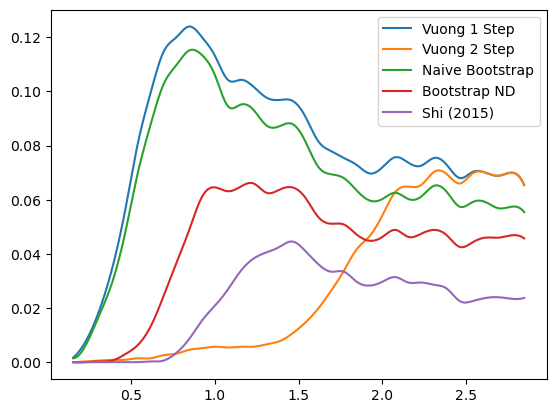

0.01 0.23227910480433808


In [9]:
nobs =100
calc_c =lambda nobs: (nobs**(-1/2)/10, 3*(nobs)**(-5/9))
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2)
print(c1,c2)

Quantiles: 1th: 0.77, 5th: 1.95, 10th: 3.47, 30th: 9.53, 50th: 16.83, 70th: 25.80, 90th: 40.44, 95th: 47.55, 99th: 63.16
bonus term 0.48177888204608116 // variance stats 48.11280331297731 //part1 23.22791048043381 //part2 48.212803312977314 48.11280331297731
-1.5668116521685407 0.7626783839053565 2.374241388395716
-2.530369416260703 0.7626783839053565 1.4106836243035534
---
Quantiles: 1th: 0.81, 5th: 2.18, 10th: 3.89, 30th: 11.50, 50th: 19.65, 70th: 29.85, 90th: 46.54, 95th: 55.46, 99th: 75.24
bonus term 0.6660559996709193 // variance stats 34.773810147960695 //part1 23.22791048043381 //part2 34.8738101479607 34.773810147960695
-1.2349867271328148 0.21574837018018542 2.5949815389579345
-2.5670987264746534 0.21574837018018542 1.262869539616096
---
Quantiles: 1th: 0.70, 5th: 1.73, 10th: 3.05, 30th: 8.63, 50th: 14.73, 70th: 22.66, 90th: 36.30, 95th: 43.18, 99th: 57.70
bonus term 0.9186612951624592 // variance stats 25.184520641882607 //part1 23.22791048043381 //part2 25.284520641882608 25

Quantiles: 1th: 0.76, 5th: 2.08, 10th: 3.65, 30th: 10.04, 50th: 17.57, 70th: 26.92, 90th: 42.82, 95th: 50.96, 99th: 65.17
bonus term 1.6253493470439828 // variance stats 14.19102643236565 //part1 23.22791048043381 //part2 14.29102643236565 14.19102643236565
-0.35657819882984343 -0.695913641152423 3.5692354443899106
-3.607276892917809 -0.695913641152423 0.31853675030194484
---
Quantiles: 1th: 0.82, 5th: 1.88, 10th: 3.09, 30th: 8.85, 50th: 15.14, 70th: 22.92, 90th: 36.74, 95th: 43.93, 99th: 56.19
bonus term 1.8123028369249998 // variance stats 12.716793091735955 //part1 23.22791048043381 //part2 12.816793091735954 12.716793091735955
-0.2986163848855294 -0.526024601711281 3.7373125194450867
-3.923222058735529 -0.526024601711281 0.1127068455950872
---
Quantiles: 1th: 0.69, 5th: 1.88, 10th: 3.17, 30th: 8.95, 50th: 15.82, 70th: 24.42, 90th: 38.71, 95th: 45.72, 99th: 61.09
bonus term 0.4221660150580289 // variance stats 54.92079668170592 //part1 23.22791048043381 //part2 55.02079668170592 54.

Quantiles: 1th: 0.65, 5th: 1.43, 10th: 2.26, 30th: 6.35, 50th: 10.85, 70th: 16.64, 90th: 26.28, 95th: 32.04, 99th: 41.33
bonus term 2.694667122580429 // variance stats 8.519955424472107 //part1 23.22791048043381 //part2 8.619955424472106 8.519955424472107
0.4444534162770973 -1.100158511178752 4.582731285046534
-4.94488082888376 -1.100158511178752 -0.8066029601143244
---
Quantiles: 1th: 0.75, 5th: 2.02, 10th: 3.38, 30th: 9.59, 50th: 16.60, 70th: 25.28, 90th: 40.04, 95th: 47.54, 99th: 62.66
bonus term 1.0530140984090473 // variance stats 21.958499041492267 //part1 23.22791048043381 //part2 22.05849904149226 21.958499041492267
-0.8888478609333004 -0.09966258155430999 3.1518187418035994
-2.994876057751395 -0.09966258155430999 1.0457905449855047
---
Quantiles: 1th: 0.65, 5th: 1.89, 10th: 3.32, 30th: 10.03, 50th: 17.58, 70th: 26.71, 90th: 43.57, 95th: 51.54, 99th: 68.56
bonus term 1.2652611831155058 // variance stats 18.258194173979753 //part1 23.22791048043381 //part2 18.358194173979754 18.

Quantiles: 1th: 0.59, 5th: 1.56, 10th: 3.04, 30th: 8.94, 50th: 15.46, 70th: 23.88, 90th: 37.43, 95th: 45.49, 99th: 59.54
bonus term 4.19618427545458 // variance stats 5.43548389576325 //part1 23.22791048043381 //part2 5.53548389576325 5.43548389576325
2.191124548933313 -1.959060122199153 6.0552497990853285
-6.201244001975847 -1.959060122199153 -2.3371187518238306
---
Quantiles: 1th: 0.87, 5th: 2.12, 10th: 3.59, 30th: 10.47, 50th: 17.92, 70th: 27.69, 90th: 44.68, 95th: 53.93, 99th: 68.69
bonus term 1.5701810717347287 // variance stats 14.693141312531377 //part1 23.22791048043381 //part2 14.793141312531377 14.693141312531377
-0.646621527932115 -0.8140321406211026 3.624855181509326
-3.7869836714015723 -0.8140321406211026 0.4844930380398687
---
Quantiles: 1th: 0.76, 5th: 1.78, 10th: 3.14, 30th: 8.87, 50th: 15.32, 70th: 23.93, 90th: 37.62, 95th: 44.93, 99th: 58.76
bonus term 0.7909258075294503 // variance stats 29.268001725710427 //part1 23.22791048043381 //part2 29.368001725710428 29.26800

Quantiles: 1th: 0.71, 5th: 1.81, 10th: 3.17, 30th: 9.74, 50th: 16.84, 70th: 25.40, 90th: 40.15, 95th: 47.31, 99th: 61.47
bonus term 2.6859333701570782 // variance stats 8.547984621850615 //part1 23.22791048043381 //part2 8.647984621850615 8.547984621850615
0.5882394954719599 -1.5881059361397212 4.557863620110013
-4.783627244842197 -1.5881059361397212 -0.8140031202041431
---
Quantiles: 1th: 0.78, 5th: 1.99, 10th: 3.62, 30th: 10.70, 50th: 18.29, 70th: 27.67, 90th: 44.15, 95th: 52.22, 99th: 68.48
bonus term 2.9291166656438703 // variance stats 7.830005230886874 //part1 23.22791048043381 //part2 7.930005230886874 7.830005230886874
0.9818899261007106 -1.5976962846710974 4.913586727247426
-4.876343405187029 -1.5976962846710974 -0.944646604040315
---
Quantiles: 1th: 0.63, 5th: 1.81, 10th: 3.14, 30th: 8.99, 50th: 15.39, 70th: 23.62, 90th: 37.12, 95th: 44.34, 99th: 58.69
bonus term 0.5094743866695526 // variance stats 45.491910188606866 //part1 23.22791048043381 //part2 45.59191018860687 45.491

Quantiles: 1th: 0.58, 5th: 1.73, 10th: 2.86, 30th: 8.01, 50th: 14.07, 70th: 21.37, 90th: 34.27, 95th: 40.75, 99th: 52.25
bonus term 6.625988210347889 // variance stats 3.4055767899131615 //part1 23.22791048043381 //part2 3.505576789913162 3.4055767899131615
4.678792961472961 -3.4335641570752595 8.408897048524048
-8.573183459222816 -3.4335641570752595 -4.84307937217173
---
Quantiles: 1th: 0.87, 5th: 2.19, 10th: 3.96, 30th: 11.91, 50th: 20.94, 70th: 32.29, 90th: 51.36, 95th: 60.68, 99th: 81.00
bonus term 1.7421425533236468 // variance stats 13.232956270495643 //part1 23.22791048043381 //part2 13.332956270495643 13.232956270495643
-0.2916382204157256 -1.2863047286977818 3.7185941151841426
-3.775923327063019 -1.2863047286977818 0.23430900853684894
---
Quantiles: 1th: 0.71, 5th: 2.01, 10th: 3.40, 30th: 10.01, 50th: 17.05, 70th: 25.84, 90th: 40.41, 95th: 47.52, 99th: 61.26
bonus term 2.504697887701609 // variance stats 9.173737401419093 //part1 23.22791048043381 //part2 9.273737401419092 9.1

Quantiles: 1th: 0.62, 5th: 1.54, 10th: 2.56, 30th: 7.41, 50th: 13.10, 70th: 20.27, 90th: 33.20, 95th: 39.62, 99th: 52.50
bonus term 1.3392178630275144 // variance stats 17.244385198031505 //part1 23.22791048043381 //part2 17.344385198031507 17.244385198031505
-0.6161494281390288 -0.22951296310514804 3.361650618648895
-3.294585154194058 -0.22951296310514804 0.6832148925938659
---
Quantiles: 1th: 0.76, 5th: 1.93, 10th: 3.39, 30th: 10.26, 50th: 17.90, 70th: 27.85, 90th: 44.12, 95th: 53.27, 99th: 70.11
bonus term 1.0414314586620705 // variance stats 22.203830259050136 //part1 23.22791048043381 //part2 22.303830259050134 22.203830259050136
-0.9869217576632787 -0.5434334032044429 2.9620397450527354
-3.0697846749874196 -0.5434334032044429 0.8791768277285944
---
Quantiles: 1th: 0.59, 5th: 1.58, 10th: 2.65, 30th: 7.96, 50th: 13.95, 70th: 21.10, 90th: 33.30, 95th: 39.56, 99th: 51.96
bonus term 11.428327873413085 // variance stats 1.9324854814912449 //part1 23.22791048043381 //part2 2.03248548149

Quantiles: 1th: 0.67, 5th: 1.87, 10th: 3.32, 30th: 9.74, 50th: 16.84, 70th: 25.72, 90th: 40.55, 95th: 49.08, 99th: 65.50
bonus term 2.4848390240976466 // variance stats 9.247853223155523 //part1 23.22791048043381 //part2 9.347853223155523 9.247853223155523
0.6252954954816212 -1.9523847011241247 4.408497201404903
-4.344382552713672 -1.9523847011241247 -0.5611808467903905
---
Quantiles: 1th: 0.73, 5th: 1.67, 10th: 2.80, 30th: 7.72, 50th: 13.25, 70th: 20.46, 90th: 32.19, 95th: 38.24, 99th: 50.51
bonus term 2.2488893456694976 // variance stats 10.228614222465813 //part1 23.22791048043381 //part2 10.328614222465813 10.228614222465813
0.4073179983514361 -1.7832089990110733 4.06294246899921
-4.090460692987559 -1.7832089990110733 -0.4348362223397854
---
Quantiles: 1th: 0.77, 5th: 2.07, 10th: 3.55, 30th: 10.15, 50th: 17.35, 70th: 26.95, 90th: 42.44, 95th: 50.03, 99th: 66.81
bonus term 2.721936864461481 // variance stats 8.433596345934832 //part1 23.22791048043381 //part2 8.533596345934832 8.433

Quantiles: 1th: 0.79, 5th: 1.94, 10th: 3.22, 30th: 9.17, 50th: 15.78, 70th: 24.19, 90th: 38.54, 95th: 45.65, 99th: 58.42
bonus term 1.3803370753872992 // variance stats 16.72770889416011 //part1 23.22791048043381 //part2 16.82770889416011 16.72770889416011
-0.5043408186544293 -0.5301066394097772 3.4995408811568605
-3.2650149694290276 -0.5301066394097772 0.7388667303822621
---
Quantiles: 1th: 0.77, 5th: 1.88, 10th: 3.04, 30th: 9.19, 50th: 16.30, 70th: 24.90, 90th: 40.12, 95th: 48.19, 99th: 63.18
bonus term 1.138397636099127 // variance stats 20.30403962891857 //part1 23.22791048043381 //part2 20.404039628918568 20.30403962891857
-1.0059448658967856 -0.6429868270949793 3.0181231346927797
-3.2827401380950394 -0.6429868270949793 0.7413278624945258
---
Quantiles: 1th: 0.62, 5th: 1.58, 10th: 2.66, 30th: 7.81, 50th: 13.86, 70th: 21.14, 90th: 33.63, 95th: 40.32, 99th: 53.36
bonus term 1.3544491308505346 // variance stats 17.049341345767413 //part1 23.22791048043381 //part2 17.14934134576741 17

Quantiles: 1th: 0.72, 5th: 1.79, 10th: 3.07, 30th: 8.60, 50th: 14.34, 70th: 21.57, 90th: 34.40, 95th: 41.05, 99th: 53.60
bonus term 0.5040844002675515 // variance stats 45.979407472449445 //part1 23.22791048043381 //part2 46.07940747244945 45.979407472449445
-1.401454110209543 0.672053107677973 2.5908316419086104
-2.409622910744646 0.672053107677973 1.5826628413735073
---
Quantiles: 1th: 0.75, 5th: 1.95, 10th: 3.42, 30th: 9.65, 50th: 16.80, 70th: 25.63, 90th: 40.26, 95th: 48.29, 99th: 63.88
bonus term 1.1873654555107251 // variance stats 19.462562118200346 //part1 23.22791048043381 //part2 19.562562118200344 19.462562118200346
-0.9613753279958029 -1.2036023990898808 3.1792178483238516
-3.3361062390172536 -1.2036023990898808 0.8044869373024015
---
Quantiles: 1th: 0.74, 5th: 1.86, 10th: 3.19, 30th: 9.34, 50th: 16.38, 70th: 25.07, 90th: 40.17, 95th: 48.67, 99th: 62.29
bonus term 0.8482392180437216 // variance stats 27.283679021590054 //part1 23.22791048043381 //part2 27.38367902159005 27.

Quantiles: 1th: 0.77, 5th: 2.36, 10th: 4.07, 30th: 12.06, 50th: 21.78, 70th: 33.89, 90th: 54.91, 95th: 65.97, 99th: 86.03
bonus term 3.816586066802254 // variance stats 5.986043933995554 //part1 23.22791048043381 //part2 6.086043933995554 5.986043933995554
1.5650902413861405 -4.573849557564995 5.792611258012225
-6.068081892218368 -4.573849557564995 -1.8405608755922827
---
Quantiles: 1th: 0.81, 5th: 2.19, 10th: 3.88, 30th: 12.26, 50th: 20.82, 70th: 32.55, 90th: 50.57, 95th: 60.77, 99th: 79.60
bonus term 1.24836257895866 // variance stats 18.506701988623938 //part1 23.22791048043381 //part2 18.60670198862394 18.506701988623938
-0.7826103122336938 -1.225931864543906 3.1209890665017
-3.2793354701510142 -1.225931864543906 0.6242639085843797
---
Quantiles: 1th: 0.69, 5th: 1.80, 10th: 2.96, 30th: 8.34, 50th: 14.27, 70th: 21.86, 90th: 35.36, 95th: 42.20, 99th: 54.40
bonus term 0.3146156297610212 // variance stats 73.72948678702801 //part1 23.22791048043381 //part2 73.829486787028 73.7294867870

Quantiles: 1th: 0.84, 5th: 2.27, 10th: 3.89, 30th: 11.12, 50th: 19.76, 70th: 30.14, 90th: 47.99, 95th: 57.51, 99th: 75.64
bonus term 0.9534502412675642 // variance stats 24.261953539970236 //part1 23.22791048043381 //part2 24.361953539970234 24.261953539970236
-1.1452052281118175 -1.0685440083021525 2.875966626025057
-3.0521057106469462 -1.0685440083021525 0.9690661434899287
---
Quantiles: 1th: 0.69, 5th: 1.83, 10th: 3.16, 30th: 9.15, 50th: 16.48, 70th: 25.05, 90th: 40.19, 95th: 47.12, 99th: 61.51
bonus term 3.7731312945182145 // variance stats 6.056136287698344 //part1 23.22791048043381 //part2 6.156136287698343 6.056136287698344
1.6340802430477135 -4.4432551458847875 5.707086907177852
-5.9121823459887155 -4.4432551458847875 -1.839175681858576
---
Quantiles: 1th: 0.71, 5th: 1.89, 10th: 3.30, 30th: 9.27, 50th: 16.16, 70th: 24.65, 90th: 39.50, 95th: 47.59, 99th: 61.75
bonus term 1.489257969701776 // variance stats 15.49696906311349 //part1 23.22791048043381 //part2 15.596969063113491 15

Quantiles: 1th: 0.66, 5th: 1.74, 10th: 2.99, 30th: 9.33, 50th: 16.27, 70th: 24.90, 90th: 39.34, 95th: 47.16, 99th: 60.86
bonus term 0.9734727488444712 // variance stats 23.76087387449288 //part1 23.22791048043381 //part2 23.860873874492874 23.76087387449288
-1.0968583305732895 -1.1449720351528365 2.946207001707173
-3.0438038282622317 -1.1449720351528365 0.9992615040182307
---
Quantiles: 1th: 0.66, 5th: 1.80, 10th: 3.12, 30th: 9.80, 50th: 17.05, 70th: 26.38, 90th: 42.02, 95th: 49.87, 99th: 64.49
bonus term 0.633760572298514 // variance stats 36.55092385944924 //part1 23.22791048043381 //part2 36.650923859449236 36.55092385944924
-1.3560825149718383 -0.15780015741640768 2.5953037084638475
-2.6236036595688668 -0.15780015741640768 1.3277825638668193
---
Quantiles: 1th: 0.87, 5th: 2.61, 10th: 4.78, 30th: 13.80, 50th: 23.89, 70th: 35.78, 90th: 56.61, 95th: 67.14, 99th: 87.71
bonus term 0.5272788324016796 // variance stats 43.9524236003065 //part1 23.22791048043381 //part2 44.0524236003065 43

Quantiles: 1th: 0.76, 5th: 1.82, 10th: 3.22, 30th: 8.63, 50th: 15.14, 70th: 23.36, 90th: 37.44, 95th: 45.55, 99th: 59.02
bonus term 0.9553698937048841 // variance stats 24.21300236011934 //part1 23.22791048043381 //part2 24.313002360119338 24.21300236011934
-1.118461291248728 -1.0412975747577873 2.7969691207633334
-3.029201078658496 -1.0412975747577873 0.886229333353565
---
Quantiles: 1th: 0.68, 5th: 1.67, 10th: 2.62, 30th: 7.20, 50th: 12.21, 70th: 18.66, 90th: 29.60, 95th: 35.54, 99th: 44.20
bonus term 3.1802316602590124 // variance stats 7.203842286301251 //part1 23.22791048043381 //part2 7.303842286301251 7.203842286301251
1.1338074877798572 -4.016225354396939 5.174765585773264
-5.226655832738167 -4.016225354396939 -1.1856977347447606
---
Quantiles: 1th: 0.78, 5th: 1.96, 10th: 3.29, 30th: 9.51, 50th: 16.57, 70th: 25.61, 90th: 40.09, 95th: 47.63, 99th: 60.98
bonus term 2.011889396119916 // variance stats 11.445321788181113 //part1 23.22791048043381 //part2 11.545321788181113 11.44532

Quantiles: 1th: 0.77, 5th: 2.11, 10th: 3.49, 30th: 10.35, 50th: 17.91, 70th: 27.57, 90th: 43.79, 95th: 51.18, 99th: 67.48
bonus term 1.5003124400253705 // variance stats 15.38204884579976 //part1 23.22791048043381 //part2 15.48204884579976 15.38204884579976
-0.638484060967774 -2.440449911518005 3.484586605762442
-3.639108941018515 -2.440449911518005 0.48396172571170165
---
Quantiles: 1th: 0.75, 5th: 2.16, 10th: 3.78, 30th: 11.42, 50th: 20.00, 70th: 31.00, 90th: 49.79, 95th: 60.57, 99th: 79.61
bonus term 0.7691852769865059 // variance stats 30.098069535906244 //part1 23.22791048043381 //part2 30.198069535906242 30.098069535906244
-1.2387772159109296 -1.253795423415652 2.816347019725537
-2.7771477698839417 -1.253795423415652 1.2779764657525254
---
Quantiles: 1th: 0.82, 5th: 2.14, 10th: 3.82, 30th: 10.12, 50th: 17.79, 70th: 27.44, 90th: 43.81, 95th: 52.47, 99th: 66.56
bonus term 2.6198202213198294 // variance stats 8.76622306805919 //part1 23.22791048043381 //part2 8.866223068059192 8.766

Quantiles: 1th: 0.86, 5th: 2.27, 10th: 4.05, 30th: 12.41, 50th: 21.58, 70th: 33.70, 90th: 53.39, 95th: 61.91, 99th: 80.31
bonus term 1.803438560865892 // variance stats 12.779790298640005 //part1 23.22791048043381 //part2 12.879790298640007 12.779790298640005
-0.2462170332766805 -3.7081998439072246 3.810586480262954
-3.8530941550084647 -3.7081998439072246 0.20370935853116964
---
Quantiles: 1th: 0.67, 5th: 2.06, 10th: 3.79, 30th: 10.94, 50th: 19.32, 70th: 29.35, 90th: 45.88, 95th: 55.27, 99th: 71.94
bonus term 0.9883816155584206 // variance stats 23.400953594033002 //part1 23.22791048043381 //part2 23.500953594033 23.400953594033002
-0.8366300028947282 -2.2269512135918204 2.9656497198144853
-2.8133932340115693 -2.2269512135918204 0.988886488697644
---
Quantiles: 1th: 0.75, 5th: 1.96, 10th: 3.17, 30th: 8.50, 50th: 14.67, 70th: 21.95, 90th: 35.68, 95th: 42.77, 99th: 56.81
bonus term 2.8272420457949696 // variance stats 8.115748812515463 //part1 23.22791048043381 //part2 8.215748812515463 

Quantiles: 1th: 0.63, 5th: 1.99, 10th: 3.78, 30th: 11.09, 50th: 19.69, 70th: 30.08, 90th: 48.08, 95th: 56.85, 99th: 76.42
bonus term 0.8051317846323013 // variance stats 28.74982424466307 //part1 23.22791048043381 //part2 28.84982424466307 28.74982424466307
-1.0697725460971268 -1.3219728746789383 2.816446406065458
-2.680036115361729 -1.3219728746789383 1.2061828368008556
---
Quantiles: 1th: 0.63, 5th: 1.65, 10th: 2.79, 30th: 8.33, 50th: 15.14, 70th: 23.53, 90th: 36.48, 95th: 43.61, 99th: 56.64
bonus term 1.1954042659315591 // variance stats 19.331008523574805 //part1 23.22791048043381 //part2 19.431008523574803 19.331008523574805
-0.7985655627100844 -2.591780166659829 3.037896989319953
-3.189374094573203 -2.591780166659829 0.6470884574568345
---
Quantiles: 1th: 0.77, 5th: 2.00, 10th: 3.56, 30th: 10.66, 50th: 18.52, 70th: 29.00, 90th: 46.60, 95th: 54.88, 99th: 70.91
bonus term 0.6586164083526718 // variance stats 35.167737313941736 //part1 23.22791048043381 //part2 35.26773731394174 35.

Quantiles: 1th: 0.80, 5th: 1.97, 10th: 3.46, 30th: 9.57, 50th: 16.79, 70th: 26.01, 90th: 41.68, 95th: 50.02, 99th: 66.20
bonus term 2.0589010491157977 // variance stats 11.181703164126862 //part1 23.22791048043381 //part2 11.281703164126862 11.181703164126862
-0.4778700411905785 -5.193261988623002 4.244158334833873
-4.595672139422175 -5.193261988623002 0.12635623660227802
---
Quantiles: 1th: 0.77, 5th: 2.02, 10th: 3.57, 30th: 10.66, 50th: 19.14, 70th: 29.60, 90th: 47.94, 95th: 56.62, 99th: 74.37
bonus term 1.00021972301086 // variance stats 23.12280789516246 //part1 23.22791048043381 //part2 23.222807895162457 23.12280789516246
-1.2597666649964272 -2.379150911648277 2.855203812005969
-3.2602061110181473 -2.379150911648277 0.854764365984249
---
Quantiles: 1th: 0.68, 5th: 1.71, 10th: 2.82, 30th: 8.09, 50th: 14.15, 70th: 21.34, 90th: 33.14, 95th: 39.53, 99th: 52.65
bonus term 0.7579026688700253 // variance stats 30.54761668548396 //part1 23.22791048043381 //part2 30.647616685483957 30.547

Quantiles: 1th: 0.66, 5th: 1.81, 10th: 3.12, 30th: 8.73, 50th: 15.20, 70th: 23.37, 90th: 36.28, 95th: 43.49, 99th: 57.74
bonus term 1.3964444427232308 // variance stats 16.533608735007498 //part1 23.22791048043381 //part2 16.633608735007495 16.533608735007498
-0.7495982673351125 -4.5753340549832835 3.2268519183064868
-3.542487152781574 -4.5753340549832835 0.43396303286002524
---
Quantiles: 1th: 0.70, 5th: 1.72, 10th: 3.05, 30th: 8.64, 50th: 14.84, 70th: 23.01, 90th: 36.16, 95th: 42.67, 99th: 57.53
bonus term 0.5407656062125088 // variance stats 42.85374967191564 //part1 23.22791048043381 //part2 42.95374967191563 42.85374967191564
-1.3723145042362686 -0.7367119715533864 2.584230625462227
-2.453845716661286 -0.7367119715533864 1.5026994130372093
---
Quantiles: 1th: 0.71, 5th: 1.89, 10th: 3.49, 30th: 10.45, 50th: 18.33, 70th: 28.26, 90th: 44.95, 95th: 53.17, 99th: 68.96
bonus term 0.4741669966586364 // variance stats 48.8867718422337 //part1 23.22791048043381 //part2 48.9867718422337 48.

Quantiles: 1th: 0.89, 5th: 2.17, 10th: 3.63, 30th: 11.17, 50th: 19.26, 70th: 29.64, 90th: 47.13, 95th: 57.01, 99th: 74.65
bonus term 1.3144420203301088 // variance stats 17.571308525727403 //part1 23.22791048043381 //part2 17.671308525727405 17.571308525727403
-0.710920858066698 -3.603977831291064 3.2708749899722585
-3.3398048987269155 -3.603977831291064 0.6419909493120408
---
Quantiles: 1th: 0.77, 5th: 1.88, 10th: 3.65, 30th: 11.17, 50th: 19.51, 70th: 30.56, 90th: 47.81, 95th: 57.65, 99th: 78.12
bonus term 1.1771586229316688 // variance stats 19.63218394525759 //part1 23.22791048043381 //part2 19.732183945257592 19.63218394525759
-1.1104188006716946 -3.7915795197026183 3.213400759218838
-3.4647360465350325 -3.7915795197026183 0.8590835133555003
---
Quantiles: 1th: 0.58, 5th: 1.32, 10th: 2.09, 30th: 5.85, 50th: 10.17, 70th: 15.77, 90th: 25.38, 95th: 30.45, 99th: 40.01
bonus term 1.7653179721330263 // variance stats 13.057918769935606 //part1 23.22791048043381 //part2 13.157918769935605

Quantiles: 1th: 0.66, 5th: 1.82, 10th: 2.97, 30th: 8.84, 50th: 16.15, 70th: 25.06, 90th: 40.12, 95th: 48.07, 99th: 63.67
bonus term 0.6348957036354306 // variance stats 36.48539559715107 //part1 23.22791048043381 //part2 36.58539559715106 36.48539559715107
-1.448378226269698 -1.5835193807929926 2.6705851579345445
-2.718169633540559 -1.5835193807929926 1.4007937506636834
---
Quantiles: 1th: 0.61, 5th: 1.51, 10th: 2.67, 30th: 7.98, 50th: 13.68, 70th: 21.03, 90th: 33.60, 95th: 40.51, 99th: 51.96
bonus term 1.3662150857898543 // variance stats 16.90164982953982 //part1 23.22791048043381 //part2 17.001649829539822 16.90164982953982
-0.8759872397690633 -4.025385175510259 3.2622383126561667
-3.608417411348772 -4.025385175510259 0.5298081410764581
---
Quantiles: 1th: 0.67, 5th: 1.62, 10th: 2.64, 30th: 7.44, 50th: 13.21, 70th: 20.42, 90th: 32.63, 95th: 38.12, 99th: 47.79
bonus term 2.0409021428545495 // variance stats 11.281197556069795 //part1 23.22791048043381 //part2 11.381197556069795 11.28

Quantiles: 1th: 0.78, 5th: 1.92, 10th: 3.30, 30th: 9.53, 50th: 16.45, 70th: 25.23, 90th: 40.24, 95th: 47.87, 99th: 63.08
bonus term 0.8366898510253251 // variance stats 27.661673518531472 //part1 23.22791048043381 //part2 27.76167351853147 27.661673518531472
-1.3365623027694324 -2.981019660213212 2.625727021268329
-3.0099420048200827 -2.981019660213212 0.9523473192176782
---
Quantiles: 1th: 0.69, 5th: 1.86, 10th: 3.19, 30th: 9.22, 50th: 16.17, 70th: 25.02, 90th: 39.73, 95th: 47.60, 99th: 61.68
bonus term 1.6343816405870606 // variance stats 14.11204809428138 //part1 23.22791048043381 //part2 14.21204809428138 14.11204809428138
-0.9245987329789781 -7.2642194926683 3.678385853346507
-4.193362014153099 -7.2642194926683 0.40962257217238546
---
Quantiles: 1th: 0.64, 5th: 1.55, 10th: 2.86, 30th: 8.56, 50th: 15.00, 70th: 22.94, 90th: 36.45, 95th: 43.42, 99th: 57.12
bonus term 0.6911695044350018 // variance stats 33.50667727871114 //part1 23.22791048043381 //part2 33.60667727871113 33.50667727

Quantiles: 1th: 0.60, 5th: 1.71, 10th: 3.02, 30th: 8.41, 50th: 14.58, 70th: 22.70, 90th: 35.48, 95th: 42.31, 99th: 55.35
bonus term 1.591726938253018 // variance stats 14.49289902194364 //part1 23.22791048043381 //part2 14.592899021943639 14.49289902194364
-0.8225551823419437 -5.512769821468001 3.554477866529226
-4.0060090588479795 -5.512769821468001 0.3710239900231901
---
Quantiles: 1th: 0.83, 5th: 2.00, 10th: 3.59, 30th: 10.18, 50th: 18.14, 70th: 27.71, 90th: 44.59, 95th: 53.01, 99th: 68.98
bonus term 1.1510175644820728 // variance stats 20.080326692830056 //part1 23.22791048043381 //part2 20.180326692830054 20.080326692830056
-1.278414517507793 -4.3100108330183895 3.2559937851329828
-3.580449646471939 -4.3100108330183895 0.9539586561688368
---
Quantiles: 1th: 0.70, 5th: 1.84, 10th: 3.41, 30th: 10.51, 50th: 18.52, 70th: 28.34, 90th: 45.02, 95th: 54.03, 99th: 70.96
bonus term 0.43755677478406174 // variance stats 52.98547786032337 //part1 23.22791048043381 //part2 53.085477860323365 5

Quantiles: 1th: 0.57, 5th: 1.69, 10th: 3.00, 30th: 9.27, 50th: 15.86, 70th: 24.04, 90th: 39.09, 95th: 46.89, 99th: 61.93
bonus term 0.34613380782036357 // variance stats 67.00673720865956 //part1 23.22791048043381 //part2 67.10673720865957 67.00673720865956
-1.5130687306058543 -0.3271608699810319 2.5100069476395444
-2.2053363462465816 -0.3271608699810319 1.8177393319988175
---
Quantiles: 1th: 0.74, 5th: 1.88, 10th: 3.47, 30th: 9.86, 50th: 17.21, 70th: 27.11, 90th: 43.55, 95th: 51.51, 99th: 67.34
bonus term 0.39607096973265105 // variance stats 58.54582929698864 //part1 23.22791048043381 //part2 58.64582929698864 58.54582929698864
-1.5442014887131752 -0.6993602060517675 2.498833965962209
-2.336343428178477 -0.6993602060517675 1.706692026496907
---
Quantiles: 1th: 0.70, 5th: 1.80, 10th: 3.19, 30th: 9.61, 50th: 16.59, 70th: 25.57, 90th: 40.15, 95th: 47.61, 99th: 62.56
bonus term 1.1217036842546955 // variance stats 20.607706327868005 //part1 23.22791048043381 //part2 20.707706327868003 20

Quantiles: 1th: 0.77, 5th: 1.92, 10th: 3.18, 30th: 9.17, 50th: 15.81, 70th: 24.38, 90th: 39.05, 95th: 47.10, 99th: 61.99
bonus term 1.6281219472867898 // variance stats 14.166689616918644 //part1 23.22791048043381 //part2 14.266689616918644 14.166689616918644
-1.3872994176967515 -7.271538093368703 3.9041672394283315
-4.643543312270331 -7.271538093368703 0.6479233448547522
---
Quantiles: 1th: 0.92, 5th: 2.78, 10th: 4.89, 30th: 14.53, 50th: 25.27, 70th: 39.21, 90th: 61.32, 95th: 72.65, 99th: 95.73
bonus term 0.7625007771855119 // variance stats 30.36280236745595 //part1 23.22791048043381 //part2 30.462802367455946 30.36280236745595
-1.3331080637974078 -3.8000510629268622 2.709263642238503
-2.858109618168432 -3.8000510629268622 1.184262087867479
---
Quantiles: 1th: 0.64, 5th: 1.76, 10th: 3.63, 30th: 10.06, 50th: 17.34, 70th: 26.65, 90th: 41.99, 95th: 49.75, 99th: 65.26
bonus term 1.6951555511087961 // variance stats 13.602524505931331 //part1 23.22791048043381 //part2 13.702524505931331 1

Quantiles: 1th: 0.71, 5th: 1.66, 10th: 2.85, 30th: 8.18, 50th: 14.57, 70th: 22.34, 90th: 35.43, 95th: 43.13, 99th: 56.40
bonus term 0.7572752986576783 // variance stats 30.573006925759827 //part1 23.22791048043381 //part2 30.67300692575983 30.573006925759827
-1.4178251256941046 -3.432291891052407 2.7906141281956653
-2.9323757230094607 -3.432291891052407 1.2760635308803092
---
Quantiles: 1th: 0.64, 5th: 1.95, 10th: 3.83, 30th: 11.84, 50th: 20.42, 70th: 31.65, 90th: 49.71, 95th: 58.80, 99th: 77.88
bonus term 1.5746474484456425 // variance stats 14.651181607897321 //part1 23.22791048043381 //part2 14.75118160789732 14.651181607897321
-0.884045852608058 -10.18726585410554 3.4267392359843756
-4.0333407494993425 -10.18726585410554 0.27744433909309063
---
Quantiles: 1th: 0.72, 5th: 2.05, 10th: 3.63, 30th: 10.98, 50th: 18.93, 70th: 28.61, 90th: 44.98, 95th: 52.47, 99th: 68.04
bonus term 0.5322576407203872 // variance stats 43.54035140763007 //part1 23.22791048043381 //part2 43.64035140763007 4

Quantiles: 1th: 0.83, 5th: 2.26, 10th: 3.97, 30th: 11.40, 50th: 20.04, 70th: 30.80, 90th: 48.60, 95th: 58.20, 99th: 75.96
bonus term 0.7233039816241089 // variance stats 32.01362175592867 //part1 23.22791048043381 //part2 32.11362175592866 32.01362175592867
-1.607953660211113 -2.9067765589823646 2.6713530840540614
-3.054561623459331 -2.9067765589823646 1.2247451208058435
---
Quantiles: 1th: 0.77, 5th: 2.17, 10th: 4.15, 30th: 12.40, 50th: 21.27, 70th: 32.53, 90th: 51.97, 95th: 62.36, 99th: 80.69
bonus term 1.496265025883306 // variance stats 15.42392796638512 //part1 23.22791048043381 //part2 15.52392796638512 15.42392796638512
-1.1861299542171038 -8.68331071333605 3.635387800425293
-4.178660005983715 -8.68331071333605 0.6428577486586812
---
Quantiles: 1th: 0.64, 5th: 1.63, 10th: 3.03, 30th: 9.11, 50th: 15.65, 70th: 23.85, 90th: 38.76, 95th: 46.16, 99th: 62.29
bonus term 0.9422946814474958 // variance stats 24.55036780718374 //part1 23.22791048043381 //part2 24.65036780718374 24.5503678

Quantiles: 1th: 0.80, 5th: 2.22, 10th: 4.07, 30th: 11.75, 50th: 20.36, 70th: 31.56, 90th: 48.73, 95th: 57.86, 99th: 75.86
bonus term 1.1193790923280138 // variance stats 20.65070960287982 //part1 23.22791048043381 //part2 20.750709602879816 20.65070960287982
-1.2430841919229754 -5.870300727603708 2.986098142651324
-3.481842376579003 -5.870300727603708 0.747339957995296
---
Quantiles: 1th: 0.81, 5th: 1.91, 10th: 3.34, 30th: 9.81, 50th: 17.10, 70th: 25.98, 90th: 40.66, 95th: 48.53, 99th: 62.56
bonus term 1.0810096042268673 // variance stats 21.387237846555763 //part1 23.22791048043381 //part2 21.48723784655576 21.387237846555763
-0.9918607948148807 -6.416417610636077 2.9588289785063404
-3.1538800032686156 -6.416417610636077 0.7968097700526057
---
Quantiles: 1th: 0.65, 5th: 1.72, 10th: 3.01, 30th: 8.76, 50th: 15.25, 70th: 24.21, 90th: 38.60, 95th: 45.79, 99th: 60.96
bonus term 1.3063432239421795 // variance stats 17.680863447462492 //part1 23.22791048043381 //part2 17.78086344746249 17.68

Quantiles: 1th: 0.72, 5th: 1.58, 10th: 2.71, 30th: 7.92, 50th: 13.79, 70th: 21.03, 90th: 33.14, 95th: 39.26, 99th: 51.68
bonus term 0.8052560343270396 // variance stats 28.745372763764014 //part1 23.22791048043381 //part2 28.84537276376401 28.745372763764014
-1.3298455176696111 -5.114334286633174 2.7678855601667385
-2.9403575863236906 -5.114334286633174 1.1573734915126588
---
Quantiles: 1th: 0.73, 5th: 1.73, 10th: 2.97, 30th: 8.69, 50th: 14.97, 70th: 22.90, 90th: 36.25, 95th: 43.18, 99th: 57.42
bonus term 1.1803027917537297 // variance stats 19.57962004556566 //part1 23.22791048043381 //part2 19.67962004556566 19.57962004556566
-1.0368913270546936 -7.28111651173868 3.046670606510865
-3.3974969105621526 -7.28111651173868 0.6860650230034058
---
Quantiles: 1th: 0.70, 5th: 1.74, 10th: 2.83, 30th: 8.56, 50th: 14.33, 70th: 21.91, 90th: 35.60, 95th: 42.49, 99th: 55.37
bonus term 1.1740231633965243 // variance stats 19.684882619550685 //part1 23.22791048043381 //part2 19.784882619550686 19.684

Quantiles: 1th: 0.75, 5th: 1.94, 10th: 3.25, 30th: 9.71, 50th: 17.21, 70th: 26.13, 90th: 41.47, 95th: 48.66, 99th: 64.65
bonus term 0.35574779172316634 // variance stats 65.19319653095462 //part1 23.22791048043381 //part2 65.29319653095462 65.19319653095462
-1.7767023627802523 -1.047314267386897 2.372336404358784
-2.488197946226585 -1.047314267386897 1.6608408209124517
---
Quantiles: 1th: 0.65, 5th: 1.68, 10th: 2.90, 30th: 8.26, 50th: 14.04, 70th: 21.58, 90th: 34.11, 95th: 39.77, 99th: 51.88
bonus term 1.2825968638779583 // variance stats 18.01006336800461 //part1 23.22791048043381 //part2 18.11006336800461 18.01006336800461
-0.8146376225585129 -8.430171810979616 2.922607226836249
-3.3798313503144297 -8.430171810979616 0.3574134990803324
---
Quantiles: 1th: 0.59, 5th: 1.50, 10th: 2.62, 30th: 7.63, 50th: 13.45, 70th: 20.85, 90th: 32.94, 95th: 38.94, 99th: 50.77
bonus term 0.8727633582420515 // variance stats 26.514213648038833 //part1 23.22791048043381 //part2 26.614213648038827 26.5142

Quantiles: 1th: 0.69, 5th: 1.98, 10th: 3.42, 30th: 10.06, 50th: 18.56, 70th: 28.30, 90th: 43.57, 95th: 52.34, 99th: 68.87
bonus term 0.455770074798206 // variance stats 50.86409739212926 //part1 23.22791048043381 //part2 50.96409739212926 50.86409739212926
-1.5103309666563811 -2.328777531391978 2.437630061436247
-2.4218711162527935 -2.328777531391978 1.526089911839835
---
Quantiles: 1th: 0.71, 5th: 1.81, 10th: 3.01, 30th: 8.89, 50th: 15.35, 70th: 23.60, 90th: 37.32, 95th: 45.06, 99th: 59.62
bonus term 1.1410529709642996 // variance stats 20.2565575582385 //part1 23.22791048043381 //part2 20.3565575582385 20.2565575582385
-1.5757840016178084 -7.670917086808587 3.4488957446215425
-3.8578899435464074 -7.670917086808587 1.1667898026929435
---
Quantiles: 1th: 0.83, 5th: 2.47, 10th: 4.60, 30th: 12.85, 50th: 21.87, 70th: 34.19, 90th: 54.71, 95th: 65.34, 99th: 83.44
bonus term 0.5996271317388931 // variance stats 38.63725729033285 //part1 23.22791048043381 //part2 38.73725729033284 38.63725729

Quantiles: 1th: 0.78, 5th: 1.79, 10th: 3.03, 30th: 9.31, 50th: 16.29, 70th: 25.20, 90th: 39.90, 95th: 47.78, 99th: 63.41
bonus term 0.9234824041413985 // variance stats 25.05252091027095 //part1 23.22791048043381 //part2 25.152520910270944 25.05252091027095
-1.0382691628798777 -6.641777101593715 2.6988432954531665
-2.8852339711626747 -6.641777101593715 0.8518784871703696
---
Quantiles: 1th: 0.64, 5th: 1.74, 10th: 3.16, 30th: 9.33, 50th: 16.19, 70th: 25.06, 90th: 39.96, 95th: 47.61, 99th: 61.92
bonus term 0.8614158107080199 // variance stats 26.864806301084947 //part1 23.22791048043381 //part2 26.964806301084945 26.864806301084947
-1.3021484546487994 -6.299942101159903 2.826533465468913
-3.024980076064839 -6.299942101159903 1.1037018440528732
---
Quantiles: 1th: 0.79, 5th: 2.10, 10th: 3.92, 30th: 11.90, 50th: 19.92, 70th: 29.86, 90th: 47.65, 95th: 57.06, 99th: 75.77
bonus term 1.3003744887439337 // variance stats 17.76247783349723 //part1 23.22791048043381 //part2 17.86247783349723 17.7

Quantiles: 1th: 0.75, 5th: 2.03, 10th: 3.40, 30th: 9.96, 50th: 17.02, 70th: 26.34, 90th: 41.06, 95th: 49.16, 99th: 65.31
bonus term 0.9138270949692068 // variance stats 25.318277274013766 //part1 23.22791048043381 //part2 25.418277274013764 25.318277274013766
-1.3614294065018129 -6.308801956985927 2.996277010020806
-3.189083596440226 -6.308801956985927 1.1686228200823927
---
Quantiles: 1th: 0.76, 5th: 1.96, 10th: 3.36, 30th: 10.18, 50th: 17.72, 70th: 27.13, 90th: 43.33, 95th: 51.54, 99th: 69.55
bonus term 1.0826081579468516 // variance stats 21.355510296989777 //part1 23.22791048043381 //part2 21.45551029698978 21.355510296989777
-1.7894204775133473 -8.089294675366926 3.2608996866666744
-3.9546367934070505 -8.089294675366926 1.0956833707729714
---
Quantiles: 1th: 0.92, 5th: 2.18, 10th: 3.70, 30th: 10.63, 50th: 19.21, 70th: 28.98, 90th: 46.45, 95th: 54.81, 99th: 69.81
bonus term 0.5895581860256632 // variance stats 39.29884311846822 //part1 23.22791048043381 //part2 39.39884311846822 39

Quantiles: 1th: 0.84, 5th: 2.15, 10th: 4.25, 30th: 12.14, 50th: 20.86, 70th: 32.27, 90th: 51.26, 95th: 60.42, 99th: 80.23
bonus term 1.0197131859624824 // variance stats 22.678866450088663 //part1 23.22791048043381 //part2 22.77886645008866 22.678866450088663
-1.530512149847331 -8.118594785378626 3.1716423070748707
-3.5699385217722956 -8.118594785378626 1.1322159351499061
---
Quantiles: 1th: 0.88, 5th: 2.39, 10th: 4.20, 30th: 12.33, 50th: 21.87, 70th: 33.39, 90th: 53.74, 95th: 64.05, 99th: 86.12
bonus term 1.123944384150908 // variance stats 20.566423363983 //part1 23.22791048043381 //part2 20.666423363982997 20.566423363983
-1.666677701879134 -10.234295951116936 3.331183149430329
-3.9145664701809504 -10.234295951116936 1.0832943811285125
---
Quantiles: 1th: 0.66, 5th: 1.71, 10th: 2.84, 30th: 8.28, 50th: 14.55, 70th: 22.83, 90th: 35.59, 95th: 42.60, 99th: 54.97
bonus term 0.5752411161676808 // variance stats 40.27943364546103 //part1 23.22791048043381 //part2 40.37943364546103 40.27943

Quantiles: 1th: 0.85, 5th: 2.39, 10th: 4.21, 30th: 11.91, 50th: 20.77, 70th: 32.18, 90th: 50.21, 95th: 60.11, 99th: 79.85
bonus term 0.4902141750730636 // variance stats 47.2831881278664 //part1 23.22791048043381 //part2 47.383188127866404 47.2831881278664
-1.609261137354191 -3.972610904618167 2.4537521156344306
-2.589689487500318 -3.972610904618167 1.4733237654883038
---
Quantiles: 1th: 0.76, 5th: 1.86, 10th: 3.11, 30th: 8.85, 50th: 15.68, 70th: 23.81, 90th: 37.78, 95th: 44.72, 99th: 59.05
bonus term 1.0789193273737094 // variance stats 21.428866793938035 //part1 23.22791048043381 //part2 21.52886679393803 21.428866793938035
-1.4642029597535304 -8.692443841823396 3.3477346267573127
-3.622041614500949 -8.692443841823396 1.1898959720098938
---
Quantiles: 1th: 0.73, 5th: 1.71, 10th: 2.74, 30th: 8.29, 50th: 14.20, 70th: 22.64, 90th: 35.91, 95th: 42.51, 99th: 54.41
bonus term 1.2104749856374146 // variance stats 19.08908755326522 //part1 23.22791048043381 //part2 19.18908755326522 19.08908

Quantiles: 1th: 0.73, 5th: 1.74, 10th: 3.06, 30th: 8.97, 50th: 15.61, 70th: 23.89, 90th: 37.61, 95th: 44.83, 99th: 57.45
bonus term 0.6264679660561585 // variance stats 36.97757098365599 //part1 23.22791048043381 //part2 37.07757098365599 36.97757098365599
-1.5308686043011688 -5.087842033879123 2.4021614751630014
-2.7838045364134856 -5.087842033879123 1.1492255430506846
---
Quantiles: 1th: 0.72, 5th: 1.88, 10th: 3.20, 30th: 9.18, 50th: 15.48, 70th: 23.66, 90th: 38.27, 95th: 45.19, 99th: 59.18
bonus term 1.2378674943434462 // variance stats 18.664456281933216 //part1 23.22791048043381 //part2 18.764456281933214 18.664456281933216
-1.4314783078076283 -9.932123724482366 3.3083440968741584
-3.9072132964945205 -9.932123724482366 0.832609108187266
---
Quantiles: 1th: 0.80, 5th: 1.96, 10th: 3.54, 30th: 9.74, 50th: 17.20, 70th: 26.09, 90th: 42.29, 95th: 50.32, 99th: 65.38
bonus term 0.4985275894285978 // variance stats 46.49302909806289 //part1 23.22791048043381 //part2 46.59302909806289 46.49

Quantiles: 1th: 0.68, 5th: 1.99, 10th: 3.64, 30th: 10.84, 50th: 18.97, 70th: 29.83, 90th: 47.92, 95th: 56.76, 99th: 71.39
bonus term 0.7813016783529428 // variance stats 29.629758842193226 //part1 23.22791048043381 //part2 29.729758842193228 29.629758842193226
-1.9569522032952684 -10.486994323675829 3.170419856070104
-3.519555560001154 -10.486994323675829 1.6078164993642186
---
Quantiles: 1th: 0.64, 5th: 1.68, 10th: 2.93, 30th: 8.66, 50th: 15.30, 70th: 23.85, 90th: 37.28, 95th: 44.31, 99th: 58.77
bonus term 0.7136024901160075 // variance stats 32.450209398313255 //part1 23.22791048043381 //part2 32.55020939831325 32.450209398313255
-1.6746057457935015 -7.258872964181795 2.7933809057232835
-3.1018107260255166 -7.258872964181795 1.3661759254912684
---
Quantiles: 1th: 0.77, 5th: 2.00, 10th: 3.52, 30th: 11.17, 50th: 19.12, 70th: 29.60, 90th: 46.83, 95th: 55.56, 99th: 73.98
bonus term 0.47066674598156655 // variance stats 49.251076273707085 //part1 23.22791048043381 //part2 49.3510762737070

Quantiles: 1th: 0.66, 5th: 1.72, 10th: 3.22, 30th: 9.67, 50th: 16.80, 70th: 25.41, 90th: 40.05, 95th: 47.96, 99th: 63.51
bonus term 0.5361846112460144 // variance stats 43.2207331826543 //part1 23.22791048043381 //part2 43.320733182654294 43.2207331826543
-1.7141490981830714 -5.896425141652206 2.481926611370414
-2.7865183206751 -5.896425141652206 1.4095573888783852
---
Quantiles: 1th: 0.58, 5th: 1.48, 10th: 2.56, 30th: 7.69, 50th: 13.46, 70th: 20.71, 90th: 32.92, 95th: 39.37, 99th: 53.24
bonus term 0.9618551110384386 // variance stats 24.049074235678262 //part1 23.22791048043381 //part2 24.14907423567826 24.049074235678262
-1.8438195476229282 -11.762607482312506 3.0916800326836396
-3.7675297696998054 -11.762607482312506 1.1679698106067622
---
Quantiles: 1th: 0.62, 5th: 1.75, 10th: 3.05, 30th: 8.96, 50th: 15.31, 70th: 23.38, 90th: 38.41, 95th: 45.84, 99th: 60.29
bonus term 0.48974283301039895 // variance stats 47.32879102008339 //part1 23.22791048043381 //part2 47.42879102008339 47.3287

Quantiles: 1th: 0.72, 5th: 1.93, 10th: 3.43, 30th: 10.56, 50th: 18.83, 70th: 28.98, 90th: 46.44, 95th: 54.70, 99th: 68.67
bonus term 0.9459583822804186 // variance stats 24.454896827953853 //part1 23.22791048043381 //part2 24.55489682795385 24.454896827953853
-1.8650070190640688 -10.090987865821623 3.207063745590137
-3.756923783624906 -10.090987865821623 1.3151469810293
---
Quantiles: 1th: 0.87, 5th: 2.19, 10th: 3.89, 30th: 11.37, 50th: 20.43, 70th: 31.35, 90th: 49.91, 95th: 59.62, 99th: 76.49
bonus term 1.0646521821592254 // variance stats 21.71736990697299 //part1 23.22791048043381 //part2 21.81736990697299 21.71736990697299
-1.6298479805834916 -10.603781520900755 3.424777252841151
-3.7591523449019424 -10.603781520900755 1.2954728885227005
---
Quantiles: 1th: 0.80, 5th: 1.89, 10th: 3.37, 30th: 9.28, 50th: 16.21, 70th: 24.52, 90th: 39.57, 95th: 47.44, 99th: 62.05
bonus term 1.0093586756719888 // variance stats 22.91254354897147 //part1 23.22791048043381 //part2 23.01254354897147 22.91

Quantiles: 1th: 0.77, 5th: 1.81, 10th: 3.10, 30th: 8.84, 50th: 15.50, 70th: 23.36, 90th: 38.05, 95th: 45.06, 99th: 60.20
bonus term 0.8971529956261856 // variance stats 25.790690432596097 //part1 23.22791048043381 //part2 25.890690432596095 25.790690432596097
-1.6705641686088661 -10.435933806503247 3.130731371161165
-3.4648701598612375 -10.435933806503247 1.3364253799087933
---
Quantiles: 1th: 0.79, 5th: 2.00, 10th: 3.54, 30th: 10.29, 50th: 17.90, 70th: 27.56, 90th: 43.62, 95th: 51.96, 99th: 67.98
bonus term 0.9012533120308088 // variance stats 25.67289888465872 //part1 23.22791048043381 //part2 25.77289888465872 25.67289888465872
-2.408120391536281 -11.842076538643346 3.3907607178966255
-4.210627015597899 -11.842076538643346 1.5882540938350076
---
Quantiles: 1th: 0.81, 5th: 2.13, 10th: 3.70, 30th: 11.55, 50th: 19.99, 70th: 31.10, 90th: 48.97, 95th: 58.21, 99th: 77.51
bonus term 0.952047239978224 // variance stats 24.29785496459724 //part1 23.22791048043381 //part2 24.397854964597236 2

Quantiles: 1th: 0.79, 5th: 2.15, 10th: 3.67, 30th: 10.02, 50th: 17.56, 70th: 26.62, 90th: 42.64, 95th: 50.36, 99th: 65.57
bonus term 0.8903374400929214 // variance stats 25.98888432009508 //part1 23.22791048043381 //part2 26.08888432009508 25.98888432009508
-1.792116196861518 -10.703934054495662 2.922501143570978
-3.5727910770473605 -10.703934054495662 1.141826263385135
---
Quantiles: 1th: 0.65, 5th: 1.56, 10th: 2.49, 30th: 7.03, 50th: 11.99, 70th: 18.95, 90th: 30.68, 95th: 36.63, 99th: 47.78
bonus term 0.9286842004748115 // variance stats 24.911635245391274 //part1 23.22791048043381 //part2 25.011635245391272 24.911635245391274
-2.024030492055843 -10.505117094063857 3.1426784600229087
-3.881398893005466 -10.505117094063857 1.285310059073286
---
Quantiles: 1th: 0.59, 5th: 1.47, 10th: 2.55, 30th: 7.75, 50th: 13.36, 70th: 20.48, 90th: 32.17, 95th: 38.48, 99th: 50.63
bonus term 0.8503715085286851 // variance stats 27.2150149640159 //part1 23.22791048043381 //part2 27.315014964015898 27.21

Quantiles: 1th: 0.79, 5th: 2.31, 10th: 4.13, 30th: 12.80, 50th: 22.31, 70th: 34.44, 90th: 54.12, 95th: 64.97, 99th: 83.40
bonus term 0.9035273657604009 // variance stats 25.608032053777805 //part1 23.22791048043381 //part2 25.708032053777803 25.608032053777805
-3.2825555297194464 -14.094370804519885 3.8177341412116372
-5.0896102612402485 -14.094370804519885 2.010679409690835
---
Quantiles: 1th: 0.72, 5th: 2.08, 10th: 3.68, 30th: 10.82, 50th: 19.12, 70th: 29.34, 90th: 46.90, 95th: 56.60, 99th: 73.60
bonus term 0.8255799474054312 // variance stats 28.035264856459623 //part1 23.22791048043381 //part2 28.13526485645962 28.035264856459623
-1.7027735534962263 -10.762151392103872 2.7733410491938684
-3.353933448307089 -10.762151392103872 1.1221811543830058
---
Quantiles: 1th: 0.77, 5th: 2.02, 10th: 3.74, 30th: 11.20, 50th: 19.17, 70th: 29.26, 90th: 46.06, 95th: 54.88, 99th: 74.00
bonus term 0.6892412451032962 // variance stats 33.60069717309599 //part1 23.22791048043381 //part2 33.700697173095

Quantiles: 1th: 0.86, 5th: 2.09, 10th: 3.53, 30th: 9.94, 50th: 16.72, 70th: 25.90, 90th: 41.54, 95th: 49.53, 99th: 63.22
bonus term 0.7665686951773963 // variance stats 30.201146689871674 //part1 23.22791048043381 //part2 30.301146689871672 30.201146689871674
-1.8338722605786533 -11.718463497260574 2.8805724973050775
-3.367009650933446 -11.718463497260574 1.3474351069502843
---
Quantiles: 1th: 0.58, 5th: 1.50, 10th: 2.69, 30th: 7.93, 50th: 13.89, 70th: 21.91, 90th: 35.14, 95th: 42.26, 99th: 54.76
bonus term 0.5498113032052365 // variance stats 42.14705884550207 //part1 23.22791048043381 //part2 42.247058845502075 42.14705884550207
-1.9084005970220799 -7.456164780552301 2.571444957574807
-3.0080232034325527 -7.456164780552301 1.4718223511643342
---
Quantiles: 1th: 0.86, 5th: 2.04, 10th: 3.42, 30th: 9.91, 50th: 17.34, 70th: 26.20, 90th: 40.92, 95th: 49.17, 99th: 65.64
bonus term 0.756745255117481 // variance stats 30.594491076561546 //part1 23.22791048043381 //part2 30.694491076561544 30

Quantiles: 1th: 0.63, 5th: 1.73, 10th: 2.89, 30th: 8.84, 50th: 15.44, 70th: 23.53, 90th: 37.11, 95th: 44.35, 99th: 57.54
bonus term 0.6883113887107907 // variance stats 33.646224254606274 //part1 23.22791048043381 //part2 33.746224254606275 33.646224254606274
-2.054220384931776 -10.116004298281508 2.7938932417555455
-3.4308431623533577 -10.116004298281508 1.4172704643339638
---
Quantiles: 1th: 0.67, 5th: 1.57, 10th: 2.83, 30th: 8.26, 50th: 14.27, 70th: 22.04, 90th: 34.67, 95th: 40.96, 99th: 53.20
bonus term 0.8521009844289607 // variance stats 27.15957475099046 //part1 23.22791048043381 //part2 27.259574750990456 27.15957475099046
-2.7711775159820315 -13.341838245224986 3.576554471402825
-4.475379484839952 -13.341838245224986 1.8723525025449035
---
Quantiles: 1th: 0.77, 5th: 1.88, 10th: 3.25, 30th: 9.59, 50th: 15.96, 70th: 25.48, 90th: 39.77, 95th: 47.32, 99th: 61.65
bonus term 0.666976125349519 // variance stats 34.72570004775143 //part1 23.22791048043381 //part2 34.825700047751425 34

Quantiles: 1th: 0.78, 5th: 2.06, 10th: 3.67, 30th: 11.06, 50th: 18.98, 70th: 29.14, 90th: 46.32, 95th: 55.32, 99th: 73.76
bonus term 0.5028242888292676 // variance stats 46.09488556234159 //part1 23.22791048043381 //part2 46.19488556234159 46.09488556234159
-2.118066453830087 -7.541068377055647 2.8180990462995372
-3.123715031488622 -7.541068377055647 1.812450468641002
---
Quantiles: 1th: 0.64, 5th: 1.72, 10th: 2.98, 30th: 8.74, 50th: 14.81, 70th: 22.56, 90th: 35.46, 95th: 42.13, 99th: 57.07
bonus term 0.8579335176012067 // variance stats 26.974254594201366 //part1 23.22791048043381 //part2 27.074254594201363 26.974254594201366
-2.3291280883238428 -14.995989795832637 3.302669754363242
-4.044995123526256 -14.995989795832637 1.586802719160828
---
Quantiles: 1th: 0.76, 5th: 2.01, 10th: 3.78, 30th: 11.43, 50th: 19.58, 70th: 30.39, 90th: 48.23, 95th: 57.19, 99th: 74.94
bonus term 0.5268088597121717 // variance stats 43.99172331142012 //part1 23.22791048043381 //part2 44.09172331142011 43.991

Quantiles: 1th: 0.76, 5th: 2.17, 10th: 4.04, 30th: 11.24, 50th: 19.51, 70th: 29.94, 90th: 47.52, 95th: 57.72, 99th: 74.52
bonus term 0.8277550118922598 // variance stats 27.961334750887797 //part1 23.22791048043381 //part2 28.061334750887795 27.961334750887797
-1.5373495606540042 -11.857436500809632 2.7318438338293487
-3.192859584438524 -11.857436500809632 1.076333810044829
---
Quantiles: 1th: 0.88, 5th: 2.11, 10th: 3.62, 30th: 10.25, 50th: 18.13, 70th: 27.57, 90th: 43.29, 95th: 51.43, 99th: 66.33
bonus term 0.5453020784780532 // variance stats 42.496409214619675 //part1 23.22791048043381 //part2 42.59640921461967 42.496409214619675
-2.0117853254993365 -8.733379634184573 2.6805050569582733
-3.102389482455443 -8.733379634184573 1.5899009000021667
---
Quantiles: 1th: 0.77, 5th: 1.77, 10th: 2.94, 30th: 8.93, 50th: 15.23, 70th: 23.59, 90th: 37.54, 95th: 44.26, 99th: 58.23
bonus term 0.4797915360432445 // variance stats 48.312505714440604 //part1 23.22791048043381 //part2 48.412505714440606

Quantiles: 1th: 0.78, 5th: 1.97, 10th: 3.31, 30th: 9.81, 50th: 17.07, 70th: 26.13, 90th: 41.62, 95th: 49.64, 99th: 63.40
bonus term 0.759223123687288 // variance stats 30.49431378699817 //part1 23.22791048043381 //part2 30.594313786998168 30.49431378699817
-2.1553958884046884 -12.576079391942015 3.4464151213204364
-3.6738421357792643 -12.576079391942015 1.9279688739458605
---
Quantiles: 1th: 0.78, 5th: 1.82, 10th: 2.96, 30th: 8.03, 50th: 13.83, 70th: 20.78, 90th: 32.36, 95th: 39.24, 99th: 51.99
bonus term 0.6718446855965151 // variance stats 34.4733336564392 //part1 23.22791048043381 //part2 34.573333656439196 34.4733336564392
-2.0690873569625774 -11.510222642431827 2.8192727513571634
-3.412776728155608 -11.510222642431827 1.4755833801641327
---
Quantiles: 1th: 0.68, 5th: 1.78, 10th: 3.13, 30th: 8.69, 50th: 15.50, 70th: 23.30, 90th: 36.74, 95th: 43.53, 99th: 58.25
bonus term 0.6692705165440332 // variance stats 34.60631068641372 //part1 23.22791048043381 //part2 34.706310686413715 34.6

Quantiles: 1th: 0.57, 5th: 1.65, 10th: 3.02, 30th: 8.89, 50th: 15.06, 70th: 23.09, 90th: 37.29, 95th: 44.26, 99th: 58.56
bonus term 0.6462551561946671 // variance stats 35.842321322751694 //part1 23.22791048043381 //part2 35.94232132275169 35.842321322751694
-2.276275811766844 -10.420524012453782 2.968879107575339
-3.568786124156178 -10.420524012453782 1.676368795186005
---
Quantiles: 1th: 0.81, 5th: 1.97, 10th: 3.63, 30th: 10.82, 50th: 18.38, 70th: 28.17, 90th: 43.02, 95th: 51.60, 99th: 66.47
bonus term 0.5622844474129932 // variance stats 41.20989321739697 //part1 23.22791048043381 //part2 41.30989321739697 41.20989321739697
-2.834888781416973 -10.046952707050695 2.901159663551703
-3.95945767624296 -10.046952707050695 1.7765907687257165
---
Quantiles: 1th: 0.90, 5th: 2.11, 10th: 3.66, 30th: 10.46, 50th: 18.12, 70th: 27.90, 90th: 43.93, 95th: 52.44, 99th: 70.29
bonus term 0.4995242248505297 // variance stats 46.40006811458281 //part1 23.22791048043381 //part2 46.5000681145828 46.40006

Quantiles: 1th: 0.89, 5th: 2.09, 10th: 3.51, 30th: 10.06, 50th: 17.29, 70th: 26.69, 90th: 42.26, 95th: 50.94, 99th: 64.83
bonus term 0.5845213709223451 // variance stats 39.63834257553551 //part1 23.22791048043381 //part2 39.738342575535505 39.63834257553551
-1.7142683290237137 -10.758379528818832 2.3330573954053335
-2.883311070868404 -10.758379528818832 1.1640146535606435
---
Quantiles: 1th: 0.76, 5th: 1.92, 10th: 3.31, 30th: 10.27, 50th: 17.58, 70th: 27.13, 90th: 43.49, 95th: 51.49, 99th: 68.52
bonus term 0.7719261122412068 // variance stats 29.990846924447215 //part1 23.22791048043381 //part2 30.090846924447213 29.990846924447215
-2.272796458838152 -14.387903960689865 2.9938413142335167
-3.8166486833205653 -14.387903960689865 1.4499890897511034
---
Quantiles: 1th: 0.79, 5th: 1.85, 10th: 3.12, 30th: 8.57, 50th: 14.98, 70th: 23.14, 90th: 36.20, 95th: 42.96, 99th: 56.85
bonus term 0.2816935896018443 // variance stats 82.35807266421986 //part1 23.22791048043381 //part2 82.45807266421986

Quantiles: 1th: 0.76, 5th: 1.88, 10th: 3.15, 30th: 9.14, 50th: 16.00, 70th: 24.83, 90th: 39.05, 95th: 46.65, 99th: 59.96
bonus term 0.4589678115674918 // variance stats 50.509018530307365 //part1 23.22791048043381 //part2 50.60901853030736 50.509018530307365
-2.3829125173226586 -8.711895554569482 2.6513691579333005
-3.300848140457642 -8.711895554569482 1.733433534798317
---
Quantiles: 1th: 0.68, 5th: 1.79, 10th: 3.16, 30th: 8.89, 50th: 15.21, 70th: 23.63, 90th: 37.01, 95th: 44.07, 99th: 59.55
bonus term 0.7766142671912085 // variance stats 29.809198764069215 //part1 23.22791048043381 //part2 29.90919876406921 29.809198764069215
-2.094560060716481 -14.819634749765617 2.801695958857275
-3.6477885950988984 -14.819634749765617 1.2484674244748577
---
Quantiles: 1th: 0.74, 5th: 1.92, 10th: 3.18, 30th: 8.83, 50th: 15.34, 70th: 24.40, 90th: 39.00, 95th: 46.93, 99th: 61.28
bonus term 0.7174222881339924 // variance stats 32.27690111475258 //part1 23.22791048043381 //part2 32.376901114752584 32.2

Quantiles: 1th: 0.76, 5th: 2.13, 10th: 3.71, 30th: 10.94, 50th: 18.91, 70th: 29.13, 90th: 47.03, 95th: 56.43, 99th: 73.37
bonus term 0.6596348352928407 // variance stats 35.11328656046785 //part1 23.22791048043381 //part2 35.21328656046784 35.11328656046785
-2.5341575205286144 -11.795659889918136 2.942348273100968
-3.853427191114296 -11.795659889918136 1.6230786025152866
---
Quantiles: 1th: 0.80, 5th: 2.06, 10th: 3.45, 30th: 9.67, 50th: 17.12, 70th: 26.78, 90th: 42.72, 95th: 50.72, 99th: 67.63
bonus term 0.7861479093331102 // variance stats 29.446488904534597 //part1 23.22791048043381 //part2 29.546488904534595 29.446488904534597
-2.5308746336252623 -15.854966771264422 3.517948480418097
-4.103170452291483 -15.854966771264422 1.9456526617518763
---
Quantiles: 1th: 0.73, 5th: 2.10, 10th: 3.76, 30th: 11.18, 50th: 19.44, 70th: 29.34, 90th: 47.25, 95th: 55.75, 99th: 72.37
bonus term 0.8132691150904493 // variance stats 28.461161427912423 //part1 23.22791048043381 //part2 28.56116142791242 2

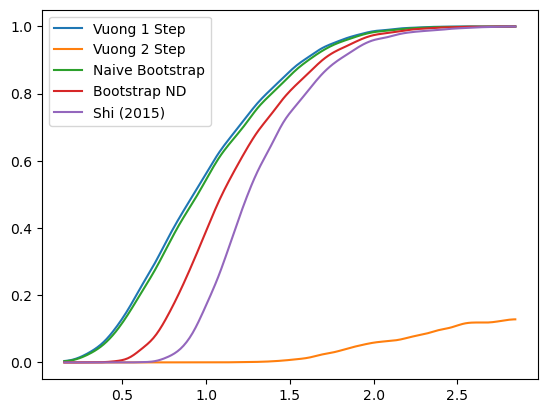

In [10]:
mc_run_power(nobs,c1,c2)
